***
##### Import the necessary libraries

In [1]:
import re
import json
import string
import datetime
import random
import itertools
from collections import OrderedDict, defaultdict

import random
import datetime
from gensim import corpora
import pandas as pd
import numpy as np
import FastLDA
from pSSLDA import infer
from os import path
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_rows', 50)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 7)

warnings.filterwarnings("ignore")

***
##### Load the depression lexicon file and tweets data

In [2]:
with open("depression_lexicon.json") as f:
    seed_terms = json.load(f)

In [3]:
tweets_df = pd.read_csv('Data/tweets_cleaned.csv')
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

In [4]:
tweets_df_50 = tweets_df[tweets_df._50 == 1]
tweets_df_70 = tweets_df[tweets_df._70 == 1]
tweets_df_100 = tweets_df[tweets_df._100 == 1]

In [5]:
users = set(tweets_df['username'].to_list())
users_50 = set(tweets_df_50['username'].to_list())
users_70 = set(tweets_df_70['username'].to_list())
users_100 = set(tweets_df_100['username'].to_list())

In [6]:
tweets_df = tweets_df[["tweet_id", "created_at", "text",
                       "cleaned_text", "vader_compound_raw", 'username']]
tweets_df.columns = ["tweet_ID", "created_at",
                     "raw_text", "cleaned_text", "sentiment", 'username']
tweets_df_50 = tweets_df_50[["tweet_id", "created_at",
                             "text", "cleaned_text", "vader_compound_raw", 'username']]
tweets_df_50.columns = ["tweet_ID", "created_at",
                        "raw_text", "cleaned_text", "sentiment", 'username']
tweets_df_70 = tweets_df_70[["tweet_id", "created_at",
                             "text", "cleaned_text", "vader_compound_raw", 'username']]
tweets_df_70.columns = ["tweet_ID", "created_at",
                        "raw_text", "cleaned_text", "sentiment", 'username']
tweets_df_100 = tweets_df_100[["tweet_id", "created_at",
                               "text", "cleaned_text", "vader_compound_raw", 'username']]
tweets_df_100.columns = ["tweet_ID", "created_at",
                         "raw_text", "cleaned_text", "sentiment", 'username']

In [7]:
# Filter for users who have at least 100 tweets in past 3 months
if path.exists("Data/user_sample.txt"):
    file = open("Data/user_sample.txt", "r")
    lines = file.read()
    user_sample = lines.split("\n")
else:
    user_sample = random.sample(users_100, 100)
    with open("Data/user_sample.txt", "w") as file:
        lines = "\n".join(user_sample)
        file.write(lines)

***
##### To emulate PHQ-9 questionare, we bucket tweets based on their creation time with a sliding window of 14 days for each user. Each of these buckets will be treated as a document.

In [8]:
def create_time_buckets(tweets):

    bucketed_tweets = defaultdict(list)

    days = 14
    counter = 0

    start_date = tweets.created_at.dt.date.min()
    end_date = tweets.created_at.dt.date.max() + timedelta(days=1)

    new_start = start_date
    new_end = start_date + timedelta(days=14)

    while True:

        if new_end <= end_date:

            mask = (tweets['created_at'] >= new_start) & (
                tweets['created_at'] <= new_end)
            df = tweets[mask]

            for index, tweet in df.iterrows():
                bucketed_tweets[counter].append(tweet)

            new_start = new_start + timedelta(days=1)
            new_end = new_end + timedelta(days=1)

            counter += 1

        else:
            break

    return bucketed_tweets

In [9]:
user_bucketed_tweets = {}

for user in user_sample:
    user_bucketed_tweets[user] = create_time_buckets(
        tweets_df[tweets_df['username'] == user])

***
##### Prepare the data for LDA from the bucketed tweets

In [10]:
def data_prep(bucketed_tweets):

    texts = list()
    text_as_ids = list()
    doc_as_ids = list()

    number_of_docs = len(bucketed_tweets)

    for bucket in bucketed_tweets:
        all_bucket_tweets = ""
        for tweet in bucketed_tweets[bucket]:
            all_bucket_tweets += str(tweet.cleaned_text) + " "
        texts.append(all_bucket_tweets.strip().replace("\n", "").split(" "))

    dictionary = corpora.Dictionary(texts)
    dictionary.compactify()
    voc_size = len(list(dictionary.keys()))

    # replace token ids with the token text in each doc and return similar arry of tokens and docs to later be the docvec
    for x in range(number_of_docs):
        doc = texts[x]
        for token in doc:
            text_as_ids.append(dictionary.token2id[token])
            doc_as_ids.append(x)

    return text_as_ids, doc_as_ids, voc_size, dictionary.token2id, number_of_docs, bucketed_tweets

In [11]:
user_LDA_inputs = {}

for user in user_sample:
    user_LDA_inputs[user] = data_prep(user_bucketed_tweets[user])

***
##### Helper functions

In [12]:
def get_avg_sentiment(bucketed_tweets, token):

    score = 0.0
    count = 0

    term_tweets_sent_scores = get_tweets_by_term(bucketed_tweets, token)

    for sent_score in term_tweets_sent_scores:
        score += float(sent_score)
        count += 1

    return score / count


def get_tweets_by_term(bucketed_tweets, term):

    term_tweets_sent_scores = list()

    for bucket in bucketed_tweets:
        for tweet in bucketed_tweets[bucket]:
            if term in str(tweet.cleaned_text):
                term_tweets_sent_scores.append(tweet.sentiment)

    return term_tweets_sent_scores


def get_topics_terms(tup):

    topics_dict = defaultdict(defaultdict)

    estphi = tup[0]
    W = tup[1]
    T = tup[2]
    id2token = tup[3]

    for index in range(W):
        term_weights = estphi[:, index]
        largest_weight = 0

        for weight in term_weights:
            if weight > largest_weight:
                largest_weight = weight

        term_topic = np.argwhere(term_weights == largest_weight)[0][0]
        topics_dict[term_topic][id2token[index]] = largest_weight

    return topics_dict


def get_all_terms_sentiments(id2token, w, bucketed_tweets):

    seed_term_sentiment = defaultdict(float)

    w = list(set(w))

    for wi in w:

        token = id2token[wi]

        if token in seed_terms['signal_1']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_2']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_3']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_4']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_5']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_6']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_7']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_8']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_9']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_10']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

    return seed_term_sentiment

***
##### Run LDA 

In [15]:
def run_LDA(LDA_input, parameters):
    try:
        token2id = LDA_input[3]

        T = parameters["topics_count"]

        (wordvec, docvec, zvec) = ([], [], [])

        wordvec = LDA_input[0]
        docvec = LDA_input[1]

        W = LDA_input[2]

        (w, d) = (np.array(wordvec, dtype = np.int), np.array(docvec, dtype = np.int))

        alpha = np.ones((1,T)) * 1
        beta = np.ones((T,W)) * 0.01

        P = 1

        randseed =  random.randint(999,999999)

        numsamp = 500

        final_z = infer(w, d, alpha, beta, numsamp, randseed, P)

        D = LDA_input[4]

        # Estimate phi and theta
        (nw, nd) = FastLDA.countMatrices(w, W, d, D, final_z, T)
        (estphi,esttheta) = FastLDA.estPhiTheta(nw, nd, alpha, beta)

        id2token = dict((v,k) for k,v in token2id.iteritems())

        seed_term_sentiment = get_all_terms_sentiments(id2token, w, LDA_input[5])

        # force words into separate topics

        labelweight = 5.0

        label0 = np.zeros((T,), dtype=np.float)
        label0[0] = labelweight

        label1 = np.zeros((T,), dtype=np.float)
        label1[1] = labelweight

        label2 = np.zeros((T,), dtype=np.float)
        label2[2] = labelweight

        label3 = np.zeros((T,), dtype=np.float)
        label3[3] = labelweight

        label4 = np.zeros((T,), dtype=np.float)
        label4[4] = labelweight

        label5 = np.zeros((T,), dtype=np.float)
        label5[5] = labelweight

        label6 = np.zeros((T,), dtype=np.float)
        label6[6] = labelweight

        label7 = np.zeros((T,), dtype=np.float)
        label7[7] = labelweight

        label8 = np.zeros((T,), dtype=np.float)
        label8[8] = labelweight

        label9 = np.zeros((T,), dtype=np.float)
        label9[9] = labelweight

        label10 = np.zeros((T,), dtype=np.float)
        label10[10] = labelweight

        label11 = np.zeros((T,), dtype=np.float)
        label11[11] = labelweight

        corpus_signals = [0,1,2,3,4,5,6,7,8,9]

        seed_terms_per_signal = defaultdict(lambda: defaultdict(int))

        z_labels = []
        for wi in w:

            token = id2token[wi]

            # if the word appears in topic 0
            if token in seed_terms['signal_1'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label0)

                seed_terms_per_signal['signal_1'][token]+=1

                if 0 in corpus_signals:
                    corpus_signals.remove(0)


            elif token in seed_terms['signal_2'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label1)

                seed_terms_per_signal['signal_2'][token]+=1

                if 1 in corpus_signals:
                    corpus_signals.remove(1)


            elif token in seed_terms['signal_3'] and seed_term_sentiment[token] <= 0:

                z_labels.append(label2)

                seed_terms_per_signal['signal_3'][token]+=1

                if 2 in corpus_signals:
                    corpus_signals.remove(2)


            elif token in seed_terms['signal_4'] and seed_term_sentiment[token] <= 0:

                z_labels.append(label3)
                seed_terms_per_signal['signal_4'][token]+=1

                if 3 in corpus_signals:
                    corpus_signals.remove(3)


            elif token in seed_terms['signal_5'] and seed_term_sentiment[token] <= 0:

                z_labels.append(label4)

                seed_terms_per_signal['signal_5'][token]+=1

                if 4 in corpus_signals:
                    corpus_signals.remove(4)

            elif token in seed_terms['signal_6'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label5)

                seed_terms_per_signal['signal_6'][token]+=1

                if 5 in corpus_signals:
                    corpus_signals.remove(5)

            elif token in seed_terms['signal_7'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label6)

                seed_terms_per_signal['signal_7'][token]+=1

                if 6 in corpus_signals:
                    corpus_signals.remove(6)

            elif token in seed_terms['signal_8'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label7)

                seed_terms_per_signal['signal_8'][token]+=1

                if 7 in corpus_signals:
                    corpus_signals.remove(7)

            elif token in seed_terms['signal_9'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label8)

                seed_terms_per_signal['signal_9'][token]+=1

                if 8 in corpus_signals:
                    corpus_signals.remove(8)

            elif token in seed_terms['signal_10'] and  seed_term_sentiment[token] <= 0:

                z_labels.append(label9)

                seed_terms_per_signal['signal_10'][token]+=1

                if 9 in corpus_signals:
                    corpus_signals.remove(9)

            else:
                z_labels.append(None)

        # find topics with 0 and 1 in separate topics
        final_z = infer(w, d, alpha, beta, numsamp, randseed, P, zlabels = z_labels)

        # Re-estimate phi and theta
        (nw, nd) = FastLDA.countMatrices(w, W, d, D, final_z, T)
        (estphi,esttheta) = FastLDA.estPhiTheta(nw, nd, alpha, beta)

        # Find the sentiment of each topic cluster based on the tweets where each seed term appered in
        tup = (estphi, W, T, id2token)
        topics_terms = get_topics_terms(tup)

        sent_scores = defaultdict(list)

        counter = 0
        for topic in topics_terms:

            topic_sent_scores = list()

            for term in topics_terms[topic]:
                term_tweets_sent_scores = get_tweets_by_term(LDA_input[5], term)

                for sent_score in term_tweets_sent_scores:
                     topic_sent_scores.append(float(sent_score))

            avg = sum(topic_sent_scores) / float(len(topic_sent_scores))

            sent_scores[topic] = (topic_sent_scores, avg)

            counter+=1

        len_buckets = []
        for bucket in LDA_input[5]:
            len_b = len(LDA_input[5][bucket])
            len_buckets.append(len_b)

        min_number_of_tweets_per_bucket = parameters["min_tweets_per_bucket"]

        for x in range(len(len_buckets)):
            if len_buckets[x] <= min_number_of_tweets_per_bucket:
                esttheta[x, :] = 0

        for topic_id in corpus_signals:
            esttheta[:, topic_id] = 0

        all_topics_seeds = list()
        for signal in seed_terms_per_signal:
            all_topics_seeds += seed_terms_per_signal[signal]

        # topics to keep
        seeds_in_top_k = defaultdict(int)

        # number of seed terms that should be in the top topic terms
        seeds_threshold = parameters["seeds_threshold"]

        # The number of terms in the topic that we will look into to search for seed terms
        top_topic_terms = parameters["top_topic_terms"]

        for topic in topics_terms:
            for x in range(len(topics_terms[topic])):
                term = list(topics_terms[topic])[x]
                if x < top_topic_terms:
                    if term in all_topics_seeds:
                        seeds_in_top_k[topic] += 1

        # this will replace zero to the probabilities of the topic by ID if no seed terms were found in the corpus
        for x in range(len(esttheta[0])):
            if x in seeds_in_top_k.keys():
                if seeds_in_top_k[x] < seeds_threshold:
                    esttheta[:, x] = 0
            else:
                esttheta[:, x] = 0


        return (estphi, W, T, id2token), esttheta, topics_terms, seed_terms_per_signal
    
    except:
        pass

In [16]:
parameters = {"topics_count": 25, "min_tweets_per_bucket": 5, "seeds_threshold": 1, "top_topic_terms": 25}

user_LDA_outputs={}
for user in user_sample:
    user_LDA_outputs[user] = run_LDA(user_LDA_inputs[user], parameters)

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 3

Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample

Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sam

Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 

Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample

Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 

Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 

Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 o

Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494

Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assi

Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sam

Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492

Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440

Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408

Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405

Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427

Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419

Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429

Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410

Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463

Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441

Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471

Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454

Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498

Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associat

Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464

Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414

Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416

Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396

Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417

Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373

Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395

Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348

Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364

Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386

Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373

Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414

Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404

Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382

Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449

Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415

Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430

Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407

Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411

Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375

Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384

Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356

Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329

Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298

Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319

Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276

Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314

Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317

Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389

Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439

Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419

Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398

Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385

Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355

Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331

Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344

Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346

Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335

Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332

Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318

Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339

Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353

Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310

Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279

Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267

Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218

Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184

Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500


Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of

Sample 49 of 500
Sample 50 of 500
Sample 51 of 500
Sample 52 of 500
Sample 53 of 500
Sample 54 of 500
Sample 55 of 500
Sample 56 of 500
Sample 57 of 500
Sample 58 of 500
Sample 59 of 500
Sample 60 of 500
Sample 61 of 500
Sample 62 of 500
Sample 63 of 500
Sample 64 of 500
Sample 65 of 500
Sample 66 of 500
Sample 67 of 500
Sample 68 of 500
Sample 69 of 500
Sample 70 of 500
Sample 71 of 500
Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 

Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
Sample 45 of 500
Sample 46 of 500
Sample 47 of 500
Sample 48 of 500
Sample 49 of 500
Sample 50 of 500
Sample 51 of 500
Sample 52 of 500
Sample 53 of 500
Sample 54 of 500
Sample 55 of 500
Sample 56 of 500
Sample 5

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 3

Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496

Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing globa

Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500

Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 

Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Samp

Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473

Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431

Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454

Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464

Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446

Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396

Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359

Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372

Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324

Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328

Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296

Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274

Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277

Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349

Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297

Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286

Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298

Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292

Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249

Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251

Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251

Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221

Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186

Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 

Sample 47 of 500
Sample 48 of 500
Sample 49 of 500
Sample 50 of 500
Sample 51 of 500
Sample 52 of 500
Sample 53 of 500
Sample 54 of 500
Sample 55 of 500
Sample 56 of 500
Sample 57 of 500
Sample 58 of 500
Sample 59 of 500
Sample 60 of 500
Sample 61 of 500
Sample 62 of 500
Sample 63 of 500
Sample 64 of 500
Sample 65 of 500
Sample 66 of 500
Sample 67 of 500
Sample 68 of 500
Sample 69 of 500
Sample 70 of 500
Sample 71 of 500
Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 10

Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
Sample 45 of 500
Sample 46 of 500
Sample 47 of 500
Sample 48 of 500
Sample 49 of 500
Sample 50 of 500
Sample 51 of 500
Sample 52 of 500
Sample 53 of 500
Sample 54 of 500
Sample 55 of 500
Sample 56 of 500
Sample 5

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Gettin

Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454

Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458

Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497

Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458

Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482

Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436

Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412

Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407

Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362

Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421

Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389

Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402

Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368

Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318

Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323

Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335

Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340

Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353

Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348

Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393

Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359

Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385

Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356

Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339

Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323

Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274

Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286

Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293

Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303

Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258

Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255

Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278

Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297

Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275

Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269

Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258

Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264

Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248

Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251

Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205

Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156

Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 

Sample 55 of 500
Sample 56 of 500
Sample 57 of 500
Sample 58 of 500
Sample 59 of 500
Sample 60 of 500
Sample 61 of 500
Sample 62 of 500
Sample 63 of 500
Sample 64 of 500
Sample 65 of 500
Sample 66 of 500
Sample 67 of 500
Sample 68 of 500
Sample 69 of 500
Sample 70 of 500
Sample 71 of 500
Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
S

Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167

Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 

Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294

Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418

Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395

Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358

Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373

Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322 of 500
Sample 323 of 500
Sample 324 of 500
Sample 325 of 500
Sample 326 of 500
Sample 327 of 500
Sample 328 of 500
Sample 329 of 500
Sample 330 of 500
Sample 331 of 500
Sample 332 of 500
Sample 333 of 500
Sample 334 of 500
Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358

Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296 of 500
Sample 297 of 500
Sample 298 of 500
Sample 299 of 500
Sample 300 of 500
Sample 301 of 500
Sample 302 of 500
Sample 303 of 500
Sample 304 of 500
Sample 305 of 500
Sample 306 of 500
Sample 307 of 500
Sample 308 of 500
Sample 309 of 500
Sample 310 of 500
Sample 311 of 500
Sample 312 of 500
Sample 313 of 500
Sample 314 of 500
Sample 315 of 500
Sample 316 of 500
Sample 317 of 500
Sample 318 of 500
Sample 319 of 500
Sample 320 of 500
Sample 321 of 500
Sample 322

Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271

Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225

Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223

Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226

Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221

Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240

Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237

Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264

Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212

Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256

Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270

Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292

Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283 of 500
Sample 284 of 500
Sample 285 of 500
Sample 286 of 500
Sample 287 of 500
Sample 288 of 500
Sample 289 of 500
Sample 290 of 500
Sample 291 of 500
Sample 292 of 500
Sample 293 of 500
Sample 294 of 500
Sample 295 of 500
Sample 296

Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261 of 500
Sample 262 of 500
Sample 263 of 500
Sample 264 of 500
Sample 265 of 500
Sample 266 of 500
Sample 267 of 500
Sample 268 of 500
Sample 269 of 500
Sample 270 of 500
Sample 271 of 500
Sample 272 of 500
Sample 273 of 500
Sample 274 of 500
Sample 275 of 500
Sample 276 of 500
Sample 277 of 500
Sample 278 of 500
Sample 279 of 500
Sample 280 of 500
Sample 281 of 500
Sample 282 of 500
Sample 283

Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244 of 500
Sample 245 of 500
Sample 246 of 500
Sample 247 of 500
Sample 248 of 500
Sample 249 of 500
Sample 250 of 500
Sample 251 of 500
Sample 252 of 500
Sample 253 of 500
Sample 254 of 500
Sample 255 of 500
Sample 256 of 500
Sample 257 of 500
Sample 258 of 500
Sample 259 of 500
Sample 260 of 500
Sample 261

Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229 of 500
Sample 230 of 500
Sample 231 of 500
Sample 232 of 500
Sample 233 of 500
Sample 234 of 500
Sample 235 of 500
Sample 236 of 500
Sample 237 of 500
Sample 238 of 500
Sample 239 of 500
Sample 240 of 500
Sample 241 of 500
Sample 242 of 500
Sample 243 of 500
Sample 244

Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196

Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500


Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
S

Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212 of 500
Sample 213 of 500
Sample 214 of 500
Sample 215 of 500
Sample 216 of 500
Sample 217 of 500
Sample 218 of 500
Sample 219 of 500
Sample 220 of 500
Sample 221 of 500
Sample 222 of 500
Sample 223 of 500
Sample 224 of 500
Sample 225 of 500
Sample 226 of 500
Sample 227 of 500
Sample 228 of 500
Sample 229

Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179

Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165

Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sa

Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 

Sample 62 of 500
Sample 63 of 500
Sample 64 of 500
Sample 65 of 500
Sample 66 of 500
Sample 67 of 500
Sample 68 of 500
Sample 69 of 500
Sample 70 of 500
Sample 71 of 500
Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 o

Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171 of 500
Sample 172 of 500
Sample 173 of 500
Sample 174 of 500
Sample 175 of 500
Sample 176 of 500
Sample 177 of 500
Sample 178 of 500
Sample 179 of 500
Sample 180 of 500
Sample 181 of 500
Sample 182 of 500
Sample 183 of 500
Sample 184 of 500
Sample 185 of 500
Sample 186 of 500
Sample 187 of 500
Sample 188 of 500
Sample 189 of 500
Sample 190 of 500
Sample 191 of 500
Sample 192 of 500
Sample 193 of 500
Sample 194 of 500
Sample 195 of 500
Sample 196 of 500
Sample 197 of 500
Sample 198 of 500
Sample 199 of 500
Sample 200 of 500
Sample 201 of 500
Sample 202 of 500
Sample 203 of 500
Sample 204 of 500
Sample 205 of 500
Sample 206 of 500
Sample 207 of 500
Sample 208 of 500
Sample 209 of 500
Sample 210 of 500
Sample 211 of 500
Sample 212

Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500
Sample 149 of 500
Sample 150 of 500
Sample 151 of 500
Sample 152 of 500
Sample 153 of 500
Sample 154 of 500
Sample 155 of 500
Sample 156 of 500
Sample 157 of 500
Sample 158 of 500
Sample 159 of 500
Sample 160 of 500
Sample 161 of 500
Sample 162 of 500
Sample 163 of 500
Sample 164 of 500
Sample 165 of 500
Sample 166 of 500
Sample 167 of 500
Sample 168 of 500
Sample 169 of 500
Sample 170 of 500
Sample 171

Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
S

Sample 55 of 500
Sample 56 of 500
Sample 57 of 500
Sample 58 of 500
Sample 59 of 500
Sample 60 of 500
Sample 61 of 500
Sample 62 of 500
Sample 63 of 500
Sample 64 of 500
Sample 65 of 500
Sample 66 of 500
Sample 67 of 500
Sample 68 of 500
Sample 69 of 500
Sample 70 of 500
Sample 71 of 500
Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
S

Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 500
Sample 117 of 500
Sample 118 of 500
Sample 119 of 500
Sample 120 of 500
Sample 121 of 500
Sample 122 of 500
Sample 123 of 500
Sample 124 of 500
Sample 125 of 500
Sample 126 of 500
Sample 127 of 500
Sample 128 of 500
Sample 129 of 500
Sample 130 of 500
Sample 131 of 500
Sample 132 of 500
Sample 133 of 500
Sample 134 of 500
Sample 135 of 500
Sample 136 of 500
Sample 137 of 500
Sample 138 of 500
Sample 139 of 500
Sample 140 of 500
Sample 141 of 500
Sample 142 of 500
Sample 143 of 500
Sample 144 of 500
Sample 145 of 500
Sample 146 of 500
Sample 147 of 500
Sample 148 of 500

Sample 59 of 500
Sample 60 of 500
Sample 61 of 500
Sample 62 of 500
Sample 63 of 500
Sample 64 of 500
Sample 65 of 500
Sample 66 of 500
Sample 67 of 500
Sample 68 of 500
Sample 69 of 500
Sample 70 of 500
Sample 71 of 500
Sample 72 of 500
Sample 73 of 500
Sample 74 of 500
Sample 75 of 500
Sample 76 of 500
Sample 77 of 500
Sample 78 of 500
Sample 79 of 500
Sample 80 of 500
Sample 81 of 500
Sample 82 of 500
Sample 83 of 500
Sample 84 of 500
Sample 85 of 500
Sample 86 of 500
Sample 87 of 500
Sample 88 of 500
Sample 89 of 500
Sample 90 of 500
Sample 91 of 500
Sample 92 of 500
Sample 93 of 500
Sample 94 of 500
Sample 95 of 500
Sample 96 of 500
Sample 97 of 500
Sample 98 of 500
Sample 99 of 500
Sample 100 of 500
Sample 101 of 500
Sample 102 of 500
Sample 103 of 500
Sample 104 of 500
Sample 105 of 500
Sample 106 of 500
Sample 107 of 500
Sample 108 of 500
Sample 109 of 500
Sample 110 of 500
Sample 111 of 500
Sample 112 of 500
Sample 113 of 500
Sample 114 of 500
Sample 115 of 500
Sample 116 of 5

In [17]:
def detect_depression(LDA_output, user):
    
    try:

        esttheta = LDA_output[1]
        
        print ("Topics Probabilties Over Time for "+user)
                
        columns = ["Time Period", "Signal-1", "Signal-2", "Signal-3", "Signal-4", "Signal-5",
                                  "Signal-6", "Signal-7", "Signal-8", "Signal-9", "Signal-10"]
        
        rows = list()
        
        counter = 0
        for key in user_bucketed_tweets[user].keys():
            df = pd.DataFrame(user_bucketed_tweets[user][key])
            bucket_date = str(df.created_at.min().strftime("%d/%m/%Y")) + " - " + \
                          str(df.created_at.max().strftime("%d/%m/%Y"))
            row = [bucket_date] + [esttheta[counter][x] for x in range(len(esttheta[counter])) if x < 10]
            rows.append(row)
            counter+=1

        topics_probabilities = pd.DataFrame(rows, columns=columns)
        
        display(topics_probabilities)
        
        topics_probabilities.plot(kind='line')
        plt.show()
                
        print ("Topics Terms for "+user)
        
        columns = ["Topic Number", "Topic Terms"]
        rows = list()
        
        for topic in LDA_output[2]:
            topic_nbr = topic+1
            rows.append([topic_nbr, ", ".join(LDA_output[2][topic])])

        topics_terms = pd.DataFrame(rows, columns=columns)
                    
        display(topics_terms)

        print ("Seeded Terms Per Topic for "+user)

        columns = ["Topic Number", "Seed Terms:Count"]
        rows = list()
        
        for topic in LDA_output[3]:
            
            seedTerms = [str(seedTerm)+":"+str(LDA_output[3][topic][seedTerm]) 
                                         for seedTerm in LDA_output[3][topic]]
            rows.append([topic, ", ".join(seedTerms)])
        
        topics_seeds = pd.DataFrame(rows, columns=columns)
                    
        display(topics_seeds)
        
        return topics_probabilities, topics_terms, topics_seeds
    
    except AssertionError:
        print ("Amount of tweets is insufficent for detecting depressions")

Topics Probabilties Over Time for patriciaco


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   14/05/2009 - 22/05/2009     0.0    0.0087719     0.0       0.0     
1   17/05/2009 - 28/05/2009     0.0    0.0100000     0.0       0.0     
2   17/05/2009 - 29/05/2009     0.0    0.0165289     0.0       0.0     
3   17/05/2009 - 30/05/2009     0.0    0.0314465     0.0       0.0     
4   18/05/2009 - 31/05/2009     0.0    0.0950413     0.0       0.0     
5   22/05/2009 - 01/06/2009     0.0    0.0794521     0.0       0.0     
6   22/05/2009 - 02/06/2009     0.0    0.0749415     0.0       0.0     
7   22/05/2009 - 03/06/2009     0.0    0.1035156     0.0       0.0     
8   22/05/2009 - 04/06/2009     0.0    0.0933852     0.0       0.0     
9   28/05/2009 - 05/06/2009     0.0    0.0802239     0.0       0.0     
10  28/05/2009 - 06/06/2009     0.0    0.0862355     0.0       0.0     
11  28/05/2009 - 07/06/2009     0.0    0.0736842     0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0       0.0

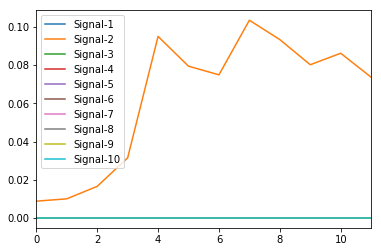

Topics Terms for patriciaco


Topic Number                    Topic Terms                    
0         1       archie, yay, everytime, haha, nick, live, cous...
1         2       profile, blaming, replying, mind, work, utah, ...
2         3       pia, visit, problem, tiny, agree, unlucky, tou...
3         4       davanie, account, trace, hunger, lil, chocolat...
4         5       mar, read, potter, number, making, sad, sunday...
5         6       ohmygod, replied, loves, hour, hint, twitter, ...
6         7       ahhh, lambert, awesome, yeahhh, yeah, station,...
7         8       younger, voice, serena, shang, blair, celebrit...
8         9       aware, okayy, ahead, stephanie, teehee, scream...
9        10       sound, btw, hott, yup, nooo, pastas, rhymes, i...
10       11       freak, metro, people, told, forgooot, remindin...
11       12       set, vanessa, greet, give_up, birthday, connec...
12       13       someday, staying, jamie, longer, leaving, happ...
13       14       votes, filipino, family, joe, cuties, gahhh, f...
14       15       explaining, life, word, dvd, goodnight, versio...
15       16       ghost, great, accomplish, school, song, sweet,...
16       17       goodnighttt, tutor, italy, pray, feel, julie, ...
17       18       thought, againn, goodluck, tweeting, problemoo...
18       19       hotel, lawyer, top, guress, pic, hey, shontell...
19       20       debby, lei, click, current, thing, goodeveing,...
20       21       hah, war, clicking, meaaannn, tweet, nan, plle...
21       22       , comment, plans, mcfly, lucky, goodevening, k...
22       23       buy, eating, shirt, joke, watch, met, amazing,...
23       24       meant, classmates, frankie, simple, philippine...
24       25       picture, joined, guessing, meee, god, coz, rea...

Seeded Terms Per Topic for patriciaco


Topic Number Seed Terms:Count
0   signal_2      miserable:6

Topics Probabilties Over Time for ShesElectric_


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   18/04/2009 - 19/04/2009     0.0       0.0       0.0    0.0000000   
1   19/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0000000   
2   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
3   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
4   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
5   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
6   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
7   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
8   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
9   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
10  02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
11  02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
12  02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
13  02/05/2009 - 14/05/2009     0.0       0.0       0.0    0.0246914   
14  02/05/2009 - 14/05/2009     0.0       0.0       0.0    0.0123457   
15  03/05/2009 - 14/05/2009     0.0       0.0       0.0    0.0133333   
16  14/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0158730   
17  14/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0143885   
18  14/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0071942   
19  14/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0071942   
20  14/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0215827   
21  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0059880   
22  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0059880   
23  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0059880   
24  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0059880   
..                      ...       ...       ...       ...        ...   
31  22/05/2009 - 01/06/2009     0.0       0.0       0.0    0.1210191   
32  22/05/2009 - 02/06/2009     0.0       0.0       0.0    0.1181818   
33  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.1104478   
34  22/05/2009 - 04/06/2009     0.0       0.0       0.0    0.1150442   
35  29/05/2009 - 05/06/2009     0.0       0.0       0.0    0.1092437   
36  29/05/2009 - 06/06/2009     0.0       0.0       0.0    0.1053922   
37  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0933941   
38  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0865604   
39  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0956720   
40  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0911162   
41  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0888383   
42  30/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0792839   
43  31/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0712074   
44  01/06/2009 - 07/06/2009     0.0       0.0       0.0    0.0507812   
45  02/06/2009 - 15/06/2009     0.0       0.0       0.0    0.0126582   
46  03/06/2009 - 16/06/2009     0.0       0.0       0.0    0.0037037   
47  04/06/2009 - 17/06/2009     0.0       0.0       0.0    0.0036101   
48  05/06/2009 - 18/06/2009     0.0       0.0       0.0    0.0036232   
49  06/06/2009 - 19/06/2009     0.0       0.0       0.0    0.0038462   
50  07/06/2009 - 19/06/2009     0.0       0.0       0.0    0.0047847   
51  15/06/2009 - 21/06/2009     0.0       0.0       0.0    0.0050000   
52  15/06/2009 - 21/06/2009     0.0       0.0       0.0    0.0050000   
53  15/06/2009 - 23/06/2009     0.0       0.0       0.0    0.0047170   
54  15/06/2009 - 23/06/2009     0.0       0.0       0.0    0.0047170   
55  15/06/2009 - 25/06/2009     0.0       0.0       0.0    0.0043860   

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0000000     0.0    0.0000000  0.0000000     0.0     
1      0.0    0.0000000     0.0    0.0000000  0.0000000     0.0     
2      0.0    0.0000000     0.0    0.0000000  0.0000000  

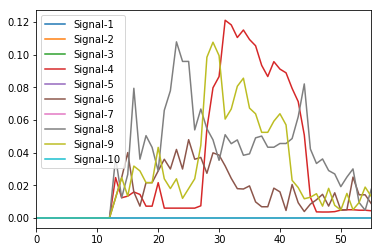

Topics Terms for ShesElectric_


Topic Number                    Topic Terms                    
0         1       havr, step, absolutely, head, pop, dropped, qu...
1         2       enjoy, respond, parade, mowing, kisses, mornig...
2         3       summer, battery, rest, hair, rat, message, xxx...
3         4       btw, rubbish, dont, family, sweets, mag, tanne...
4         5       gorgeous, cuddles, feel, night, phone, sleep, ...
5         6                                   shame, num, love, hey
6         7       beautifuls, toes, cup, nope, ragdoll, meaing, ...
7         8       minx, missed, people, nervous, angry, yeah, bl...
8         9       behaving, neighbours, loft, oi, nan, feels, hu...
9        10                                     xxx, lovelies, jinx
10       11       raining, life, dm, munching, twitters, beauts,...
11       12                                           msn, darlings
12       13       shut, eye, forget, sitting, fellow, hours, pop...
13       14       articles, walking, everyoneee, read, serve, fr...
14       15                                           picky, friend
15       16       cute, eh, fair, photo, idea, held, thought, sc...
16       17       feelking, shattered, good, babe, frozen, watch...
17       18       buy, yummy, minutes, stalker, house, nooo, dog...
18       19       great, shakes, mood, lots, cider, hun, huuug, ...
19       20       hehehe, awwwk, talking, girl, everyones, yous,...
20       21       staring, aww, sun, youuu, barely, shining, get...
21       22       chats, wossy, abandoned, giiirls, sigh, mind, ...
22       23       kisskiss, twitter, earlier, quiet, sad, afternoon
23       24       atmospheres, morning, boiling, big, leaving, c...
24       25       muuust, dripping, t_sleep, bunch, sweethearts,...

Seeded Terms Per Topic for ShesElectric_


Topic Number          Seed Terms:Count        
0   signal_9                    hell:28, hurt:14
1   signal_8    anxious:14, nervous:14, angry:14
2   signal_4                    feeling_tired:14
3   signal_6                            shame:14

Topics Probabilties Over Time for SarahMorrison


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   18/04/2009 - 18/04/2009     0.0    0.0000000     0.0       0.0     
1   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
2   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
3   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
4   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
5   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
6   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
7   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
8   10/05/2009 - 17/05/2009     0.0    0.0000000     0.0       0.0     
9   10/05/2009 - 18/05/2009     0.0    0.1333333     0.0       0.0     
10  10/05/2009 - 18/05/2009     0.0    0.1444444     0.0       0.0     
11  10/05/2009 - 18/05/2009     0.0    0.1444444     0.0       0.0     
12  10/05/2009 - 21/05/2009     0.0    0.1428571     0.0       0.0     
13  10/05/2009 - 21/05/2009     0.0    0.1318681     0.0       0.0     
14  10/05/2009 - 21/05/2009     0.0    0.1428571     0.0       0.0     
15  17/05/2009 - 21/05/2009     0.0    0.0253165     0.0       0.0     
16  17/05/2009 - 21/05/2009     0.0    0.0126582     0.0       0.0     
17  17/05/2009 - 26/05/2009     0.0    0.0123457     0.0       0.0     
18  17/05/2009 - 26/05/2009     0.0    0.0123457     0.0       0.0     
19  17/05/2009 - 26/05/2009     0.0    0.0123457     0.0       0.0     
20  17/05/2009 - 29/05/2009     0.0    0.0111111     0.0       0.0     
21  17/05/2009 - 30/05/2009     0.0    0.0143885     0.0       0.0     
22  18/05/2009 - 31/05/2009     0.0    0.0071429     0.0       0.0     
23  21/05/2009 - 01/06/2009     0.0    0.0165289     0.0       0.0     
24  21/05/2009 - 02/06/2009     0.0    0.0148148     0.0       0.0     
25  21/05/2009 - 03/06/2009     0.0    0.0131579     0.0       0.0     
26  26/05/2009 - 03/06/2009     0.0    0.0132450     0.0       0.0     
27  26/05/2009 - 05/06/2009     0.0    0.0110497     0.0       0.0     
28  26/05/2009 - 06/06/2009     0.0    0.0092593     0.0       0.0     
29  26/05/2009 - 07/06/2009     0.0    0.0085106     0.0       0.0     
30  26/05/2009 - 07/06/2009     0.0    0.0085106     0.0       0.0     
31  29/05/2009 - 07/06/2009     0.0    0.0086207     0.0       0.0     
32  29/05/2009 - 07/06/2009     0.0    0.0086207     0.0       0.0     
33  29/05/2009 - 07/06/2009     0.0    0.0086207     0.0       0.0     
34  30/05/2009 - 07/06/2009     0.0    0.0134529     0.0       0.0     
35  31/05/2009 - 07/06/2009     0.0    0.0114286     0.0       0.0     
36  01/06/2009 - 07/06/2009     0.0    0.0121212     0.0       0.0     
37  02/06/2009 - 15/06/2009     0.0    0.0051546     0.0       0.0     
38  03/06/2009 - 16/06/2009     0.0    0.0048077     0.0       0.0     
39  05/06/2009 - 17/06/2009     0.0    0.0042918     0.0       0.0     
40  05/06/2009 - 18/06/2009     0.0    0.0036232     0.0       0.0     
41  06/06/2009 - 19/06/2009     0.0    0.0036364     0.0       0.0     
42  07/06/2009 - 20/06/2009     0.0    0.0040816     0.0       0.0     
43  15/06/2009 - 20/06/2009     0.0    0.0044248     0.0       0.0     
44  15/06/2009 - 22/06/2009     0.0    0.0040323     0.0       0.0     
45  15/06/2009 - 23/06/2009     0.0    0.0038462     0.0       0.0     
46  15/06/2009 - 23/06/2009     0.0    0.0038462     0.0       0.0     
47  15/06/2009 - 25/06/2009     0.0    0.0037453     0.0       0.0     

    Signal-5   Signal-6   Signal-7   Signal-8  Signal-9   Signal-10  
0   0.0000000  0.0000000  0.0000000     0.0    0.0000000     0.0     
1   0.0000000  0.0000000  0.0000000     0.0    0.0000000     0.0     
2   0.0000000  0.0000000  0.0000000     0.0    0.0000000     0.0     
3   0.0000000  0.0000000  0.0000000     0.0    0.0000000     0.0     
4   0.0000000  0.0000000  0.0000000     0.0    0.0000000     0.0     
5   0.0000000  0.0000000  0.0000000     0.0    0.0000000    

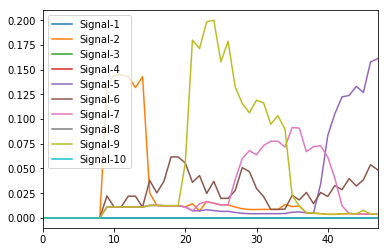

Topics Terms for SarahMorrison


Topic Number                    Topic Terms                    
0         1       stressful, mexico, remembered, movie, milliona...
1         2       door, untangled, admiting, floor, knocker, hai...
2         3       heart, crazy, point, purse, fuck, birdy, sound...
3         4       mexican, poppins, diddy, dumb, bed, sell, root...
4         5       twitter, volcom, driveway, pocohontas, livingr...
5         6                                       gross, girl, mary
6         7       wearing, room, cable, luv, car, bleach, nooo, ...
7         8         pouring, yay, la, coast, melissa, baby, clothes
8         9       ian, unproductive, converter, peeps, sneezing,...
9        10       goya, eyes, ball, love, gloss, house, stealing...
10       11                               , eating, yeah, listening
11       12       jonestown, waitin, memoirs, city, jew, sit, bl...
12       13       trip, weaves, shoes, og, light, excercise, los...
13       14       cute, lied, people, describe, month, brain, ac...
14       15       hearing, flashes, salad, memories, sucks, play...
15       16       aoki, throw, relay, parental, gina, wikipedia,...
16       17       control, steve, ivar, deleted, things, interne...
17       18       meant, annymous, lost, sold, caffeine, choice,...
18       19       week, lived, macguyver, bardot, sitting, club,...
19       20       aa, entire, ballet, havana, weight, friday, em...
20       21       feet, prolly, dont, watching, cars, adapter, d...
21       22                                       fun, num, benches
22       23       blind, outta, unfollow, franki, seizure, years...
23       24       funny, life, missed, tattoos, feel, bravo, han...
24       25       guess, messages, wife, ends, auto, weekends, n...

Seeded Terms Per Topic for SarahMorrison


Topic Number Seed Terms:Count
0   signal_9          hurt:28  
1   signal_2     miserable:14  
2   signal_5            fat:8  
3   signal_7      confused:14  
4   signal_6         gross:34

Topics Probabilties Over Time for sprinkles_


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
1   21/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
2   21/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
3   21/04/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
4   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
5   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
6   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
7   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
8   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
13  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
14  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
15  03/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
16  04/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
23  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
24  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
31  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
34  22/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
35  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
36  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
37  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
38  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
40  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
43  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
44  01/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
45  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
47  04/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
48  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
49  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
50  07/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
51  14/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
52  14/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
53  14/06/2009 - 21/06/2009     0.0     

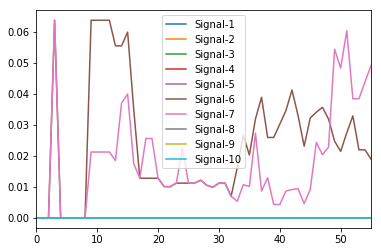

Topics Terms for sprinkles_


Topic Number                    Topic Terms                    
0         1       tires, terrible, tomorrow, big, hun, idea, sal...
1         2       enjoy, project, mood, jewellery, gorg, broody,...
2         3       hows, tenner, summer, nightmare, tidy, handy, ...
3         4       clip, skint, move, site, hair, mojo, goed, sau...
4         5                            food, fun, work, green, shop
5         6                                 read, shame, nan, worst
6         7       case, beads, misi, missing, top, confused, poo...
7         8       town, dreadful, life, pain, hammy, list, bathr...
8         9       twisty, cheap, crisps, crystals, message, girl...
9        10                                     dont, photographing
10       11       comment, evening, tireing, sold, oooh, ewww, h...
11       12       tagged, seed, strip, substitute, hotels, built...
12       13       fair, sooo, absolute, nights, start, necklaces...
13       14       love, people, welsh, house, lucky, yeah, job, ...
14       15       week, sized, pound, todays, tired, nicely, stu...
15       16       manky, chirpy, jewllery, justin, hr, specail, ...
16       17       squid, nail, bring, xx, beetroot, emry, tyvm, ...
17       18       smaller, pic, angrily, dead, skin, ay, annoys,...
18       19                                man, doenst, aw, morning
19       20                    lost, hmm, hear, relief, lover, nice
20       21       target, fit, congrats, favourite, bracelet, wi...
21       22       ive, shopping, takes, ew, giggle, crust, probl...
22       23                        noo, num, stripes, hope, married
23       24       absolutely, prawn, breakfast, baguette, guess,...
24       25       ages, carrot, names, fear, speak, missed, floo...

Seeded Terms Per Topic for sprinkles_


Topic Number  Seed Terms:Count 
0   signal_5                fat:1
1   signal_7           confused:9
2   signal_6    shame:42, worst:9

Topics Probabilties Over Time for nuttychris


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
1   20/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
2   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
3   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
4   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
5   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
6   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
7   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
8   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
13  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
14  03/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
15  04/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
16  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
22  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
23  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
24  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
25  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
26  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
27  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
28  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
29  18/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
30  30/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
31  30/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
32  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
33  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
34  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
35  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
36  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
37  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
38  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
39  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
40  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
41  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
42  01/06/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
43  01/06/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
44  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
45  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
46  15/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
47  15/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
48  15/06/2009 - 19/06/2009     0.0     

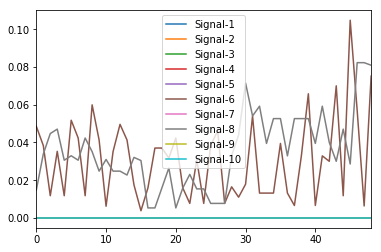

Topics Terms for nuttychris


Topic Number                    Topic Terms                    
0         1       love, ermm, win, chip, avatars, catching, duck...
1         2       woop, forever, working, deal, drunk, hopw, cau...
2         3       started, great, tweeting, amm, failed, behing,...
3         4       drinkin, difference, sumtimes, okies, drink, a...
4         5       stanger, stupid, missing, coursework, pints, u...
5         6                                shame, spoon, num, nosey
6         7                                 god, ema, lol, headache
7         8              week, thinking, atm, hey, ya, stressed_out
8         9       summer, fucking, uploading, site, understateme...
9        10       , break, disolve, gettin, cute, geek, mwhahaha...
10       11       people, ages, idea, brother, radio, choc, soun...
11       12       tewets, ass, userly, recover, uva, realise, so...
12       13                                     morning, didnt, sat
13       14       cmon, tar, soba, lokks, wim, probe, unfair, bl...
14       15           sweety, fully, nah, rule, hu, ur, bye, lolage
15       16       yonger, pic, forgot, yday, hate, gta, distinct...
16       17       guessing, dont, national, testing, yeah, colle...
17       18               lasses, bb, yup, sucks, dinner, gd, press
18       19       code, providers, skint, dose, merits, interweb...
19       20       oaps, group, worse, arnt, bed, cw, word, redo,...
20       21       ive, wbu, tomoz, withdrawels, willow, provider...
21       22            good, monkey, lost, gota, fuck, thn, primark
22       23       info, accturly, school, eating, oj, lmfao, div...
23       24       skittle, guess, business, checking, work, elde...
24       25       months, fair, feel, visit, kwl, pig, fter, bit...

Seeded Terms Per Topic for nuttychris


Topic Number Seed Terms:Count
0   signal_8    stressed_out:1 
1   signal_6           shame:1

Topics Probabilties Over Time for ComedyQueen


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   18/04/2009 - 19/04/2009  0.0444444     0.0       0.0       0.0     
1   19/04/2009 - 19/04/2009  0.0361446     0.0       0.0       0.0     
2   03/05/2009 - 03/05/2009  0.0000000     0.0       0.0       0.0     
3   03/05/2009 - 04/05/2009  0.0126582     0.0       0.0       0.0     
4   03/05/2009 - 04/05/2009  0.0126582     0.0       0.0       0.0     
5   03/05/2009 - 04/05/2009  0.0253165     0.0       0.0       0.0     
6   03/05/2009 - 04/05/2009  0.0253165     0.0       0.0       0.0     
7   03/05/2009 - 04/05/2009  0.0126582     0.0       0.0       0.0     
8   03/05/2009 - 04/05/2009  0.0379747     0.0       0.0       0.0     
9   03/05/2009 - 10/05/2009  0.0161290     0.0       0.0       0.0     
10  03/05/2009 - 10/05/2009  0.0080645     0.0       0.0       0.0     
11  03/05/2009 - 10/05/2009  0.0161290     0.0       0.0       0.0     
12  03/05/2009 - 10/05/2009  0.0564516     0.0       0.0       0.0     
13  03/05/2009 - 14/05/2009  0.0135135     0.0       0.0       0.0     
14  03/05/2009 - 14/05/2009  0.0135135     0.0       0.0       0.0     
15  03/05/2009 - 14/05/2009  0.0135135     0.0       0.0       0.0     
16  04/05/2009 - 17/05/2009  0.0050000     0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009  0.0174419     0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009  0.0232558     0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009  0.0058140     0.0       0.0       0.0     
20  10/05/2009 - 18/05/2009  0.0290698     0.0       0.0       0.0     
21  10/05/2009 - 22/05/2009  0.0564103     0.0       0.0       0.0     
22  10/05/2009 - 22/05/2009  0.0410256     0.0       0.0       0.0     
23  14/05/2009 - 22/05/2009  0.0400000     0.0       0.0       0.0     
24  14/05/2009 - 22/05/2009  0.0266667     0.0       0.0       0.0     
25  14/05/2009 - 22/05/2009  0.0200000     0.0       0.0       0.0     
26  14/05/2009 - 22/05/2009  0.0266667     0.0       0.0       0.0     
27  17/05/2009 - 22/05/2009  0.0396825     0.0       0.0       0.0     
28  17/05/2009 - 29/05/2009  0.0794702     0.0       0.0       0.0     
29  17/05/2009 - 30/05/2009  0.0641026     0.0       0.0       0.0     
30  18/05/2009 - 31/05/2009  0.0151515     0.0       0.0       0.0     
31  22/05/2009 - 01/06/2009  0.0500000     0.0       0.0       0.0     
32  22/05/2009 - 02/06/2009  0.0466667     0.0       0.0       0.0     
33  22/05/2009 - 03/06/2009  0.0253165     0.0       0.0       0.0     
34  22/05/2009 - 03/06/2009  0.0443038     0.0       0.0       0.0     
35  29/05/2009 - 05/06/2009  0.0270270     0.0       0.0       0.0     
36  29/05/2009 - 06/06/2009  0.0284091     0.0       0.0       0.0     
37  29/05/2009 - 07/06/2009  0.0295359     0.0       0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0       0.0     
17     0.0  

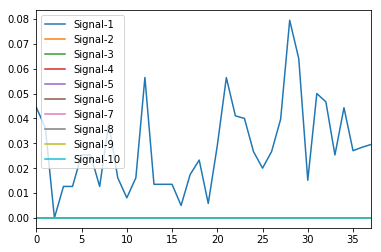

Topics Terms for ComedyQueen


Topic Number                    Topic Terms                    
0         1                                         bored, mwahahah
1         3       tale, min, feel, people, riping, break, replie...
2         4                                                    good
3         5                                            grater, anti
4         6       ive, eyes, heaven, pictures, atm, catering, gl...
5         7       shoot, nah, yeah, bullying, honoured, darn, wo...
6         8       drink, group, missing, read, nooo, grate, star...
7         9          sadly, dont, closest, exceeded, bleurgh, mouse
8        10       bassicly, foundation, love, exam, angel, space...
9        11       boy, naughty, curry, nicked, grades, accessory...
10       12       mickey, web, deck, aww, ahh, sooo, probbably, ...
11       13                       sort, shinyyy, morning, slow, sad
12       14       info, hows, great, risk, fit, explaining, sun,...
13       15       plug, duno, hour, int, twitter, moved, quiet, ...
14       16       tea, scared, flipping, fail, weather, flatly, ...
15       17       hair, stolen, yummy, feedback, scary, idear, d...
16       18       thansk, nan, wantto, ww, xx, num, hides, yayyy...
17       19                        breeder, time, awwh, day, hungry
18       20                        shop, hero, gold, yup, cuz, fine
19       21                                                     lol
20       22       cheese, tired, suggestions, site, plans, leave...
21       23       watcher, isnt, pass, girl, hehe, lefted, cuddy...
22       25       go_to_sleep, soo, tonight, talking, ready, mut...

Seeded Terms Per Topic for ComedyQueen


Topic Number Seed Terms:Count
0   signal_1       bored:16

Topics Probabilties Over Time for MsStaceyK


Time Period         Signal-1   Signal-2  Signal-3   Signal-4   \
0   18/04/2009 - 19/04/2009  0.0000000     0.0    0.0000000  0.0000000   
1   19/04/2009 - 19/04/2009  0.0000000     0.0    0.0000000  0.0000000   
2   03/05/2009 - 03/05/2009  0.0000000     0.0    0.0000000  0.0000000   
3   03/05/2009 - 03/05/2009  0.0000000     0.0    0.0000000  0.0000000   
4   03/05/2009 - 03/05/2009  0.0000000     0.0    0.0000000  0.0000000   
5   03/05/2009 - 03/05/2009  0.0000000     0.0    0.0000000  0.0000000   
6   03/05/2009 - 03/05/2009  0.0000000     0.0    0.0000000  0.0000000   
7   03/05/2009 - 03/05/2009  0.0000000     0.0    0.0000000  0.0000000   
8   03/05/2009 - 09/05/2009  0.0000000     0.0    0.0000000  0.0000000   
9   03/05/2009 - 10/05/2009  0.0000000     0.0    0.0000000  0.0000000   
10  03/05/2009 - 10/05/2009  0.0000000     0.0    0.0000000  0.0000000   
11  03/05/2009 - 10/05/2009  0.0000000     0.0    0.0000000  0.0000000   
12  03/05/2009 - 10/05/2009  0.0000000     0.0    0.0000000  0.0000000   
13  03/05/2009 - 14/05/2009  0.0153846     0.0    0.0307692  0.0153846   
14  03/05/2009 - 14/05/2009  0.0153846     0.0    0.0615385  0.0153846   
15  03/05/2009 - 14/05/2009  0.0153846     0.0    0.0461538  0.0153846   
16  09/05/2009 - 17/05/2009  0.0153846     0.0    0.0307692  0.0153846   
17  09/05/2009 - 17/05/2009  0.0153846     0.0    0.0461538  0.0153846   
18  09/05/2009 - 17/05/2009  0.0153846     0.0    0.0461538  0.0153846   
19  09/05/2009 - 17/05/2009  0.0153846     0.0    0.0307692  0.0153846   
20  09/05/2009 - 17/05/2009  0.0153846     0.0    0.0153846  0.0153846   
21  09/05/2009 - 22/05/2009  0.0128205     0.0    0.0256410  0.0128205   
22  10/05/2009 - 22/05/2009  0.0140845     0.0    0.0281690  0.0140845   
23  14/05/2009 - 22/05/2009  0.0000000     0.0    0.0000000  0.0000000   
24  14/05/2009 - 22/05/2009  0.0000000     0.0    0.0000000  0.0000000   
..                      ...        ...       ...        ...        ...   
29  17/05/2009 - 29/05/2009  0.0000000     0.0    0.0000000  0.0000000   
30  22/05/2009 - 29/05/2009  0.0000000     0.0    0.0000000  0.0000000   
31  22/05/2009 - 01/06/2009  0.0142857     0.0    0.0142857  0.1000000   
32  22/05/2009 - 02/06/2009  0.0098039     0.0    0.0392157  0.1274510   
33  22/05/2009 - 02/06/2009  0.0098039     0.0    0.0294118  0.1176471   
34  22/05/2009 - 02/06/2009  0.0098039     0.0    0.0294118  0.1176471   
35  29/05/2009 - 05/06/2009  0.0107527     0.0    0.0537634  0.1290323   
36  29/05/2009 - 06/06/2009  0.0042918     0.0    0.0429185  0.0557940   
37  29/05/2009 - 07/06/2009  0.0030030     0.0    0.0330330  0.0420420   
38  29/05/2009 - 07/06/2009  0.0030030     0.0    0.0270270  0.0390390   
39  29/05/2009 - 07/06/2009  0.0060060     0.0    0.0330330  0.0330330   
40  29/05/2009 - 07/06/2009  0.0060060     0.0    0.0270270  0.0420420   
41  29/05/2009 - 07/06/2009  0.0030030     0.0    0.0270270  0.0390390   
42  01/06/2009 - 07/06/2009  0.0060790     0.0    0.0273556  0.0455927   
43  01/06/2009 - 07/06/2009  0.0060790     0.0    0.0273556  0.0364742   
44  01/06/2009 - 07/06/2009  0.0060790     0.0    0.0212766  0.0395137   
45  02/06/2009 - 15/06/2009  0.0465753     0.0    0.0219178  0.0191781   
46  05/06/2009 - 16/06/2009  0.0591133     0.0    0.0147783  0.0024631   
47  05/06/2009 - 17/06/2009  0.0729412     0.0    0.0188235  0.0023529   
48  05/06/2009 - 18/06/2009  0.0777538     0.0    0.0172786  0.0021598   
49  06/06/2009 - 19/06/2009  0.1025105     0.0    0.0167364  0.0062762   
50  07/06/2009 - 20/06/2009  0.1428571     0.0    0.0114286  0.0085714   
51  15/06/2009 - 20/06/2009  0.1927711     0.0    0.0160643  0.0120482   
52  15/06/2009 - 20/06/2009  0.1967871     0.0    0.0120482  0.0120482   
53  15/06/2009 - 23/06/2009  0.1884058     0.0    0.0072464  0.0108696   

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
1      0.0    0.0000000 

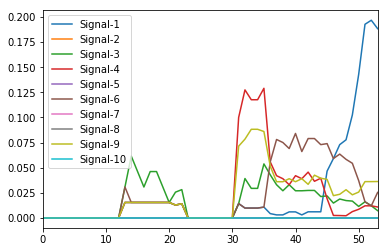

Topics Terms for MsStaceyK


Topic Number                    Topic Terms                    
0         1       bridge, pork, cici, walk, gunning, chrisette, ...
1         2                                   sexy, nah, num, keysh
2         3                     take_a_nap, girl, ur, shit, wedding
3         4       body, sending, rhi, missed, zone, prayers, tea...
4         5       dont, cd, hair, bring, corrupt, rib, brb, popp...
5         6       ass, chestnut, basketball, eating, hated, song...
6         7       keyshia, love, monica, cherry, mo, creativity,...
7         8       het, tix, ty, tv, boston, face, seas, thick, b...
8         9       album, hurting, deathly, beyonce, sucks, enter...
9        10       heart, compare, bricks, sigh, fuck, nail, laug...
10       11       week, brown, hills, reaction, wake, leaves, ye...
11       12       boris, staying, bible, carter, limits, package...
12       13             , version, damn, tony, watched, gospel, day
13       14       brave, jonus, clinic, college, messy, corner, ...
14       15       shop, heard, yuck, happen, selfish, fails, abd...
15       16       summer, wtf, deep, jump, trouble, yay, sunday,...
16       17       ad, hook, homie, sing, thier, sounds, trust, f...
17       18       devils, laptop, dudes, produced, diff, devil, ...
18       19       insurance, cuss, garbage, bb, initially, phone...
19       20       safe, hit, miami, drink, trip, call, yorker, w...
20       21       major, family, played, yea, esle, skin, mind, ...
21       22       sharing, develop, sick, people, country, wait,...
22       23       ladies, flower, club, nan, sooo, single, overr...
23       24              shady, lol, video, experience, kinda, hood
24       25                                  dance, ready, congrats

Seeded Terms Per Topic for MsStaceyK


Topic Number             Seed Terms:Count           
0   signal_9    hell:71, hurting:14, deathly:8, dead:9
1   signal_1                                   bored:4
2   signal_3                             take_a_nap:14
3   signal_4                                  tired:18
4   signal_6                         hated:8, worst:14

Topics Probabilties Over Time for dontforgetchaos


Time Period         Signal-1   Signal-2   Signal-3   Signal-4   \
0   18/04/2009 - 18/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
1   14/05/2009 - 14/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
2   14/05/2009 - 14/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
3   14/05/2009 - 14/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
4   14/05/2009 - 14/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
5   14/05/2009 - 18/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
6   14/05/2009 - 18/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
7   14/05/2009 - 18/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
8   14/05/2009 - 18/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
9   14/05/2009 - 22/05/2009  0.0163934  0.0163934  0.0163934  0.0491803   
10  14/05/2009 - 22/05/2009  0.0163934  0.0163934  0.0163934  0.0327869   
11  14/05/2009 - 22/05/2009  0.0163934  0.0163934  0.0163934  0.0163934   
12  14/05/2009 - 22/05/2009  0.0163934  0.0163934  0.0163934  0.0163934   
13  14/05/2009 - 22/05/2009  0.0163934  0.0163934  0.0163934  0.0163934   
14  14/05/2009 - 22/05/2009  0.0163934  0.0163934  0.0163934  0.0327869   
15  18/05/2009 - 22/05/2009  0.0000000  0.0000000  0.0000000  0.0000000   
16  18/05/2009 - 29/05/2009  0.0113636  0.0113636  0.0113636  0.0568182   
17  18/05/2009 - 30/05/2009  0.0109290  0.0163934  0.0054645  0.0163934   
18  18/05/2009 - 31/05/2009  0.0091743  0.0137615  0.0091743  0.0366972   
19  22/05/2009 - 01/06/2009  0.0288809  0.0072202  0.0036101  0.0613718   
20  22/05/2009 - 02/06/2009  0.0365449  0.0066445  0.0066445  0.0398671   
21  22/05/2009 - 03/06/2009  0.0644172  0.0061350  0.0030675  0.0460123   
22  22/05/2009 - 04/06/2009  0.0808383  0.0059880  0.0029940  0.0508982   
23  29/05/2009 - 05/06/2009  0.0789474  0.0058480  0.0175439  0.0555556   
24  29/05/2009 - 06/06/2009  0.0734597  0.0047393  0.0236967  0.0402844   
25  29/05/2009 - 07/06/2009  0.0543933  0.0104603  0.0251046  0.0418410   
26  29/05/2009 - 07/06/2009  0.0543933  0.0083682  0.0251046  0.0543933   
27  29/05/2009 - 07/06/2009  0.0543933  0.0062762  0.0355649  0.0460251   
28  29/05/2009 - 07/06/2009  0.0606695  0.0041841  0.0251046  0.0523013   
29  29/05/2009 - 07/06/2009  0.0627615  0.0041841  0.0251046  0.0460251   
30  30/05/2009 - 07/06/2009  0.0612245  0.0068027  0.0294785  0.0362812   
31  31/05/2009 - 07/06/2009  0.0809249  0.0028902  0.0289017  0.0606936   
32  01/06/2009 - 07/06/2009  0.0868167  0.0032154  0.0450161  0.0514469   
33  02/06/2009 - 15/06/2009  0.0818182  0.0818182  0.0424242  0.0484848   
34  03/06/2009 - 16/06/2009  0.0557276  0.0928793  0.0526316  0.0402477   
35  04/06/2009 - 17/06/2009  0.0289389  0.1028939  0.0514469  0.0289389   
36  05/06/2009 - 18/06/2009  0.0060976  0.1250000  0.0579268  0.0274390   
37  06/06/2009 - 19/06/2009  0.0027100  0.1300813  0.0542005  0.0243902   
38  07/06/2009 - 20/06/2009  0.0030581  0.1345566  0.0397554  0.0428135   
39  15/06/2009 - 21/06/2009  0.0034014  0.1598639  0.0510204  0.0578231   
40  15/06/2009 - 21/06/2009  0.0034014  0.1598639  0.0476190  0.0510204   
41  15/06/2009 - 23/06/2009  0.0032362  0.1650485  0.0453074  0.0614887   
42  15/06/2009 - 24/06/2009  0.0030395  0.1550152  0.0455927  0.0638298   

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9   Signal-10  
0      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
1      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
2      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
3      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
4      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
5      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
6      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
7      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
8      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
9      0.0       0.0    0.04

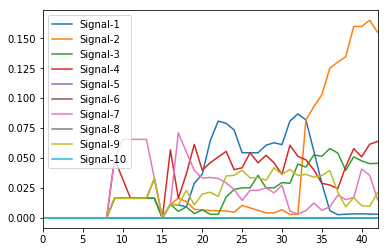

Topics Terms for dontforgetchaos


Topic Number                    Topic Terms                    
0         1       shop, cheese, kebab, ewww, burger, toast, wet,...
1         2       heavy, sob, rabbits, africa, revamp, rip, mayh...
2         3       sleep_in, bottom, neck, normal, needy, safe, n...
3         4       lazy, lost, tired, work, morning, bad, germany...
4         5       gaskit, yeah, goodness, aaashr, huge, rebuild,...
5         6       ive, good, form, edinburgh, mind, spys, ohhh, ...
6         7       booked, feel, transfer, arms, freezer, confuse...
7         8       dad, fantastic, allowed, regret, quivering, fa...
8         9       lifted, people, dead, shame, time, sneaking, h...
9        10       join, ooooh, fault, month, inflammed, tendons,...
10       11       ka, land, hide, passers, pear, tooo, random, c...
11       12       , beautiful, wall, dreaming, domestic, deep, i...
12       13       summer, coffee, meadow, nah, deodorant, beggin...
13       14       restore, sniffle, tea, highly, yep, smells, fa...
14       15       years, enclosed, replies, ready, chicken, twit...
15       16       enjoy, week, great, working, twitter, drink, l...
16       17       shoulders, pushing, shortly, britney, cat, pea...
17       18       household, mabels, festivals, pathetic, clingy...
18       19       windy, merc, recovery, seconds, sun, tree, pum...
19       20       pitty, fooking, cure, news, cold, cream, force...
20       21       inn, kings, sounds, nights, start, lake, faile...
21       22       head, love, photo, hum, bloody, aussie, sleep,...
22       23       funny, style, learnt, popcorns, mortgage, yasm...
23       24       managed, dump, torch, rest, sympathy, attitude...
24       25       gastric, tissues, dont, aldershite, earlier, s...

Seeded Terms Per Topic for dontforgetchaos


Topic Number            Seed Terms:Count           
0   signal_9    hell:37, injury:14, bleed:14, dead:14
1   signal_1                     boring:14, apathy:14
2   signal_3                      sleep_in:4, awake:7
3   signal_2                  miserable:6, bad_day:14
4   signal_4                        lazy:14, tired:20
5   signal_7                              confused:14

Topics Probabilties Over Time for keza34


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
1   20/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
2   21/04/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
3   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
4   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
5   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
6   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
7   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
8   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
13  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
14  03/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
15  04/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
16  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
22  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
23  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
24  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
25  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
26  17/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
27  17/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
28  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
29  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
30  29/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
31  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
32  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
33  29/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
34  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
35  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
36  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0130719     0.0       0.0    0.0196078     0.0     
1   0.0271739     0.0       0.0    0.0217391     0.0     
2   0.0147783     0.0       0.0    0.0492611     0.0     
3   0.0105820     0.0       0.0    0.0264550     0.0     
4   0.0052910     0.0       0.0    0.0158730     0.0     
5   0.0158730     0.0       0.0    0.0317460     0.0     
6   0.0105820     0.0       0.0    0.0476190     0.0     
7   0.0052910     0.0       0.0    0.0582011     0.0     
8   0.1355311     0.0       0.0    0.0512821     0.0     
9   0.1172161     0.0       0.0    0.0622711     0.0     
10  0.0952381     0.0       0.0    0.0439560     0.0     
11  0.1135531     0.0       0.0    0.0769231     0.0     
12  0.1190476     0.0       0.0    0.0476190     0.0     
13  0.0952381     0.0       0.0    0.0578231     0.0     
14  0.1483051     0.0       0.0    0.0084746     0.0     
15

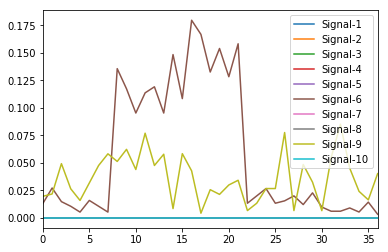

Topics Terms for keza34


Topic Number                    Topic Terms                    
0         1       shoppin, vodka, yea, tea, doin, choke, rest, s...
1         2       nudge, alcohol, garland, drunk, fibber, rule, ...
2         4       forget, doll, woman, happen, blow, rainbow, wi...
3         5       enjoy, upsetyou, feel, chip, walk, wash, pubs,...
4         6       metro, twitter, soyay, iter, shame, afternoon,...
5         7       work, ready, sounds, worry, plays, posh, flatt...
6         8       deforestation, matter, summer, button, league,...
7         9                                      hell, teasing, die
8        10       ac, acts, broke, chinese, xmas, radio, gang, r...
9        11                              pit, isnt, good, nan, hope
10       12       love, al, feet, tweeted, hate, shining, tryin,...
11       13       function, hows, dont, sun, prefer, tears, hour...
12       14       twitterverse, anythin, mood, shiny, minutes, l...
13       15       website, managed, question, bedroom, eyes, whe...
14       16                                                    cute
15       17       ladies, rainin, computer, comedian, yep, nowad...
16       18       tickets, week, busy, start, ages, bed, saturda...
17       19       blue, trek, group, nowi, studying, son, lunch,...
18       20                                                     lol
19       21       kno, dm, daughter, family, aboyt, fault, cockt...
20       22       naughty, naan, devil, swines, things, weekends...
21       23               drink, food, coz, morning, yum, defo, day
22       24       showin, win, pic, meltin, follow, enjoyin, thu...
23       25       dad, quietly, shoes, fair, mirror, halloween, ...

Seeded Terms Per Topic for keza34


Topic Number Seed Terms:Count
0   signal_9    hell:14, die:9 
1   signal_6           shame:9

Topics Probabilties Over Time for MTVnHollyWEST23


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   11/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
1   16/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
2   16/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
3   16/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
4   16/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
5   16/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
6   17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
7   18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
8   30/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
9   30/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
10  30/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
11  30/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
12  30/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
13  30/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
14  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0051020     0.0       0.0    0.0153061     0.0     
1   0.0053763     0.0       0.0    0.0053763     0.0     
2   0.0053763     0.0       0.0    0.0107527     0.0     
3   0.0053763     0.0       0.0    0.0161290     0.0     
4   0.0053763     0.0       0.0    0.0053763     0.0     
5   0.0053763     0.0       0.0    0.0053763     0.0     
6   0.0092593     0.0       0.0    0.0046296     0.0     
7   0.0077220     0.0       0.0    0.0386100     0.0     
8   0.0037037     0.0       0.0    0.0037037     0.0     
9   0.0027548     0.0       0.0    0.0110193     0.0     
10  0.0025907     0.0       0.0    0.0051813     0.0     
11  0.0025575     0.0       0.0    0.0025575     0.0     
12  0.0089485     0.0       0.0    0.0268456     0.0     
13  0.0533175     0.0       0.0    0.0793839     0.0     
14  0.0594059     0.0       0.0    0.0742574     0.0

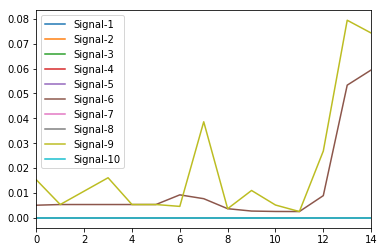

Topics Terms for MTVnHollyWEST23


Topic Number                    Topic Terms                    
0         1       forget, errbody, goiing, hair, church, lookz, ...
1         2       ive, hunnit, defeatz, thingy, bball, djz, wel,...
2         3       dont, twitter, pic, cassie, sadly, luv, getz, ...
3         4       outta, win, scared, clubx, yayyy, love, flashb...
4         5       thizzz, ppl, shape, cuzzin, nephew, hollywest,...
5         6       tat, luckett, porn, unfair, swagg, shame, jayz...
6         7       hunny, tommorow, please, age, heartlezz, cuz, ...
7         8       work, krush, bring, radio, watched, cuteee, pr...
8         9       listen, twitterrr, queen, kill, hell, beatz, w...
9        10       tired, feel, money, glass, walk, wit, itz, pic...
10       11       , despise, celebz, stream, streaming, bite, ne...
11       12       summer, shoes, tag, betta, veejay, doesnt, pol...
12       13       ashame, stat, eggz, booty, icon, thiz, allergi...
13       14       ugh, alex, move, bad, side, game, num, uhhh, b...
14       15       exotic, cute, cmon, immma, mannn, played, bost...
15       16       heart, kylez, purse, sleep, whyyy, mmorrow, fu...
16       17       raining, talkerz, hypez, height, messed, pause...
17       18       ladies, word, boobz, pet, pay, gym, myspace, h...
18       19       meant, swag, iz, nicenezz, lost, house, half, ...
19       20       moore, yearz, errwherr, polish, chicken, gon, ...
20       21       walking, sad, sibling, kobe, check, shuxx, che...
21       22       biggg, lol, wake, york, damn, yippee, correct,...
22       23       fly, pink, counting, dude, ki, sucks, forreal,...
23       24       lance, fair, upset, chip, whatz, shinez, dough...
24       25       month, heelz, single, rams, kev, suffer, shit,...

Seeded Terms Per Topic for MTVnHollyWEST23


Topic Number        Seed Terms:Count       
0   signal_1                         boring:6
1   signal_9    hell:2, doa:4, kill:3, hurt:3
2   signal_4                          tired:2
3   signal_6                 shame:2, gross:1

Topics Probabilties Over Time for mrs_mcsupergirl


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   03/05/2009 - 09/05/2009  0.0000000     0.0       0.0    0.0000000   
1   09/05/2009 - 09/05/2009  0.0000000     0.0       0.0    0.0000000   
2   09/05/2009 - 18/05/2009  0.0000000     0.0       0.0    0.0000000   
3   09/05/2009 - 18/05/2009  0.0000000     0.0       0.0    0.0000000   
4   09/05/2009 - 18/05/2009  0.0000000     0.0       0.0    0.0000000   
5   09/05/2009 - 18/05/2009  0.0000000     0.0       0.0    0.0000000   
6   09/05/2009 - 22/05/2009  0.0000000     0.0       0.0    0.0000000   
7   18/05/2009 - 22/05/2009  0.0000000     0.0       0.0    0.0000000   
8   18/05/2009 - 22/05/2009  0.0000000     0.0       0.0    0.0000000   
9   18/05/2009 - 22/05/2009  0.0000000     0.0       0.0    0.0000000   
10  18/05/2009 - 26/05/2009  0.0200000     0.0       0.0    0.1000000   
11  18/05/2009 - 26/05/2009  0.0400000     0.0       0.0    0.1000000   
12  18/05/2009 - 28/05/2009  0.0163934     0.0       0.0    0.1147541   
13  18/05/2009 - 29/05/2009  0.0743243     0.0       0.0    0.0608108   
14  18/05/2009 - 30/05/2009  0.0578231     0.0       0.0    0.0238095   
15  18/05/2009 - 31/05/2009  0.0565553     0.0       0.0    0.0257069   
16  22/05/2009 - 01/06/2009  0.0563063     0.0       0.0    0.0292793   
17  22/05/2009 - 02/06/2009  0.0782241     0.0       0.0    0.0274841   
18  22/05/2009 - 03/06/2009  0.0477178     0.0       0.0    0.0269710   
19  22/05/2009 - 04/06/2009  0.0616016     0.0       0.0    0.0266940   
20  26/05/2009 - 05/06/2009  0.0554493     0.0       0.0    0.0229446   
21  26/05/2009 - 06/06/2009  0.0502431     0.0       0.0    0.0307942   
22  26/05/2009 - 07/06/2009  0.0490342     0.0       0.0    0.0252600   

    Signal-5   Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
1   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
2   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
3   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
4   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
5   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
6   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
7   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
8   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
9   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
10  0.0200000  0.0200000     0.0       0.0    0.0400000     0.0     
11  0.0200000  0.0200000     0.0       0.0    0.0400000     0.0     
12  0.0163934  0.0163934     0.0       0.0    0.0819672     0.0     
13  0.0472973  0.0540541     0.0       0.0    0.0878378     0.0     
14  0.0476190  0.0612245     0.0       0.0    0.0952381     0.0     
15  0.0514139  0.0539846     0.0       0.0    0.0668380     0.0     
16  0.0540541  0.0495495     0.0       0.0    0.0608108     0.0     
17  0.0613108  0.0549683     0.0       0.0    0.0507400     0.0     
18  0.0622407  0.0456432     0.0       0.0    0.0518672     0.0     
19  0.0636550  0.0492813     0.0       0.0    0.0554415     0.0     
20  0.0573614  0.0535373     0.0       0.0    0.0630975     0.0     
21  0.0583468  0.0372771     0.0       0.0    0.0599676     0.0     
22  0.0653789  0.0356612     0.0       0.0    0.0713224     0.0

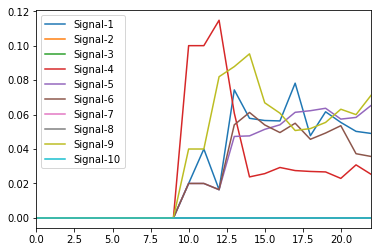

Topics Terms for mrs_mcsupergirl


Topic Number                    Topic Terms                    
0         1       closer, cute, escaping, clean, students, ahh, ...
1         2       chapter, brown, crazy, lived, computer, relati...
2         3       meant, lookin, forever, kinda, deleted, money,...
3         4       kb, bastard, crap, tiredness, screw, gargh, se...
4         5       yeah, guy, bucks, thinks, huge, littered, seae...
5         6       ass, fuzzbutt, freak, piece_of_shit, sitting, ...
6         7       heart, whut, intimidating, venues, chat, artic...
7         8       collecting, play, hug, pick, bring, breed, wor...
8         9       bridge, someday, donnie, midnight, fail, ftw, ...
9        10       coffee, fur, concert, cruises, aww, tweetdeck,...
10       11       mike, hoping, calls, missing, feel, memo, reac...
11       12       sound, love, missed, shit, dance, jar, pic, bu...
12       13       shoot, head, lick, lost, cancer, potato, days,...
13       14       uber, ugh, pig, hahahahah, ready, cramps, nm, ...
14       15       troll, awesomest, hoopdees, flail, sticker, oo...
15       16       picture, danny, eye, shirt, bb, buffett, weak,...
16       17       year, walk, tshirt, num, fake, yep, icons, que...
17       18       loved, nk, fukkin, song, wow, safe, matters, g...
18       19       people, awesome, wil, tonight, quotes, catchin...
19       20       , story, prize, follwers, haus, sad, attack, t...
20       21       blue, poor, girly, service, tease, dude, submi...
21       22       busy, working, sucks, sick, eeeckie, atupid, w...
22       23       jimmy, darnit, msgs, trend, share, tag, stalke...
23       24           big, cuz, send, pics, vacation, fuck, twitpic
24       25       great, chapstix, contest, pictures, tweet, cha...

Seeded Terms Per Topic for mrs_mcsupergirl


Topic Number          Seed Terms:Count         
0   signal_1                                meh:8
1   signal_9                                die:2
2   signal_5                               fat:10
3   signal_4                         tiredness:13
4   signal_6    ugly:19, worst:1, piece_of_shit:8

Topics Probabilties Over Time for tallivansunder


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   18/04/2009 - 20/04/2009     0.0       0.0    0.0307692     0.0     
1   19/04/2009 - 02/05/2009     0.0       0.0    0.0000000     0.0     
2   20/04/2009 - 03/05/2009     0.0       0.0    0.0196078     0.0     
3   02/05/2009 - 03/05/2009     0.0       0.0    0.0612245     0.0     
4   02/05/2009 - 03/05/2009     0.0       0.0    0.0204082     0.0     
5   02/05/2009 - 03/05/2009     0.0       0.0    0.0204082     0.0     
6   02/05/2009 - 03/05/2009     0.0       0.0    0.0204082     0.0     
7   02/05/2009 - 03/05/2009     0.0       0.0    0.0408163     0.0     
8   02/05/2009 - 09/05/2009     0.0       0.0    0.0129870     0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0    0.0114943     0.0     
10  02/05/2009 - 11/05/2009     0.0       0.0    0.0105263     0.0     
11  02/05/2009 - 11/05/2009     0.0       0.0    0.0210526     0.0     
12  02/05/2009 - 11/05/2009     0.0       0.0    0.0105263     0.0     
13  02/05/2009 - 11/05/2009     0.0       0.0    0.0210526     0.0     
14  02/05/2009 - 11/05/2009     0.0       0.0    0.0210526     0.0     
15  03/05/2009 - 16/05/2009     0.0       0.0    0.0183486     0.0     
16  09/05/2009 - 17/05/2009     0.0       0.0    0.0100000     0.0     
17  09/05/2009 - 17/05/2009     0.0       0.0    0.0200000     0.0     
18  09/05/2009 - 17/05/2009     0.0       0.0    0.0100000     0.0     
19  09/05/2009 - 17/05/2009     0.0       0.0    0.0100000     0.0     
20  09/05/2009 - 17/05/2009     0.0       0.0    0.0100000     0.0     
21  09/05/2009 - 22/05/2009     0.0       0.0    0.0192308     0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0    0.0263158     0.0     
23  11/05/2009 - 22/05/2009     0.0       0.0    0.0151515     0.0     
24  16/05/2009 - 22/05/2009     0.0       0.0    0.0000000     0.0     
25  16/05/2009 - 26/05/2009     0.0       0.0    0.0142857     0.0     
26  16/05/2009 - 26/05/2009     0.0       0.0    0.0142857     0.0     
27  16/05/2009 - 28/05/2009     0.0       0.0    0.0232558     0.0     
28  16/05/2009 - 29/05/2009     0.0       0.0    0.0162602     0.0     
29  17/05/2009 - 30/05/2009     0.0       0.0    0.0194805     0.0     
30  22/05/2009 - 31/05/2009     0.0       0.0    0.0054348     0.0     
31  22/05/2009 - 01/06/2009     0.0       0.0    0.0081301     0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0    0.0555556     0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0    0.0702341     0.0     
34  22/05/2009 - 04/06/2009     0.0       0.0    0.0555556     0.0     
35  26/05/2009 - 05/06/2009     0.0       0.0    0.0612245     0.0     
36  26/05/2009 - 06/06/2009     0.0       0.0    0.0634146     0.0     
37  26/05/2009 - 07/06/2009     0.0       0.0    0.0547368     0.0     
38  26/05/2009 - 07/06/2009     0.0       0.0    0.0568421     0.0     
39  28/05/2009 - 07/06/2009     0.0       0.0    0.0626350     0.0     
40  28/05/2009 - 07/06/2009     0.0       0.0    0.0604752     0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0    0.0559284     0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0    0.0536585     0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0    0.0679887     0.0     
44  01/06/2009 - 07/06/2009     0.0       0.0    0.0906250     0.0     
45  02/06/2009 - 15/06/2009     0.0       0.0    0.0670927     0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0    0.0212766     0.0     
47  04/06/2009 - 16/06/2009     0.0       0.0    0.0184502     0.0     
48  05/06/2009 - 16/06/2009     0.0       0.0    0.0075758     0.0     
49  06/06/2009 - 19/06/2009     0.0       0.0    0.0043478     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4     

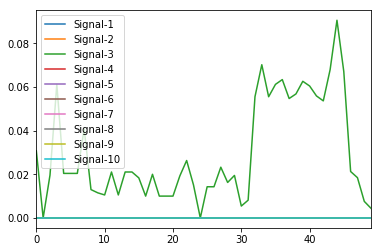

Topics Terms for tallivansunder


Topic Number                    Topic Terms                    
0         1       woman, love, workout, lol, plan, making, tomorrow
1         2                                               ship, son
2         3       steel, thing, fully, recuperate, vacation, dai...
3         4       naps, hmmm, lots, luckily, fatima, eats, amazi...
4         5       shop, cute, apple, wash, gala, picked, quality...
5         6       core, btw, grew, abdominal, weight, pancakes, ...
6         7        wheat, healthy, bed, goodnight, sprouted, dreams
7         8       family, twitter, tonight, sea, thinking, sites...
8         9                 dishes, fav, cheers, sleep, rudy, legos
9        10                                            pre, talking
10       11       road, story, sandwich, mix, vegetables, cloth,...
11       12       late, washing, aerobic, wait, recording, num, ...
12       13                                 guess, evening, retweet
13       14       thought, question, nan, idea, mark, helped, tu...
14       15       cut, tea, favorite, hosting, dog, hours, plann...
15       16       enjoy, finish, cup, boker, tov, rooibos, fast,...
16       17       splurge, kind, months, forward, almond, hot, p...
17       18       darjeeling, yay, working, salad, hummus, fulfi...
18       19                            happy, warm, friday, morning
19       20       beautiful, charles, tazo, sleeping, colors, ch...
20       21                               good, understandable, day
21       22       shooting, organic, slices, tv, sweet, free, sp...
22       23                     week, picture, bad, bacon, broccoli
23       24       party, blueberries, tired, wow, work, year, oa...
24       25       great, talked, promo, fish, night, vegetable, ...

Seeded Terms Per Topic for tallivansunder


Topic Number Seed Terms:Count
0   signal_3    go_to_sleep:14

Topics Probabilties Over Time for 19fischi75


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   14/05/2009 - 26/05/2009  0.0000000     0.0       0.0    0.0000000   
1   17/05/2009 - 26/05/2009  0.0000000     0.0       0.0    0.0000000   
2   17/05/2009 - 29/05/2009  0.0086580     0.0       0.0    0.0043290   
3   17/05/2009 - 29/05/2009  0.0043290     0.0       0.0    0.0086580   
4   26/05/2009 - 31/05/2009  0.0039526     0.0       0.0    0.0079051   
5   26/05/2009 - 01/06/2009  0.0038462     0.0       0.0    0.0230769   
6   26/05/2009 - 02/06/2009  0.0066890     0.0       0.0    0.0200669   
7   26/05/2009 - 03/06/2009  0.0031056     0.0       0.0    0.0372671   
8   26/05/2009 - 03/06/2009  0.0155280     0.0       0.0    0.0434783   
9   26/05/2009 - 05/06/2009  0.0471464     0.0       0.0    0.0198511   
10  26/05/2009 - 05/06/2009  0.0347395     0.0       0.0    0.0297767   
11  26/05/2009 - 07/06/2009  0.0510949     0.0       0.0    0.0267640   
12  26/05/2009 - 07/06/2009  0.0486618     0.0       0.0    0.0243309   
13  29/05/2009 - 07/06/2009  0.0463415     0.0       0.0    0.0414634   
14  29/05/2009 - 07/06/2009  0.0414634     0.0       0.0    0.0390244   
15  29/05/2009 - 07/06/2009  0.0414634     0.0       0.0    0.0317073   
16  31/05/2009 - 07/06/2009  0.0751174     0.0       0.0    0.0563380   
17  31/05/2009 - 07/06/2009  0.0938967     0.0       0.0    0.0563380   
18  01/06/2009 - 07/06/2009  0.1092896     0.0       0.0    0.0546448   
19  02/06/2009 - 15/06/2009  0.0970874     0.0       0.0    0.0533981   
20  03/06/2009 - 16/06/2009  0.0943396     0.0       0.0    0.0471698   
21  05/06/2009 - 16/06/2009  0.0952381     0.0       0.0    0.0370370   
22  05/06/2009 - 18/06/2009  0.0576923     0.0       0.0    0.0230769   
23  07/06/2009 - 18/06/2009  0.0111732     0.0       0.0    0.0167598   
24  07/06/2009 - 20/06/2009  0.0054054     0.0       0.0    0.0054054   
25  15/06/2009 - 20/06/2009  0.0056497     0.0       0.0    0.0056497   
26  15/06/2009 - 20/06/2009  0.0056497     0.0       0.0    0.0056497   
27  15/06/2009 - 23/06/2009  0.0052910     0.0       0.0    0.0052910   
28  15/06/2009 - 23/06/2009  0.0052910     0.0       0.0    0.0052910   
29  15/06/2009 - 25/06/2009  0.0086957     0.0       0.0    0.0043478   

    Signal-5  Signal-6  Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0       0.0       0.0    0.0000000     0.0       0.0     
1      0.0       0.0       0.0    0.0000000     0.0       0.0     
2      0.0       0.0       0.0    0.0606061     0.0       0.0     
3      0.0       0.0       0.0    0.0649351     0.0       0.0     
4      0.0       0.0       0.0    0.0869565     0.0       0.0     
5      0.0       0.0       0.0    0.0730769     0.0       0.0     
6      0.0       0.0       0.0    0.0869565     0.0       0.0     
7      0.0       0.0       0.0    0.0869565     0.0       0.0     
8      0.0       0.0       0.0    0.0807453     0.0       0.0     
9      0.0       0.0       0.0    0.0992556     0.0       0.0     
10     0.0       0.0       0.0    0.1017370     0.0       0.0     
11     0.0       0.0       0.0    0.0827251     0.0       0.0     
12     0.0       0.0       0.0    0.1046229     0.0       0.0     
13     0.0       0.0       0.0    0.0951220     0.0       0.0     
14     0.0       0.0       0.0    0.0975610     0.0       0.0     
15     0.0       0.0       0.0    0.0902439     0.0       0.0     
16     0.0       0.0       0.0    0.1502347     0.0       0.0     
17     0.0       0.0       0.0    0.1408451     0.0       0.0     
18     0.0       0.0       0.0    0.1202186     0.0       0.0     
19     0.0       0.0       0.0    0.0873786     0.0       0.0     
20     0.0       0.0       0.0    0.0613208     0.0       0.0     
21     0.0       0.0       0.0    0.0423280     0.0       0.0     
22     0.0       0.0       0.0    0.0653846     0.0       0.0     
23     0.0       0.0       0.0    0.0055866     0.0       0.0     
24     0.0       0.0       0.0    0.0054054     0.0       0.0     
25 

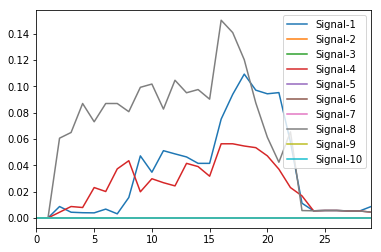

Topics Terms for 19fischi75


Topic Number                    Topic Terms                    
0         1       buuut, meeean, farm, lill, trinking, mucho, le...
1         2                 room, cowboy, sleep, girl, dreams, care
2         3       sooo, sunny, tonight, computer, crying, hmmm, ...
3         4                    waiting, weasel, missed, hope, tired
4         5                                 making, bit, understand
5         6       great, hug, chosen, sunshine, kisses, parents,...
6         7                                                     num
7         8       wanted, song, lots, big, angry, work, annoying...
8         9                   horror, hear, dont, debilitated, dart
9        10       party, kind, usd, uncertain, person, tv, bus, ...
10       11       ive, busy, begged, heeey, cinema, hm, messages...
11       12                                      eyes, lot, morning
12       13       appartment, hair, middle, plays, nickname, nan...
13       14                         coffee, sky, rainy, clip, lucky
14       15       week, working, starts, days, homecleaning, did...
15       16       guess, good, office, shocked, sad, dark, bad, ...
16       17       beautiful, feeling, problems, pet, sun, please...
17       18                                         batteries, year
18       19       box, loss, hihihihihi, word, state, poor, slee...
19       21       raining, walking, oversleep, absolutely, sweet...
20       22       teen, evening, hide, goodbye, dvd, blanket, fi...
21       23       trink, love, shopping, car, forgive, rest, dri...
22       24       sunglasses, funny, lemon, wooow, luv, shy, tre...
23       25       dad, picture, afraid, sparkle, feel, weekend, ...

Seeded Terms Per Topic for 19fischi75


Topic Number    Seed Terms:Count   
0   signal_1                 bored:14
1   signal_8    angry:14, annoying:14
2   signal_4                 tired:14

Topics Probabilties Over Time for michxxblc


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   06/04/2009 - 19/04/2009  0.0200000     0.0       0.0    0.0100000   
1   07/04/2009 - 19/04/2009  0.0119048     0.0       0.0    0.0119048   
2   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
3   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
4   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
5   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
6   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
7   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
8   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
9   18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
10  18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
11  18/04/2009 - 19/04/2009  0.0128205     0.0       0.0    0.0128205   
12  18/04/2009 - 01/05/2009  0.0112360     0.0       0.0    0.0112360   
13  19/04/2009 - 02/05/2009  0.0133333     0.0       0.0    0.0133333   
14  01/05/2009 - 03/05/2009  0.0175439     0.0       0.0    0.0175439   
15  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
16  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
17  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
18  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
19  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
20  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
21  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
22  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
23  01/05/2009 - 04/05/2009  0.0131579     0.0       0.0    0.0131579   
24  01/05/2009 - 13/05/2009  0.0119048     0.0       0.0    0.0119048   
..                      ...        ...       ...       ...        ...   
41  17/05/2009 - 30/05/2009  0.0106952     0.0       0.0    0.0053476   
42  18/05/2009 - 31/05/2009  0.0437500     0.0       0.0    0.0125000   
43  28/05/2009 - 01/06/2009  0.0753425     0.0       0.0    0.0068493   
44  28/05/2009 - 02/06/2009  0.1515152     0.0       0.0    0.0060606   
45  28/05/2009 - 03/06/2009  0.1479290     0.0       0.0    0.0059172   
46  28/05/2009 - 04/06/2009  0.1569767     0.0       0.0    0.0174419   
47  28/05/2009 - 05/06/2009  0.1279621     0.0       0.0    0.0047393   
48  28/05/2009 - 06/06/2009  0.1124031     0.0       0.0    0.0038760   
49  28/05/2009 - 06/06/2009  0.1124031     0.0       0.0    0.0038760   
50  28/05/2009 - 06/06/2009  0.1046512     0.0       0.0    0.0077519   
51  28/05/2009 - 06/06/2009  0.1007752     0.0       0.0    0.0038760   
52  28/05/2009 - 06/06/2009  0.1124031     0.0       0.0    0.0077519   
53  29/05/2009 - 06/06/2009  0.1290323     0.0       0.0    0.0040323   
54  30/05/2009 - 06/06/2009  0.1290323     0.0       0.0    0.0046083   
55  31/05/2009 - 06/06/2009  0.1465969     0.0       0.0    0.0052356   
56  01/06/2009 - 06/06/2009  0.1608392     0.0       0.0    0.0069930   
57  02/06/2009 - 15/06/2009  0.0850000     0.0       0.0    0.1250000   
58  03/06/2009 - 16/06/2009  0.0256410     0.0       0.0    0.1589744   
59  04/06/2009 - 17/06/2009  0.0203046     0.0       0.0    0.1573604   
60  05/06/2009 - 18/06/2009  0.0092593     0.0       0.0    0.1851852   
61  06/06/2009 - 19/06/2009  0.0222222     0.0       0.0    0.2388889   
62  15/06/2009 - 19/06/2009  0.0150376     0.0       0.0    0.3383459   
63  15/06/2009 - 19/06/2009  0.0150376     0.0       0.0    0.3308271   
64  15/06/2009 - 22/06/2009  0.0074627     0.0       0.0    0.3208955   
65  15/06/2009 - 23/06/2009  0.0067114     0.0       0.0    0.3020134   

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0    

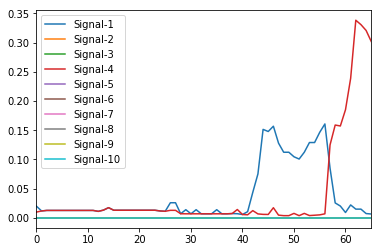

Topics Terms for michxxblc


Topic Number                    Topic Terms                    
0         1       menudo, newspaper, great, bored, love, song, y...
1         2       kisses, convos, year, breakfast, kissed, hate,...
2         3                            fun, tonight, omg, yep, nice
3         4       snaaap, figure, tired, exhausted, text, neglec...
4         5       ddub, looong, mornin, anythin, service, wow, m...
5         6       called, gooo, cloudy, laughing, thought, omfg,...
6         7                                               num, yeah
7         8       facetime, cute, click, tix, deserve, tweet, bo...
8         9       listenin, raining, full, call, aww, work, vip,...
9        10       process, assholes, idea, alive, yeaaah, lolol,...
10       11       summer, blockheads, reeeally, wooot, acting, h...
11       12              pictures, donnie, bad, earth, counts, care
12       13                                                        
13       14                                             watch, haha
14       15       sexiness, eileen, sadly, center, jealous, drun...
15       16       cuuute, picture, dm, loved, awesome, worried, ...
16       17                                                nan, lol
17       18                          bp, sucks, twitter, good, sooo
18       19       fool, night, watching, cruise, sweet, rob, che...
19       20       momma, pepto, settle, talked, catch, funny, no...
20       21       opinions, boston, cheap, chat, pass, hmmm, bus...
21       22                                      making, usb, happy
22       23                                            girl, layout
23       24       michelle, holla, interesting, people, hmm, pla...
24       25       crazy, wichita, concord, god, stuck, commercia...

Seeded Terms Per Topic for michxxblc


Topic Number    Seed Terms:Count  
0   signal_1                bored:14
1   signal_4    exhausted:9, tired:9

Topics Probabilties Over Time for KevinEdwardsJr


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
1   16/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
2   16/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
3   16/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
4   16/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
5   16/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
6   16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
7   16/05/2009 - 23/05/2009     0.0       0.0       0.0       0.0       0.0     
8   16/05/2009 - 23/05/2009     0.0       0.0       0.0       0.0       0.0     
9   16/05/2009 - 25/05/2009     0.0       0.0       0.0       0.0       0.0     
10  16/05/2009 - 25/05/2009     0.0       0.0       0.0       0.0       0.0     
11  16/05/2009 - 25/05/2009     0.0       0.0       0.0       0.0       0.0     
12  16/05/2009 - 25/05/2009     0.0       0.0       0.0       0.0       0.0     
13  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
14  17/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
15  22/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
16  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
17  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
18  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
19  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
20  23/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
21  25/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
22  25/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0     
17     0.0       0.0       0.0       0.0       0.0     
18     0.0       0.0       0.0       0.0       0.0     
19     0.0       0.0       0.0       0.0       0.0     
20     0.0       0.0       0.0       0.0       0.0     
21     0.0       0.0       0.0       0.0       0.0     
22     0.0       0.0       0.0       0.0       0.0

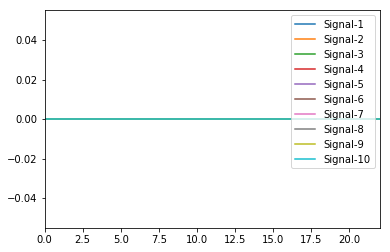

Topics Terms for KevinEdwardsJr


Topic Number   Topic Terms  
0        3                  num
1        7                 time
2        8                 love
3       14               simple
4       20       good, homiesss
5       22                 yall
6       24                laugh
7       25               follow

Seeded Terms Per Topic for KevinEdwardsJr


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for baldeggie


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   07/04/2009 - 07/04/2009     0.0    0.0000000     0.0       0.0     
1   13/05/2009 - 13/05/2009     0.0    0.0000000     0.0       0.0     
2   13/05/2009 - 13/05/2009     0.0    0.0000000     0.0       0.0     
3   13/05/2009 - 13/05/2009     0.0    0.0000000     0.0       0.0     
4   13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
5   13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
6   13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
7   13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
8   13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
9   13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
10  13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
11  13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
12  13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
13  13/05/2009 - 16/05/2009     0.0    0.0000000     0.0       0.0     
14  13/05/2009 - 26/05/2009     0.0    0.0138889     0.0       0.0     
15  16/05/2009 - 26/05/2009     0.0    0.0142857     0.0       0.0     
16  16/05/2009 - 28/05/2009     0.0    0.0103093     0.0       0.0     
17  16/05/2009 - 29/05/2009     0.0    0.0172414     0.0       0.0     
18  26/05/2009 - 30/05/2009     0.0    0.0656716     0.0       0.0     
19  26/05/2009 - 31/05/2009     0.0    0.0551378     0.0       0.0     
20  26/05/2009 - 01/06/2009     0.0    0.0665083     0.0       0.0     
21  26/05/2009 - 02/06/2009     0.0    0.0470588     0.0       0.0     
22  26/05/2009 - 03/06/2009     0.0    0.0462107     0.0       0.0     
23  26/05/2009 - 04/06/2009     0.0    0.0472855     0.0       0.0     
24  26/05/2009 - 05/06/2009     0.0    0.0414938     0.0       0.0     
25  26/05/2009 - 06/06/2009     0.0    0.0419026     0.0       0.0     
26  26/05/2009 - 07/06/2009     0.0    0.0430939     0.0       0.0     

    Signal-5  Signal-6   Signal-7   Signal-8  Signal-9   Signal-10  
0      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
1      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
2      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
3      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
4      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
5      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
6      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
7      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
8      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
9      0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
10     0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
11     0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
12     0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
13     0.0    0.0000000  0.0000000     0.0    0.0000000     0.0     
14     0.0    0.1527778  0.2500000     0.0    0.0277778     0.0     
15     0.0    0.1571429  0.2714286     0.0    0.0142857     0.0     
16     0.0    0.1340206  0.2474227     0.0    0.0412371     0.0     
17     0.0    0.1034483  0.2327586     0.0    0.0344828     0.0     
18     0.0    0.0537313  0.0805970     0.0    0.0537313     0.0     
19     0.0    0.0476190  0.0651629     0.0    0.0526316     0.0     
20     0.0    0.0546318  0.0617577     0.0    0.0356295     0.0     
21     0.0    0.0411765  0.0490196     0.0    0.0411765     0.0     
22     0.0    0.0536044  0.0517560     0.0    0.0480591     0.0     
23     0.0    0.0507881  0.0490368     0.0    0.0350263     0.0     
24     0.0    0.0387275  0.0345781     0.0    0.0304288     0.0     
25     0.0    0.0441676  0.0407701     0.0    0.0283126     0.0     
26     0.0    0.0464088  0.0287293     0.0    0.0287293     0.0

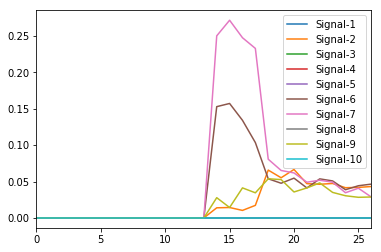

Topics Terms for baldeggie


Topic Number                    Topic Terms                    
0         1       beautiful, spy, backgroud, enhancements, cents...
1         2       vog, twitter, questions, shreds, depression, c...
2         3       insane, tatts, ankles, dump, tattoos, wall, su...
3         4       neighbors, chain, house, awesome, pic, raid, a...
4         5       mickey, gravy, clam, bankrupt, hour, win, siti...
5         6       dots, trippin, style, ahead, knew, nan, wrinkl...
6         7       clueless, cam, figure, totally, hospital, rich...
7         8       affair, awww, hoping, djsmook, driveway, ready...
8         9       cute, hu, ate, crumble, stay, die, yesterday, ...
9        10       okazuya, deah, needless, heard, depends, oven,...
10       11       ass, grrr, service, grub, gees, things, chops,...
11       12       circles, forearm, mochi, ing, hate, busy, over...
12       13       vid, mahalo, street, girl, milk, ripping, pink...
13       14                          car, washed, raining, paradise
14       15       gallon, entire, love, monday, people, shared, ...
15       16       crazy, frogs, yeah, feening, laugh, chicken, k...
16       17       botcha, scan, feel, sleeping, design, irritate...
17       18       shop, ville, bring, alcohol, summer, backing, ...
18       19       major, buy, pain, veggie, pieces, num, yah, di...
19       20       bollah, emerge, eh, weight, dead, cruise, expe...
20       21       life, manage, hit, chips, eggs, peoples, hillz...
21       22       files, abyss, woman, bold, boys, club, inked, ...
22       23       tikshi, shave, set, rip, sad, delicious, hangi...
23       24       drop, chee, sense, check, reasoning, craigslis...
24       25       tattoo, eday, catsup, hawaiian, hellish, minut...

Seeded Terms Per Topic for baldeggie


Topic Number      Seed Terms:Count     
0   signal_1                     boring:8
1   signal_9              die:8, injury:3
2   signal_2    shot_down:3, depression:3
3   signal_7                  clueless:31
4   signal_6                      worst:2

Topics Probabilties Over Time for BBRRIITTTTYY


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   02/05/2009 - 14/05/2009  0.1184211     0.0       0.0       0.0     
1   03/05/2009 - 16/05/2009  0.0268456     0.0       0.0       0.0     
2   04/05/2009 - 17/05/2009  0.0948905     0.0       0.0       0.0     
3   09/05/2009 - 18/05/2009  0.0866142     0.0       0.0       0.0     
4   09/05/2009 - 18/05/2009  0.1259843     0.0       0.0       0.0     
5   09/05/2009 - 18/05/2009  0.0551181     0.0       0.0       0.0     
6   09/05/2009 - 18/05/2009  0.0393701     0.0       0.0       0.0     
7   09/05/2009 - 22/05/2009  0.0522388     0.0       0.0       0.0     
8   10/05/2009 - 22/05/2009  0.0640000     0.0       0.0       0.0     
9   13/05/2009 - 22/05/2009  0.0631579     0.0       0.0       0.0     
10  13/05/2009 - 22/05/2009  0.0736842     0.0       0.0       0.0     
11  13/05/2009 - 26/05/2009  0.0891089     0.0       0.0       0.0     
12  14/05/2009 - 26/05/2009  0.0114943     0.0       0.0       0.0     
13  16/05/2009 - 26/05/2009  0.0493827     0.0       0.0       0.0     
14  16/05/2009 - 29/05/2009  0.0340909     0.0       0.0       0.0     
15  17/05/2009 - 30/05/2009  0.0112360     0.0       0.0       0.0     
16  18/05/2009 - 31/05/2009  0.0243902     0.0       0.0       0.0     
17  22/05/2009 - 01/06/2009  0.0306122     0.0       0.0       0.0     
18  22/05/2009 - 02/06/2009  0.0067114     0.0       0.0       0.0     
19  22/05/2009 - 03/06/2009  0.0681818     0.0       0.0       0.0     
20  22/05/2009 - 03/06/2009  0.0227273     0.0       0.0       0.0     
21  26/05/2009 - 05/06/2009  0.0603015     0.0       0.0       0.0     
22  26/05/2009 - 06/06/2009  0.0113208     0.0       0.0       0.0     
23  26/05/2009 - 07/06/2009  0.0209581     0.0       0.0       0.0     
24  26/05/2009 - 07/06/2009  0.0299401     0.0       0.0       0.0     
25  29/05/2009 - 07/06/2009  0.0030488     0.0       0.0       0.0     
26  29/05/2009 - 07/06/2009  0.0152439     0.0       0.0       0.0     
27  29/05/2009 - 07/06/2009  0.0243902     0.0       0.0       0.0     
28  30/05/2009 - 07/06/2009  0.0062305     0.0       0.0       0.0     
29  31/05/2009 - 07/06/2009  0.0258065     0.0       0.0       0.0     
30  01/06/2009 - 14/06/2009  0.0233333     0.0       0.0       0.0     
31  02/06/2009 - 15/06/2009  0.0118694     0.0       0.0       0.0     
32  03/06/2009 - 16/06/2009  0.0283912     0.0       0.0       0.0     
33  05/06/2009 - 17/06/2009  0.0066007     0.0       0.0       0.0     
34  05/06/2009 - 18/06/2009  0.0390879     0.0       0.0       0.0     
35  06/06/2009 - 19/06/2009  0.0136986     0.0       0.0       0.0     
36  07/06/2009 - 20/06/2009  0.0037453     0.0       0.0       0.0     
37  14/06/2009 - 21/06/2009  0.0344828     0.0       0.0       0.0     

    Signal-5   Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0   0.0065789     0.0       0.0       0.0       0.0       0.0     
1   0.0067114     0.0       0.0       0.0       0.0       0.0     
2   0.0218978     0.0       0.0       0.0       0.0       0.0     
3   0.0078740     0.0       0.0       0.0       0.0       0.0     
4   0.0078740     0.0       0.0       0.0       0.0       0.0     
5   0.0157480     0.0       0.0       0.0       0.0       0.0     
6   0.0157480     0.0       0.0       0.0       0.0       0.0     
7   0.0074627     0.0       0.0       0.0       0.0       0.0     
8   0.0160000     0.0       0.0       0.0       0.0       0.0     
9   0.0210526     0.0       0.0       0.0       0.0       0.0     
10  0.0105263     0.0       0.0       0.0       0.0       0.0     
11  0.0099010     0.0       0.0       0.0       0.0       0.0     
12  0.0114943     0.0       0.0       0.0       0.0       0.0     
13  0.0123457     0.0       0.0       0.0       0.0       0.0     
14  0.0113636     0.0       0.0       0.0       0.0       0.0     
15  0.0224719     0.0       0.0       0.0       0.0       0.0     
16  0.0121951     0.0       0.0       0.0       0.0       0.0

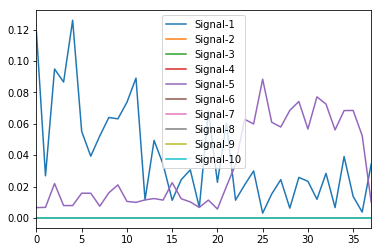

Topics Terms for BBRRIITTTTYY


Topic Number                    Topic Terms                    
0         1                                              boring, ur
1         2       , load, fluff, toes, read, movie, interviews, ...
2         3       ck, dont, tired, urself, nooo, sky, usual, agr...
3         4          good, hour, maccas, drink, worries, ache, fact
4         5       pur, obese, lane, lifes, song, responsible, sa...
5         6       yeh, coffee, move, polished, zoe, sun, knew, i...
6         7       tiger, golly, tweeters, explain, days, cat, de...
7         8       love, hoping, tuesday, fraser, skins, doug, fa...
8         9       enjoy, eating, haha, tessy, water, baby, yay, ...
9        10                                                      xx
10       11       house, ahh, soulja, bucks, shirt, wolverine, w...
11       12       party, basketball, waring, returned, josh, naw...
12       13       meant, heart, life, coz, ya, pattern, tweet, c...
13       14       suck, mandatory, amazing, book, alright, havnt...
14       15         lost, gunna, mcfly, ages, birthday, worth, wait
15       16                                             reply, shit
16       17       school, cried, shame, club, hike, sleeping, ma...
17       18       shot, generation, shorten, follower, computer,...
18       19                             watched, play, num, updates
19       20       scottie, britt, twitters, haaha, nan, occupy, ...
20       21                                              cute, work
21       22       omg, universe, twitter, supernatural, dvd, eve...
22       23                          showing, disappointed, lol, iv
23       24       feel, idea, homo, marvy, rid, check, album, fu...
24       25       picture, babe, exam, mummy, season, atm, wedne...

Seeded Terms Per Topic for BBRRIITTTTYY


Topic Number Seed Terms:Count
0   signal_1       boring:12   
1   signal_5        obese:14

Topics Probabilties Over Time for joshtastic1


Time Period         Signal-1   Signal-2   Signal-3  Signal-4  \
0   01/05/2009 - 14/05/2009  0.0740741  0.2777778     0.0       0.0     
1   02/05/2009 - 14/05/2009  0.0679612  0.2912621     0.0       0.0     
2   03/05/2009 - 14/05/2009  0.0531915  0.2446809     0.0       0.0     
3   04/05/2009 - 17/05/2009  0.0444444  0.1666667     0.0       0.0     
4   10/05/2009 - 18/05/2009  0.0070922  0.0070922     0.0       0.0     
5   10/05/2009 - 18/05/2009  0.0070922  0.0070922     0.0       0.0     
6   10/05/2009 - 18/05/2009  0.0141844  0.0070922     0.0       0.0     
7   10/05/2009 - 18/05/2009  0.0141844  0.0070922     0.0       0.0     
8   10/05/2009 - 22/05/2009  0.0066667  0.0066667     0.0       0.0     
9   10/05/2009 - 22/05/2009  0.0066667  0.0066667     0.0       0.0     
10  14/05/2009 - 22/05/2009  0.0068027  0.0068027     0.0       0.0     
11  14/05/2009 - 22/05/2009  0.0136054  0.0068027     0.0       0.0     
12  14/05/2009 - 22/05/2009  0.0136054  0.0068027     0.0       0.0     
13  14/05/2009 - 22/05/2009  0.0068027  0.0068027     0.0       0.0     
14  17/05/2009 - 22/05/2009  0.0139860  0.0069930     0.0       0.0     
15  17/05/2009 - 29/05/2009  0.0098039  0.0049020     0.0       0.0     
16  17/05/2009 - 30/05/2009  0.0096618  0.0048309     0.0       0.0     
17  18/05/2009 - 31/05/2009  0.0142180  0.0189573     0.0       0.0     
18  22/05/2009 - 01/06/2009  0.0414508  0.0051813     0.0       0.0     
19  22/05/2009 - 02/06/2009  0.0147059  0.0049020     0.0       0.0     
20  22/05/2009 - 03/06/2009  0.0365297  0.0045662     0.0       0.0     
21  22/05/2009 - 03/06/2009  0.0319635  0.0045662     0.0       0.0     
22  29/05/2009 - 05/06/2009  0.0204918  0.0040984     0.0       0.0     
23  29/05/2009 - 06/06/2009  0.0442478  0.0058997     0.0       0.0     
24  29/05/2009 - 07/06/2009  0.0503597  0.0047962     0.0       0.0     

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9   Signal-10  
0      0.0       0.0    0.0185185     0.0    0.0092593     0.0     
1      0.0       0.0    0.0097087     0.0    0.0097087     0.0     
2      0.0       0.0    0.0106383     0.0    0.0106383     0.0     
3      0.0       0.0    0.0111111     0.0    0.0111111     0.0     
4      0.0       0.0    0.0070922     0.0    0.0070922     0.0     
5      0.0       0.0    0.0070922     0.0    0.0070922     0.0     
6      0.0       0.0    0.0070922     0.0    0.0070922     0.0     
7      0.0       0.0    0.0141844     0.0    0.0070922     0.0     
8      0.0       0.0    0.0066667     0.0    0.0066667     0.0     
9      0.0       0.0    0.0066667     0.0    0.0066667     0.0     
10     0.0       0.0    0.0068027     0.0    0.0068027     0.0     
11     0.0       0.0    0.0068027     0.0    0.0068027     0.0     
12     0.0       0.0    0.0068027     0.0    0.0068027     0.0     
13     0.0       0.0    0.0068027     0.0    0.0068027     0.0     
14     0.0       0.0    0.0069930     0.0    0.0069930     0.0     
15     0.0       0.0    0.0490196     0.0    0.0049020     0.0     
16     0.0       0.0    0.0628019     0.0    0.0096618     0.0     
17     0.0       0.0    0.0710900     0.0    0.0142180     0.0     
18     0.0       0.0    0.0777202     0.0    0.0932642     0.0     
19     0.0       0.0    0.0833333     0.0    0.0882353     0.0     
20     0.0       0.0    0.0776256     0.0    0.1050228     0.0     
21     0.0       0.0    0.0730594     0.0    0.0958904     0.0     
22     0.0       0.0    0.0696721     0.0    0.0983607     0.0     
23     0.0       0.0    0.0442478     0.0    0.0766962     0.0     
24     0.0       0.0    0.0455635     0.0    0.0647482     0.0

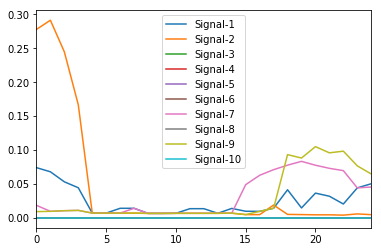

Topics Terms for joshtastic1


Topic Number                    Topic Terms                    
0         1       dad, max, word, relaxing, people, boring, offi...
1         2       distress, wiii, runn, wii, paul, sun, cuz, wai...
2         3       neways, freedom, depressing, feels, coming, ch...
3         4                                    um, sooo, dude, yeah
4         5       witt, twittering, great, cheered, crap, twitte...
5         6       week, cleaner, twit, appt, nite, cleaned, gorg...
6         7       smints, knock, bf, hug, nod, oohhh, confused, ...
7         8       style, good, jodie, shuda, spam, gfs, mo, haha...
8         9       body, pops, weather, sis, cut, missed, congrat...
9        10       jesus, xx, planning, asian, proper, hmmm, la, ...
10       11       remedies, wearing, family, arhhh, soup, feel, ...
11       12       yaya, claim, full, drooling, ps, marry, xxx, b...
12       13       ive, aubergine, cried, hungry, lol, limit, lot...
13       14       recomend, belive, rodders, bot, yesterday, boo...
14       15                           amazing, feeling, ooo, buying
15       16       raining, fish, ffs, essex, damsal, yep, find, ...
16       17       enjoy, break, tasks, outta, shake, night, gas,...
17       18       wbu, ways, meanie, josh, hey, looming, honest,...
18       19            coffee, dont, nan, thursday, soo, glad, cool
19       20       raned, fluey, nope, videos, dvds, flu, bound, ...
20       21       concentrated, work, green, planned, mom, mum, ...
21       22       , hows, kind, buy, poor, wacth, heart, girls, ...
22       23       assassinating, younger, sorrie, leave, charlie...
23       24       neighbors, cute, love, competition, bring, nev...
24       25       control, roux, yesh, sky, xoxo, bee, tonight, ...

Seeded Terms Per Topic for joshtastic1


Topic Number    Seed Terms:Count  
0   signal_1               boring:16
1   signal_9           cut:7, hurt:7
2   signal_2    gloomy:3, distress:3
3   signal_7              confused:8

Topics Probabilties Over Time for iyaitssuzanne


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   18/04/2009 - 18/04/2009     0.0       0.0    0.0000000     0.0     
1   02/05/2009 - 02/05/2009     0.0       0.0    0.0000000     0.0     
2   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
3   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
4   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
5   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
6   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
7   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
8   02/05/2009 - 03/05/2009     0.0       0.0    0.0169492     0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0    0.0136986     0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0    0.0136986     0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0    0.0136986     0.0     
12  02/05/2009 - 10/05/2009     0.0       0.0    0.0136986     0.0     
13  02/05/2009 - 10/05/2009     0.0       0.0    0.0136986     0.0     
14  02/05/2009 - 10/05/2009     0.0       0.0    0.0136986     0.0     
15  03/05/2009 - 10/05/2009     0.0       0.0    0.0000000     0.0     
16  10/05/2009 - 17/05/2009     0.0       0.0    0.0000000     0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0    0.0188679     0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0    0.0188679     0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0    0.0188679     0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0    0.0188679     0.0     
21  10/05/2009 - 22/05/2009     0.0       0.0    0.0181818     0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0    0.0181818     0.0     
23  17/05/2009 - 22/05/2009     0.0       0.0    0.0000000     0.0     
24  17/05/2009 - 22/05/2009     0.0       0.0    0.0000000     0.0     
25  17/05/2009 - 22/05/2009     0.0       0.0    0.0000000     0.0     
26  17/05/2009 - 22/05/2009     0.0       0.0    0.0000000     0.0     
27  17/05/2009 - 22/05/2009     0.0       0.0    0.0000000     0.0     
28  17/05/2009 - 29/05/2009     0.0       0.0    0.0333333     0.0     
29  17/05/2009 - 30/05/2009     0.0       0.0    0.0478469     0.0     
30  18/05/2009 - 31/05/2009     0.0       0.0    0.0598291     0.0     
31  22/05/2009 - 01/06/2009     0.0       0.0    0.0782918     0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0    0.0555556     0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0    0.0612903     0.0     
34  22/05/2009 - 04/06/2009     0.0       0.0    0.0668790     0.0     
35  29/05/2009 - 05/06/2009     0.0       0.0    0.0597015     0.0     
36  29/05/2009 - 06/06/2009     0.0       0.0    0.0515464     0.0     
37  29/05/2009 - 07/06/2009     0.0       0.0    0.0637255     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0       0.0     
17     0.0  

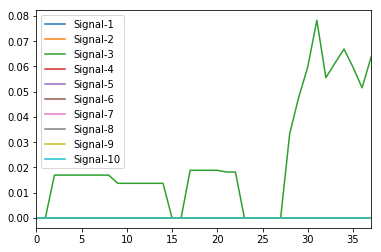

Topics Terms for iyaitssuzanne


Topic Number                    Topic Terms                    
0         1       town, seya, eye, deffinatly, move, horrible, m...
1         2       wining, cried, tired, hannah, sunny, montana, ...
2         3       shop, randomly, mums, twitter, go_to_bed, toni...
3         4       term, llolz, music, nan, bein, moved, sad, act...
4         5       twitterfon, boy, beatles, good, picture, chavv...
5         6                            carla, num, gona, attendence
6         7                                   yay, guys, days, wait
7         8       susan, shouted, exam, god, song, rember, atm, ...
8         9       worlds, inbtime, downloads, paranoide, rest, i...
9        10                   watch, doin, chemistry, type, history
10       11                                              died, year
11       12                                       bit, top, watchin
12       13       dont, excited, tooo, scared, spell, likin, bee...
13       14                             manchester, mate, sond, lol
14       15       funny, full, garden, singstar, earlier, urgh, ...
15       16                                  movie, liverpool, eith
16       17       love, seein, combination, burst, seats, money,...
17       18       duno, unfortunatly, okayish, yesterday, leave,...
18       19       sort, play, beths, live, cellin, read, hm, bro...
19       20                         food, cryin, actuly, head, yeah
20       21       week, hour, notie, myspace, amazing, french, i...
21       22       somethin, break, video, massive, biggest, drop...
22       23                 forward, project, jonas, fast, thankyou
23       24       medicin, merz, family, agian, wembally, doesnt...
24       25       wilson, thingy, creat, september, die, thinkin...

Seeded Terms Per Topic for iyaitssuzanne


Topic Number Seed Terms:Count
0   signal_3      go_to_bed:8

Topics Probabilties Over Time for Wolfgang_


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   03/05/2009 - 16/05/2009     0.0    0.0188679     0.0    0.0188679   
1   10/05/2009 - 17/05/2009     0.0    0.0185185     0.0    0.0185185   
2   10/05/2009 - 18/05/2009     0.0    0.0172414     0.0    0.0172414   
3   10/05/2009 - 18/05/2009     0.0    0.0172414     0.0    0.0172414   
4   10/05/2009 - 18/05/2009     0.0    0.0172414     0.0    0.0172414   
5   10/05/2009 - 18/05/2009     0.0    0.0172414     0.0    0.0172414   
6   10/05/2009 - 22/05/2009     0.0    0.0149254     0.0    0.0149254   
7   10/05/2009 - 22/05/2009     0.0    0.0149254     0.0    0.0149254   
8   14/05/2009 - 22/05/2009     0.0    0.0172414     0.0    0.0172414   
9   14/05/2009 - 22/05/2009     0.0    0.0172414     0.0    0.0172414   
10  14/05/2009 - 26/05/2009     0.0    0.0169492     0.0    0.0169492   
11  14/05/2009 - 26/05/2009     0.0    0.0169492     0.0    0.0169492   
12  16/05/2009 - 28/05/2009     0.0    0.0217391     0.0    0.0217391   
13  16/05/2009 - 29/05/2009     0.0    0.0327869     0.0    0.0163934   
14  17/05/2009 - 30/05/2009     0.0    0.0312500     0.0    0.0156250   
15  18/05/2009 - 31/05/2009     0.0    0.0540541     0.0    0.0135135   
16  22/05/2009 - 01/06/2009     0.0    0.0280374     0.0    0.0093458   
17  22/05/2009 - 02/06/2009     0.0    0.0148148     0.0    0.0074074   
18  22/05/2009 - 03/06/2009     0.0    0.0125786     0.0    0.0062893   
19  22/05/2009 - 03/06/2009     0.0    0.0125786     0.0    0.0062893   
20  26/05/2009 - 05/06/2009     0.0    0.0132450     0.0    0.0066225   
21  26/05/2009 - 06/06/2009     0.0    0.0118343     0.0    0.0059172   
22  26/05/2009 - 07/06/2009     0.0    0.0157895     0.0    0.0052632   
23  26/05/2009 - 07/06/2009     0.0    0.0210526     0.0    0.0052632   
24  28/05/2009 - 07/06/2009     0.0    0.0105820     0.0    0.0052910   
25  28/05/2009 - 07/06/2009     0.0    0.0211640     0.0    0.0052910   
26  29/05/2009 - 07/06/2009     0.0    0.0106383     0.0    0.0053191   
27  30/05/2009 - 07/06/2009     0.0    0.0057803     0.0    0.0057803   
28  31/05/2009 - 07/06/2009     0.0    0.0119760     0.0    0.0059880   
29  01/06/2009 - 07/06/2009     0.0    0.0064935     0.0    0.0064935   
30  02/06/2009 - 15/06/2009     0.0    0.0564516     0.0    0.0524194   
31  03/06/2009 - 16/06/2009     0.0    0.0527950     0.0    0.0869565   
32  05/06/2009 - 17/06/2009     0.0    0.0602410     0.0    0.0873494   
33  05/06/2009 - 18/06/2009     0.0    0.0594595     0.0    0.0891892   
34  06/06/2009 - 19/06/2009     0.0    0.0641711     0.0    0.0855615   
35  07/06/2009 - 20/06/2009     0.0    0.0694444     0.0    0.0916667   
36  15/06/2009 - 20/06/2009     0.0    0.0648968     0.0    0.0884956   
37  15/06/2009 - 20/06/2009     0.0    0.0678466     0.0    0.0973451   
38  15/06/2009 - 23/06/2009     0.0    0.0826211     0.0    0.0968661   
39  15/06/2009 - 23/06/2009     0.0    0.0769231     0.0    0.1025641   
40  15/06/2009 - 25/06/2009     0.0    0.0947075     0.0    0.0947075   

    Signal-5   Signal-6   Signal-7   Signal-8  Signal-9   Signal-10  
0   0.0754717  0.0188679  0.0566038     0.0    0.0943396     0.0     
1   0.0740741  0.0370370  0.0185185     0.0    0.0740741     0.0     
2   0.1379310  0.0172414  0.0344828     0.0    0.0689655     0.0     
3   0.1206897  0.0172414  0.0344828     0.0    0.0517241     0.0     
4   0.1206897  0.0344828  0.0344828     0.0    0.0862069     0.0     
5   0.1206897  0.0172414  0.0344828     0.0    0.0862069     0.0     
6   0.0895522  0.0298507  0.1492537     0.0    0.1044776     0.0     
7   0.0895522  0.0298507  0.1343284     0.0    0.0895522     0.0     
8   0.0862069  0.0344828  0.1551724     0.0    0.1034483     0.0     
9   0.0862069  0.0172414  0.1551724     0.0    0.1034483     0.0     
10  0.0847458  0.0169492  0.1525424     0.0    0.1016949     0.0     
11  0.0847458  0.0169492  0.1525424     0.0    0.0847458     0.0     
12  0.1086957  0.0217391  0.1956

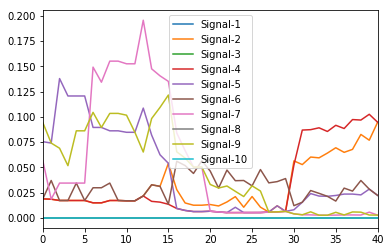

Topics Terms for Wolfgang_


Topic Number                    Topic Terms                    
0         1       door, sight, deal, song, watch, frame, nary, n...
1         2       helpness, pausch, waking, slam, momento, miser...
2         3       pleasant, tough, area, feel, messages, june, a...
3         4       upgraded, sob, sea, appeared, lugguage, lust, ...
4         5       head, read, fat, morning, absolutely, pleasure...
5         6                   sending, buy, num, worst, mate, touch
6         7       enjoy, cyclist, lower, aye, engaged, lucky, ja...
7         8       books, tether, shit, wanton, cuffs, bad, heart...
8         9                              injured, hell, caught, api
9        10       cheap, chemotherapy, gd, dropped, ver, network...
10       11       bill, phone, fire, felt, sneak, excitment, lan...
11       12       claim, asleep, pain, happen, lugguge, weakened...
12       13         arguing, ipod, work, late, camera, night, price
13       14       brave, scared, idea, russian, report, sense, f...
14       15       sound, hit, nursing, mb, apps, missing, alrigh...
15       16       poor, frustrations, jeans, check, sun, minimis...
16       17       guess, sharing, passing, showers, form, speech...
17       18       control, cute, sigh, chicken, recover, tomorro...
18       19       heavy, heart, voil, cellphones, hols, share, u...
19       20                                       middle, good, nan
20       21       info, envy, power, bid, content, aaarrrggh, bo...
21       22       hows, dont, decent, haha, month, nikon, remind...
22       23       fondle, funny, tweetdeck, update, bum, hang, y...
23       24       wld, bc, sooo, sms, anythig, breeze, insured, ...
24       25       town, kind, provide, dilemma, iphoto, mm, pro,...

Seeded Terms Per Topic for Wolfgang_


Topic Number                  Seed Terms:Count                 
0   signal_9                                  injured:14, hell:26
1   signal_2    heartache:9, miserable:36, melancholy:11, hear...
2   signal_5                                                fat:9
3   signal_4                                           drained:10
4   signal_7                                           engaged:14
5   signal_6                                              worst:8

Topics Probabilties Over Time for mlexiehayden


Time Period         Signal-1  Signal-2   Signal-3   Signal-4   \
0   02/05/2009 - 04/05/2009     0.0    0.0000000  0.0000000  0.0000000   
1   03/05/2009 - 16/05/2009     0.0    0.0000000  0.0000000  0.0000000   
2   04/05/2009 - 17/05/2009     0.0    0.4038462  0.0192308  0.0192308   
3   16/05/2009 - 17/05/2009     0.0    0.0000000  0.0000000  0.0000000   
4   16/05/2009 - 17/05/2009     0.0    0.0000000  0.0000000  0.0000000   
5   16/05/2009 - 17/05/2009     0.0    0.0000000  0.0000000  0.0000000   
6   16/05/2009 - 17/05/2009     0.0    0.0000000  0.0000000  0.0000000   
7   16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
8   16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
9   16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
10  16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
11  16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
12  16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
13  16/05/2009 - 22/05/2009     0.0    0.4489796  0.0204082  0.0204082   
14  16/05/2009 - 29/05/2009     0.0    0.3055556  0.0138889  0.0138889   
15  17/05/2009 - 30/05/2009     0.0    0.1636364  0.0090909  0.0090909   
16  22/05/2009 - 31/05/2009     0.0    0.0075758  0.0075758  0.0151515   
17  22/05/2009 - 01/06/2009     0.0    0.0065359  0.0065359  0.0065359   
18  22/05/2009 - 02/06/2009     0.0    0.0054945  0.0054945  0.0054945   
19  22/05/2009 - 03/06/2009     0.0    0.0053476  0.0053476  0.0053476   
20  22/05/2009 - 04/06/2009     0.0    0.0053191  0.0053191  0.0053191   
21  29/05/2009 - 05/06/2009     0.0    0.0048544  0.0097087  0.0145631   
22  29/05/2009 - 06/06/2009     0.0    0.0046083  0.0092166  0.0138249   
23  29/05/2009 - 07/06/2009     0.0    0.0040650  0.0040650  0.0243902   
24  29/05/2009 - 07/06/2009     0.0    0.0040650  0.0040650  0.0162602   
25  29/05/2009 - 07/06/2009     0.0    0.0040650  0.0040650  0.0243902   
26  29/05/2009 - 07/06/2009     0.0    0.0040650  0.0040650  0.0325203   
27  29/05/2009 - 07/06/2009     0.0    0.0040650  0.0040650  0.0162602   
28  30/05/2009 - 07/06/2009     0.0    0.0044843  0.0044843  0.0179372   
29  31/05/2009 - 07/06/2009     0.0    0.0055866  0.0055866  0.0335196   
30  01/06/2009 - 14/06/2009     0.0    0.0059880  0.0419162  0.0598802   
31  02/06/2009 - 15/06/2009     0.0    0.0056497  0.0451977  0.0734463   
32  03/06/2009 - 16/06/2009     0.0    0.0051282  0.0666667  0.0461538   
33  04/06/2009 - 17/06/2009     0.0    0.0046948  0.0657277  0.0610329   
34  05/06/2009 - 18/06/2009     0.0    0.0043290  0.0865801  0.0562771   
35  06/06/2009 - 19/06/2009     0.0    0.0041322  0.0909091  0.0661157   
36  07/06/2009 - 20/06/2009     0.0    0.0043103  0.0991379  0.0474138   
37  14/06/2009 - 21/06/2009     0.0    0.0047393  0.1184834  0.0663507   
38  14/06/2009 - 22/06/2009     0.0    0.0090498  0.1040724  0.0723982   
39  14/06/2009 - 23/06/2009     0.0    0.0043290  0.1082251  0.0692641   
40  14/06/2009 - 24/06/2009     0.0    0.0086207  0.1077586  0.0646552   
41  14/06/2009 - 25/06/2009     0.0    0.0041667  0.0958333  0.0833333   

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0000000     0.0    0.0000000  0.0000000  0.0000000  
1      0.0    0.0000000     0.0    0.0000000  0.0000000  0.0000000  
2      0.0    0.0384615     0.0    0.0192308  0.0192308  0.0192308  
3      0.0    0.0000000     0.0    0.0000000  0.0000000  0.0000000  
4      0.0    0.0000000     0.0    0.0000000  0.0000000  0.0000000  
5      0.0    0.0000000     0.0    0.0000000  0.0000000  0.0000000  
6      0.0    0.0000000     0.0    0.0000000  0.0000000  0.0000000  
7      0.0    0.0204082     0.0    0.0408163  0.0204082  0.0204082  
8      0.0    0.0204082     0.0    0.0204082  0.0204082  0.0204082  
9      0.0    0.0204082     0.0    0.0408163  0.0204082  0.0204082  
10     0.0    0.0204082     0.0    0.0204082  0.0204082  0.0204082 

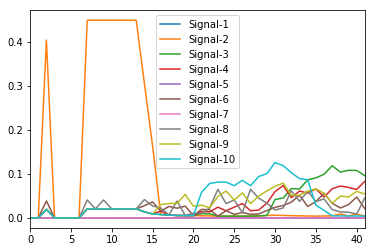

Topics Terms for mlexiehayden


Topic Number                    Topic Terms                    
0         1       trim, ohh, apple, puppet, psycho, dealer, cher...
1         2       , heavy, energy, crib, troy, diddy, dreading, ...
2         3       rodarte, bff, drunk, vivi, nan, drink, sleepy,...
3         4       isht, bbm, leavin, star, bring, feel, starting...
4         5       shoot, wheelchair, pouring, doin, proenza, hur...
5         6       life, good, working, aye, sad, houses, give_up...
6         7                           late, beat, num, wait, godsis
7         8                                        angry, ouch, lol
8         9                 dying, yo, die, hurt, awww, stuff, hell
9        10       blog, eyes, set, songz, meds, trend, dope, min...
10       11       jade, sleep, tomorrow, charlene, quit, guess, ...
11       12       building, styles, cobra, salon, leather, disti...
12       13       graduating, runnin, arbor, pampering, min, swe...
13       14                                                    flaw
14       15       starving, imma, tomfoolery, destination, dude,...
15       16       yelled, goin, big, ponied, momma, awake, crazi...
16       17       tummy, trey, remember, reality, stranger, poo,...
17       18       boobear, cay, huggies, og, visit, request, va,...
18       19       ocan, garbage, yea, feelings, defending, suffe...
19       20                head, love, woulda, cook, span, sowwwyyy
20       21                                               news, hey
21       22       ass, friends, free, tonight, add, catchin, bla...
22       23       oooo, cookies, curse, rejection, buddy, brat, ...
23       24       wack, schouler, office, pin, dies, advice, bal...
24       25       readiness, psychoticness, random, mtv, switch,...

Seeded Terms Per Topic for mlexiehayden


Topic Number          Seed Terms:Count         
0    signal_9   hell:14, die:8, dying:14, hurt:11
1    signal_8                            angry:14
2    signal_3                           sleepy:20
3    signal_2                          dreading:1
4    signal_4                             tired:9
5    signal_6                          give_up:11
6   signal_10                             meds:14

Topics Probabilties Over Time for keren4562


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   20/04/2009 - 20/04/2009  0.0000000     0.0       0.0       0.0     
1   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
2   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
3   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
4   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
5   14/05/2009 - 18/05/2009  0.0000000     0.0       0.0       0.0     
6   14/05/2009 - 18/05/2009  0.0000000     0.0       0.0       0.0     
7   14/05/2009 - 18/05/2009  0.0000000     0.0       0.0       0.0     
8   14/05/2009 - 18/05/2009  0.0000000     0.0       0.0       0.0     
9   14/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
10  14/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
11  14/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
12  14/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
13  14/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
14  14/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
15  18/05/2009 - 22/05/2009  0.0000000     0.0       0.0       0.0     
16  18/05/2009 - 29/05/2009  0.0192308     0.0       0.0       0.0     
17  18/05/2009 - 30/05/2009  0.0626223     0.0       0.0       0.0     
18  18/05/2009 - 30/05/2009  0.0978474     0.0       0.0       0.0     
19  22/05/2009 - 01/06/2009  0.0252525     0.0       0.0       0.0     
20  22/05/2009 - 02/06/2009  0.1263158     0.0       0.0       0.0     
21  22/05/2009 - 03/06/2009  0.1356932     0.0       0.0       0.0     
22  22/05/2009 - 03/06/2009  0.0781711     0.0       0.0       0.0     
23  29/05/2009 - 05/06/2009  0.0678211     0.0       0.0       0.0     
24  29/05/2009 - 06/06/2009  0.0926694     0.0       0.0       0.0     
25  29/05/2009 - 07/06/2009  0.0765306     0.0       0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0       0.0    0.0000000     0.0     
1      0.0       0.0       0.0       0.0    0.0000000     0.0     
2      0.0       0.0       0.0       0.0    0.0000000     0.0     
3      0.0       0.0       0.0       0.0    0.0000000     0.0     
4      0.0       0.0       0.0       0.0    0.0000000     0.0     
5      0.0       0.0       0.0       0.0    0.0000000     0.0     
6      0.0       0.0       0.0       0.0    0.0000000     0.0     
7      0.0       0.0       0.0       0.0    0.0000000     0.0     
8      0.0       0.0       0.0       0.0    0.0000000     0.0     
9      0.0       0.0       0.0       0.0    0.0192308     0.0     
10     0.0       0.0       0.0       0.0    0.0192308     0.0     
11     0.0       0.0       0.0       0.0    0.0192308     0.0     
12     0.0       0.0       0.0       0.0    0.0192308     0.0     
13     0.0       0.0       0.0       0.0    0.0192308     0.0     
14     0.0       0.0       0.0       0.0    0.0192308     0.0     
15     0.0       0.0       0.0       0.0    0.0000000     0.0     
16     0.0       0.0       0.0       0.0    0.0384615     0.0     
17     0.0       0.0       0.0       0.0    0.0254403     0.0     
18     0.0       0.0       0.0       0.0    0.0156556     0.0     
19     0.0       0.0       0.0       0.0    0.0286195     0.0     
20     0.0       0.0       0.0       0.0    0.0421053     0.0     
21     0.0       0.0       0.0       0.0    0.0545723     0.0     
22     0.0       0.0       0.0       0.0    0.0457227     0.0     
23     0.0       0.0       0.0       0.0    0.0505051     0.0     
24     0.0       0.0       0.0       0.0    0.0484094     0.0     
25     0.0       0.0       0.0       0.0    0.0625000     0.0

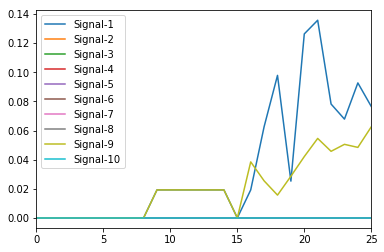

Topics Terms for keren4562


Topic Number                    Topic Terms                    
0         1                       boring, bored, please, sam, yummy
1         2          mickey, week, evening, dog, lol, fans, parents
2         3                                                    cake
3         4       jelous, cry, working, xxx, israeli, aksed, bre...
4         5       sound, daughter, idea, dougie, happy, ofcourse...
5         6       fly, israel, love, office, comp, mind, maby, year
6         7       somthing, forgive, belive, mad, tomorow, guys,...
7         8                                  bob, num, lot, morning
8         9       huge, ohh, mcfly, work, unfair, hurt, answear,...
9        10       eposide, roni, met, students, marry, life, hea...
10       11       enjoy, stav, lilah, finally, ton, meting, ditc...
11       12                                           beteavon, day
12       13                                             head, yuval
13       14                           telling, heart, danny, carrie
14       15                                                nan, hey
15       16       sis, picture, school, people, pet, big, xd, ig...
16       17       truley, mor, msesegges, websites, plzzz, alot,...
17       18       cute, dogs, bottom, feel, agree, somwehre, ans...
18       19       messeges, justin, ment, father, list, fuck, sa...
19       20                  , impornet, good, season, girls, start
20       21                      jusr, laptop, kara, drawning, died
21       22            sending, omg, haha, foget, couse, send, yell
22       23                        umm, xx, birthday, bugging, fair
23       24                                            sister, time
24       25            draw, kaiali, gratez, jacob, drawing, friend

Seeded Terms Per Topic for keren4562


Topic Number  Seed Terms:Count 
0   signal_1    boring:6, bored:6
1   signal_9               hurt:1

Topics Probabilties Over Time for Spidersamm


Time Period         Signal-1   Signal-2  Signal-3   Signal-4   \
0   02/05/2009 - 14/05/2009  0.0181818     0.0    0.0060606  0.0060606   
1   03/05/2009 - 14/05/2009  0.0131579     0.0    0.0131579  0.0065789   
2   04/05/2009 - 17/05/2009  0.0099010     0.0    0.0099010  0.0099010   
3   09/05/2009 - 18/05/2009  0.0156250     0.0    0.0078125  0.0078125   
4   09/05/2009 - 18/05/2009  0.0156250     0.0    0.0078125  0.0156250   
5   09/05/2009 - 18/05/2009  0.0078125     0.0    0.0078125  0.0078125   
6   09/05/2009 - 18/05/2009  0.0078125     0.0    0.0078125  0.0078125   
7   09/05/2009 - 22/05/2009  0.0070423     0.0    0.0070423  0.0070423   
8   10/05/2009 - 22/05/2009  0.0145985     0.0    0.0072993  0.0072993   
9   14/05/2009 - 22/05/2009  0.0188679     0.0    0.0094340  0.0094340   
10  14/05/2009 - 22/05/2009  0.0094340     0.0    0.0094340  0.0094340   
11  14/05/2009 - 26/05/2009  0.0270270     0.0    0.0090090  0.0090090   
12  14/05/2009 - 26/05/2009  0.0090090     0.0    0.0180180  0.0090090   
13  17/05/2009 - 28/05/2009  0.0294118     0.0    0.0098039  0.0098039   
14  17/05/2009 - 29/05/2009  0.0060241     0.0    0.0481928  0.0060241   
15  17/05/2009 - 30/05/2009  0.0176211     0.0    0.0792952  0.0088106   
16  18/05/2009 - 31/05/2009  0.0106383     0.0    0.0851064  0.0035461   
17  22/05/2009 - 01/06/2009  0.0122699     0.0    0.0828221  0.0061350   
18  22/05/2009 - 02/06/2009  0.0155440     0.0    0.0751295  0.0051813   
19  22/05/2009 - 03/06/2009  0.0170732     0.0    0.0707317  0.0024390   
20  22/05/2009 - 04/06/2009  0.0145278     0.0    0.0726392  0.0024213   
21  26/05/2009 - 05/06/2009  0.0164319     0.0    0.0704225  0.0023474   
22  26/05/2009 - 06/06/2009  0.0237154     0.0    0.0513834  0.0019763   
23  26/05/2009 - 07/06/2009  0.0132670     0.0    0.0464345  0.0016584   
24  26/05/2009 - 07/06/2009  0.0132670     0.0    0.0480929  0.0016584   
25  28/05/2009 - 07/06/2009  0.0066890     0.0    0.0518395  0.0050167   
26  28/05/2009 - 07/06/2009  0.0083612     0.0    0.0518395  0.0033445   
27  29/05/2009 - 07/06/2009  0.0152542     0.0    0.0423729  0.0033898   
28  30/05/2009 - 07/06/2009  0.0133080     0.0    0.0418251  0.0019011   
29  31/05/2009 - 07/06/2009  0.0129032     0.0    0.0258065  0.0086022   
30  01/06/2009 - 07/06/2009  0.0176322     0.0    0.0100756  0.0025189   
31  02/06/2009 - 15/06/2009  0.0138889     0.0    0.0055556  0.0027778   
32  03/06/2009 - 16/06/2009  0.0312500     0.0    0.0031250  0.0031250   
33  04/06/2009 - 17/06/2009  0.0303030     0.0    0.0121212  0.0090909   
34  05/06/2009 - 18/06/2009  0.0358209     0.0    0.0089552  0.0268657   
35  06/06/2009 - 19/06/2009  0.0391061     0.0    0.0027933  0.0698324   
36  07/06/2009 - 20/06/2009  0.0771605     0.0    0.0216049  0.1234568   
37  15/06/2009 - 20/06/2009  0.1145374     0.0    0.0132159  0.1894273   
38  15/06/2009 - 20/06/2009  0.1277533     0.0    0.0132159  0.1894273   
39  15/06/2009 - 20/06/2009  0.1101322     0.0    0.0088106  0.1762115   
40  15/06/2009 - 24/06/2009  0.1295547     0.0    0.0161943  0.1821862   
41  15/06/2009 - 25/06/2009  0.1330798     0.0    0.0228137  0.1825095   

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0060606     0.0    0.0060606  0.0121212     0.0     
1      0.0    0.0065789     0.0    0.0065789  0.0131579     0.0     
2      0.0    0.0099010     0.0    0.0099010  0.0099010     0.0     
3      0.0    0.0468750     0.0    0.0156250  0.0156250     0.0     
4      0.0    0.0468750     0.0    0.0078125  0.0078125     0.0     
5      0.0    0.0312500     0.0    0.0078125  0.0078125     0.0     
6      0.0    0.0390625     0.0    0.0078125  0.0078125     0.0     
7      0.0    0.0422535     0.0    0.0915493  0.0070423     0.0     
8      0.0    0.0364964     0.0    0.0948905  0.0218978     0.0     
9      0.0    0.0471698     0.0    0.1320755  0.0094340     0.0     
10     0.0    0.0283019     0.0    0.1320755  0.0094340     0.0    

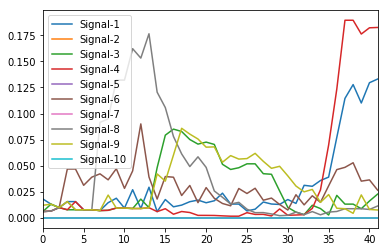

Topics Terms for Spidersamm


Topic Number                    Topic Terms                    
0         1       heaps, yuhp, dont, die, money, tweet, nan, meh...
1         2       comment, point, wall, win, coolness, move, wan...
2         3       geeetah, grrr, rude, cares, myspace, drivers, ...
3         4       wearing, sam, people, battery, wii, weather, f...
4         5       , melbs, fit, kgjkcvhjvhkj, car, dude, nawh, v...
5         6       gross, school, feel, ugly, not_good_enough, me...
6         7       pastrana, dance, sweetest, coming, dickhead, h...
7         8       sonny, trending, yeww, bass, topics, random, n...
8         9       arararar, jelous, smoke, licence, cry, dead, w...
9        10       eh, num, girl, hah, shirt, things, emotions, h...
10       11       dad, ima, head, sad, dumb, wear, reply, cake, ...
11       12                fucking, haha, aww, tassie, stack, happy
12       13       poor, ray, ahahah, listened, ss, marry, reardo...
13       14       cbf, ze, rarely, sexual, tomorrow, shannon, hm...
14       15       maccas, nippy, dudes, woah, street, chin, stuf...
15       16       drunk, text, twitter, hha, wowowowowwoh, elaur...
16       17       love, fresher, weeooow, stoned, table, mint, o...
17       18       egjodgdfnio, laptop, sosososoos, confused, jui...
18       19       beautiful, heart, samantha, humour, hahhaha, o...
19       20       raining, xo, dearrr, marijuana, bloody, cost, ...
20       21       cute, veronica, shimmy, liking, ontop, worry, ...
21       22       ive, family, mtv, assholes, site, blink, sound...
22       23       ages, gdgdfgdfhfd, bitch, nooo, kcool, marks, ...
23       24       stooge, yuckkk, scared, waves, rode, tonight, ...
24       25       meant, ass, forever, diss, full, notice, preva...

Seeded Terms Per Topic for Spidersamm


Topic Number                  Seed Terms:Count                 
0   signal_9                                     kill:14, dead:28
1   signal_8                                 annoyed:7, hectic:28
2   signal_1                           boring:14, bored:6, meh:11
3   signal_3                                          go_to_bed:6
4   signal_4                                             tired:19
5   signal_6    gross:14, mess_up:11, not_good_enough:14, ugly:21

Topics Probabilties Over Time for NKArmyTNgirl


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   18/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
1   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
2   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
3   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
4   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
5   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
6   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
7   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
8   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
9   09/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0000000   
10  09/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0000000   
11  09/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0000000   
12  09/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0000000   
13  09/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0000000   
14  09/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0000000   
15  18/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0000000   
16  18/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0000000   
17  18/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0000000   
18  18/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0000000   
19  18/05/2009 - 27/05/2009     0.0       0.0       0.0    0.0000000   
20  18/05/2009 - 28/05/2009     0.0       0.0       0.0    0.0158730   
21  18/05/2009 - 29/05/2009     0.0       0.0       0.0    0.0103093   
22  18/05/2009 - 30/05/2009     0.0       0.0       0.0    0.0055556   
23  18/05/2009 - 31/05/2009     0.0       0.0       0.0    0.0046296   
24  22/05/2009 - 01/06/2009     0.0       0.0       0.0    0.0081633   
25  22/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0422078   
26  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0553936   
27  22/05/2009 - 04/06/2009     0.0       0.0       0.0    0.0657143   
28  27/05/2009 - 05/06/2009     0.0       0.0       0.0    0.0726257   
29  27/05/2009 - 06/06/2009     0.0       0.0       0.0    0.0645933   
30  27/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0555556   
31  27/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0810185   
32  27/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0717593   
33  28/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0564706   
34  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0761671   
35  30/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0777480   
36  31/05/2009 - 07/06/2009     0.0       0.0       0.0    0.1068966   
37  01/06/2009 - 14/06/2009     0.0       0.0       0.0    0.1015625   
38  02/06/2009 - 15/06/2009     0.0       0.0       0.0    0.1355932   
39  03/06/2009 - 16/06/2009     0.0       0.0       0.0    0.1015228   
40  04/06/2009 - 17/06/2009     0.0       0.0       0.0    0.0255102   
41  05/06/2009 - 18/06/2009     0.0       0.0       0.0    0.0152284   
42  06/06/2009 - 19/06/2009     0.0       0.0       0.0    0.0199005   
43  07/06/2009 - 20/06/2009     0.0       0.0       0.0    0.0121212   
44  14/06/2009 - 21/06/2009     0.0       0.0       0.0    0.0063694   
45  14/06/2009 - 22/06/2009     0.0       0.0       0.0    0.0059880   
46  14/06/2009 - 23/06/2009     0.0       0.0       0.0    0.0057803   

    Signal-5   Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
1   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
2   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
3   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
4   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
5   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     
6   0.0000000  0.0000000     0.0       0.0    0.0000000     0.0     


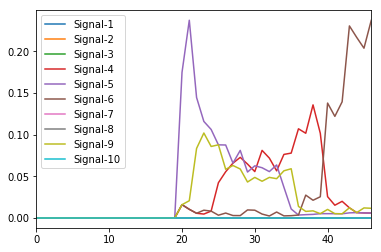

Topics Terms for NKArmyTNgirl


Topic Number                    Topic Terms                    
0         1       enjoy, walking, good, mute, bus, ride, la, blu...
1         2       hair, clam, tix, hour, phone, comp, midnight, ...
2         3       funny, movies, trumpet, safe, watch, wrong, in...
3         4       staying, pouting, love, netflix, dub, pic, soc...
4         5       entail, twat, ham, hoo, wow, speech, boob, exp...
5         6       stone, cheating, emailed, win, caught, teeth, ...
6         7       feed, peek, wondering, families, missed, vid, ...
7         8                    watched, rob, cease, idea, donnieism
8         9       stinks, edged, shirt, napped, army, dead, favo...
9        10       kids, reading, prayers, marley, nails, sitting...
10       11       , guess, voting, pain, worried, votes, wisdom,...
11       12       tv, rest, sad, goodnight, meet, yep, nice, tom...
12       13                     years, father, num, minutes, people
13       14       looked, notice, grabbed, hom, water, ice, kill...
14       15       picture, peel, wife, schoolin, awesome, burn, ...
15       16       hott, daughter, thx, morning, player, swear, h...
16       17       sarah, log, power, wonders, louis, support, al...
17       18       heart, ugh, singing, donnie, port, talking, jo...
18       19       bawling, ahh, strap, spaghetti, thought, fit, ...
19       20                   length, link, knee, dress, find, hope
20       21       uploaded, waitin, nk, ordered, concert, tweet,...
21       22       dad, harrah, group, wf, read, june, ruin, urs,...
22       23       stare, ps, great, working, days, night, baby, ...
23       24       bed, yay, hey, flight, twitter, mind, zoom, pr...
24       25       tweedeck, names, hmmm, milk, send, abought, sh...

Seeded Terms Per Topic for NKArmyTNgirl


Topic Number Seed Terms:Count
0   signal_9         dead:14   
1   signal_5       pounds:14   
2   signal_4        tired:14   
3   signal_6      give_up:21

Topics Probabilties Over Time for x33ieroNINJA


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
1   03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
2   04/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
3   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
4   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
5   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
6   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
7   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
8   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
9   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
10  14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
11  14/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
12  14/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
13  16/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
14  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
15  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
16  26/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
17  26/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
18  26/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
19  26/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
20  26/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
21  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
22  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
23  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
24  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
25  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
26  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
27  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
28  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
29  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
30  01/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
31  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
32  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0869565     0.0       0.0    0.0289855     0.0     
1   0.0163934     0.0       0.0    0.0163934     0.0     
2   0.0138889     0.0       0.0    0.0277778     0.0     
3   0.0163934     0.0       0.0    0.0327869     0.0     
4   0.0163934     0.0       0.0    0.0163934     0.0     
5   0.0327869     0.0       0.0    0.0327869     0.0     
6   0.0163934     0.0       0.0    0.0327869     0.0     
7   0.0163934     0.0       0.0    0.0327869     0.0     
8   0.0163934     0.0       0.0    0.0163934     0.0     
9   0.0163934     0.0       0.0    0.0327869     0.0     
10  0.0163934     0.0       0.0    0.0327869     0.0     
11  0.0138889     0.0       0.0    0.0138889     0.0     
12  0.0138889     0.0       0.0    0.0138889     0.0     
13  0.0166667     0.0       0.0    0.0166667     0.0     
14  0.0136986     0.0       0.0    0.0136986     0.0     
15  0.0257732     0.0       0.0    0.0051546     0.0     
16  0.0240000     0.0       0.0    0.0080000     0.0     
17  0.0273556     0.0       0.0    0.0364742     0.0     
18  0.0217391     0.0       0.0    0.0386473     0.0     
19  0.0167364     0.0       0.0    0.0355649     0.0     
20  0.0308008     0.0       0.0    0

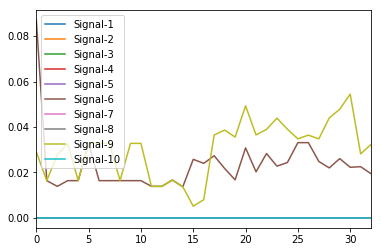

Topics Terms for x33ieroNINJA


Topic Number                    Topic Terms                    
0         1       cute, hurley, youh, coz, comfy, lion, hahahaha...
1         2       ohh, sleeps, woaaahhh, feelings, hair, hahahah...
2         3       btw, kids, photo, voldie, favourite, quote, an...
3         4       cry, poops, ohmyfuckinggod, sep, muffin, pic, ...
4         5       wearing, account, armidale, hbd, idea, vote, l...
5         6       buddy, gay, fire, tweet, uhh, suits, completel...
6         7       jbarsodmg, omg, sweetie, emo, shower, heard, a...
7         8       stil, beffnii, haha, major, vawnt, stuff, bbz,...
8         9       limited, pmsl, signed, morning, omfg, couldve,...
9        10       fagheads, ikr, shaun, night, furnunculus, beco...
10       11       eyes, breathing, join, aladdin, lke, meh, arab...
11       12       abusing, good, replying, god, boyfrannn, sneez...
12       13       , signatures, twitter, number, kings, girl, bf...
13       14       smash, video, alex, zack, holy, personal, visi...
14       15       dad, body, yay, mufti, sooonnn, period, feels,...
15       16       fucking, sleepy, mattg, dear, yer, milk, handl...
16       17       pill, hottie, sign, hyperventilaton, moving, y...
17       18       beautiful, wand, sends, awesome, check, rape, ...
18       19       dandy, signing, phils, star, regret, yo, coco,...
19       20       heaps, rad, house, lebanon, shit, cut, missed,...
20       21       wtf, heart, play, australia, golf, laugh, msn,...
21       22       set, ppl, question, young, write, written, bit...
22       23       mini, dance, fuck, todayy, vader, keyboard, sp...
23       24         babe, big, dailybooth, sleepover, jack, friggin
24       25       totally, picture, dont, boy, lots, sneeze, peo...

Seeded Terms Per Topic for x33ieroNINJA


Topic Number Seed Terms:Count
0   signal_9        kill:28    
1   signal_6       worst:11

Topics Probabilties Over Time for Karen230683


Time Period         Signal-1   Signal-2   Signal-3   Signal-4  \
0   07/04/2009 - 20/04/2009  0.0256410  0.0256410  0.0512821     0.0     
1   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
2   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
3   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
4   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
5   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
6   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
7   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
8   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
9   18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0571429     0.0     
10  18/04/2009 - 21/04/2009  0.0285714  0.0285714  0.0285714     0.0     
11  18/04/2009 - 01/05/2009  0.0270270  0.0270270  0.0270270     0.0     
12  19/04/2009 - 02/05/2009  0.0227273  0.0227273  0.0227273     0.0     
13  20/04/2009 - 03/05/2009  0.0192308  0.0192308  0.0384615     0.0     
14  21/04/2009 - 04/05/2009  0.0166667  0.0166667  0.0333333     0.0     
15  01/05/2009 - 04/05/2009  0.0172414  0.0172414  0.0172414     0.0     
16  01/05/2009 - 04/05/2009  0.0172414  0.0172414  0.0172414     0.0     
17  01/05/2009 - 04/05/2009  0.0172414  0.0172414  0.0344828     0.0     
18  01/05/2009 - 04/05/2009  0.0172414  0.0172414  0.0172414     0.0     
19  01/05/2009 - 04/05/2009  0.0172414  0.0172414  0.0172414     0.0     
20  01/05/2009 - 10/05/2009  0.0123457  0.0123457  0.0123457     0.0     
21  01/05/2009 - 11/05/2009  0.0117647  0.0117647  0.0235294     0.0     
22  01/05/2009 - 11/05/2009  0.0117647  0.0235294  0.0235294     0.0     
23  01/05/2009 - 11/05/2009  0.0117647  0.0117647  0.0235294     0.0     
24  01/05/2009 - 14/05/2009  0.0224719  0.0112360  0.0224719     0.0     
..                      ...        ...        ...        ...       ...   
38  16/05/2009 - 25/05/2009  0.1440678  0.2203390  0.0084746     0.0     
39  16/05/2009 - 25/05/2009  0.1440678  0.2118644  0.0084746     0.0     
40  17/05/2009 - 30/05/2009  0.1221374  0.1679389  0.0076336     0.0     
41  18/05/2009 - 31/05/2009  0.0833333  0.0877193  0.0131579     0.0     
42  22/05/2009 - 01/06/2009  0.0082988  0.0912863  0.0041494     0.0     
43  22/05/2009 - 02/06/2009  0.0081967  0.0819672  0.0040984     0.0     
44  22/05/2009 - 03/06/2009  0.0068493  0.0684932  0.0068493     0.0     
45  22/05/2009 - 03/06/2009  0.0102740  0.0719178  0.0068493     0.0     
46  25/05/2009 - 05/06/2009  0.0074349  0.0037175  0.0148699     0.0     
47  25/05/2009 - 06/06/2009  0.0028571  0.0028571  0.0085714     0.0     
48  25/05/2009 - 07/06/2009  0.0023529  0.0117647  0.0329412     0.0     
49  30/05/2009 - 07/06/2009  0.0023641  0.0094563  0.0378251     0.0     
50  30/05/2009 - 07/06/2009  0.0023641  0.0118203  0.0236407     0.0     
51  30/05/2009 - 07/06/2009  0.0023641  0.0047281  0.0260047     0.0     
52  30/05/2009 - 07/06/2009  0.0023641  0.0047281  0.0378251     0.0     
53  30/05/2009 - 07/06/2009  0.0023641  0.0047281  0.0330969     0.0     
54  31/05/2009 - 07/06/2009  0.0024876  0.0099502  0.0273632     0.0     
55  01/06/2009 - 07/06/2009  0.0034602  0.0173010  0.0311419     0.0     
56  02/06/2009 - 15/06/2009  0.0032154  0.0160772  0.0418006     0.0     
57  03/06/2009 - 16/06/2009  0.0050125  0.0050125  0.0350877     0.0     
58  05/06/2009 - 17/06/2009  0.0054945  0.0109890  0.0439560     0.0     
59  05/06/2009 - 18/06/2009  0.0052083  0.0156250  0.0546875     0.0     
60  06/06/2009 - 19/06/2009  0.0051151  0.0127877  0.0460358     0.0     
61  07/06/2009 - 20/06/2009  0.0063091  0.0094637  0.0536278     0.0     
62  15/06/2009 - 21/06/2009  0.0079365  0.0079365  0.0317460     0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0    0.0256410     0.0    0.0256410     0.0       0.0     
1      0.0    0.0285714 

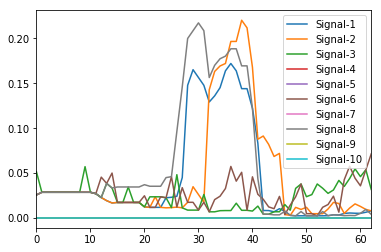

Topics Terms for Karen230683


Topic Number                    Topic Terms                    
0         1       sound, dad, coffee, door, missed, boring, year...
1         2       meant, shower, rush, sigh, laptop, friday, suc...
2         3       hoping, sleepy, leaving, bad, awake, wear, bit...
3         4       taste, awesome, rant, sounds, psycho, busy, we...
4         5       dean, explained, feet, probs, aye, jim, unifor...
5         6       huuuge, nan, bro, worst, twitterberry, ubertwi...
6         7       poor, love, bestest, soul, rain, word, tenby, ...
7         8       kids, kenny, loft, druuunk, jakey, mic, sunshi...
8         9                                           haha, noticed
9        10       family, asleep, sen, girl, tan, alcohol, syndr...
10       11       star, finish, crap, hour, hearing, imor, physi...
11       12       windy, finished, colin, thankyou, airport, num...
12       13       funny, england, dont, burning, watching, backs...
13       14       idea, ssshh, waiting, monster, drunk, massage,...
14       15       shopping, tomoz, thinking, absolutely, biking,...
15       16       cute, btw, looked, heard, feel, tired, ages, f...
16       17       vaseline, ladies, rachel, pmsl, chaffed, ya, e...
17       18            kind, good, goddaughter, nooo, morning, hope
18       19       quietly, ugh, version, manics, twitter, site, ...
19       20       paper, casper, watched, group, super, girls, s...
20       21       shave, raining, smaller, shin, office, process...
21       22                                                     lol
22       23       angel, appeared, spider, sex, xx, phonecalls, ...
23       24                 aaaw, pussy, yeah, hey, night, fab, day
24       25                               yup, work, sleep, working

Seeded Terms Per Topic for Karen230683


Topic Number      Seed Terms:Count     
0   signal_1          boring:14, bored:48
1   signal_8       shaking:14, annoyed:28
2   signal_3           awake:4, sleepy:14
3   signal_2    suffering:14, hopeless:14
4   signal_6                      worst:6

Topics Probabilties Over Time for Shinybiscuit


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   19/04/2009 - 19/04/2009     0.0    0.0000000     0.0    0.0000000   
1   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
2   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
3   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
4   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
5   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
6   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
7   10/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
8   10/05/2009 - 17/05/2009     0.0    0.0000000     0.0    0.0000000   
9   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0    0.0000000   
10  10/05/2009 - 18/05/2009     0.0    0.0000000     0.0    0.0000000   
11  10/05/2009 - 18/05/2009     0.0    0.0000000     0.0    0.0000000   
12  10/05/2009 - 18/05/2009     0.0    0.0000000     0.0    0.0000000   
13  10/05/2009 - 22/05/2009     0.0    0.0111111     0.0    0.0444444   
14  10/05/2009 - 22/05/2009     0.0    0.0111111     0.0    0.0333333   
15  17/05/2009 - 22/05/2009     0.0    0.0113636     0.0    0.0454545   
16  17/05/2009 - 22/05/2009     0.0    0.0113636     0.0    0.0454545   
17  17/05/2009 - 22/05/2009     0.0    0.0113636     0.0    0.0454545   
18  17/05/2009 - 22/05/2009     0.0    0.0113636     0.0    0.0454545   
19  17/05/2009 - 22/05/2009     0.0    0.0113636     0.0    0.0340909   
20  17/05/2009 - 29/05/2009     0.0    0.0094340     0.0    0.0377358   
21  17/05/2009 - 30/05/2009     0.0    0.0080645     0.0    0.0403226   
22  18/05/2009 - 31/05/2009     0.0    0.0110497     0.0    0.0220994   
23  22/05/2009 - 01/06/2009     0.0    0.0317460     0.0    0.0052910   
24  22/05/2009 - 02/06/2009     0.0    0.0416667     0.0    0.0052083   
25  22/05/2009 - 03/06/2009     0.0    0.0555556     0.0    0.0085470   
26  22/05/2009 - 03/06/2009     0.0    0.0683761     0.0    0.0042735   
27  29/05/2009 - 05/06/2009     0.0    0.0693069     0.0    0.0148515   
28  29/05/2009 - 06/06/2009     0.0    0.0788382     0.0    0.0124481   
29  29/05/2009 - 07/06/2009     0.0    0.0562249     0.0    0.0120482   
30  29/05/2009 - 07/06/2009     0.0    0.0522088     0.0    0.0080321   
31  29/05/2009 - 07/06/2009     0.0    0.0642570     0.0    0.0040161   
32  29/05/2009 - 07/06/2009     0.0    0.0642570     0.0    0.0080321   
33  29/05/2009 - 07/06/2009     0.0    0.0763052     0.0    0.0120482   
34  30/05/2009 - 07/06/2009     0.0    0.0519481     0.0    0.0086580   
35  31/05/2009 - 07/06/2009     0.0    0.0704225     0.0    0.0093897   
36  01/06/2009 - 07/06/2009     0.0    0.1000000     0.0    0.0200000   
37  02/06/2009 - 15/06/2009     0.0    0.0805369     0.0    0.0067114   
38  03/06/2009 - 16/06/2009     0.0    0.0588235     0.0    0.0196078   
39  05/06/2009 - 17/06/2009     0.0    0.0075758     0.0    0.0151515   
40  05/06/2009 - 18/06/2009     0.0    0.0068027     0.0    0.0068027   
41  06/06/2009 - 19/06/2009     0.0    0.0058824     0.0    0.0176471   
42  07/06/2009 - 20/06/2009     0.0    0.0072464     0.0    0.0217391   
43  15/06/2009 - 21/06/2009     0.0    0.0061728     0.0    0.0185185   
44  15/06/2009 - 22/06/2009     0.0    0.0057471     0.0    0.0229885   
45  15/06/2009 - 23/06/2009     0.0    0.0055866     0.0    0.0111732   
46  15/06/2009 - 23/06/2009     0.0    0.0055866     0.0    0.0223464   
47  15/06/2009 - 25/06/2009     0.0    0.0108696     0.0    0.0217391   

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0    0.0000000     0.0       0.0       0.0       0.0     
1      0.0    0.0000000     0.0       0.0       0.0       0.0     
2      0.0    0.0000000     0.0       0.0       0.0       0.0     
3      0.0    0.0000000     0.0       0.0       0.0       0.0     
4      0.0    0.0000000     0.0       0.0       0.0       0.0     
5      0.0    0.0000000     0

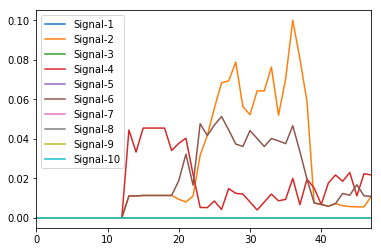

Topics Terms for Shinybiscuit


Topic Number                    Topic Terms                    
0         1       magic, specially, phone, dropped, bus, price, ...
1         2       disappointed, chiptune, crashes, tshirts, posi...
2         3        people, nan, fuck, forgot, clusters, luck, innit
3         4                late, read, loads, acceptable, knackered
4         5       __, logistics, buy, shopping, urrrghhh, watchi...
5         6                 sadface, shame, scared, love, forgotten
6         7       , poor, bf, entire, rants, biscuit, windowledg...
7         8       cheered, return, unavailable, takes, works, fe...
8         9       album, doubting, afraid, newest, crowd, dunno,...
9        10       style, good, incredible, favourite, noes, pret...
10       11       mmmm, asos, knew, haha, cbbc, ant, mention, ga...
11       12       sound, full, crew, predictable, pricks, soda, ...
12       13       nevermind, whuttt, mega, talking, write, remin...
13       14       rang, books, measure, tal, funny, christ, tv, ...
14       15       matt, garden, band, nut, month, heard, record,...
15       16       great, work, smack, luv, veg, track, couple, o...
16       17       therapy, play, told, pain, wonders, pay, puddl...
17       18       shop, kids, northern, absinthe, format, cannn,...
18       19       scary, showing, hair, grabbed, picture, fuckin...
19       20       town, cakes, ha, sick, lend, squished, da, unc...
20       21       comment, naem, calls, likea, column, typing, i...
21       22       fairly, iz, remember, morphing, offer, plane, ...
22       23       busy, evening, episode, cup, money, moneyis, c...
23       24       placement, sentiment, bonds, double, nightmare...
24       25       sexy, shut, entry, omg, ace, working, lame, be...

Seeded Terms Per Topic for Shinybiscuit


Topic Number     Seed Terms:Count   
0   signal_2           disappointed:14
1   signal_4               knackered:6
2   signal_6    shame:33, forgotten:14

Topics Probabilties Over Time for AceMas21


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   19/04/2009 - 19/04/2009  0.0000000     0.0       0.0       0.0     
1   03/05/2009 - 03/05/2009  0.1475410     0.0       0.0       0.0     
2   03/05/2009 - 03/05/2009  0.1147541     0.0       0.0       0.0     
3   03/05/2009 - 03/05/2009  0.1311475     0.0       0.0       0.0     
4   03/05/2009 - 03/05/2009  0.0983607     0.0       0.0       0.0     
5   03/05/2009 - 03/05/2009  0.0983607     0.0       0.0       0.0     
6   03/05/2009 - 03/05/2009  0.1311475     0.0       0.0       0.0     
7   03/05/2009 - 03/05/2009  0.1311475     0.0       0.0       0.0     
8   03/05/2009 - 03/05/2009  0.1475410     0.0       0.0       0.0     
9   03/05/2009 - 03/05/2009  0.1475410     0.0       0.0       0.0     
10  03/05/2009 - 03/05/2009  0.1639344     0.0       0.0       0.0     
11  03/05/2009 - 03/05/2009  0.1475410     0.0       0.0       0.0     
12  03/05/2009 - 14/05/2009  0.1060606     0.0       0.0       0.0     
13  03/05/2009 - 14/05/2009  0.1212121     0.0       0.0       0.0     
14  03/05/2009 - 14/05/2009  0.1515152     0.0       0.0       0.0     
15  14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
16  14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
17  14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
18  14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
19  14/05/2009 - 14/05/2009  0.0000000     0.0       0.0       0.0     
20  14/05/2009 - 22/05/2009  0.0175439     0.0       0.0       0.0     
21  14/05/2009 - 22/05/2009  0.0175439     0.0       0.0       0.0     
22  14/05/2009 - 22/05/2009  0.0175439     0.0       0.0       0.0     
23  14/05/2009 - 22/05/2009  0.0175439     0.0       0.0       0.0     
24  14/05/2009 - 22/05/2009  0.0175439     0.0       0.0       0.0     
25  14/05/2009 - 22/05/2009  0.0175439     0.0       0.0       0.0     
26  22/05/2009 - 22/05/2009  0.0192308     0.0       0.0       0.0     
27  22/05/2009 - 29/05/2009  0.0099010     0.0       0.0       0.0     
28  22/05/2009 - 30/05/2009  0.0192308     0.0       0.0       0.0     
29  22/05/2009 - 31/05/2009  0.0110497     0.0       0.0       0.0     
30  22/05/2009 - 01/06/2009  0.0162602     0.0       0.0       0.0     
31  22/05/2009 - 02/06/2009  0.0040323     0.0       0.0       0.0     
32  22/05/2009 - 03/06/2009  0.0098684     0.0       0.0       0.0     
33  22/05/2009 - 03/06/2009  0.0164474     0.0       0.0       0.0     
34  29/05/2009 - 05/06/2009  0.0066445     0.0       0.0       0.0     
35  29/05/2009 - 06/06/2009  0.0135501     0.0       0.0       0.0     
36  29/05/2009 - 07/06/2009  0.0193237     0.0       0.0       0.0     

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9  Signal-10  
0      0.0       0.0    0.0000000     0.0       0.0       0.0     
1      0.0       0.0    0.0163934     0.0       0.0       0.0     
2      0.0       0.0    0.0163934     0.0       0.0       0.0     
3      0.0       0.0    0.0163934     0.0       0.0       0.0     
4      0.0       0.0    0.0163934     0.0       0.0       0.0     
5      0.0       0.0    0.0163934     0.0       0.0       0.0     
6      0.0       0.0    0.0163934     0.0       0.0       0.0     
7      0.0       0.0    0.0163934     0.0       0.0       0.0     
8      0.0       0.0    0.0163934     0.0       0.0       0.0     
9      0.0       0.0    0.0163934     0.0       0.0       0.0     
10     0.0       0.0    0.0163934     0.0       0.0       0.0     
11     0.0       0.0    0.0163934     0.0       0.0       0.0     
12     0.0       0.0    0.0151515     0.0       0.0       0.0     
13     0.0       0.0    0.0303030     0.0       0.0       0.0     
14     0.0       0.0    0.0151515     0.0       0.0       0.0     
15     0.0       0.0    0.0000000     0.0       0.0       0.0     
16     0.0       0.0    0.0000000     0.0       0.0       0.0     
17     0.0       0.0    0.0000000     0.0       0.0       0.0     

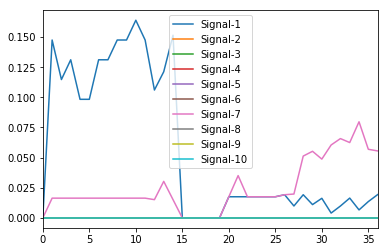

Topics Terms for AceMas21


Topic Number                    Topic Terms                    
0         1                       wrong, great, bout, bored, fed_up
1         2       scored, funny, commpliment, driving, classic, ...
2         3       afresh, lazy, afraid, woken, stoopid, glint, f...
3         4       blue, grrr, primeveal, takes, watching, dunno,...
4         5                             nevermind, good, bits, hope
5         6       unreserved, smitten, yea, spoilers, stressed, ...
6         7       dad, responses, forgotton, distracted, sooo, w...
7         8       goddess, kids, amounts, positive, classy, eyes...
8         9       nuts, ahhh, cider, ooh, laugh, things, mum, pi...
9        10       finally, love, bet, people, big, flying, reaso...
10       11       hows, kind, twitpic, crap, msgs, cow, ahh, xxx...
11       12           sweet, thought, touched, hugs, follow, wanted
12       13       evening, monday, tuesday, piccies, films, chec...
13       14       sound, flirt, mood, point, cooler, mind, abit,...
14       15       sell, friendlier, messages, haha, chest, game,...
15       16       lotsa, knock, moments, arsehole, rub, blog, wi...
16       17       feels, plans, offer, thinkin, amazon, job, all...
17       18       friday, wow, coz, glasses, vegas, lot, recomme...
18       19       spawn, picture, devil, mo, missed, played, dum...
19       20              enjoy, mad, imagine, hiya, footballer, day
20       21       heart, guess, madness, barking, song, blimey, ...
21       22       week, felt, house, work, scotland, hair, girlf...
22       23                      bless, honestly, boobs, hour, nice
23       24       school, prize, start, read, blunt, upset, hey,...
24       25       huge, boosies, area, aww, series, explain, mov...

Seeded Terms Per Topic for AceMas21


Topic Number Seed Terms:Count
0   signal_1         bored:19  
1   signal_7     distracted:5

Topics Probabilties Over Time for CaraNinaMcfly


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   18/04/2009 - 21/04/2009     0.0       0.0    0.0333333     0.0     
1   19/04/2009 - 02/05/2009     0.0       0.0    0.0879121     0.0     
2   20/04/2009 - 03/05/2009     0.0       0.0    0.1550388     0.0     
3   21/04/2009 - 03/05/2009     0.0       0.0    0.1574074     0.0     
4   02/05/2009 - 03/05/2009     0.0       0.0    0.1979167     0.0     
5   02/05/2009 - 03/05/2009     0.0       0.0    0.1875000     0.0     
6   02/05/2009 - 03/05/2009     0.0       0.0    0.1875000     0.0     
7   02/05/2009 - 03/05/2009     0.0       0.0    0.1666667     0.0     
8   02/05/2009 - 03/05/2009     0.0       0.0    0.1666667     0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0    0.1682243     0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0    0.1775701     0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0    0.1495327     0.0     
12  02/05/2009 - 10/05/2009     0.0       0.0    0.1682243     0.0     
13  02/05/2009 - 14/05/2009     0.0       0.0    0.1452991     0.0     
14  02/05/2009 - 14/05/2009     0.0       0.0    0.1452991     0.0     
15  03/05/2009 - 14/05/2009     0.0       0.0    0.1145833     0.0     
16  10/05/2009 - 14/05/2009     0.0       0.0    0.0000000     0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0    0.0090090     0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0    0.0090090     0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0    0.0090090     0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0    0.0090090     0.0     
21  10/05/2009 - 22/05/2009     0.0       0.0    0.0081967     0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0    0.0081967     0.0     
23  14/05/2009 - 22/05/2009     0.0       0.0    0.0090090     0.0     
24  14/05/2009 - 22/05/2009     0.0       0.0    0.0090090     0.0     
..                      ...       ...       ...        ...       ...   
29  18/05/2009 - 30/05/2009     0.0       0.0    0.0087719     0.0     
30  18/05/2009 - 31/05/2009     0.0       0.0    0.0111732     0.0     
31  22/05/2009 - 01/06/2009     0.0       0.0    0.0185185     0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0    0.0139665     0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0    0.0177215     0.0     
34  22/05/2009 - 03/06/2009     0.0       0.0    0.0126582     0.0     
35  29/05/2009 - 03/06/2009     0.0       0.0    0.0182292     0.0     
36  29/05/2009 - 06/06/2009     0.0       0.0    0.0150538     0.0     
37  29/05/2009 - 07/06/2009     0.0       0.0    0.0137525     0.0     
38  29/05/2009 - 07/06/2009     0.0       0.0    0.0157171     0.0     
39  29/05/2009 - 07/06/2009     0.0       0.0    0.0098232     0.0     
40  29/05/2009 - 07/06/2009     0.0       0.0    0.0157171     0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0    0.0117878     0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0    0.0120000     0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0    0.0100806     0.0     
44  01/06/2009 - 07/06/2009     0.0       0.0    0.0092807     0.0     
45  02/06/2009 - 15/06/2009     0.0       0.0    0.0133779     0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0    0.0082645     0.0     
47  06/06/2009 - 16/06/2009     0.0       0.0    0.0146341     0.0     
48  06/06/2009 - 18/06/2009     0.0       0.0    0.0095694     0.0     
49  06/06/2009 - 18/06/2009     0.0       0.0    0.0047847     0.0     
50  07/06/2009 - 20/06/2009     0.0       0.0    0.0067114     0.0     
51  15/06/2009 - 21/06/2009     0.0       0.0    0.0183486     0.0     
52  15/06/2009 - 21/06/2009     0.0       0.0    0.0183486     0.0     
53  15/06/2009 - 23/06/2009     0.0       0.0    0.0087719     0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0    0.0111111     0.0    0.0333333     0.0       0.0     
1      0.0    0.0109890     0.0    0.0329670     0.0       0.0     
2      0.0    0.0155039     0.0    0.0620155     0.0       0

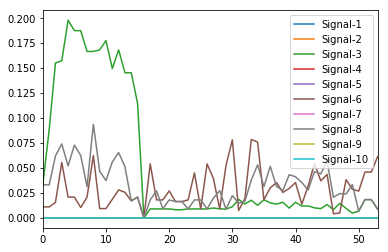

Topics Terms for CaraNinaMcfly


Topic Number                    Topic Terms                    
0         2       ohh, awesomee, ffs, ant, gofie, bratz, hehe, s...
1         3       hammersmith, sleep_in, great, chairs, media, x...
2         4       wanted, exam, goon, laying, douglas, maths, ha...
3         5       hissy, fit, read, text, cry, st, future, talk,...
4         6                                            shame, worst
5         7                                   top, star, wars, time
6         8                              good, love, annoyed, night
7         9       ive, set, ahh, forgot, yeah, helped, picked, a...
8        10       funny, school, full, omg, eat, preggers, guys,...
9        11                        thing, sounds, excited, tweeting
10       12       awesome, laugh, yayyy, hateee, write, atonemen...
11       13       swim, forever, walking, danny, mum, joke, waga...
12       14                                       snotty, num, ahhh
13       15                                                      xx
14       16       hahahahaha, yay, beat, live, bed, break, dinne...
15       17       dad, woops, jodie, loveee, jouls, friday, haha...
16       18       , sith, xo, starwars, watched, kite, dayo, cho...
17       19       naose, roast, byee, mcfly, atm, tour, mmm, fun...
18       20       german, mucked, half, yesterday, wel, oooh, br...
19       21                                      nina, brazil, nooo
20       22                           bless, happy, watch, day, hey
21       23           ha, carrie, woohoo, eek, tom, tweets, reading
22       24       watching, dont, woop, twitter, caras, mind, ea...
23       25       feel, money, topics, mentioned, chicken, yummy...

Seeded Terms Per Topic for CaraNinaMcfly


Topic Number  Seed Terms:Count 
0   signal_8           annoyed:14
1   signal_3          sleep_in:14
2   signal_6    shame:6, worst:14

Topics Probabilties Over Time for aimizubouken


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   20/04/2009 - 21/04/2009  0.0000000     0.0       0.0    0.0000000   
1   21/04/2009 - 21/04/2009  0.0000000     0.0       0.0    0.0000000   
2   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0    0.0000000   
3   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0    0.0000000   
4   14/05/2009 - 14/05/2009  0.0000000     0.0       0.0    0.0000000   
5   14/05/2009 - 17/05/2009  0.0000000     0.0       0.0    0.0000000   
6   14/05/2009 - 18/05/2009  0.2432432     0.0       0.0    0.0135135   
7   14/05/2009 - 18/05/2009  0.2297297     0.0       0.0    0.0135135   
8   14/05/2009 - 18/05/2009  0.2297297     0.0       0.0    0.0135135   
9   14/05/2009 - 21/05/2009  0.1919192     0.0       0.0    0.0909091   
10  14/05/2009 - 22/05/2009  0.0855856     0.0       0.0    0.1171171   
11  14/05/2009 - 22/05/2009  0.0855856     0.0       0.0    0.1126126   
12  14/05/2009 - 22/05/2009  0.0855856     0.0       0.0    0.1081081   
13  14/05/2009 - 22/05/2009  0.0900901     0.0       0.0    0.1171171   
14  14/05/2009 - 26/05/2009  0.0905350     0.0       0.0    0.1028807   
15  14/05/2009 - 26/05/2009  0.0864198     0.0       0.0    0.1028807   
16  17/05/2009 - 28/05/2009  0.0354839     0.0       0.0    0.0741935   
17  17/05/2009 - 29/05/2009  0.0501567     0.0       0.0    0.0658307   
18  17/05/2009 - 29/05/2009  0.0470219     0.0       0.0    0.0752351   
19  18/05/2009 - 29/05/2009  0.0265781     0.0       0.0    0.0764120   
20  21/05/2009 - 01/06/2009  0.0130719     0.0       0.0    0.0686275   
21  21/05/2009 - 02/06/2009  0.0076726     0.0       0.0    0.0613811   
22  21/05/2009 - 03/06/2009  0.0075949     0.0       0.0    0.0607595   
23  22/05/2009 - 03/06/2009  0.0081081     0.0       0.0    0.0432432   
24  26/05/2009 - 03/06/2009  0.0040486     0.0       0.0    0.0040486   
25  26/05/2009 - 03/06/2009  0.0040486     0.0       0.0    0.0080972   
26  26/05/2009 - 07/06/2009  0.0073801     0.0       0.0    0.0110701   
27  26/05/2009 - 07/06/2009  0.0036900     0.0       0.0    0.0036900   
28  28/05/2009 - 07/06/2009  0.0040000     0.0       0.0    0.0040000   
29  28/05/2009 - 07/06/2009  0.0040000     0.0       0.0    0.0040000   
30  29/05/2009 - 07/06/2009  0.0057143     0.0       0.0    0.0057143   
31  01/06/2009 - 07/06/2009  0.0060241     0.0       0.0    0.0120482   
32  01/06/2009 - 07/06/2009  0.0060241     0.0       0.0    0.0060241   
33  01/06/2009 - 14/06/2009  0.0053763     0.0       0.0    0.0053763   
34  02/06/2009 - 15/06/2009  0.0071685     0.0       0.0    0.0107527   
35  03/06/2009 - 16/06/2009  0.0036101     0.0       0.0    0.0108303   

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9  Signal-10  
0      0.0       0.0    0.0000000     0.0       0.0       0.0     
1      0.0       0.0    0.0000000     0.0       0.0       0.0     
2      0.0       0.0    0.0000000     0.0       0.0       0.0     
3      0.0       0.0    0.0000000     0.0       0.0       0.0     
4      0.0       0.0    0.0000000     0.0       0.0       0.0     
5      0.0       0.0    0.0000000     0.0       0.0       0.0     
6      0.0       0.0    0.0135135     0.0       0.0       0.0     
7      0.0       0.0    0.0135135     0.0       0.0       0.0     
8      0.0       0.0    0.0135135     0.0       0.0       0.0     
9      0.0       0.0    0.0404040     0.0       0.0       0.0     
10     0.0       0.0    0.1126126     0.0       0.0       0.0     
11     0.0       0.0    0.1036036     0.0       0.0       0.0     
12     0.0       0.0    0.1216216     0.0       0.0       0.0     
13     0.0       0.0    0.1081081     0.0       0.0       0.0     
14     0.0       0.0    0.1234568     0.0       0.0       0.0     
15     0.0       0.0    0.0987654     0.0       0.0       0.0     
16     0.0       0.0    0.0806452     0.0       0.0       0.0     
17     0.0       0.0    0.0815047     0.0       0.0       0.0     
18     0.0       0.0    0.0940439 

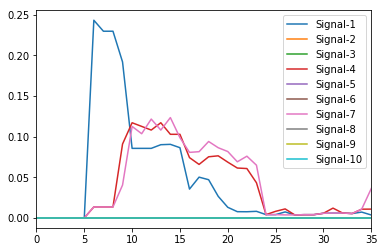

Topics Terms for aimizubouken


Topic Number                    Topic Terms                    
0         1       enjoy, town, kind, clouds, hideaki, takizawa, ...
1         2                                                   agito
2         3       full, working, monday, nak, acceptance, idea, ...
3         4       subs, belum, tired, fine, average, gather, lis...
4         5       abilities, force, penang, bring, guiness, allo...
5         6                                   weekend, agree, makan
6         7       kahwin, confused, catch, owner, father, send, ...
7         8       sound, version, watching, favorite, drink, dah...
8         9                         malaysia, pun, work, type, book
9        10       den, bila, dancing, balik, momotaros, safe, wo...
10       11       perfect, school, bye, lil, wow, indonesia, sis...
11       12       qs, juag, power, feel, starts, oic, morning, c...
12       13       flung, mind, fellow, phase, single, nowadays, ...
13       14       twitting, mails, great, documents, eating, per...
14       15       website, raining, super, classic, cik, tweetin...
15       16       uia, love, cucu, tgk, offense, tempted, slow, ...
16       17       proses, kena, family, cm, normal, takuya, good...
17       18                        band, dinner, haha, miracle, man
18       19       heavy, sending, office, people, movie, tons, h...
19       20       buy, wishful, thinking, dvd, rx, kamen, kabuto...
20       21       olive, funny, compare, oil, service, dictionar...
21       22                                   busy, num, understand
22       23       tone, hoping, choreographer, life, faiz, odd, ...
23       24                                   guess, startled, yeah
24       25       kuey, find, worry, previous, sell, jambu, area...

Seeded Terms Per Topic for aimizubouken


Topic Number  Seed Terms:Count 
0   signal_1    not_interested:14
1   signal_4             tired:30
2   signal_7           confused:2

Topics Probabilties Over Time for MissxMarisa


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   07/04/2009 - 19/04/2009     0.0       0.0       0.0       0.0       0.0     
1   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
2   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
3   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
4   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
5   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
6   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
7   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
8   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
9   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
10  17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
11  19/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
12  19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
13  21/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
14  21/04/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
15  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
16  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
17  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
18  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
19  01/05/2009 - 09/05/2009     0.0       0.0       0.0       0.0       0.0     
20  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
21  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
22  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
23  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
24  01/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
39  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
40  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
41  26/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
42  26/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
43  26/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
44  26/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
45  26/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
46  26/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
47  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
48  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
49  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
50  28/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
51  28/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
52  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
53  30/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
54  31/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
55  01/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
56  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
57  03/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
58  04/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
59  06/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
60  06/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
61  14/06/2009 - 18/06/2009     0.0     

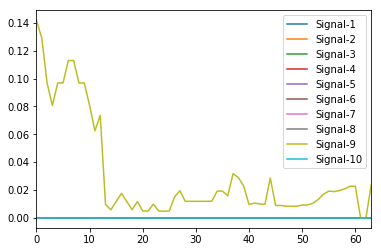

Topics Terms for MissxMarisa


Topic Number                    Topic Terms                    
0         1       mispronounces, buy, central, mandalay, awesome...
1         2                  set, pimpin, hair, good, black, babies
2         3                                          kangaroo, work
3         4       letting, teleport, bathroom, dylan, shot, sass...
4         5                               season, live, haha, scene
5         6                                               num, kids
6         7       beautiful, crazy, mature, wiggles, sneezing, h...
7         8       forever, mumbling, drum, family, morrissey, ne...
8         9       treble, great, death, hannah, favorite, zing, ...
9        10       huge, avenged, bass, assume, teeth, watch, str...
10       11       life, jimmy, song, nighty, mic, daniels, bed, ...
11       12       bathing, ability, girl, cambodia, bus, zinging...
12       13       bingo, sir, lot, spinach, people, nan, mexican...
13       14       interests, week, dm, older, aww, movie, alarm,...
14       15       fool, seizures, voice, raping, tbs, snow, jizz...
15       16                        errands, oldie, holiday, bullets
16       17       feeding, crap, fucking, huh, explain, driver, ...
17       18       unda, happy, taylor, yay, pay, men, da, bro, s...
18       19       party, trek, star, fanatic, nails, ludacris, d...
19       20       envious, full, talking, house, howdy, watching...
20       21       poor, cheese, coraline, network, cute, food, a...
21       22       golfers, baking, drunk, bother, mixer, worried...
22       23       land, hit, horrific, god, bill, outback, rugs,...
23       24       enjoy, compared, thumb, reference, afford, int...
24       25                                   lyn, love, yeah, sign

Seeded Terms Per Topic for MissxMarisa


Topic Number Seed Terms:Count
0   signal_9       death:13

Topics Probabilties Over Time for judez_xo


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   18/04/2009 - 20/04/2009     0.0    0.0169492     0.0    0.0338983   
1   19/04/2009 - 02/05/2009     0.0    0.1000000     0.0    0.0142857   
2   20/04/2009 - 03/05/2009     0.0    0.1315789     0.0    0.0131579   
3   02/05/2009 - 03/05/2009     0.0    0.1923077     0.0    0.0192308   
4   02/05/2009 - 03/05/2009     0.0    0.1923077     0.0    0.0192308   
5   02/05/2009 - 03/05/2009     0.0    0.1923077     0.0    0.0192308   
6   02/05/2009 - 03/05/2009     0.0    0.1730769     0.0    0.0192308   
7   02/05/2009 - 03/05/2009     0.0    0.2115385     0.0    0.0192308   
8   02/05/2009 - 03/05/2009     0.0    0.1923077     0.0    0.0384615   
9   02/05/2009 - 10/05/2009     0.0    0.1363636     0.0    0.0151515   
10  02/05/2009 - 11/05/2009     0.0    0.1285714     0.0    0.0142857   
11  02/05/2009 - 11/05/2009     0.0    0.1285714     0.0    0.0142857   
12  02/05/2009 - 13/05/2009     0.0    0.1447368     0.0    0.0131579   
13  02/05/2009 - 14/05/2009     0.0    0.1134021     0.0    0.0103093   
14  02/05/2009 - 14/05/2009     0.0    0.0927835     0.0    0.0206186   
15  03/05/2009 - 16/05/2009     0.0    0.0412371     0.0    0.0103093   
16  10/05/2009 - 17/05/2009     0.0    0.0095238     0.0    0.0095238   
17  10/05/2009 - 18/05/2009     0.0    0.0087719     0.0    0.0175439   
18  10/05/2009 - 18/05/2009     0.0    0.0087719     0.0    0.0175439   
19  10/05/2009 - 18/05/2009     0.0    0.0087719     0.0    0.0087719   
20  10/05/2009 - 18/05/2009     0.0    0.0087719     0.0    0.0087719   
21  10/05/2009 - 22/05/2009     0.0    0.0067568     0.0    0.0067568   
22  10/05/2009 - 22/05/2009     0.0    0.0067568     0.0    0.0202703   
23  11/05/2009 - 22/05/2009     0.0    0.0074627     0.0    0.0074627   
24  13/05/2009 - 22/05/2009     0.0    0.0076923     0.0    0.0153846   
..                      ...       ...        ...       ...        ...   
31  22/05/2009 - 01/06/2009     0.0    0.0201005     0.0    0.0100503   
32  22/05/2009 - 02/06/2009     0.0    0.0283019     0.0    0.0141509   
33  22/05/2009 - 03/06/2009     0.0    0.0217391     0.0    0.0086957   
34  22/05/2009 - 04/06/2009     0.0    0.0343348     0.0    0.0257511   
35  26/05/2009 - 05/06/2009     0.0    0.0436893     0.0    0.0339806   
36  26/05/2009 - 06/06/2009     0.0    0.0153846     0.0    0.0653846   
37  26/05/2009 - 07/06/2009     0.0    0.0339506     0.0    0.0339506   
38  26/05/2009 - 07/06/2009     0.0    0.0154321     0.0    0.0339506   
39  28/05/2009 - 07/06/2009     0.0    0.0156250     0.0    0.0156250   
40  28/05/2009 - 07/06/2009     0.0    0.0187500     0.0    0.0687500   
41  29/05/2009 - 07/06/2009     0.0    0.0220820     0.0    0.0567823   
42  30/05/2009 - 07/06/2009     0.0    0.0206186     0.0    0.0343643   
43  31/05/2009 - 07/06/2009     0.0    0.0210970     0.0    0.0210970   
44  01/06/2009 - 07/06/2009     0.0    0.0270270     0.0    0.0585586   
45  02/06/2009 - 15/06/2009     0.0    0.0228311     0.0    0.0547945   
46  03/06/2009 - 16/06/2009     0.0    0.0080321     0.0    0.0441767   
47  04/06/2009 - 17/06/2009     0.0    0.0085470     0.0    0.0341880   
48  05/06/2009 - 18/06/2009     0.0    0.0041667     0.0    0.0291667   
49  06/06/2009 - 19/06/2009     0.0    0.0041841     0.0    0.0376569   
50  07/06/2009 - 20/06/2009     0.0    0.0153846     0.0    0.0102564   
51  15/06/2009 - 21/06/2009     0.0    0.0070922     0.0    0.0070922   
52  15/06/2009 - 21/06/2009     0.0    0.0070922     0.0    0.0070922   
53  15/06/2009 - 23/06/2009     0.0    0.0069444     0.0    0.0069444   
54  15/06/2009 - 23/06/2009     0.0    0.0138889     0.0    0.0069444   
55  15/06/2009 - 25/06/2009     0.0    0.0068966     0.0    0.0137931   

    Signal-5   Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0   0.0338983  0.0169492     0.0    0.0169492  0.0169492     0.0     
1   0.0142857  0.0142857     0.0    0.0142857  0.0285714     0.0     
2 

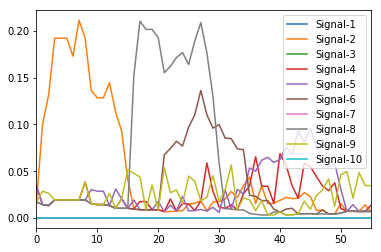

Topics Terms for judez_xo


Topic Number                    Topic Terms                    
0         1       beautiful, hehehe, newest, napped, dance, twit...
1         2       good, myspace, no_one_loves_me, time, boob, email
2         3       blade, kinky, rah, thursday, talks, fine, deci...
3         4                                 lazy, girl, div, listen
4         5       , eventually, fatty, leaves, lol, gained, towe...
5         6       head, deleting, sick, ftw, want_to_sleep, exac...
6         7       heart, work, xo, sigh, sushi, young, jess, aw,...
7         8       letting, money, clip, hour, texts, car, yous, ...
8         9                          dead, hurting, train, suck, xd
9        10                                                     num
10       11       sector, followers, love, rainbows, move, lovee...
11       12       box, drools, eat, broken, feel, nude, meant, c...
12       13       drunken, dragonfly, lair, spoil, watch, questi...
13       15       wanted, listened, thinking, didnt, yesterday, ...
14       16       wearing, erin, town, aww, sweet, yehh, friday,...
15       17       yeh, tgp, photo, fuck, waking, find, screw, mi...
16       18       __, comment, ohh, celeb, woah, clem, blonde, d...
17       19       play, kids, magic, teeth, tired, text, pic, ug...
18       20       ashby, room, majority, wall, wednesday, bed, b...
19       21       zack, people, burger, wow, george, shower, met...
20       22                                   note, haha, nan, wait
21       23       chatswonggg, casting, start, stacey, nutrition...
22       24       represent, hornsby, mums, al, dear, allowed, c...
23       25       heaps, sooo, sad, tonight, yep, gosh, twitters...

Seeded Terms Per Topic for judez_xo


Topic Number   Seed Terms:Count  
0   signal_9    hurting:14, dead:11
1   signal_8             annoyed:14
2   signal_2     no_one_loves_me:14
3   signal_5               fatty:14
4   signal_4                lazy:28
5   signal_6               worst:14

Topics Probabilties Over Time for figPYBFO


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   09/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
1   14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
2   14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
3   14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
4   14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
5   14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
6   16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
7   16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
8   18/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
9   18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
10  22/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
11  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
12  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
13  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
14  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
15  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
16  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
17  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
18  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
19  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
20  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
21  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
22  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
23  02/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
24  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
25  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6   Signal-7  Signal-8  Signal-9  Signal-10  
0   0.0076336     0.0       0.0       0.0       0.0     
1   0.0038911     0.0       0.0       0.0       0.0     
2   0.0116732     0.0       0.0       0.0       0.0     
3   0.0038911     0.0       0.0       0.0       0.0     
4   0.0155642     0.0       0.0       0.0       0.0     
5   0.0038911     0.0       0.0       0.0       0.0     
6   0.0040486     0.0       0.0       0.0       0.0     
7   0.0168350     0.0       0.0       0.0       0.0     
8   0.0454545     0.0       0.0       0.0       0.0     
9   0.0478011     0.0       0.0       0.0       0.0     
10  0.0695652     0.0       0.0       0.0       0.0     
11  0.0637523     0.0       0.0       0.0       0.0     
12  0.0623974     0.0       0.0       0.0       0.0     
13  0.0623974     0.0       0.0       0.0       0.0     
14  0.0775194     0.0       0.0       0.0       0.0     
15  0.0701169     0.0       0.0       0.0       0.0     
16  0.0659062     0.0       0.0       0.0       0.0     
17  0.0621039     0.0       0.0       0.0       0.0     
18  0.0735108     0.0       0.0       0.0       0.0     
19  0.0709759     0.0       0.0       0.0       0.0     
20  0.0608365     0.0       0.0       0.0       0.0     
21  0.0649526     0.0       0.0       0.0       0.0     
22  0.0601375     0.0       0.0       0.0       0.0     
23  0.0601202     0.0       0.0       0.0       0.0     
24  0.0498008     0.0       0.0       0.0       0.0     
25  0.0367816     0.0       0.0       0.0       0.0

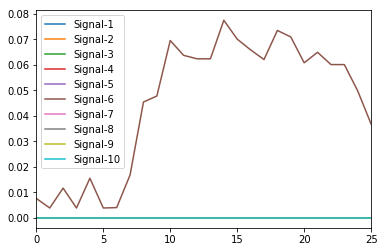

Topics Terms for figPYBFO


Topic Number                    Topic Terms                    
0         1       ive, bars, twitter, speel, marshmallows, probs...
1         2                              dinner, tweeted, xoxo, tis
2         3       patrol, shoes, liek, jess, num, childcare, gol...
3         4       prime, huge, account, sweetpeas, working, sooo...
4         5       awesome, xd, wth, heelloo, xs, naomi, yummy, h...
5         6       club, play, ten, msn, read, comp, bookreading,...
6         7       apple, patience, player, sundae, sense, sprint...
7         8       birthday, technology, jap, evvveeerrr, yah, re...
8         9       ikr, looked, deal, kk, notes, marks, soo, argh...
9        10       talking, randomly, fillings, ninemsn, people, ...
10       11       dad, topic, guess, omg, aww, things, ride, sen...
11       12       maccas, storms, pie, rank, watched, bottom, ch...
12       13       cute, dont, scared, rachel, tonight, dwnld, na...
13       14       ima, rocks, normal, brawl, usual, ages, yester...
14       15       body, funny, brb, blair, word, bebo, drop, wha...
15       16             dishes, bec, hey, foood, asian, maths, find
16       17       pro, forever, full, yay, takes, point, skills,...
17       18                             wakurimashita, haha, follow
18       19       ipb, rainy, monday, mcdreamy, sayounara, colou...
19       20       moz, shopping, brelta, remember, athletic, car...
20       21       totally, scary, btw, love, song, aargh, watchi...
21       22       heartbreaks, tours, txt, underline, interestin...
22       23       replied, tidy, ppl, baby, stuffs, wordlimit, l...
23       24       poor, ad, vid, nuts, idea, days, alwwayyyss, b...
24       25       ass, lg, great, ahem, isketch, sit, fire, crac...

Seeded Terms Per Topic for figPYBFO


Topic Number Seed Terms:Count
0   signal_6       shame:14

Topics Probabilties Over Time for Samm_xo


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   06/04/2009 - 19/04/2009     0.0       0.0       0.0    0.0163934   
1   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
2   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0138889   
3   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
4   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
5   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
6   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
7   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
8   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
9   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
10  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0277778   
11  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0138889   
12  18/04/2009 - 01/05/2009     0.0       0.0       0.0    0.0263158   
13  19/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0533333   
14  20/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0000000   
15  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
16  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
17  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
18  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
19  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
20  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
21  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0000000   
22  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0000000   
23  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0000000   
24  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0000000   
25  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0000000   
26  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0000000   
27  04/05/2009 - 16/05/2009     0.0       0.0       0.0    0.0000000   
28  04/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0256410   
29  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0138889   
30  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0138889   
31  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0138889   
32  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0138889   
33  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0133333   
34  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0133333   
35  16/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0298507   
36  16/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0298507   
37  16/05/2009 - 26/05/2009     0.0       0.0       0.0    0.0147059   
38  16/05/2009 - 26/05/2009     0.0       0.0       0.0    0.0294118   
39  16/05/2009 - 28/05/2009     0.0       0.0       0.0    0.0080000   
40  16/05/2009 - 29/05/2009     0.0       0.0       0.0    0.0111111   
41  17/05/2009 - 30/05/2009     0.0       0.0       0.0    0.0110701   
42  22/05/2009 - 31/05/2009     0.0       0.0       0.0    0.0135135   
43  22/05/2009 - 01/06/2009     0.0       0.0       0.0    0.0094937   
44  22/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0091463   
45  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0121581   
46  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0151976   
47  26/05/2009 - 05/06/2009     0.0       0.0       0.0    0.0120482   
48  26/05/2009 - 06/06/2009     0.0       0.0       0.0    0.0067720   
49  26/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0079523   

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0       0.0    0.0163934     0.0     
1      0.0       0.0       0.0       0.0    0.0138889     0.0     
2      0.0       0.0       0.0       0.0    0.0138889     0.0     
3      0.0       0.0       0.0       0.0    0.0277778     0.0     
4

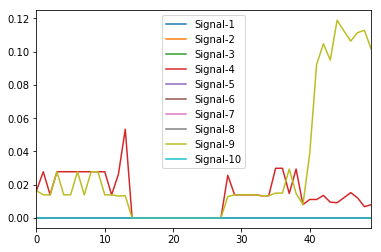

Topics Terms for Samm_xo


Topic Number                    Topic Terms                    
0         1                                       watch, love, time
1         2           good, movie, garee, write, band, london, hope
2         3       land, grouchy, lost, la, halloween, floor, jas...
3         4                                   xxx, nice, xox, tired
4         5       listened, aww, wow, lucky, calling, nite, grad...
5         6                   spoken, hopes, hills, aawww, princess
6         7       man, taylor, jonas, forget, fair, bck, protect...
7         8       remember, congrats, sngs, belong, dnt, voted, ...
8         9       beautiful, madison, loool, sweet, dead, ppl, s...
9        10       huge, bored, omg, target, hour, liz, shw, eva,...
10       11       saynowed, bff, fans, amount, times, wrong, exa...
11       12       hannah, joke, spanish, teacher, live, montana,...
12       13       advert, favour, fricking, ment, girls, attack,...
13       14                                     straight, haha, day
14       15       cnt, song, laptop, tour, sisters, skl, model, ...
15       16       dont, radio, yep, face, album, story, missed, ...
16       17       solo, didnt, twitter, sweetest, helped, person...
17       18       summer, working, settings, guinness, dunno, ra...
18       19                                                     num
19       20       tnt, cut, room, processing, spill, itonlinelol...
20       21                                             ya, science
21       22                                                 gna, ur
22       23       battlefield, crazy, videos, cute, ahah, yeah, ...
23       24       ohh, demi, heard, single, suspense, tv, myspac...
24       25       fake, things, december, year, internet, thursd...

Seeded Terms Per Topic for Samm_xo


Topic Number Seed Terms:Count
0   signal_9         dead:7    
1   signal_4       tired:14

Topics Probabilties Over Time for jaybranch


Time Period         Signal-1  Signal-2   Signal-3   Signal-4   \
0   04/05/2009 - 17/05/2009     0.0    0.0097087  0.0145631  0.0048544   
1   10/05/2009 - 18/05/2009     0.0    0.0051813  0.0051813  0.0051813   
2   10/05/2009 - 18/05/2009     0.0    0.0103627  0.0103627  0.0051813   
3   10/05/2009 - 18/05/2009     0.0    0.0207254  0.0051813  0.0051813   
4   10/05/2009 - 18/05/2009     0.0    0.0155440  0.0155440  0.0155440   
5   10/05/2009 - 22/05/2009     0.0    0.0138249  0.0046083  0.0046083   
6   10/05/2009 - 22/05/2009     0.0    0.0046083  0.0046083  0.0046083   
7   14/05/2009 - 22/05/2009     0.0    0.0048780  0.0097561  0.0048780   
8   14/05/2009 - 22/05/2009     0.0    0.0243902  0.0195122  0.0048780   
9   14/05/2009 - 22/05/2009     0.0    0.0048780  0.0048780  0.0048780   
10  14/05/2009 - 22/05/2009     0.0    0.0048780  0.0048780  0.0048780   
11  17/05/2009 - 22/05/2009     0.0    0.0064516  0.0129032  0.0129032   
12  17/05/2009 - 29/05/2009     0.0    0.0042918  0.1115880  0.0042918   
13  17/05/2009 - 30/05/2009     0.0    0.0035971  0.0971223  0.0143885   
14  18/05/2009 - 31/05/2009     0.0    0.0039216  0.1098039  0.0117647   
15  22/05/2009 - 01/06/2009     0.0    0.0068027  0.0816327  0.0136054   
16  22/05/2009 - 02/06/2009     0.0    0.0056657  0.0878187  0.0141643   
17  22/05/2009 - 03/06/2009     0.0    0.0028249  0.0875706  0.0084746   
18  22/05/2009 - 03/06/2009     0.0    0.0028249  0.0903955  0.0056497   
19  29/05/2009 - 05/06/2009     0.0    0.0260870  0.0985507  0.0057971   
20  29/05/2009 - 06/06/2009     0.0    0.0550239  0.0741627  0.0502392   
21  29/05/2009 - 07/06/2009     0.0    0.0602410  0.0662651  0.0662651   
22  29/05/2009 - 07/06/2009     0.0    0.0642570  0.0602410  0.0702811   
23  29/05/2009 - 07/06/2009     0.0    0.0522088  0.0622490  0.0622490   
24  29/05/2009 - 07/06/2009     0.0    0.0582329  0.0602410  0.0783133   
25  29/05/2009 - 07/06/2009     0.0    0.0662651  0.0742972  0.0542169   
26  30/05/2009 - 07/06/2009     0.0    0.0785714  0.0214286  0.0809524   
27  31/05/2009 - 07/06/2009     0.0    0.0853333  0.0213333  0.0960000   
28  01/06/2009 - 07/06/2009     0.0    0.0962733  0.0217391  0.0962733   
29  02/06/2009 - 15/06/2009     0.0    0.1029412  0.0220588  0.1213235   
30  03/06/2009 - 16/06/2009     0.0    0.1216216  0.0135135  0.1261261   
31  05/06/2009 - 16/06/2009     0.0    0.1266968  0.0180995  0.1493213   
32  05/06/2009 - 16/06/2009     0.0    0.1085973  0.0180995  0.1493213   
33  06/06/2009 - 19/06/2009     0.0    0.1004785  0.0143541  0.1339713   
34  07/06/2009 - 19/06/2009     0.0    0.0588235  0.0147059  0.1029412   
35  15/06/2009 - 19/06/2009     0.0    0.0178571  0.0178571  0.0178571   
36  15/06/2009 - 19/06/2009     0.0    0.0178571  0.0178571  0.0178571   
37  15/06/2009 - 23/06/2009     0.0    0.0317460  0.0158730  0.0158730   

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0873786     0.0       0.0    0.0145631     0.0     
1      0.0    0.0829016     0.0       0.0    0.0051813     0.0     
2      0.0    0.0725389     0.0       0.0    0.0051813     0.0     
3      0.0    0.0725389     0.0       0.0    0.0155440     0.0     
4      0.0    0.0673575     0.0       0.0    0.0051813     0.0     
5      0.0    0.0552995     0.0       0.0    0.0046083     0.0     
6      0.0    0.0691244     0.0       0.0    0.0046083     0.0     
7      0.0    0.0585366     0.0       0.0    0.0048780     0.0     
8      0.0    0.0536585     0.0       0.0    0.0048780     0.0     
9      0.0    0.0585366     0.0       0.0    0.0048780     0.0     
10     0.0    0.0634146     0.0       0.0    0.0146341     0.0     
11     0.0    0.0129032     0.0       0.0    0.0064516     0.0     
12     0.0    0.0042918     0.0       0.0    0.1502146     0.0     
13     0.0    0.0035971     0.0       0.0    0.1510791     0.0     
14     0.0    0.0039216     0.0       0.0    0.1568627     0.0     
15     0.0    0.0238095     0.0   

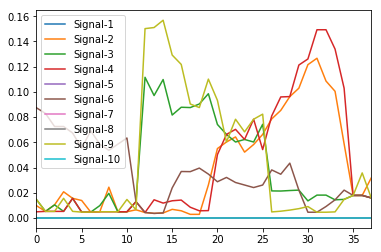

Topics Terms for jaybranch


Topic Number                    Topic Terms                    
0         1       fantastic, shopping, michella, richard, played...
1         2       summer, guess, ian, practically, light, ur, bl...
2         3       funny, dont, simply, helium, awesome, list, li...
3         4       gnr, hangin, tired, newcastle, dancing, defini...
4         5       office, people, peeps, pic, walk, debris, expe...
5         6       week, training, work, shame, phil, lucky, hour...
6         7       scared, geordie, allowed, touch, protein, elec...
7         8       sound, hows, coffee, queen, session, sunshine,...
8         9       supply, doggsy, constant, metro, form, song, b...
9        10       hayleyn, kind, nan, friday, dude, remain, call...
10       11       lad, tweet, problems, honest, running, pleasur...
11       12       busy, joking, business, sentence, thinking, go...
12       13                                        drinker, minutes
13       14       tough, classic, dance, espc, smashing, yonks, ...
14       15       blue, cull, runs, splendid, fair, stuck, sun, ...
15       16       enjoy, uns, love, flight, check, accept, face,...
16       17                        fun, missing, yeah, lol, morning
17       18       knowing, sane, read, days, aye, fans, num, pla...
18       19       good, skool, haha, years, stuff, asleep, quick...
19       20       michelle, poker, bloke, totally, howdy, head, ...
20       21       info, slave, limits, ya, serve, hey, wrong, st...
21       22       bronzed, family, lynette, jesus, banged, chair...
22       23       resist, holiday, plans, sit, shiny, dave, cash...
23       24       engine, fella, great, watching, fire, tw, ride...
24       25       opinions, tasted, feel, tea, japanese, api, ta...

Seeded Terms Per Topic for jaybranch


Topic Number Seed Terms:Count
0   signal_9           kill:1  
1   signal_3        lie_in:14  
2   signal_2     miserable:14  
3   signal_4         tired:28  
4   signal_6         shame:14

Topics Probabilties Over Time for _magic8ball


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
1   11/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
2   13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
3   13/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
4   14/05/2009 - 27/05/2009     0.0       0.0       0.0       0.0       0.0     
5   18/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
6   18/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
7   18/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
8   18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
9   22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
10  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
11  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
12  22/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
13  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
14  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
15  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
16  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
17  27/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
18  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
19  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
20  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
21  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
22  01/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
23  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
24  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
25  04/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
26  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
27  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
28  07/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
29  14/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
30  14/06/2009 - 22/06/2009     0.0       0.0       0.0       0.0       0.0     
31  14/06/2009 - 23/06/2009     0.0       0.0       0.0       0.0       0.0     
32  14/06/2009 - 24/06/2009     0.0       0.0       0.0       0.0       0.0     
33  14/06/2009 - 25/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0     
17     0.0       0.0       0.0       0.0       0.0     
18     0.0       0.0       0.0       0.0       0.0     
19     0.0       0.0       0.0       0.0       0.0   

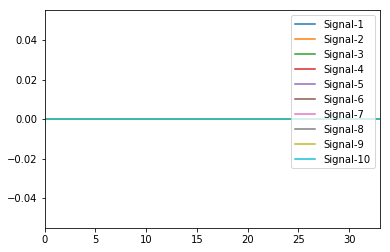

Topics Terms for _magic8ball


Topic Number   Topic Terms  
0         1                signs
1         3                reply
2         5                 rely
3         7             doubtful
4         9                  nan
5        15       decidedly, num
6        16              sources
7        17                 good
8        18                count
9        21              outlook
10       22                point
11       25                doubt

Seeded Terms Per Topic for _magic8ball


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for NathalieCaron


Time Period         Signal-1   Signal-2   Signal-3  Signal-4  \
0   18/04/2009 - 20/04/2009  0.0000000  0.0000000     0.0       0.0     
1   19/04/2009 - 20/04/2009  0.0000000  0.0000000     0.0       0.0     
2   20/04/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
3   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
4   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
5   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
6   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
7   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
8   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
9   03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
10  03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
11  03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
12  03/05/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
13  03/05/2009 - 14/05/2009  0.0000000  0.0000000     0.0       0.0     
14  03/05/2009 - 14/05/2009  0.0000000  0.0000000     0.0       0.0     
15  03/05/2009 - 14/05/2009  0.0000000  0.0000000     0.0       0.0     
16  14/05/2009 - 17/05/2009  0.0312500  0.0312500     0.0       0.0     
17  14/05/2009 - 17/05/2009  0.0156250  0.0156250     0.0       0.0     
18  14/05/2009 - 17/05/2009  0.0156250  0.0468750     0.0       0.0     
19  14/05/2009 - 17/05/2009  0.0156250  0.0156250     0.0       0.0     
20  14/05/2009 - 17/05/2009  0.0156250  0.0156250     0.0       0.0     
21  14/05/2009 - 22/05/2009  0.0140845  0.0281690     0.0       0.0     
22  14/05/2009 - 22/05/2009  0.0140845  0.0140845     0.0       0.0     
23  14/05/2009 - 22/05/2009  0.0140845  0.0281690     0.0       0.0     
24  14/05/2009 - 22/05/2009  0.0140845  0.0140845     0.0       0.0     
..                      ...        ...        ...       ...       ...   
31  22/05/2009 - 01/06/2009  0.0078125  0.0078125     0.0       0.0     
32  22/05/2009 - 02/06/2009  0.0071429  0.0071429     0.0       0.0     
33  22/05/2009 - 03/06/2009  0.0066667  0.0600000     0.0       0.0     
34  22/05/2009 - 04/06/2009  0.0064935  0.0519481     0.0       0.0     
35  29/05/2009 - 05/06/2009  0.0067568  0.0405405     0.0       0.0     
36  29/05/2009 - 06/06/2009  0.0057471  0.0229885     0.0       0.0     
37  29/05/2009 - 07/06/2009  0.0050251  0.0251256     0.0       0.0     
38  29/05/2009 - 07/06/2009  0.0050251  0.0251256     0.0       0.0     
39  29/05/2009 - 07/06/2009  0.0050251  0.0201005     0.0       0.0     
40  29/05/2009 - 07/06/2009  0.0050251  0.0402010     0.0       0.0     
41  29/05/2009 - 07/06/2009  0.0050251  0.0201005     0.0       0.0     
42  30/05/2009 - 07/06/2009  0.0057143  0.0228571     0.0       0.0     
43  31/05/2009 - 07/06/2009  0.0059524  0.0357143     0.0       0.0     
44  01/06/2009 - 07/06/2009  0.0074074  0.0518519     0.0       0.0     
45  02/06/2009 - 15/06/2009  0.0075758  0.0454545     0.0       0.0     
46  03/06/2009 - 16/06/2009  0.0064103  0.0320513     0.0       0.0     
47  04/06/2009 - 17/06/2009  0.0061350  0.0552147     0.0       0.0     
48  05/06/2009 - 18/06/2009  0.0239521  0.0059880     0.0       0.0     
49  06/06/2009 - 19/06/2009  0.0666667  0.0111111     0.0       0.0     
50  07/06/2009 - 20/06/2009  0.1373626  0.0054945     0.0       0.0     
51  15/06/2009 - 21/06/2009  0.1885714  0.0400000     0.0       0.0     
52  15/06/2009 - 22/06/2009  0.1843575  0.0446927     0.0       0.0     
53  15/06/2009 - 23/06/2009  0.1944444  0.0277778     0.0       0.0     
54  15/06/2009 - 23/06/2009  0.1833333  0.0388889     0.0       0.0     
55  15/06/2009 - 25/06/2009  0.1666667  0.0394737     0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0    

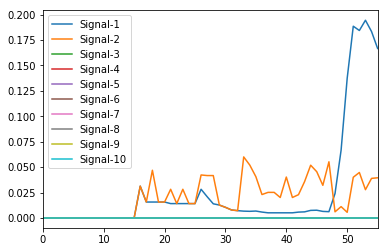

Topics Terms for NathalieCaron


Topic Number                    Topic Terms                    
0         1       raining, color, muscular, traumatized, scarlet...
1         2                  depressed, clouds, disappointed, sleep
2         3       haha, hugh, lol, circling, overcooked, jackman...
3         4       sis, patrick, carradine, sad, david, hat, cont...
4         5                     longer, doctor, work, sky, hope, pm
5         6       mini, series, fingers, fuccckkk, decided, sens...
6         7                                             day, pretty
7         8       huge, ate, return, mushroom, angus, comfort, c...
8         9       kind, shoes, phoenix, favourite, sucks, litter...
9        10                afraid, missed, good, grrr, coming, news
10       11          wendi, yesterday, pics, fun, enjoying, weekend
11       12       loved, btw, yelled, army, tweet, haircut, majo...
12       13       brave, humid, lost, la, choppers, time, grey, ...
13       14       earlier, nonononononono, hospital, asid, years...
14       15       lots, money, awesome, friday, start, withdrawa...
15       16       voyager, head, shock, form, working, read, twi...
16       17         este, crap, hungry, plastic, looked, talk, told
17       18       beautiful, week, great, full, love, faithful, ...
18       19       canvas, cable, space, nan, waiting, naked, aww...
19       20       men, hotties, win, lotery, pound, bloody, weig...
20       21       king, farrah, thing, food, forming, disgusting...
21       22       comment, buy, pounds, portions, prepare, scare...
22       23       scares, theatre, lame, feel, recall, snl, watc...
23       24       sending, singer, worse, retrospect, dance, sig...
24       25           , splitting, rain, thunderstorm, num, fawcett

Seeded Terms Per Topic for NathalieCaron


Topic Number        Seed Terms:Count      
0   signal_1                        bored:15
1   signal_2    depressed:8, disappointed:14

Topics Probabilties Over Time for Quimo


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   17/04/2009 - 19/04/2009  0.0483871     0.0       0.0    0.0564516   
1   18/04/2009 - 01/05/2009  0.0526316     0.0       0.0    0.0877193   
2   19/04/2009 - 02/05/2009  0.0090090     0.0       0.0    0.1081081   
3   01/05/2009 - 03/05/2009  0.0294118     0.0       0.0    0.0147059   
4   01/05/2009 - 04/05/2009  0.0281690     0.0       0.0    0.0140845   
5   01/05/2009 - 04/05/2009  0.0281690     0.0       0.0    0.0281690   
6   01/05/2009 - 04/05/2009  0.0140845     0.0       0.0    0.0140845   
7   01/05/2009 - 04/05/2009  0.0140845     0.0       0.0    0.0140845   
8   01/05/2009 - 04/05/2009  0.0140845     0.0       0.0    0.0140845   
9   01/05/2009 - 09/05/2009  0.0361446     0.0       0.0    0.0240964   
10  01/05/2009 - 10/05/2009  0.0370370     0.0       0.0    0.0444444   
11  01/05/2009 - 11/05/2009  0.0359281     0.0       0.0    0.0479042   
12  01/05/2009 - 11/05/2009  0.0538922     0.0       0.0    0.0359281   
13  01/05/2009 - 11/05/2009  0.0538922     0.0       0.0    0.0299401   
14  01/05/2009 - 11/05/2009  0.0419162     0.0       0.0    0.0359281   
15  02/05/2009 - 11/05/2009  0.0454545     0.0       0.0    0.0194805   
16  03/05/2009 - 16/05/2009  0.0437500     0.0       0.0    0.0437500   
17  04/05/2009 - 17/05/2009  0.0496894     0.0       0.0    0.0372671   
18  09/05/2009 - 18/05/2009  0.0432099     0.0       0.0    0.0185185   
19  09/05/2009 - 18/05/2009  0.0432099     0.0       0.0    0.0370370   
20  09/05/2009 - 18/05/2009  0.0555556     0.0       0.0    0.0432099   
21  09/05/2009 - 18/05/2009  0.0308642     0.0       0.0    0.0493827   
22  09/05/2009 - 18/05/2009  0.0432099     0.0       0.0    0.0432099   
23  10/05/2009 - 18/05/2009  0.0333333     0.0       0.0    0.0466667   
24  11/05/2009 - 18/05/2009  0.0408163     0.0       0.0    0.0408163   
..                      ...        ...       ...       ...        ...   
31  18/05/2009 - 31/05/2009  0.0106952     0.0       0.0    0.0213904   
32  26/05/2009 - 01/06/2009  0.0174672     0.0       0.0    0.0131004   
33  26/05/2009 - 02/06/2009  0.0109091     0.0       0.0    0.0072727   
34  26/05/2009 - 02/06/2009  0.0072727     0.0       0.0    0.0290909   
35  26/05/2009 - 02/06/2009  0.0109091     0.0       0.0    0.0363636   
36  26/05/2009 - 05/06/2009  0.0220994     0.0       0.0    0.0303867   
37  26/05/2009 - 06/06/2009  0.0084567     0.0       0.0    0.0528541   
38  26/05/2009 - 07/06/2009  0.0078125     0.0       0.0    0.0371094   
39  26/05/2009 - 07/06/2009  0.0117188     0.0       0.0    0.0507812   
40  28/05/2009 - 07/06/2009  0.0142857     0.0       0.0    0.0530612   
41  28/05/2009 - 07/06/2009  0.0081633     0.0       0.0    0.0326531   
42  29/05/2009 - 07/06/2009  0.0207900     0.0       0.0    0.0332640   
43  30/05/2009 - 07/06/2009  0.0161663     0.0       0.0    0.0461894   
44  31/05/2009 - 07/06/2009  0.0201005     0.0       0.0    0.0477387   
45  01/06/2009 - 07/06/2009  0.0141243     0.0       0.0    0.0338983   
46  02/06/2009 - 15/06/2009  0.0187500     0.0       0.0    0.0375000   
47  05/06/2009 - 15/06/2009  0.0328467     0.0       0.0    0.0766423   
48  05/06/2009 - 17/06/2009  0.0398551     0.0       0.0    0.0217391   
49  05/06/2009 - 18/06/2009  0.0286738     0.0       0.0    0.0430108   
50  06/06/2009 - 19/06/2009  0.0350000     0.0       0.0    0.0050000   
51  07/06/2009 - 20/06/2009  0.0526316     0.0       0.0    0.0105263   
52  15/06/2009 - 20/06/2009  0.0892857     0.0       0.0    0.0535714   
53  15/06/2009 - 20/06/2009  0.0892857     0.0       0.0    0.0178571   
54  15/06/2009 - 20/06/2009  0.0714286     0.0       0.0    0.0357143   
55  15/06/2009 - 24/06/2009  0.0689655     0.0       0.0    0.0517241   

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0    

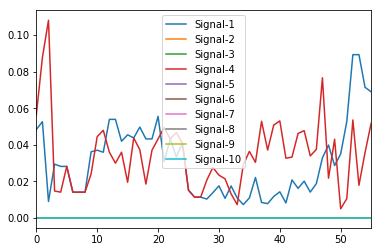

Topics Terms for Quimo


Topic Number                    Topic Terms                    
0         1             insensitive, family, love, feel, pg, follow
1         2                                       birthday, brother
2         3                                        awww, good, wait
3         4                              ya, omj, great, num, tired
4         5       dl, yay, working, boys, fish, irvine, baby, fi...
5         6                  knight, twitter, yeah, ur, joe, dreams
6         7       managed, pin, signs, twisted, bring, skipped, ...
7         8       sheep, profile, vegas, tease, started, tea, ea...
8         9       vids, busy, danced, crowd, song, wheee, questi...
9        10       dad, friday, copy, watching, positive, awesome...
10       11       taste, son, pops, chat, thud, nk, tv, broccoli...
11       12       entourage, played, intro, children, woot, cong...
12       13       shop, purchase, safe, grrr, nan, winner, june,...
13       14       work, ice, morning, fun, green, smile, outie, ...
14       15       replied, thread, contest, chosen, hun, wifebea...
15       16       sticking, dont, slaw, almonds, vote, singing, ...
16       17       enjoy, cute, point, unmentionable, sweet, scot...
17       18       cry, donnie, idea, brought, bdays, coldstone, ...
18       19                                   shirt, lol, patiently
19       20       summer, concert, mochi, house, twist, mangos, ...
20       21       embarass, heart, missed, , tonight, tour, truc...
21       22       sound, play, nominate, nkotb, bed, spanish, wa...
22       23       alot, selling, pain, infact, bb, pic, haha, ha...
23       24       laptop, midnight, burger, books, bhs, messed, ...
24       25                                       salt, hear, happy

Seeded Terms Per Topic for Quimo


Topic Number Seed Terms:Count
0   signal_1    insensitive:14 
1   signal_4           tired:6

Topics Probabilties Over Time for DsBabyGirl


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   18/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   19/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
2   20/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
3   10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
4   10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
5   10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
6   10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
7   10/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
8   10/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
9   10/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
10  10/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
11  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
12  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
13  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
14  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
15  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
16  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
17  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  18/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
22  18/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
23  18/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
24  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
25  29/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
26  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
27  29/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
28  29/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
29  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
30  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
31  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
32  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
33  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
34  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
35  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
36  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
37  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
38  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
40  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
41  04/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
42  05/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
43  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
44  07/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
45  15/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
46  15/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
47  15/06/2009 - 23/06/2009     0.0       0.0       0.0       0.0       0.0     
48  15/06/2009 - 23/06/2009     0.0     

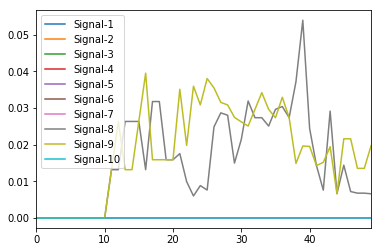

Topics Terms for DsBabyGirl


Topic Number                    Topic Terms                    
0         1       ass, sir, ugh, excited, friday, idea, wh, air,...
1         2                                heard, girl, twits, nite
2         3       mornin, sum, resorted, cuz, holmdel, num, damn...
3         4       hit, jason, mess, text, tweet, mandy, socks, j...
4         5                         seein, gettin, sept, urself, ur
5         6                       messed, crazy, work, hey, twitter
6         7       freezin, fit, thing, beat, dime, nan, schedule...
7         8       closer, coloring, nervous, girls, morning, won...
8         9       love, dying, doin, wassup, times, hell, amanda...
9        10       jones, spy, sweetie, cried, loved, cherry, fis...
10       11       duty, school, hour, band, big, moved, hours, h...
11       12                                              ya, girlie
12       13       comment, heart, awesome, pic, asleep, jesse, m...
13       14       sacrifices, northeast, loss, tv, cry, yeah, ig...
14       15       rats, soakin, hair, fine, find, runaway, blow,...
15       16       replied, sell, carpool, hug, group, wore, chil...
16       17       , cute, family, mini, nkotb, makin, rest, grrr...
17       18                   ready, heather, kickin, babes, restin
18       19       leave, great, convenient, hairs, lbs, lol, lat...
19       20       updates, fri, paid, plane, dramamine, passport...
20       21       good, omg, sooo, sad, reason, plan, go_to_bed,...
21       22       eyebrows, dm, ooops, nooo, wet, kami, uhhh, se...
22       23       fly, gray, leavin, ohh, missed, luv, condolenc...
23       24       started, tix, feel, safe, ryan, prepared, gift...
24       25       stil, buy, outta, hotlanta, house, jeans, loga...

Seeded Terms Per Topic for DsBabyGirl


Topic Number  Seed Terms:Count 
0   signal_9    hell:14, dying:14
1   signal_8           nervous:14

Topics Probabilties Over Time for primatage


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   20/04/2009 - 03/05/2009     0.0    0.0357143     0.0       0.0     
1   21/04/2009 - 04/05/2009     0.0    0.0166667     0.0       0.0     
2   03/05/2009 - 04/05/2009     0.0    0.0000000     0.0       0.0     
3   03/05/2009 - 04/05/2009     0.0    0.0000000     0.0       0.0     
4   03/05/2009 - 04/05/2009     0.0    0.0000000     0.0       0.0     
5   03/05/2009 - 04/05/2009     0.0    0.0000000     0.0       0.0     
6   03/05/2009 - 04/05/2009     0.0    0.0000000     0.0       0.0     
7   03/05/2009 - 10/05/2009     0.0    0.0162602     0.0       0.0     
8   03/05/2009 - 11/05/2009     0.0    0.0155039     0.0       0.0     
9   03/05/2009 - 11/05/2009     0.0    0.0155039     0.0       0.0     
10  03/05/2009 - 13/05/2009     0.0    0.0143885     0.0       0.0     
11  03/05/2009 - 13/05/2009     0.0    0.0071942     0.0       0.0     
12  03/05/2009 - 13/05/2009     0.0    0.0359712     0.0       0.0     
13  03/05/2009 - 13/05/2009     0.0    0.0143885     0.0       0.0     
14  04/05/2009 - 17/05/2009     0.0    0.0240000     0.0       0.0     
15  10/05/2009 - 18/05/2009     0.0    0.0454545     0.0       0.0     
16  10/05/2009 - 18/05/2009     0.0    0.0606061     0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0    0.0530303     0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0    0.0454545     0.0       0.0     
19  10/05/2009 - 22/05/2009     0.0    0.0592593     0.0       0.0     
20  10/05/2009 - 22/05/2009     0.0    0.0444444     0.0       0.0     
21  11/05/2009 - 22/05/2009     0.0    0.0895522     0.0       0.0     
22  13/05/2009 - 22/05/2009     0.0    0.0819672     0.0       0.0     
23  13/05/2009 - 26/05/2009     0.0    0.0923077     0.0       0.0     
24  17/05/2009 - 26/05/2009     0.0    0.1090909     0.0       0.0     
25  17/05/2009 - 26/05/2009     0.0    0.0909091     0.0       0.0     
26  17/05/2009 - 29/05/2009     0.0    0.0574713     0.0       0.0     
27  17/05/2009 - 30/05/2009     0.0    0.0362319     0.0       0.0     
28  18/05/2009 - 31/05/2009     0.0    0.0294118     0.0       0.0     
29  22/05/2009 - 01/06/2009     0.0    0.0398010     0.0       0.0     
30  22/05/2009 - 02/06/2009     0.0    0.0039062     0.0       0.0     
31  22/05/2009 - 03/06/2009     0.0    0.0262295     0.0       0.0     
32  22/05/2009 - 04/06/2009     0.0    0.0062500     0.0       0.0     
33  26/05/2009 - 04/06/2009     0.0    0.0094637     0.0       0.0     
34  26/05/2009 - 06/06/2009     0.0    0.0264706     0.0       0.0     
35  26/05/2009 - 07/06/2009     0.0    0.0057803     0.0       0.0     
36  26/05/2009 - 07/06/2009     0.0    0.0057803     0.0       0.0     
37  29/05/2009 - 07/06/2009     0.0    0.0058480     0.0       0.0     
38  29/05/2009 - 07/06/2009     0.0    0.0087719     0.0       0.0     
39  29/05/2009 - 07/06/2009     0.0    0.0029240     0.0       0.0     
40  30/05/2009 - 07/06/2009     0.0    0.0064516     0.0       0.0     
41  31/05/2009 - 07/06/2009     0.0    0.0077220     0.0       0.0     
42  01/06/2009 - 07/06/2009     0.0    0.0135747     0.0       0.0     
43  02/06/2009 - 15/06/2009     0.0    0.0045249     0.0       0.0     
44  03/06/2009 - 16/06/2009     0.0    0.0053763     0.0       0.0     
45  04/06/2009 - 17/06/2009     0.0    0.0070922     0.0       0.0     
46  06/06/2009 - 17/06/2009     0.0    0.0079365     0.0       0.0     
47  06/06/2009 - 17/06/2009     0.0    0.0158730     0.0       0.0     
48  07/06/2009 - 20/06/2009     0.0    0.0096154     0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0178571     0.0       0.0    0.0714286     0.0     
1      0.0    0.0333333     0.0       0.0    0.0333333     0.0     
2      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
3      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
4      0.0    0.0000000     0.0       0.0    0.0000000     0.0     


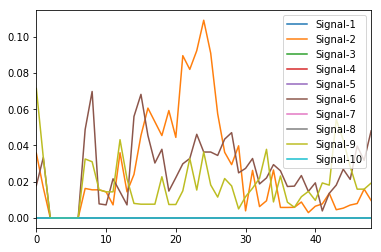

Topics Terms for primatage


Topic Number                    Topic Terms                    
0         1              week, popped, stuck, feel, experience, lil
1         2       coffee, hehe, stuff, time, disappointed, frust...
2         3                                              yeah, glad
3         4       term, cruising, longer, lo, vacuum, horrible, ...
4         5       ikea, huge, story, apocalypse, office, awesome...
5         6                  shift, retard, worst, hey, unnecessary
6         7       fool, bags, implies, internets, ya, coding, co...
7         8              comeback, draw, ridiculawesome, lol, night
8         9                                              hell, hear
9        10                                                     num
10       11                                    things, haha, sooner
11       12       learning, people, process, functional, leads, ...
12       13       osx, btw, hashtags, org, follow, funny, mutual...
13       14       load, newest, sucks, agreed, tonight, keyboard...
14       15       kind, fee, actual, reception, deck, shenanigan...
15       16       insane, crowd, dangerously, attract, find, afr...
16       17       partial, asap, brewing, send, start, putty, mi...
17       18       forget, johnny, photo, installed, pack, freaki...
18       19                                       work, days, years
19       20       limitations, wide, guess, pretty, sweet, pot, ...
20       21       deal, sad, odd, chrome, stayed, late, waiting,...
21       22       thar, crap, slept, list, miraculous, love, las...
22       23       beautiful, israel, outage, worse, tweeting, co...
23       24       sound, oo, lurkin, remember, business, club, p...
24       25       hours, great, good, handle, snagged, omg, love...

Seeded Terms Per Topic for primatage


Topic Number           Seed Terms:Count         
0   signal_9                               hell:34
1   signal_2        disappointed:14, frustrated:14
2   signal_6    retard:14, worst:6, unnecessary:14

Topics Probabilties Over Time for Leanne0710


Time Period         Signal-1   Signal-2  Signal-3   Signal-4  \
0   30/05/2009 - 07/06/2009  0.0389610     0.0    0.0705009     0.0     
1   01/06/2009 - 07/06/2009  0.0312500     0.0    0.0451389     0.0     
2   01/06/2009 - 07/06/2009  0.0381944     0.0    0.0590278     0.0     
3   02/06/2009 - 15/06/2009  0.0481283     0.0    0.0534759     0.0     
4   03/06/2009 - 15/06/2009  0.0312500     0.0    0.0250000     0.0     
5   04/06/2009 - 15/06/2009  0.0443038     0.0    0.0189873     0.0     
6   05/06/2009 - 15/06/2009  0.0387097     0.0    0.0129032     0.0     
7   06/06/2009 - 19/06/2009  0.0544218     0.0    0.0272109     0.0     
8   07/06/2009 - 20/06/2009  0.0468750     0.0    0.0156250     0.0     
9   15/06/2009 - 20/06/2009  0.0000000     0.0    0.0000000     0.0     
10  15/06/2009 - 22/06/2009  0.0277778     0.0    0.0555556     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0       0.0       0.0    0.0333952  0.0445269     0.0     
1      0.0       0.0       0.0    0.0416667  0.0555556     0.0     
2      0.0       0.0       0.0    0.0416667  0.0659722     0.0     
3      0.0       0.0       0.0    0.0427807  0.0588235     0.0     
4      0.0       0.0       0.0    0.0312500  0.0562500     0.0     
5      0.0       0.0       0.0    0.0189873  0.0569620     0.0     
6      0.0       0.0       0.0    0.0258065  0.0516129     0.0     
7      0.0       0.0       0.0    0.0204082  0.0544218     0.0     
8      0.0       0.0       0.0    0.0312500  0.0156250     0.0     
9      0.0       0.0       0.0    0.0000000  0.0000000     0.0     
10     0.0       0.0       0.0    0.0277778  0.0138889     0.0

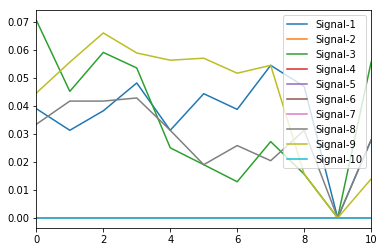

Topics Terms for Leanne0710


Topic Number                    Topic Terms                    
0         1       town, week, account, emma, boring, ahah, letdo...
1         2       tickets, sneezi, skint, yup, ages, meaning, ta...
2         3       comment, maxine, ahahah, bck, yesterday, celeb...
3         4       great, people, paid, twitters, twitter, trishs...
4         5       tonight, noo, dance, soo, brill, thing, daft, ...
5         6       duno, harsh, dyin, fone, youtube, go_to_bed, s...
6         7       dreadin, buy, poster, tomor, nicest, peein, st...
7         8       boyles, mood, aww, scaredi, usual, time, maxin...
8         9       full, tweeting, hasty, die, earlier, fearsss, ...
9        10       rapid, shel, aunty, replyed, asleep, nicole, l...
10       11       , yeh, paranoid, av, moneth, anooo, dnt, doesn...
11       12       hah, boy, becky, love, tomoro, trampoline, evi...
12       13       canada, handcatch, eyes, omg, dictionary, feel...
13       14       coment, ladies, workin, dont, fright, aye, uv,...
14       15       jelous, davina, comented, ano, kellys, hahahha...
15       16       aha, wee, wanty, gettin, iv, unbore, awk, shou...
16       17       xxx, sleepin, samsung, amuse, cry, mind, fell,...
17       18       aa, ive, nopeee, bed, summer, drink, thurs, wo...
18       19       sadly, fit, gay, tht, sad, thought, lolol, tim...
19       20       ozzy, funny, pervin, picture, ment, smooth, ha...
20       21       dad, michelle, pyjamas, adams, nan, heard, mum...
21       22       point, chargin, replying, drunk, gigglin, god,...
22       23       dreading, sister, mite, upset, tocco, pure, hi...
23       24       good, bully, bb, marley, kitty, upload, hour, ...
24       25       sound, explaining, alex, tired, sittin, haah, ...

Seeded Terms Per Topic for Leanne0710


Topic Number      Seed Terms:Count    
0   signal_1                    boring:3
1   signal_8                  annoying:4
2   signal_3               all_nighter:1
3   signal_2    dreading:1, frustrated:1
4   signal_9                      die:16

Topics Probabilties Over Time for QueenBxoxo


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   02/05/2009 - 14/05/2009     0.0       0.0    0.0353982     0.0     
1   10/05/2009 - 14/05/2009     0.0       0.0    0.0091743     0.0     
2   10/05/2009 - 14/05/2009     0.0       0.0    0.0183486     0.0     
3   10/05/2009 - 18/05/2009     0.0       0.0    0.0303030     0.0     
4   10/05/2009 - 18/05/2009     0.0       0.0    0.0181818     0.0     
5   10/05/2009 - 18/05/2009     0.0       0.0    0.0121212     0.0     
6   10/05/2009 - 18/05/2009     0.0       0.0    0.0060606     0.0     
7   10/05/2009 - 22/05/2009     0.0       0.0    0.0070175     0.0     
8   10/05/2009 - 22/05/2009     0.0       0.0    0.0245614     0.0     
9   14/05/2009 - 22/05/2009     0.0       0.0    0.0328467     0.0     
10  14/05/2009 - 22/05/2009     0.0       0.0    0.0218978     0.0     
11  14/05/2009 - 22/05/2009     0.0       0.0    0.0036496     0.0     
12  14/05/2009 - 22/05/2009     0.0       0.0    0.0328467     0.0     
13  18/05/2009 - 22/05/2009     0.0       0.0    0.0149254     0.0     
14  18/05/2009 - 29/05/2009     0.0       0.0    0.0135747     0.0     
15  18/05/2009 - 29/05/2009     0.0       0.0    0.0045249     0.0     
16  18/05/2009 - 29/05/2009     0.0       0.0    0.0135747     0.0     
17  22/05/2009 - 01/06/2009     0.0       0.0    0.0214592     0.0     
18  22/05/2009 - 02/06/2009     0.0       0.0    0.0129032     0.0     
19  22/05/2009 - 03/06/2009     0.0       0.0    0.0469136     0.0     
20  22/05/2009 - 03/06/2009     0.0       0.0    0.0271605     0.0     
21  29/05/2009 - 03/06/2009     0.0       0.0    0.0491228     0.0     
22  29/05/2009 - 03/06/2009     0.0       0.0    0.0491228     0.0     
23  29/05/2009 - 03/06/2009     0.0       0.0    0.0491228     0.0     
24  29/05/2009 - 03/06/2009     0.0       0.0    0.0385965     0.0     
25  29/05/2009 - 03/06/2009     0.0       0.0    0.0350877     0.0     
26  29/05/2009 - 03/06/2009     0.0       0.0    0.0315789     0.0     
27  29/05/2009 - 03/06/2009     0.0       0.0    0.0456140     0.0     
28  01/06/2009 - 03/06/2009     0.0       0.0    0.0301887     0.0     
29  01/06/2009 - 03/06/2009     0.0       0.0    0.0415094     0.0     
30  01/06/2009 - 03/06/2009     0.0       0.0    0.0452830     0.0     
31  02/06/2009 - 15/06/2009     0.0       0.0    0.0614754     0.0     
32  03/06/2009 - 16/06/2009     0.0       0.0    0.0611111     0.0     
33  15/06/2009 - 17/06/2009     0.0       0.0    0.0152672     0.0     
34  15/06/2009 - 18/06/2009     0.0       0.0    0.0370370     0.0     
35  15/06/2009 - 19/06/2009     0.0       0.0    0.0351759     0.0     
36  15/06/2009 - 19/06/2009     0.0       0.0    0.0402010     0.0     
37  15/06/2009 - 21/06/2009     0.0       0.0    0.0436893     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0       0.0     
17     0.0  

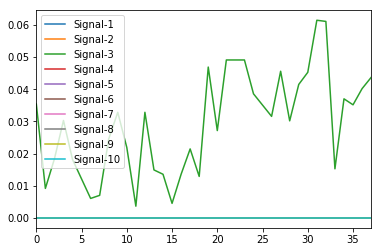

Topics Terms for QueenBxoxo


Topic Number                    Topic Terms                    
0         2                                                     num
1         3                            awake, guy, good, okayy, wee
2         4                                   ooo, cry, stuff, face
3         5       oo, noo, ny, aye, asos, ffs, lunch, aaah, minutes
4         7                                                     lol
5         8       thankgod, southampton, shut, ordered, deaaad, ...
6         9       rebekah, weight, feel, kisses, rip, bleh, size...
7        10                                   fine, awwh, eat, dont
8        11       cute, auntie, twitter, soo, sad, riight, satur...
9        12           love, office, eaaat, text, whyy, jus, alright
10       13           fs, thought, expect, eaten, spike, baby, hate
11       14       maggie, thiiink, family, bloody, shhush, years...
12       15                                                   spain
13       16       ayee, fucking, aah, bbq, folks, hahaa, folk, wait
14       17       shaheen, fantastic, stavros, monday, julian, s...
15       18       shop, burning, watches, peaches, doesnt, sound...
16       19       pre, cuuute, btw, set, money, site, shite, sto...
17       20       cancelling, earl, downloading, room, sims, gam...
18       21       eh, mind, year, iwyimrn, fuck, tablets, sorted...
19       22       , meerkat, force, preggers, topics, sleeping, ...
20       23                                                  fucked
21       24       scanning, mums, terrorists, sleeepy, arsed, na...
22       25       hot, ooh, phone, amazing, kiss, yoou, usual, g...

Seeded Terms Per Topic for QueenBxoxo


Topic Number Seed Terms:Count
0   signal_3       awake:14

Topics Probabilties Over Time for enamoredsoul


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   18/04/2009 - 19/04/2009     0.0       0.0       0.0    0.0123457   
1   19/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0000000   
2   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
3   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
4   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
5   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
6   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
7   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
8   02/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
9   02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0158730   
10  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0158730   
11  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0158730   
12  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0317460   
13  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0158730   
14  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0317460   
15  03/05/2009 - 16/05/2009     0.0       0.0       0.0    0.1058824   
16  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.1780822   
17  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.1095890   
18  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.1369863   
19  10/05/2009 - 17/05/2009     0.0       0.0       0.0    0.1369863   
20  10/05/2009 - 21/05/2009     0.0       0.0       0.0    0.1855670   
21  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.1000000   
22  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0928571   
23  16/05/2009 - 22/05/2009     0.0       0.0       0.0    0.1007752   
24  16/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0775194   
25  16/05/2009 - 26/05/2009     0.0       0.0       0.0    0.1036585   
26  16/05/2009 - 26/05/2009     0.0       0.0       0.0    0.0914634   
27  16/05/2009 - 28/05/2009     0.0       0.0       0.0    0.0974359   
28  16/05/2009 - 29/05/2009     0.0       0.0       0.0    0.0635452   
29  17/05/2009 - 30/05/2009     0.0       0.0       0.0    0.0402844   
30  21/05/2009 - 31/05/2009     0.0       0.0       0.0    0.0357143   
31  21/05/2009 - 01/06/2009     0.0       0.0       0.0    0.0272315   
32  21/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0281879   
33  21/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0228717   
34  22/05/2009 - 04/06/2009     0.0       0.0       0.0    0.0290771   
35  26/05/2009 - 05/06/2009     0.0       0.0       0.0    0.0291878   
36  26/05/2009 - 06/06/2009     0.0       0.0       0.0    0.0227001   
37  26/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0265589   

    Signal-5   Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0123457     0.0       0.0       0.0    0.0123457     0.0     
1   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
2   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
3   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
4   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
5   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
6   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
7   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
8   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
9   0.0158730     0.0       0.0       0.0    0.0158730     0.0     
10  0.0158730     0.0       0.0       0.0    0.0158730     0.0     
11  0.0158730     0.0       0.0       0.0    0.0158730     0.0     
12  0.0158730     0.0       0.0       0.0    0.0158730     0.0     
13  0.0158730     0.0       0.0       0.0    0.0158730     0.0     
14  0.0158730     0.0       0.0       0.0    0.0158730     0.0     
15  0.0117647     0.0       0.0       0.0    0.0235294     0.0     
16  0.0136986     0.0       0.0       0.0   

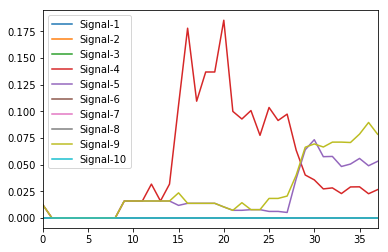

Topics Terms for enamoredsoul


Topic Number                    Topic Terms                    
0         1       outta, ahh, pic, errands, rant, kanye, bowlers...
1         2       , stress, supportive, family, ahead, song, abs...
2         3       crazy, gardening, corps, color, weather, resul...
3         4       beautiful, upto, babe, exhausted, exhausting, ...
4         5       heart, unwind, cocky, apologize, tomorrow, est...
5         6       muah, sack, bears, zones, hug, raises, appreci...
6         7       reggae, play, yay, lotta, started, spring, del...
7         8       lawyer, dance, recognize, awesome, happenin, a...
8         9       meant, share, actress, ppl, randomly, amusemen...
9        10       enjoy, altho, rounded, ecclectic, acted, talki...
10       11       satisfy, video, sean, quality, ima, rancho, da...
11       12       blip, kidney, capacity, puts, tutor, shit, quo...
12       13       control, cute, ladies, love, twitter, deep, mo...
13       14       supreme, mom, intelligence, listening, ajaedan...
14       15       taste, mind, check, floor, storage, cali, foun...
15       16       dont, years, hair, marley, subject, caribbean,...
16       17       orrr, pleasure, takes, played, barenaked, swee...
17       18       cheryl, good, practicing, gyn, poetry, num, se...
18       19       sharing, mothers, excellent, content, tweeps, ...
19       20            hon, hey, hugs, problem, cough, easier, wait
20       21       airbus, buy, dominique, thing, howz, things, t...
21       22       interacting, kudos, missed, listen, interacted...
22       23       rooting, sigh, yeah, dahling, awww, vibrant, b...
23       24       pledge, people, owe, ted, encouraging, actions...
24       25       bomb, clinicals, dozed, doctor, interesting, r...

Seeded Terms Per Topic for enamoredsoul


Topic Number       Seed Terms:Count     
0   signal_9                       death:2
1   signal_5                        fat:10
2   signal_4    exhausted:14, exhausting:4

Topics Probabilties Over Time for effingcards


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   07/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
2   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
3   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
4   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
5   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
6   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
7   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
8   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
9   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
10  18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
11  18/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
12  19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
13  20/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
14  21/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
15  01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
16  01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
17  01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
18  01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
19  01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
20  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
21  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
22  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
23  01/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
24  01/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
25  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
26  03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
27  10/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
28  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
29  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
30  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
31  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
32  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
33  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
34  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
35  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
36  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
37  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
38  16/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
39  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
40  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0      

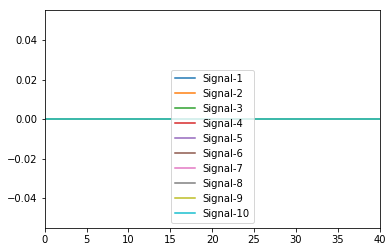

Topics Terms for effingcards


Topic Number                    Topic Terms                    
0         1                                                    good
1         2                                           friends, send
2         3                                            postcrossing
3         4                   haaa, word, twitter, ebay, init, hold
4         6                sending, sofa, ko, sale, night, addicted
5         7              farking, buy, nan, yeah, site, probs, glad
6         9                                               postcards
7        10                                                   group
8        12                                              crazy, eff
9        13       omg, promo, marketing, mention, secret, vote, ...
10       14                                               mum, join
11       15                                                     hmm
12       16                                                facebook
13       17                                           beach, effing
14       21                                        effer, xxx, ahhh
15       22                               food, love, greeting, bbq
16       23                                                 wow, xx
17       24                                                   bring
18       25                                          cards, totally

Seeded Terms Per Topic for effingcards


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for hollyalyxfinch


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   07/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
1   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
2   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
3   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
4   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
5   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
6   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
7   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
8   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
9   18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
10  18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
11  18/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
12  20/04/2009 - 02/05/2009     0.0    0.0000000     0.0    0.0000000   
13  20/04/2009 - 03/05/2009     0.0    0.0000000     0.0    0.0000000   
14  02/05/2009 - 04/05/2009     0.0    0.0144928     0.0    0.0144928   
15  02/05/2009 - 04/05/2009     0.0    0.0144928     0.0    0.0144928   
16  02/05/2009 - 04/05/2009     0.0    0.0144928     0.0    0.0144928   
17  02/05/2009 - 04/05/2009     0.0    0.0144928     0.0    0.0144928   
18  02/05/2009 - 04/05/2009     0.0    0.0144928     0.0    0.0144928   
19  02/05/2009 - 04/05/2009     0.0    0.0144928     0.0    0.0289855   
20  02/05/2009 - 10/05/2009     0.0    0.0800000     0.0    0.0400000   
21  02/05/2009 - 10/05/2009     0.0    0.0666667     0.0    0.0266667   
22  02/05/2009 - 10/05/2009     0.0    0.0533333     0.0    0.0666667   
23  02/05/2009 - 10/05/2009     0.0    0.0800000     0.0    0.0266667   
24  02/05/2009 - 14/05/2009     0.0    0.0566038     0.0    0.0188679   
..                      ...       ...        ...       ...        ...   
42  22/05/2009 - 01/06/2009     0.0    0.0039370     0.0    0.0196850   
43  22/05/2009 - 02/06/2009     0.0    0.0108303     0.0    0.0324910   
44  22/05/2009 - 03/06/2009     0.0    0.0071429     0.0    0.0071429   
45  22/05/2009 - 03/06/2009     0.0    0.0035714     0.0    0.0107143   
46  23/05/2009 - 05/06/2009     0.0    0.0069686     0.0    0.0139373   
47  29/05/2009 - 06/06/2009     0.0    0.0058997     0.0    0.0058997   
48  29/05/2009 - 07/06/2009     0.0    0.0154525     0.0    0.0066225   
49  29/05/2009 - 07/06/2009     0.0    0.0176600     0.0    0.0044150   
50  29/05/2009 - 07/06/2009     0.0    0.0154525     0.0    0.0044150   
51  29/05/2009 - 07/06/2009     0.0    0.0132450     0.0    0.0176600   
52  29/05/2009 - 07/06/2009     0.0    0.0132450     0.0    0.0132450   
53  30/05/2009 - 07/06/2009     0.0    0.0120192     0.0    0.0192308   
54  31/05/2009 - 07/06/2009     0.0    0.0165746     0.0    0.0138122   
55  01/06/2009 - 07/06/2009     0.0    0.0174927     0.0    0.0058309   
56  02/06/2009 - 15/06/2009     0.0    0.0221402     0.0    0.0110701   
57  03/06/2009 - 16/06/2009     0.0    0.0277778     0.0    0.0039683   
58  05/06/2009 - 17/06/2009     0.0    0.0304183     0.0    0.0304183   
59  05/06/2009 - 18/06/2009     0.0    0.0249110     0.0    0.0177936   
60  06/06/2009 - 19/06/2009     0.0    0.0287770     0.0    0.0611511   
61  07/06/2009 - 20/06/2009     0.0    0.0301887     0.0    0.0452830   
62  15/06/2009 - 20/06/2009     0.0    0.0331126     0.0    0.0463576   
63  15/06/2009 - 22/06/2009     0.0    0.0394737     0.0    0.0263158   
64  15/06/2009 - 23/06/2009     0.0    0.0348837     0.0    0.0697674   
65  15/06/2009 - 23/06/2009     0.0    0.0406977     0.0    0.0348837   
66  15/06/2009 - 25/06/2009     0.0    0.0285714     0.0    0.0457143   

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9   Signal-10  
0      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
1      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
2      0

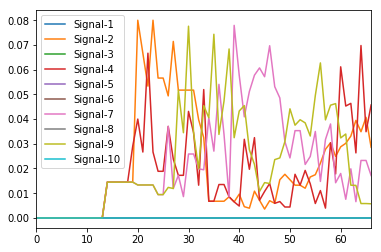

Topics Terms for hollyalyxfinch


Topic Number                    Topic Terms                    
0         1       warmed, specially, pointing, taste, scared, ch...
1         2                  agony, nan, night, weird, dream, hates
2         3       shop, mini, smaller, izer, losing, yeah, feet,...
3         4                                          working, tired
4         5       website, feel, app, deep, finally, yoshi, ui, ...
5         6       thinner, aerial, number, tvs, tonight, cold, m...
6         7         lamb, distracted, lol, note, telly, bit, smoked
7         8       ad, heard, japan, happen, huge, leading, ting,...
8         9       yay, haha, drama, hear, pets, hell, tomorrow, ...
9        10       cute, head, mood, lots, money, thing, birthday...
10       11       dont, lack, covers, nesquik, arg, ps, tv, char...
11       12                                            num, feature
12       13        lost, followers, rabbit, screengrab, eated, hope
13       14       aha, simple, mentioned, mazuma, cases, deliver...
14       15       pro, sooo, api, tempted, cups, hate, guess, dr...
15       16       chopped, ive, bugger, love, , enjoy, idea, sad...
16       17                                                      aw
17       18       week, messed, looong, played, sitting, turns, ...
18       19       load, ugh, melts, kimberlys, sob, mates, evide...
19       20       bike, teasing, rest, children, helmet, horse, ...
20       21       mums, roadshow, laptop, vu, immensely, girl, f...
21       22       comment, btw, niiight, blogger, twitterbox, gr...
22       23       bridge, square, tmobile, monday, dvds, message...
23       24       younger, actual, room, older, nicked, tweet, a...
24       25       crazy, wifi, eaten, suddenly, romantically, so...

Seeded Terms Per Topic for hollyalyxfinch


Topic Number  Seed Terms:Count 
0   signal_9    drama:14, hell:14
1   signal_2              agony:7
2   signal_4             tired:21
3   signal_7        distracted:14

Topics Probabilties Over Time for WTFJAY


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   18/04/2009 - 01/05/2009     0.0       0.0    0.0084034     0.0     
1   19/04/2009 - 01/05/2009     0.0       0.0    0.0088496     0.0     
2   20/04/2009 - 03/05/2009     0.0       0.0    0.0178571     0.0     
3   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
4   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
5   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
6   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
7   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
8   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
9   01/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
10  01/05/2009 - 11/05/2009     0.0       0.0    0.0000000     0.0     
11  01/05/2009 - 11/05/2009     0.0       0.0    0.0000000     0.0     
12  01/05/2009 - 13/05/2009     0.0       0.0    0.0181818     0.0     
13  01/05/2009 - 13/05/2009     0.0       0.0    0.0181818     0.0     
14  03/05/2009 - 13/05/2009     0.0       0.0    0.0000000     0.0     
15  03/05/2009 - 16/05/2009     0.0       0.0    0.0166667     0.0     
16  11/05/2009 - 17/05/2009     0.0       0.0    0.0158730     0.0     
17  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
18  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
19  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
20  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
21  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
22  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
23  11/05/2009 - 18/05/2009     0.0       0.0    0.0114943     0.0     
24  13/05/2009 - 18/05/2009     0.0       0.0    0.0119048     0.0     
25  13/05/2009 - 26/05/2009     0.0       0.0    0.0088496     0.0     
26  16/05/2009 - 26/05/2009     0.0       0.0    0.0100000     0.0     
27  16/05/2009 - 28/05/2009     0.0       0.0    0.0080645     0.0     
28  16/05/2009 - 29/05/2009     0.0       0.0    0.0070922     0.0     
29  17/05/2009 - 30/05/2009     0.0       0.0    0.0041152     0.0     
30  18/05/2009 - 31/05/2009     0.0       0.0    0.0080321     0.0     
31  26/05/2009 - 01/06/2009     0.0       0.0    0.0508475     0.0     
32  26/05/2009 - 01/06/2009     0.0       0.0    0.0508475     0.0     
33  26/05/2009 - 03/06/2009     0.0       0.0    0.0561056     0.0     
34  26/05/2009 - 03/06/2009     0.0       0.0    0.0660066     0.0     
35  26/05/2009 - 03/06/2009     0.0       0.0    0.0660066     0.0     
36  26/05/2009 - 06/06/2009     0.0       0.0    0.0548303     0.0     
37  26/05/2009 - 07/06/2009     0.0       0.0    0.0454545     0.0     
38  26/05/2009 - 07/06/2009     0.0       0.0    0.0429293     0.0     
39  28/05/2009 - 07/06/2009     0.0       0.0    0.0572207     0.0     
40  28/05/2009 - 07/06/2009     0.0       0.0    0.0517711     0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0    0.0612245     0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0    0.0582822     0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0    0.0865385     0.0     
44  01/06/2009 - 14/06/2009     0.0       0.0    0.1000000     0.0     
45  03/06/2009 - 15/06/2009     0.0       0.0    0.0459770     0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0    0.0338983     0.0     
47  06/06/2009 - 17/06/2009     0.0       0.0    0.0112360     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0

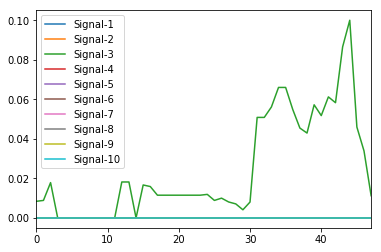

Topics Terms for WTFJAY


Topic Number                    Topic Terms                    
0         1       poor, proportions, cheap, feet, culture, paper...
1         2                                                     lol
2         3       profile, cut, night_owl, working, insomnia, sw...
3         4       swim, spicy, hula, curricular, thoughts, lucky...
4         5                 shut, eye, longgg, bedbugs, tight, bite
5         7       city, stone, hehehe, dont, places, people, fee...
6         8                               folks, good, zzz, morning
7         9       ouch, rough, awhile, kidney, yoga, things, vam...
8        10       goodnight, sense, hoo, writing, started, rewar...
9        12       land, gift, overlooked, detail, gb, someones, ...
10       13       school, guys, friday, tonight, trouble, hehe, ...
11       14                                   awesome, sleep, night
12       15       omnipotent, wow, caught, nan, bad, catching, f...
13       16                                        great, time, con
14       17       week, testing, proceeding, presets, typewriter...
15       18       extra, dude, deep, changing, lesson, favs, cha...
16       19       videos, stressing, laugh, fail, sounds, nyuck,...
17       20       smoke, bars, dm, closed, doc, cigar, ages, deb...
18       21             taste, waiting, making, bit, passing, nikes
19       22       hanks, visit, works, tweeting, tom, haha, site...
20       23                                         hours, num, hit
21       24       ive, barbers, google, philosophical, asleep, g...
22       25       sadly, tweets, twitter, work, yeah, cat, tend,...

Seeded Terms Per Topic for WTFJAY


Topic Number      Seed Terms:Count     
0   signal_3    insomnia:14, night_owl:14

Topics Probabilties Over Time for stevegarufi


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   07/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
1   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
2   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
3   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
4   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
5   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
6   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
7   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
8   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
9   17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
10  17/04/2009 - 18/04/2009     0.0       0.0       0.0    0.0000000   
11  18/04/2009 - 01/05/2009     0.0       0.0       0.0    0.0000000   
12  01/05/2009 - 02/05/2009     0.0       0.0       0.0    0.0000000   
13  01/05/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
14  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
15  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
16  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
17  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
18  01/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
19  01/05/2009 - 09/05/2009     0.0       0.0       0.0    0.0175439   
20  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0140845   
21  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0140845   
22  01/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0140845   
23  01/05/2009 - 13/05/2009     0.0       0.0       0.0    0.0131579   
24  01/05/2009 - 13/05/2009     0.0       0.0       0.0    0.0131579   
..                      ...       ...       ...       ...        ...   
36  13/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0078740   
37  16/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0081967   
38  16/05/2009 - 28/05/2009     0.0       0.0       0.0    0.0075188   
39  16/05/2009 - 29/05/2009     0.0       0.0       0.0    0.0050761   
40  17/05/2009 - 30/05/2009     0.0       0.0       0.0    0.0037736   
41  22/05/2009 - 31/05/2009     0.0       0.0       0.0    0.0128205   
42  22/05/2009 - 01/06/2009     0.0       0.0       0.0    0.0593472   
43  22/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0954907   
44  22/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0954907   
45  22/05/2009 - 04/06/2009     0.0       0.0       0.0    0.0809399   
46  28/05/2009 - 05/06/2009     0.0       0.0       0.0    0.0950000   
47  28/05/2009 - 06/06/2009     0.0       0.0       0.0    0.0666667   
48  28/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0620438   
49  28/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0638686   
50  28/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0656934   
51  28/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0547445   
52  29/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0670391   
53  30/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0803383   
54  31/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0808081   
55  01/06/2009 - 14/06/2009     0.0       0.0       0.0    0.0727273   
56  02/06/2009 - 15/06/2009     0.0       0.0       0.0    0.0419162   
57  04/06/2009 - 15/06/2009     0.0       0.0       0.0    0.0272109   
58  04/06/2009 - 15/06/2009     0.0       0.0       0.0    0.0170068   
59  05/06/2009 - 18/06/2009     0.0       0.0       0.0    0.0169492   
60  06/06/2009 - 19/06/2009     0.0       0.0       0.0    0.0042194   

    Signal-5   Signal-6   Signal-7  Signal-8  Signal-9  Signal-10  
0   0.0000000  0.0000000     0.0       0.0       0.0       0.0     
1   0.0000000  0.0000000     0.0       0.0       0.0       0.0     
2   0.0000000  0.0000000     0.0       0.0       0.0       0

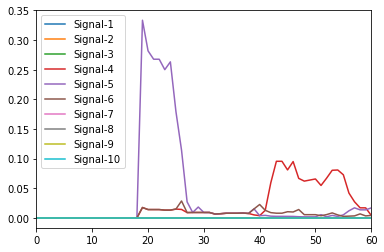

Topics Terms for stevegarufi


Topic Number                    Topic Terms                    
0         1       eaten, muffin, knocking, colors, seed, reached...
1         2                                                     num
2         3       summer, national, smelly, aw, enjoyed, tisha, ...
3         4       archesutah, site, lips, defense, radio, aggrav...
4         5       , crazy, entry, holy, twitter, milk, fat, yeee...
5         6       category, michelle, shot, spoke, nearest, purs...
6         7       kiki, el, life, coach, sooouie, pics, wooo, bv...
7         8       dots, sound, figured, hero, buddy, views, visi...
8         9       week, garbage, gods, jerseyified, joyce, rest,...
9        10       office, nj, goal, tgif, faint, overgrown, tiny...
10       11       pink, web, horse, usa, heh, myspace, filly, si...
11       12          zoe, hot, bad, sunset, rck, towns, america, nw
12       13       bio, eyes, busy, super, attend, snowy, big, tw...
13       14       awesome, pic, heather, god, question, maps, oi...
14       15       prayed, fantastic, elma, neglected, jess, slee...
15       16       someday, blew, trails, major, years, steely, e...
16       17       entire, mountain, lots, wow, awww, pretty, fol...
17       18       vista, phoenix, buena, weather, degrees, spani...
18       19       slept, feel, organized, alive, tonight, bring,...
19       20                    comment, amazing, bike, days, people
20       21                                                   laura
21       22       snowman, cache, snowfall, hair, arizona, skiin...
22       23       love, honey, cuts, leadville, appealing, helps...
23       24       fork, cute, sister, selection, colorado, song,...
24       25       cadet, grew, photo, working, space, house, fri...

Seeded Terms Per Topic for stevegarufi


Topic Number Seed Terms:Count
0   signal_5          fat:5    
1   signal_4        lazy:14    
2   signal_6       worst:14

Topics Probabilties Over Time for whitsundays


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   07/04/2009 - 20/04/2009  0.0055249     0.0       0.0    0.0276243   
1   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0067568   
2   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0202703   
3   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0405405   
4   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0337838   
5   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0135135   
6   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0270270   
7   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0608108   
8   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0067568   
9   18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0067568   
10  18/04/2009 - 21/04/2009  0.0067568     0.0       0.0    0.0202703   
11  18/04/2009 - 01/05/2009  0.0063694     0.0       0.0    0.0127389   
12  19/04/2009 - 01/05/2009  0.0079365     0.0       0.0    0.0079365   
13  20/04/2009 - 03/05/2009  0.0064935     0.0       0.0    0.0779221   
14  21/04/2009 - 04/05/2009  0.0080000     0.0       0.0    0.0320000   
15  01/05/2009 - 04/05/2009  0.0089286     0.0       0.0    0.0267857   
16  01/05/2009 - 04/05/2009  0.0089286     0.0       0.0    0.0267857   
17  01/05/2009 - 04/05/2009  0.0089286     0.0       0.0    0.0178571   
18  01/05/2009 - 04/05/2009  0.0089286     0.0       0.0    0.0982143   
19  01/05/2009 - 04/05/2009  0.0089286     0.0       0.0    0.0178571   
20  01/05/2009 - 10/05/2009  0.0078740     0.0       0.0    0.0157480   
21  01/05/2009 - 10/05/2009  0.0078740     0.0       0.0    0.0393701   
22  01/05/2009 - 10/05/2009  0.0078740     0.0       0.0    0.0078740   
23  01/05/2009 - 10/05/2009  0.0078740     0.0       0.0    0.0393701   
24  01/05/2009 - 14/05/2009  0.0064516     0.0       0.0    0.0322581   
..                      ...        ...       ...       ...        ...   
33  10/05/2009 - 22/05/2009  0.0064516     0.0       0.0    0.0258065   
34  14/05/2009 - 22/05/2009  0.0071429     0.0       0.0    0.0285714   
35  14/05/2009 - 22/05/2009  0.0071429     0.0       0.0    0.0285714   
36  14/05/2009 - 22/05/2009  0.0071429     0.0       0.0    0.0214286   
37  14/05/2009 - 22/05/2009  0.0071429     0.0       0.0    0.0357143   
38  17/05/2009 - 28/05/2009  0.0086207     0.0       0.0    0.0862069   
39  17/05/2009 - 29/05/2009  0.0163934     0.0       0.0    0.0409836   
40  17/05/2009 - 30/05/2009  0.0751445     0.0       0.0    0.0115607   
41  18/05/2009 - 31/05/2009  0.1079545     0.0       0.0    0.0113636   
42  21/05/2009 - 01/06/2009  0.1494253     0.0       0.0    0.0459770   
43  21/05/2009 - 02/06/2009  0.1308411     0.0       0.0    0.0327103   
44  21/05/2009 - 03/06/2009  0.1163636     0.0       0.0    0.0400000   
45  22/05/2009 - 03/06/2009  0.1082090     0.0       0.0    0.0522388   
46  28/05/2009 - 05/06/2009  0.1222222     0.0       0.0    0.0518519   
47  28/05/2009 - 06/06/2009  0.1126761     0.0       0.0    0.0598592   
48  28/05/2009 - 07/06/2009  0.0964912     0.0       0.0    0.0321637   
49  28/05/2009 - 07/06/2009  0.0730994     0.0       0.0    0.0116959   
50  28/05/2009 - 07/06/2009  0.0964912     0.0       0.0    0.0380117   
51  28/05/2009 - 07/06/2009  0.0877193     0.0       0.0    0.0497076   
52  29/05/2009 - 07/06/2009  0.0857988     0.0       0.0    0.0798817   
53  30/05/2009 - 07/06/2009  0.0783133     0.0       0.0    0.0391566   
54  31/05/2009 - 07/06/2009  0.0569395     0.0       0.0    0.0320285   
55  01/06/2009 - 14/06/2009  0.0416667     0.0       0.0    0.0568182   
56  02/06/2009 - 14/06/2009  0.0193237     0.0       0.0    0.0048309   
57  03/06/2009 - 16/06/2009  0.0057143     0.0       0.0    0.0114286   

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0    0.0386740     0.0       0.0       0.0       0.0     
1      0.0    0.0067568     0.0       0.0       0.0       0.0     
2      0.0 

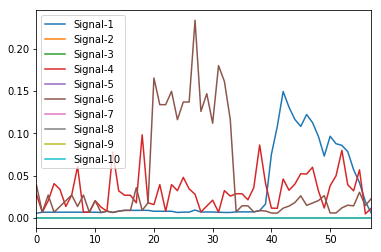

Topics Terms for whitsundays


Topic Number                    Topic Terms                    
0         1       squander, move, gazes, ready, chair, spending,...
1         2                               times, num, thinks, extra
2         3       lamb, voyage, busy, omg, people, moments, shon...
3         4                                 jumping, sweetie, tired
4         6       prehistoric, eh, deck, barry, tweet, confused,...
5         7       comfortable, blip, table, singing, sue, fee, m...
6         8       beautiful, tuesday, sign, ekka, heard, asleep,...
7         9       scary, picture, pic, alex, guest, byeee, haa, ...
8        10       clog, fish, pie, tonight, currie, attract, tom...
9        11       hours, pork, star, text, messages, spent, aliv...
10       12       putting, spotted, females, maccas, fair, di, s...
11       13       constipated, cheeky, rag, simple, disc, poppin...
12       14       plug, great, australia, mainland, island, spel...
13       15       lie, forget, figure, stuck, comp, liquidity, l...
14       17       fantastic, quicker, spring, crop, cold, guess,...
15       18       lttle, rules, watch, thought, dinner, mate, pr...
16       19                                    agreeing, good, time
17       20       sheila, summer, sky, teasing, spider, blago, t...
18       21       web, heather, sailing, club, pick, turned, mod...
19       22       week, sandie, endeavour, dishes, decided, folk...
20       23       play, lonely, ad, wary, life, big, nan, hang, ...
21       24                                                     lol
22       25                                          officer, fussy

Seeded Terms Per Topic for whitsundays


Topic Number Seed Terms:Count
0   signal_1       bored:14    
1   signal_4       tired:14    
2   signal_6       shame:14

Topics Probabilties Over Time for pato_30stm


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   07/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
2   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
3   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
4   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
5   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
6   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
7   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
8   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
9   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
10  17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
11  18/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
12  19/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
13  20/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
14  29/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
15  29/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
16  29/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
17  29/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
18  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
19  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
20  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
21  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
22  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
23  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
24  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
25  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
26  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
27  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
28  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
29  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
30  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
31  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
32  05/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
33  05/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
34  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
35  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
36  07/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0    

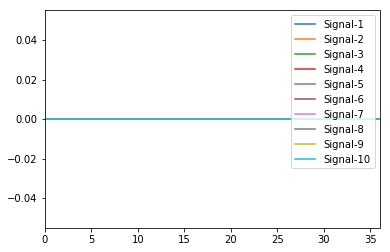

Topics Terms for pato_30stm


Topic Number                    Topic Terms                    
0         1       week, summer, play, top, month, weather, nite,...
1         2       concert, cooking, congratz, stories, lol, vote...
2         3       poor, sweetheart, hiii, join, cancer, seconds,...
3         4       places, congrats, mexico, live, guitar, hmm, a...
4         5        supporting, omg, horrible, mustaches, july, cool
5         6       ass, razor, people, kisses, leave, wink, promi...
6         7       funny, shopping, remember, watching, knew, hah...
7         8                       totally, love, tomorrow, bed, stm
8         9                                     ya, hun, idea, woke
9        10                                              good, nice
10       11       freazing, hunnie, occam, song, tv, nighty, mys...
11       12              awesome, weekend, goodnight, hope, sweetie
12       13       awww, holidays, colors, vegans, kick, facebook...
13       14       yay, winter, cqc, yeah, tour, birthday, black,...
14       15         mm, months, fav, morning, sleep, place, fanfics
15       16       weeks, stores, heard, december, twitter, footb...
16       17       looove, bands, wow, friends, shocked, shame, n...
17       18          shann, tired, car, cking, pics, bro, kiss, bit
18       19                       , school, sucky, aww, watch, kind
19       20       nearest, vid, lost, country, mars, late, piste...
20       21         summet, sweet, nuit, switch, jared, wanted, def
21       22       beautiful, accident, videos, xoxo, pic, nan, b...
22       23       sims, ohh, movie, study, sucks, simpsons, chee...
23       24                                 situation, great, lucky
24       25       btw, bg, feel, topics, misfortune, give_up, fr...

Seeded Terms Per Topic for pato_30stm


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for hilzfuld


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   06/04/2009 - 19/04/2009     0.0       0.0       0.0    0.1046512   
1   07/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0952381   
2   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.1000000   
3   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0875000   
4   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.1000000   
5   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.1000000   
6   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.1000000   
7   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0875000   
8   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0875000   
9   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0875000   
10  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.1250000   
11  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0875000   
12  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.1000000   
13  19/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0833333   
14  20/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0000000   
15  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
16  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
17  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
18  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
19  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
20  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0000000   
21  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0169492   
22  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0169492   
23  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0169492   
24  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0169492   
25  02/05/2009 - 14/05/2009     0.0       0.0       0.0    0.0136986   
26  02/05/2009 - 14/05/2009     0.0       0.0       0.0    0.0136986   
27  04/05/2009 - 14/05/2009     0.0       0.0       0.0    0.0140845   
28  04/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0175439   
29  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0149254   
30  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0149254   
31  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0223881   
32  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0298507   
33  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0191083   
34  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0127389   
35  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0153846   
36  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0230769   
37  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0153846   
38  14/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0153846   
39  17/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0172414   
40  17/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0258621   
41  17/05/2009 - 30/05/2009     0.0       0.0       0.0    0.0169492   
42  18/05/2009 - 31/05/2009     0.0       0.0       0.0    0.0113636   
43  22/05/2009 - 01/06/2009     0.0       0.0       0.0    0.0100000   
44  22/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0082645   
45  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0058824   
46  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0058824   
47  30/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0068027   
48  30/05/2009 - 06/06/2009     0.0       0.0       0.0    0.0059880   
49  30/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0053763   

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9  Signal-10  
0      0.0       0.0    0.0232558     0.0       0.0       0.0     
1      0.0       0.0    0.0119048     0.0       0.0       0.0     
2      0.0       0.0    0.0125000     0.0       0.0       0.0     
3      0.0       0.0    0.0125000     0.0       0.0       0.0     
4

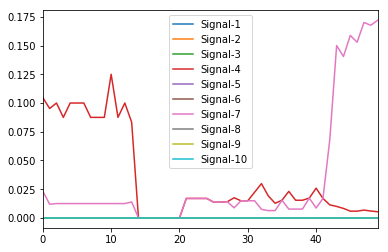

Topics Terms for hilzfuld


Topic Number                    Topic Terms                    
0         1                web, good, tweeting, morning, abt, order
1         2       slow, surfing, iva, cm, mb, perform, month, to...
2         3                               meant, funny, send, night
3         4                            writing, people, tired, nice
4         5       wow, head, feel, hungover, cuz, hmm, pounding,...
5         6                                             nan, bummer
6         7       heavy, win, twitter, jailbreak, middle, il, he...
7         8       lo, huh, idea, boiling, fb, sounds, check, wou...
8         9       king, functions, dm, scammed, watching, minimi...
9        10       life, money, free, sunday, shidduch, reply, gu...
10       11       bets, knowing, yuval, angry, bad, figuratively...
11       12       shabbat, killer, alfa, comms, friday, mind, aw...
12       13       affilicon, bio, confirmed, gotcha, dont, full,...
13       14       kids, howya, nails, phone, wrong, cmon, place,...
14       15       perfect, house, awesome, ideas, stay, replies,...
15       16       coffee, forex, piece, write, mac, sustained, t...
16       17       pronounced, works, figure, big, tweet, knew, n...
17       18                                        ahoova, prepared
18       19       major, firefox, deal, heard, sleep, talker, ce...
19       20       search, gona, deliver, embrace, blood, addicti...
20       21       guess, jm, yea, btw, rackin, read, time, heart...
21       22                                 follow, fyi, work, love
22       23       boy, dvir, fired, press, fun, didnt, find, spe...
23       24       basics, attempt, users, things, pushing, ranka...
24       25       solved, chrome, problems, bro, objection, meet...

Seeded Terms Per Topic for hilzfuld


Topic Number  Seed Terms:Count
0   signal_4            tired:14
1   signal_7    mind_wandering:5

Topics Probabilties Over Time for heykim


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   17/04/2009 - 19/04/2009     0.0    0.0000000     0.0       0.0     
1   19/04/2009 - 01/05/2009     0.0    0.0000000     0.0       0.0     
2   19/04/2009 - 02/05/2009     0.0    0.0338983     0.0       0.0     
3   01/05/2009 - 03/05/2009     0.0    0.0181818     0.0       0.0     
4   01/05/2009 - 03/05/2009     0.0    0.0181818     0.0       0.0     
5   01/05/2009 - 03/05/2009     0.0    0.0181818     0.0       0.0     
6   01/05/2009 - 03/05/2009     0.0    0.0181818     0.0       0.0     
7   01/05/2009 - 03/05/2009     0.0    0.0181818     0.0       0.0     
8   01/05/2009 - 03/05/2009     0.0    0.0363636     0.0       0.0     
9   01/05/2009 - 03/05/2009     0.0    0.0181818     0.0       0.0     
10  01/05/2009 - 10/05/2009     0.0    0.0086207     0.0       0.0     
11  01/05/2009 - 10/05/2009     0.0    0.0086207     0.0       0.0     
12  01/05/2009 - 10/05/2009     0.0    0.0086207     0.0       0.0     
13  01/05/2009 - 13/05/2009     0.0    0.0084746     0.0       0.0     
14  01/05/2009 - 14/05/2009     0.0    0.0069930     0.0       0.0     
15  02/05/2009 - 14/05/2009     0.0    0.0075188     0.0       0.0     
16  03/05/2009 - 16/05/2009     0.0    0.0083333     0.0       0.0     
17  10/05/2009 - 17/05/2009     0.0    0.0068027     0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0    0.0065359     0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0    0.0065359     0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0    0.0065359     0.0       0.0     
21  10/05/2009 - 18/05/2009     0.0    0.0065359     0.0       0.0     
22  10/05/2009 - 18/05/2009     0.0    0.0065359     0.0       0.0     
23  10/05/2009 - 18/05/2009     0.0    0.0065359     0.0       0.0     
24  13/05/2009 - 18/05/2009     0.0    0.0108696     0.0       0.0     
25  13/05/2009 - 18/05/2009     0.0    0.0108696     0.0       0.0     
26  13/05/2009 - 26/05/2009     0.0    0.0084746     0.0       0.0     
27  14/05/2009 - 26/05/2009     0.0    0.0086207     0.0       0.0     
28  16/05/2009 - 28/05/2009     0.0    0.0088496     0.0       0.0     
29  16/05/2009 - 29/05/2009     0.0    0.0710900     0.0       0.0     
30  17/05/2009 - 30/05/2009     0.0    0.0878378     0.0       0.0     
31  18/05/2009 - 31/05/2009     0.0    0.0806452     0.0       0.0     
32  26/05/2009 - 01/06/2009     0.0    0.0775401     0.0       0.0     
33  26/05/2009 - 02/06/2009     0.0    0.0795181     0.0       0.0     
34  26/05/2009 - 02/06/2009     0.0    0.0795181     0.0       0.0     
35  26/05/2009 - 02/06/2009     0.0    0.0819277     0.0       0.0     
36  26/05/2009 - 05/06/2009     0.0    0.0793651     0.0       0.0     
37  26/05/2009 - 06/06/2009     0.0    0.0723140     0.0       0.0     
38  26/05/2009 - 07/06/2009     0.0    0.0780000     0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0       0.0       0.0    0.0000000  0.0000000     0.0     
1      0.0       0.0       0.0    0.0000000  0.0000000     0.0     
2      0.0       0.0       0.0    0.0169492  0.0169492     0.0     
3      0.0       0.0       0.0    0.0181818  0.0181818     0.0     
4      0.0       0.0       0.0    0.0181818  0.0181818     0.0     
5      0.0       0.0       0.0    0.0181818  0.0363636     0.0     
6      0.0       0.0       0.0    0.0181818  0.0181818     0.0     
7      0.0       0.0       0.0    0.0181818  0.0181818     0.0     
8      0.0       0.0       0.0    0.0181818  0.0181818     0.0     
9      0.0       0.0       0.0    0.0181818  0.0181818     0.0     
10     0.0       0.0       0.0    0.0086207  0.0086207     0.0     
11     0.0       0.0       0.0    0.0086207  0.0172414     0.0     
12     0.0       0.0       0.0    0.0086207  0.0086207     0.0     
13     0.0       0.0       0.0    0.0084746  0.0169492     0.0     
14     0.0       0.0       0.0    0.0069930  0.0069930     0.0     
15     0.0       0.0       0.0    0.0075

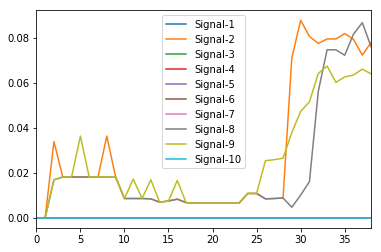

Topics Terms for heykim


Topic Number                    Topic Terms                    
0         1       ovr, sleep, actual, neck, emphasema, boston, h...
1         2       partial, creek, btr, feel, ii, tonite, cubbies...
2         3       tough, go_to_sleep, pic, washington, cups, che...
3         4                                           live, hey, ur
4         5       enjoy, um, smitten, flavorful, follower, grief...
5         6       profile, people, house, rest, follow, acct, gi...
6         7       status, boy, mutual, danny, tomorrow, remember...
7         8       crazy, wnt, moth, recieve, mornin, vote, fear,...
8         9       ive, eyes, repeat, eh, oprah, god, claraitin, ...
9        10       btw, phn, burning, time, nan, guess, twitpics,...
10       11        dad, bought, yr, lost, spent, passed, sry, happy
11       12       , bd, bye, daughter, aww, poking, app, missin,...
12       13       love, twitter, trip, letting, congrats, wow, c...
13       14       full, cancer, mothers, absolutely, tru, novels...
14       15       friendfeed, noise, dont, figure, wall, bears, ...
15       16       kind, blazer, separate, lackluster, things, ar...
16       17       fan, somethin, good, cried, la, understand, ch...
17       18       ordered, cn, hate, sum, nikki, share, pics, sr...
18       19       kiddin, kinda, vain, yeah, ppl, isnt, rough, r...
19       20       sound, magic, dh, tweet, feelins, person, link...
20       21       rooting, morning, num, loves, half, whoooa, be...
21       22       gr, basetball, cept, horn, playoff, doesnt, fa...
22       23       twitterverse, heart, cuppa, vamp, camera, fun,...
23       24                           moms, game, coach, didnt, mom
24       25                               twit, wht, great, day, lk

Seeded Terms Per Topic for heykim


Topic Number Seed Terms:Count
0   signal_9          hurt:13  
1   signal_8     irrational:7  
2   signal_2        dismal:10

Topics Probabilties Over Time for karinb_za


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   14/05/2009 - 26/05/2009     0.0    0.0041322     0.0       0.0     
1   17/05/2009 - 28/05/2009     0.0    0.0039526     0.0       0.0     
2   17/05/2009 - 29/05/2009     0.0    0.0145455     0.0       0.0     
3   17/05/2009 - 30/05/2009     0.0    0.0684039     0.0       0.0     
4   18/05/2009 - 31/05/2009     0.0    0.0864198     0.0       0.0     
5   21/05/2009 - 01/06/2009     0.0    0.0796915     0.0       0.0     
6   21/05/2009 - 02/06/2009     0.0    0.0668103     0.0       0.0     
7   21/05/2009 - 03/06/2009     0.0    0.0534759     0.0       0.0     
8   22/05/2009 - 04/06/2009     0.0    0.0516014     0.0       0.0     
9   26/05/2009 - 05/06/2009     0.0    0.0566802     0.0       0.0     
10  26/05/2009 - 06/06/2009     0.0    0.0576208     0.0       0.0     
11  26/05/2009 - 07/06/2009     0.0    0.0553506     0.0       0.0     
12  26/05/2009 - 07/06/2009     0.0    0.0498155     0.0       0.0     
13  28/05/2009 - 07/06/2009     0.0    0.0568182     0.0       0.0     
14  28/05/2009 - 07/06/2009     0.0    0.0568182     0.0       0.0     
15  29/05/2009 - 07/06/2009     0.0    0.0696203     0.0       0.0     
16  30/05/2009 - 07/06/2009     0.0    0.0575221     0.0       0.0     
17  31/05/2009 - 07/06/2009     0.0    0.0238095     0.0       0.0     
18  01/06/2009 - 07/06/2009     0.0    0.0102302     0.0       0.0     
19  02/06/2009 - 15/06/2009     0.0    0.0078534     0.0       0.0     
20  03/06/2009 - 16/06/2009     0.0    0.0029412     0.0       0.0     
21  04/06/2009 - 17/06/2009     0.0    0.0036364     0.0       0.0     
22  05/06/2009 - 18/06/2009     0.0    0.0039526     0.0       0.0     
23  06/06/2009 - 19/06/2009     0.0    0.0076923     0.0       0.0     
24  07/06/2009 - 20/06/2009     0.0    0.0089286     0.0       0.0     
25  15/06/2009 - 20/06/2009     0.0    0.0090909     0.0       0.0     
26  15/06/2009 - 20/06/2009     0.0    0.0090909     0.0       0.0     
27  15/06/2009 - 23/06/2009     0.0    0.0089686     0.0       0.0     
28  15/06/2009 - 23/06/2009     0.0    0.0089686     0.0       0.0     
29  15/06/2009 - 25/06/2009     0.0    0.0086580     0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0123967     0.0    0.0041322  0.0082645     0.0     
1      0.0    0.0316206     0.0    0.0039526  0.0079051     0.0     
2      0.0    0.0254545     0.0    0.0036364  0.0036364     0.0     
3      0.0    0.0228013     0.0    0.0032573  0.0032573     0.0     
4      0.0    0.0216049     0.0    0.0030864  0.0030864     0.0     
5      0.0    0.0179949     0.0    0.0205656  0.0025707     0.0     
6      0.0    0.0280172     0.0    0.0280172  0.0043103     0.0     
7      0.0    0.0338681     0.0    0.0374332  0.0035651     0.0     
8      0.0    0.0338078     0.0    0.0427046  0.0017794     0.0     
9      0.0    0.0344130     0.0    0.0506073  0.0020243     0.0     
10     0.0    0.0353160     0.0    0.0446097  0.0018587     0.0     
11     0.0    0.0332103     0.0    0.0442804  0.0018450     0.0     
12     0.0    0.0369004     0.0    0.0516605  0.0036900     0.0     
13     0.0    0.0321970     0.0    0.0568182  0.0018939     0.0     
14     0.0    0.0416667     0.0    0.0568182  0.0056818     0.0     
15     0.0    0.0379747     0.0    0.0527426  0.0021097     0.0     
16     0.0    0.0442478     0.0    0.0641593  0.0066372     0.0     
17     0.0    0.0357143     0.0    0.0714286  0.0023810     0.0     
18     0.0    0.0434783     0.0    0.0537084  0.0025575     0.0     
19     0.0    0.0497382     0.0    0.0575916  0.0340314     0.0     
20     0.0    0.0235294     0.0    0.0264706  0.0617647     0.0     
21     0.0    0.0436364     0.0    0.0109091  0.1018182     0.0     
22     0.0    0.0434783     0.0    0.0079051  0.1225296     0.0     
23     0.0    0.0500000     0.0    0.0192308  0.1576923     0.0     
24     0.0    0.0535714     0.0    0.0089286  0.174

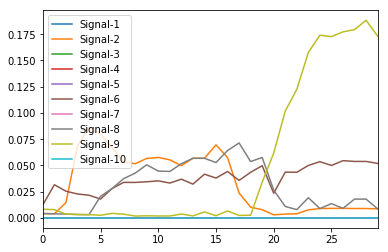

Topics Terms for karinb_za


Topic Number                    Topic Terms                    
0         1       gatvol, buggered, tasty, aw, hanging, chambers...
1         2       guiness, sex, hair, lakers, human, sport, bumm...
2         3       brought, books, noodles, luffs, okie, sum, fly...
3         4       chain, mind, idea, braai, brain, earth, worry,...
4         5       spy, extra, scratch, meetings, screamed, hahah...
5         6            sound, enjoy, work, whine, hey, shame, worst
6         7       perfect, dont, yesterday, pc, xx, twlt, day, t...
7         8       lonely, return, rude, tv, cheap, nut, yup, sha...
8         9       twitter, telephone, rest, fold, doesnt, likes,...
9        10       count, yrself, life, nights, crash, keeding, r...
10       11       frikkin, arvie, finish, rooms, lunchtime, girl...
11       12       funny, dexter, nice, bella, inkjet, fire, nee,...
12       13       yeh, love, heart, absolutely, vent, sticky, sl...
13       14       um, sympathies, picnic, eh, lunch, movie, tequ...
14       15       humour, dance, series, awesome, pic, snuggling...
15       16       btw, stores, gr, ag, crazy, woman, shirts, heh...
16       17       money, ec, ppl, paper, hate, shirt, pictures, ...
17       18       ugh, feel, sweet, scene, smiling, moan, afrika...
18       19       beautiful, limited, bums, eldest, ready, cold,...
19       20       kind, num, read, forfeit, freezing, waiting, d...
20       21       sees, vino, africa, pm, pulls, fine, boasting,...
21       22       respond, cute, jason, point, rob, fit, plannin...
22       23       , agge, yr, printer, working, mtv, wow, watch,...
23       24       amber, pity, sun, midnight, lol, month, finish...
24       25       saturdays, people, weather, lagging, dear, tho...

Seeded Terms Per Topic for karinb_za


Topic Number   Seed Terms:Count 
0   signal_9                die:11
1   signal_8            dragging:7
2   signal_2              bummed:7
3   signal_6    shame:64, worst:14

Topics Probabilties Over Time for Mirna023


Time Period         Signal-1  Signal-2   Signal-3   Signal-4  \
0   02/05/2009 - 03/05/2009     0.0    0.0000000  0.0000000     0.0     
1   03/05/2009 - 03/05/2009     0.0    0.0000000  0.0000000     0.0     
2   17/05/2009 - 17/05/2009     0.0    0.0000000  0.0000000     0.0     
3   17/05/2009 - 18/05/2009     0.0    0.0000000  0.0000000     0.0     
4   17/05/2009 - 18/05/2009     0.0    0.0000000  0.0000000     0.0     
5   17/05/2009 - 18/05/2009     0.0    0.0000000  0.0000000     0.0     
6   17/05/2009 - 18/05/2009     0.0    0.0000000  0.0000000     0.0     
7   17/05/2009 - 22/05/2009     0.0    0.0158730  0.0158730     0.0     
8   17/05/2009 - 22/05/2009     0.0    0.0634921  0.0158730     0.0     
9   17/05/2009 - 22/05/2009     0.0    0.0158730  0.0158730     0.0     
10  17/05/2009 - 22/05/2009     0.0    0.0158730  0.0158730     0.0     
11  17/05/2009 - 26/05/2009     0.0    0.0093458  0.0093458     0.0     
12  17/05/2009 - 26/05/2009     0.0    0.0093458  0.0093458     0.0     
13  17/05/2009 - 26/05/2009     0.0    0.0186916  0.0093458     0.0     
14  17/05/2009 - 29/05/2009     0.0    0.0060976  0.0121951     0.0     
15  17/05/2009 - 30/05/2009     0.0    0.0167131  0.0222841     0.0     
16  18/05/2009 - 31/05/2009     0.0    0.0305344  0.0330789     0.0     
17  22/05/2009 - 01/06/2009     0.0    0.0386364  0.0272727     0.0     
18  22/05/2009 - 02/06/2009     0.0    0.0352423  0.0286344     0.0     
19  22/05/2009 - 02/06/2009     0.0    0.0374449  0.0264317     0.0     
20  22/05/2009 - 02/06/2009     0.0    0.0484581  0.0242291     0.0     
21  26/05/2009 - 02/06/2009     0.0    0.0387244  0.0250569     0.0     
22  26/05/2009 - 06/06/2009     0.0    0.0421941  0.0232068     0.0     
23  26/05/2009 - 07/06/2009     0.0    0.0406360  0.0265018     0.0     
24  26/05/2009 - 07/06/2009     0.0    0.0335689  0.0265018     0.0     
25  29/05/2009 - 07/06/2009     0.0    0.0402299  0.0306513     0.0     
26  29/05/2009 - 07/06/2009     0.0    0.0402299  0.0325670     0.0     
27  29/05/2009 - 07/06/2009     0.0    0.0421456  0.0287356     0.0     
28  30/05/2009 - 07/06/2009     0.0    0.0430108  0.0279570     0.0     
29  31/05/2009 - 07/06/2009     0.0    0.0592593  0.0222222     0.0     
30  01/06/2009 - 14/06/2009     0.0    0.0433071  0.0078740     0.0     
31  02/06/2009 - 15/06/2009     0.0    0.0276680  0.0079051     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0       0.0    0.0000000     0.0     
1      0.0       0.0       0.0       0.0    0.0000000     0.0     
2      0.0       0.0       0.0       0.0    0.0000000     0.0     
3      0.0       0.0       0.0       0.0    0.0000000     0.0     
4      0.0       0.0       0.0       0.0    0.0000000     0.0     
5      0.0       0.0       0.0       0.0    0.0000000     0.0     
6      0.0       0.0       0.0       0.0    0.0000000     0.0     
7      0.0       0.0       0.0       0.0    0.0158730     0.0     
8      0.0       0.0       0.0       0.0    0.0158730     0.0     
9      0.0       0.0       0.0       0.0    0.0158730     0.0     
10     0.0       0.0       0.0       0.0    0.0158730     0.0     
11     0.0       0.0       0.0       0.0    0.0186916     0.0     
12     0.0       0.0       0.0       0.0    0.0186916     0.0     
13     0.0       0.0       0.0       0.0    0.0186916     0.0     
14     0.0       0.0       0.0       0.0    0.0365854     0.0     
15     0.0       0.0       0.0       0.0    0.0417827     0.0     
16     0.0       0.0       0.0       0.0    0.0508906     0.0     
17     0.0       0.0       0.0       0.0    0.0454545     0.0     
18     0.0       0.0       0.0       0.0    0.0440529     0.0     
19     0.0       0.0       0.0       0.0    0.0462555     0.0     
20     0.0       0.0       0.0       0.0    0.0374449     0.0     
21     0.0       0.0       0.0       0.0    0.0455581     0.0     
22     0.0       0.0       0.0       0.0    0.0400844     

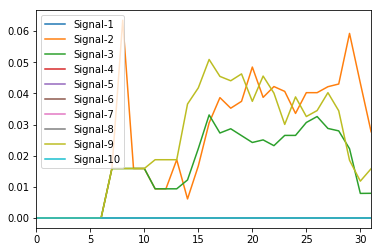

Topics Terms for Mirna023


Topic Number                    Topic Terms                    
0         1       crazy, copy, phoenix, people, feel, donnie, na...
1         2       monday, miami, literally, depressed, dave, stu...
2         3       danny, talent, adidas, insomniac, series, work...
3         4              great, good, coast, glad, face, guys, hope
4         5       arrives, sign, ya, movie, summery, jeans, awww...
5         6       week, play, ahead, business, susan, win, rob, ...
6         7       shopping, gear, knight, firefighters, hey, go_...
7         8       funny, jimmy, omg, read, fallon, attention, si...
8         9       jamie, dvd, pic, request, yesterday, yeah, hun...
9        10       , silky, guess, buy, gs, service, fire, michae...
10       11       bummed, jaime, motivated, missed, min, watchin...
11       12       planning, heart, dm, hour, orlando, nah, midni...
12       13       profile, flying, hit, bug, congrats, sunny, aw...
13       14       eyes, jason, friends, hang, sad, tonight, feel...
14       15       alcohol, seas, west, time, blockhead, lol, fel...
15       16       crash, mirna, song, wow, donation, amazing, he...
16       17       cute, afterall, bocelli, head, farrell, ready,...
17       18       album, kind, nights, headed, hun, cap, air, fr...
18       19           join, plans, send, nkairplay, num, hugs, love
19       20       insane, nuggetts, la, sucks, cameras, question...
20       21       enjoy, relaxing, turns, earlier, pricey, estre...
21       22       facetime, videos, girl, issues, tix, howard, l...
22       23       insomnia, btw, seconds, mess, car, tuesday, kn...
23       24       town, count, wanted, decided, mtg, wake, tossi...
24       25       house, celebrating, colin, safe, blocks, satur...

Seeded Terms Per Topic for Mirna023


Topic Number Seed Terms:Count
0   signal_9          kill:14  
1   signal_3      insomniac:2  
2   signal_2     depressed:14

Topics Probabilties Over Time for AnnSue


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   02/05/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
1   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
2   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
3   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
4   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
5   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
6   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
7   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
8   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
9   17/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
10  17/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
11  17/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
12  17/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
13  17/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
14  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
15  26/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
16  26/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
17  26/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
18  26/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
19  26/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
20  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
21  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
22  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0     
17     0.0       0.0       0.0       0.0       0.0     
18     0.0       0.0       0.0       0.0       0.0     
19     0.0       0.0       0.0       0.0       0.0     
20     0.0       0.0       0.0       0.0       0.0     
21     0.0       0.0       0.0       0.0       0.0     
22     0.0       0.0       0.0       0.0       0.0

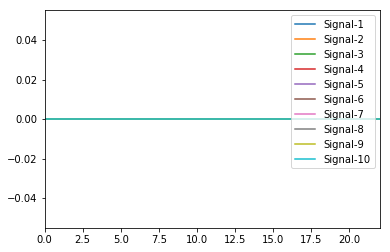

Topics Terms for AnnSue


Topic Number                    Topic Terms                    
0         1                                   , sweet, good, dreams
1         2       funny, great, tired, ships, meh, jully, dat, l...
2         3            toronto, love, girrl, jeans, sleep, adorable
3         4       cheating, rr, classic, rise, sting, bs, cold, ...
4         5                        late, bum___out, diddy, beg, nuh
5         6              city, aww, sweater, safe, poppin, sh, fine
6         7        god, twitter, peace, please, morning, shy, issue
7         8       shine, guess, joc, wake, baggie, lfbaooooooooo...
8         9       bizzz, dryupself, wore, share, goodnight, wadd...
9        10       work, food, cry, nan, maddix, dance, num, fun,...
10       11                                aye, man, ur, days, cool
11       12                                         big, xoxo, sink
12       13       kids, feel, wow, seat, stay, imma, sunday, ish...
13       15                            single, awards, eat, dancing
14       16       puss, hey, sad, juice, call, baby, lmfbaoooooo...
15       17                                        thing, shut, gap
16       18                                     beast, lol, clothes
17       19           hypebeast, damn, nice, xoxoxoxooxoxoo, ground
18       20                                body, bitches, aunty, sv
19       21                saig, shoes, amen, fucking, global, yall
20       22                 meat, thx, haha, bless, cutie, remember
21       23       oooooooooooooooooooooooo, bff, yo, wrong, yooo...
22       24                            car, jammin, word, fantastic
23       25       sis, yea, nada, night, haaayhhhaaa, sounds, ch...

Seeded Terms Per Topic for AnnSue


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for JBnVFCLover786


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   18/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
2   20/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
3   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
4   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
5   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
6   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
7   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
8   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
13  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
14  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
15  03/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
16  04/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
23  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
24  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
27  17/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
28  17/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
29  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
30  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
31  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
34  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
35  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
36  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
37  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
38  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
40  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
44  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
45  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
47  05/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
48  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
49  06/06/2009 - 19/06/2009     0.0     

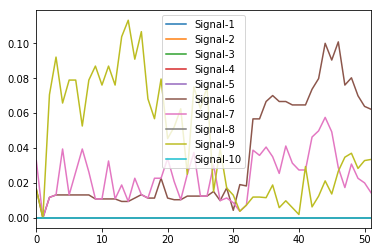

Topics Terms for JBnVFCLover786


Topic Number                    Topic Terms                    
0         1       sorryy, point, text, soo, tonight, cries, scot...
1         2       years, husnaa, missed, working, lonnngg, onlt,...
2         3       enjoy, crazy, google, site, wannnt, talked, ro...
3         4       coment, swatting, story, darnit, business, rea...
4         5       rob, demi, human, copy, swac, privacy, myspace...
5         6       comment, great, groups, woah, imma, hated, stu...
6         7         jayk, yup, camp, confused, good, hehe, tc, luck
7         8                             tarnish, clearing, hate, nw
8         9                            feel, love, haha, kill, okkk
9        10       ck, imagining, winston, talking, haah, sleep, ...
10       11       fair, sweet, nada, stalkers, creepy, awww, you...
11       12       tomz, aww, studying, mad, crying, msg, follow,...
12       13       spy, btw, ag, house, fixxing, pic, cookies, wa...
13       14                                      wow, guys, leaving
14       15       tuesday, helped, hapend, il, nm, god, ne, inte...
15       16       aaahhh, cut, swty, sorta, shy, ipod, clothes, ...
16       17       called, africa, shut, chat, annoying, waht, se...
17       18       forever, puts, awesome, yeah, lol, amazing, me...
18       19       picnik, unfair, bootcamp, result, cousin, baaa...
19       20       wana, upset, internetz, num, myn, album, minez...
20       21       stretches, al, check, jesse, cnt, movie, ry, w...
21       22       everyting, heart, hugs, tv, ught, cryng, frida...
22       23       thomas, people, heartfelt, mas, sad, thnkn, he...
23       24       eyes, land, la, wins, scared, half, mind, get_...
24       25       , cute, ugh, dont, kris, twit, twitter, uhh, a...

Seeded Terms Per Topic for JBnVFCLover786


Topic Number       Seed Terms:Count     
0   signal_9                       kill:20
1   signal_1                used_to_like:3
2   signal_7                   confused:32
3   signal_6    shame:6, worst:14, hated:6

Topics Probabilties Over Time for jonas_twilight3


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
1   03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
2   10/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
3   10/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
4   10/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
5   10/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
6   10/05/2009 - 21/05/2009     0.0       0.0       0.0       0.0       0.0     
7   10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
8   10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
9   16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
10  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
11  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
12  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
13  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
14  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
15  21/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
16  21/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
17  21/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
18  21/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
19  21/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
20  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
21  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
22  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
23  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0     
13     0.0       0.0       0.0       0.0       0.0     
14     0.0       0.0       0.0       0.0       0.0     
15     0.0       0.0       0.0       0.0       0.0     
16     0.0       0.0       0.0       0.0       0.0     
17     0.0       0.0       0.0       0.0       0.0     
18     0.0       0.0       0.0       0.0       0.0     
19     0.0       0.0       0.0       0.0       0.0     
20     0.0       0.0       0.0       0.0       0.0     
21     0.0       0.0       0.0       0.0       0.0     
22     0.0       0.0       0.0       0.0       0.0     
23     0.0       0.0       0.0       0.0       0.0

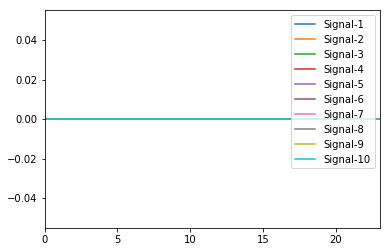

Topics Terms for jonas_twilight3


Topic Number                    Topic Terms                    
0         1       coffee, converse, chatting, area, drink, thurs...
1         2       researching, figure, checking, friends, explai...
2         3       yellow, source, black, lol, easy, feeling, col...
3         4       stated, kleaner, video, year, tomorrow, marath...
4         5       album, nxt, convoy, kevin, tweeter, robot, cra...
5         6       enjoy, east, thinking, alll, sale, sugar, joe,...
6         7       fly, cute, good, srry, language, kk, cooking, ...
7         8       turtle, btw, extended, whatthebuck, song, thin...
8         9       ncis, hits, jimmy, tweeters, nitey, walks, fel...
9        10       factory, tired, read, money, vvery, lines, fin...
10       11                          friday, meebo, dont, lollipops
11       12       school, yay, yup, wifi, nan, yesterday, evil, ...
12       13       dad, omg, roof, times, looked, lunch, num, bot...
13       14       resting, bettter, newss, hearing, gullible, ba...
14       15       mario, bbl, love, apple, watching, paranoid, f...
15       16       transformer, started, tweeting, awesome, fav, ...
16       17       vocab, ate, yesh, hey, bros, ur, yummmyyy, aww...
17       18       sweet, national, ginger, cd, vines, pimpin, aw...
18       19       figured, june, mum, suppose, time, test, gots,...
19       20       earn, rutherford, semi, mariokart, remembered,...
20       21       readyy, comong, reason, follow, disappointed, ...
21       22       ass, slow, computer, lawlz, aww, ju, ipod, day...
22       23       happiness, success, luv, welll, ment, omj, was...
23       24       meee, battery, ttyl, yea, shoe, nite, chair, a...
24       25       cools, work, wii, general, facebook, poison, w...

Seeded Terms Per Topic for jonas_twilight3


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for JennaMadison


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   07/04/2009 - 17/04/2009     0.0       0.0       0.0       0.0       0.0     
1   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
2   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
3   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
4   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
5   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
6   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
7   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
8   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
9   17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
10  17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
11  21/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
12  21/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
13  21/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
14  21/04/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
15  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
16  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
17  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
18  01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
19  01/05/2009 - 09/05/2009     0.0       0.0       0.0       0.0       0.0     
20  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
21  01/05/2009 - 11/05/2009     0.0       0.0       0.0       0.0       0.0     
22  01/05/2009 - 11/05/2009     0.0       0.0       0.0       0.0       0.0     
23  01/05/2009 - 11/05/2009     0.0       0.0       0.0       0.0       0.0     
24  01/05/2009 - 11/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
36  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
37  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
38  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
39  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
40  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
41  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
42  21/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
43  21/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
44  21/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
45  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
46  30/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
47  30/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
48  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
49  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
50  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
51  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
52  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
53  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
54  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
55  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
56  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
57  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
58  05/06/2009 - 16/06/2009     0.0     

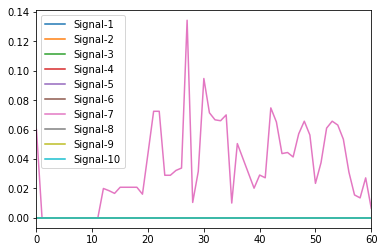

Topics Terms for JennaMadison


Topic Number                    Topic Terms                    
0         1       , water, omgs, kids, kills, headed, food, muff...
1         2       enjoy, giggles, group, dont, feel, screen, ear...
2         3       cookies, yummy, relaxing, sweet, hot, wonderfu...
3         4       heart, fantastic, twitter, explanation, ampers...
4         5       mmmm, hiya, goal, nope, pose, sooo, told, mmm,...
5         6                                              busy, good
6         7                                          aww, fantasize
7         8       sound, goof, guess, hey, song, absolutely, lau...
8         9       sending, crazy, eh, abies, lots, snap, wishes,...
9        10                                    great, num, calstate
10       11                           friends, properly, hear, glad
11       12       sims, shopping, ty, yup, caught, window, pop, ...
12       13       beanie, yay, deal, lil, sad, helps, waves, pla...
13       14                                                  hehehe
14       15       funny, coffee, friday, staying, lovin, sweat, ...
15       16       hug, slumber, morning, face, goodnight, irl, b...
16       17       eyes, woman, sucker, eggs, hanging, list, slid...
17       18       sweetie, ya, coolness, katt, tunes, sex, phone...
18       19       howdy, days, student, night, professional, rou...
19       20                                      awesomesauce, hugs
20       22                          fun, follow, tmi, york, missed
21       23                                     control, stuff, nan
22       24                                     love, effects, time
23       25                                          play, lot, lol

Seeded Terms Per Topic for JennaMadison


Topic Number Seed Terms:Count
0   signal_7     fantasize:14

Topics Probabilties Over Time for Tyrone17


Time Period         Signal-1   Signal-2   Signal-3  Signal-4   \
0  28/05/2009 - 07/06/2009  0.0266160  0.0475285     0.0    0.0285171   
1  29/05/2009 - 07/06/2009  0.0240481  0.0541082     0.0    0.0300601   
2  30/05/2009 - 07/06/2009  0.0465686  0.0465686     0.0    0.0343137   
3  31/05/2009 - 07/06/2009  0.0431894  0.0564784     0.0    0.0365449   
4  02/06/2009 - 14/06/2009  0.0401460  0.0583942     0.0    0.0547445   
5  02/06/2009 - 15/06/2009  0.0453172  0.0453172     0.0    0.0513595   
6  03/06/2009 - 16/06/2009  0.0599369  0.0347003     0.0    0.0599369   

   Signal-5  Signal-6   Signal-7   Signal-8  Signal-9  Signal-10  
0     0.0    0.0627376  0.0570342     0.0       0.0       0.0     
1     0.0    0.0741483  0.0480962     0.0       0.0       0.0     
2     0.0    0.0441176  0.0367647     0.0       0.0       0.0     
3     0.0    0.1162791  0.0365449     0.0       0.0       0.0     
4     0.0    0.0693431  0.0474453     0.0       0.0       0.0     
5     0.0    0.0815710  0.0815710     0.0       0.0       0.0     
6     0.0    0.1041009  0.0567823     0.0       0.0       0.0

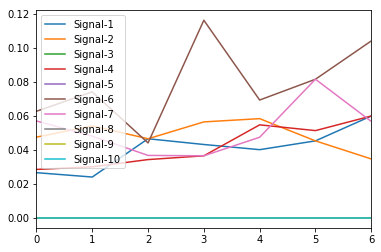

Topics Terms for Tyrone17


Topic Number                    Topic Terms                    
0         1       ru, hero, anoy, doin, diference, listening, ti...
1         2       origin, wbu, depressed, things, celebs, loveya...
2         3       raf, folt, lifes, expert, recon, called, um, p...
3         4       beautiful, mood, music, laptop, tired, morning...
4         5       fair, bumed, demi, finished, fun, jean, tca, nice
5         6       heavy, wondering, tour, worst, bewty, beautifu...
6         7       jovi, wierded, love, confused, abit, yesterday...
7         8       ya, toured, maroons, lucky, billy, afternoon, ...
8         9       lovato, play, meen, star, footy, chillin, acte...
9        10       naps, amen, fire, pictures, michael, ment, isn...
10       11       body, sonny, bother, chance, live, anoys, quee...
11       12       talented, song, read, watching, fuck, morrow, ...
12       13       australia, anythin, wanted, myspace, fan, demi...
13       14       moring, loved, fucking, sortof, sleeping, joke...
14       15       huge, funnyest, forget, arnt, ubderstand, alit...
15       16       ive, good, omg, awesome, hey, amazing, hahalol...
16       17       yard, dig, haha, vacation, probs, hours, cheer...
17       18                              yea, feels, concert, state
18       19       lie, life, yay, nah, list, yuk, lol, cya, luck...
19       20       badly, great, chat, top, stupid, bon, qld, con...
20       21       funny, ideot, rove, shattered, tor, pose, fans...
21       22       brazil, guess, alil, flames, dirt, light, comp...
22       23            hasnt, freak, holy, num, stuff, doesnt, talk
23       24       scary, remember, feel, sooner, wrong, prayer, ...
24       25       heart, killin, jackson, dont, wierdest, dragon...

Seeded Terms Per Topic for Tyrone17


Topic Number Seed Terms:Count
0   signal_1         bored:28  
1   signal_2      depressed:3  
2   signal_4         tired:21  
3   signal_7       confused:2  
4   signal_6          worst:3

Topics Probabilties Over Time for Gen22


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   18/04/2009 - 01/05/2009  0.0196078     0.0       0.0       0.0     
1   19/04/2009 - 02/05/2009  0.0161290     0.0       0.0       0.0     
2   20/04/2009 - 03/05/2009  0.0172414     0.0       0.0       0.0     
3   01/05/2009 - 04/05/2009  0.0338983     0.0       0.0       0.0     
4   01/05/2009 - 04/05/2009  0.0169492     0.0       0.0       0.0     
5   01/05/2009 - 04/05/2009  0.0169492     0.0       0.0       0.0     
6   01/05/2009 - 04/05/2009  0.0169492     0.0       0.0       0.0     
7   01/05/2009 - 04/05/2009  0.0169492     0.0       0.0       0.0     
8   01/05/2009 - 09/05/2009  0.0129870     0.0       0.0       0.0     
9   01/05/2009 - 10/05/2009  0.0119048     0.0       0.0       0.0     
10  01/05/2009 - 11/05/2009  0.0198020     0.0       0.0       0.0     
11  01/05/2009 - 11/05/2009  0.0099010     0.0       0.0       0.0     
12  01/05/2009 - 11/05/2009  0.0099010     0.0       0.0       0.0     
13  01/05/2009 - 14/05/2009  0.0188679     0.0       0.0       0.0     
14  02/05/2009 - 14/05/2009  0.0190476     0.0       0.0       0.0     
15  03/05/2009 - 16/05/2009  0.0106383     0.0       0.0       0.0     
16  04/05/2009 - 17/05/2009  0.0112360     0.0       0.0       0.0     
17  09/05/2009 - 17/05/2009  0.0116279     0.0       0.0       0.0     
18  09/05/2009 - 17/05/2009  0.0116279     0.0       0.0       0.0     
19  09/05/2009 - 17/05/2009  0.0116279     0.0       0.0       0.0     
20  09/05/2009 - 17/05/2009  0.0116279     0.0       0.0       0.0     
21  09/05/2009 - 17/05/2009  0.0116279     0.0       0.0       0.0     
22  10/05/2009 - 17/05/2009  0.0147059     0.0       0.0       0.0     
23  11/05/2009 - 17/05/2009  0.0163934     0.0       0.0       0.0     
24  14/05/2009 - 17/05/2009  0.0227273     0.0       0.0       0.0     
25  14/05/2009 - 17/05/2009  0.0227273     0.0       0.0       0.0     
26  14/05/2009 - 17/05/2009  0.0227273     0.0       0.0       0.0     
27  16/05/2009 - 28/05/2009  0.0175439     0.0       0.0       0.0     
28  16/05/2009 - 29/05/2009  0.0210526     0.0       0.0       0.0     
29  17/05/2009 - 30/05/2009  0.0315789     0.0       0.0       0.0     
30  28/05/2009 - 31/05/2009  0.1531532     0.0       0.0       0.0     
31  28/05/2009 - 01/06/2009  0.1866667     0.0       0.0       0.0     
32  28/05/2009 - 02/06/2009  0.1741935     0.0       0.0       0.0     
33  28/05/2009 - 03/06/2009  0.1781609     0.0       0.0       0.0     
34  28/05/2009 - 03/06/2009  0.1896552     0.0       0.0       0.0     
35  28/05/2009 - 05/06/2009  0.1899441     0.0       0.0       0.0     
36  28/05/2009 - 06/06/2009  0.1881720     0.0       0.0       0.0     
37  28/05/2009 - 07/06/2009  0.1673820     0.0       0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0       0.0       0.0    0.0392157     0.0       0.0     
1      0.0       0.0       0.0    0.0161290     0.0       0.0     
2      0.0       0.0       0.0    0.0344828     0.0       0.0     
3      0.0       0.0       0.0    0.0338983     0.0       0.0     
4      0.0       0.0       0.0    0.0169492     0.0       0.0     
5      0.0       0.0       0.0    0.0169492     0.0       0.0     
6      0.0       0.0       0.0    0.0338983     0.0       0.0     
7      0.0       0.0       0.0    0.0169492     0.0       0.0     
8      0.0       0.0       0.0    0.0129870     0.0       0.0     
9      0.0       0.0       0.0    0.0238095     0.0       0.0     
10     0.0       0.0       0.0    0.0099010     0.0       0.0     
11     0.0       0.0       0.0    0.0099010     0.0       0.0     
12     0.0       0.0       0.0    0.0099010     0.0       0.0     
13     0.0       0.0       0.0    0.0188679     0.0       0.0     
14     0.0       0.0       0.0    0.0190476     0.0       0.0     
15     0.0       0.0       0.0    0.0106383     0.0       0.0     
16     0.0       0.0       0.0    0.0112360     0.0       0.0

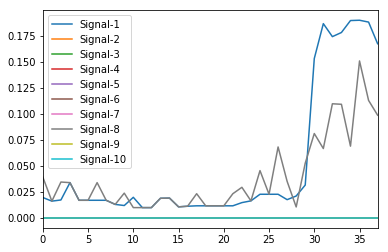

Topics Terms for Gen22


Topic Number                    Topic Terms                    
0         1       steve, follow, find, working, wah, lots, bwhah...
1         2       flattered, kind, snowing, kinda, sparkles, ord...
2         4                               itouch, wink, bout, music
3         5                 hoo, woo, problem, fixed, dreams, pants
4         6       scary, blipping, ahh, french, totes, lol, enjo...
5         7                                   yesterday, unf, night
6         8       returned, song, awesome, pearl, anytime, darls...
7         9       planning, twittering, loquacious, babe, wee, s...
8        10                                    btw, num, love, nice
9        11                                managing, blushing, oooh
10       12       led, talented, business, wow, son, byrdie, roc...
11       13                                   excellent, minds, thx
12       14       pooped, ya, sweet, leg, forgot, whispers, live...
13       15                                                   truth
14       16                                       edmonton, fuckery
15       17                                                    good
16       18       great, blips, brand, friday, haha, answered, trip
17       19       monday, hour, tweeting, gabi, nan, vampire, bu...
18       20              tough, la, hon, tonight, zep, pretty, cool
19       21       week, listen, kudos, htb, musician, rocks, gd,...
20       22       muito, snow, rain, blip, obrigada, party, engi...
21       23       jam, evening, humor, pic, kidding, stuff, clea...
22       24       rose, twitter, morning, forward, hear, hilario...
23       25                                               hey, yeah

Seeded Terms Per Topic for Gen22


Topic Number Seed Terms:Count
0   signal_1           meh:7   
1   signal_8      annoying:7

Topics Probabilties Over Time for shellrawlins


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   19/04/2009 - 19/04/2009  0.0000000     0.0       0.0    0.0000000   
1   03/05/2009 - 03/05/2009  0.0000000     0.0       0.0    0.0000000   
2   03/05/2009 - 04/05/2009  0.0000000     0.0       0.0    0.0000000   
3   03/05/2009 - 04/05/2009  0.0000000     0.0       0.0    0.0000000   
4   03/05/2009 - 04/05/2009  0.0000000     0.0       0.0    0.0000000   
5   03/05/2009 - 04/05/2009  0.0000000     0.0       0.0    0.0000000   
6   03/05/2009 - 04/05/2009  0.0000000     0.0       0.0    0.0000000   
7   03/05/2009 - 04/05/2009  0.0000000     0.0       0.0    0.0000000   
8   03/05/2009 - 10/05/2009  0.0277778     0.0       0.0    0.0277778   
9   03/05/2009 - 11/05/2009  0.0540541     0.0       0.0    0.0270270   
10  03/05/2009 - 11/05/2009  0.0270270     0.0       0.0    0.0270270   
11  03/05/2009 - 11/05/2009  0.0540541     0.0       0.0    0.0270270   
12  03/05/2009 - 14/05/2009  0.0256410     0.0       0.0    0.0256410   
13  03/05/2009 - 14/05/2009  0.0256410     0.0       0.0    0.0256410   
14  03/05/2009 - 14/05/2009  0.0256410     0.0       0.0    0.0256410   
15  04/05/2009 - 17/05/2009  0.0888889     0.0       0.0    0.1333333   
16  10/05/2009 - 18/05/2009  0.0175439     0.0       0.0    0.2631579   
17  10/05/2009 - 18/05/2009  0.0175439     0.0       0.0    0.2631579   
18  10/05/2009 - 18/05/2009  0.0701754     0.0       0.0    0.2631579   
19  10/05/2009 - 18/05/2009  0.0175439     0.0       0.0    0.2631579   
20  10/05/2009 - 22/05/2009  0.0312500     0.0       0.0    0.2343750   
21  10/05/2009 - 22/05/2009  0.0156250     0.0       0.0    0.2500000   
22  11/05/2009 - 22/05/2009  0.0161290     0.0       0.0    0.2258065   
23  14/05/2009 - 22/05/2009  0.0327869     0.0       0.0    0.2622951   
24  14/05/2009 - 22/05/2009  0.0163934     0.0       0.0    0.2622951   
25  14/05/2009 - 27/05/2009  0.0153846     0.0       0.0    0.2307692   
26  17/05/2009 - 27/05/2009  0.0317460     0.0       0.0    0.2539683   
27  17/05/2009 - 29/05/2009  0.0149254     0.0       0.0    0.2238806   
28  17/05/2009 - 30/05/2009  0.0285714     0.0       0.0    0.1523810   
29  18/05/2009 - 31/05/2009  0.0116279     0.0       0.0    0.0581395   
30  22/05/2009 - 01/06/2009  0.0211640     0.0       0.0    0.0052910   
31  22/05/2009 - 02/06/2009  0.0504587     0.0       0.0    0.0045872   
32  22/05/2009 - 03/06/2009  0.0369004     0.0       0.0    0.0036900   
33  22/05/2009 - 04/06/2009  0.0362319     0.0       0.0    0.0036232   
34  27/05/2009 - 05/06/2009  0.0280702     0.0       0.0    0.0070175   
35  27/05/2009 - 06/06/2009  0.0342466     0.0       0.0    0.0034247   
36  27/05/2009 - 07/06/2009  0.0203488     0.0       0.0    0.0029070   
37  27/05/2009 - 07/06/2009  0.0232558     0.0       0.0    0.0029070   
38  27/05/2009 - 07/06/2009  0.0261628     0.0       0.0    0.0029070   
39  29/05/2009 - 07/06/2009  0.0235294     0.0       0.0    0.0029412   
40  29/05/2009 - 07/06/2009  0.0382353     0.0       0.0    0.0029412   
41  30/05/2009 - 07/06/2009  0.0297619     0.0       0.0    0.0029762   
42  31/05/2009 - 07/06/2009  0.0201342     0.0       0.0    0.0033557   
43  01/06/2009 - 07/06/2009  0.0460829     0.0       0.0    0.0046083   
44  02/06/2009 - 15/06/2009  0.0351562     0.0       0.0    0.0078125   
45  03/06/2009 - 16/06/2009  0.0079365     0.0       0.0    0.0079365   
46  04/06/2009 - 16/06/2009  0.0100503     0.0       0.0    0.0100503   
47  05/06/2009 - 16/06/2009  0.0154639     0.0       0.0    0.0103093   
48  06/06/2009 - 19/06/2009  0.0053191     0.0       0.0    0.0106383   

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9   Signal-10  
0      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
1      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
2      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
3      0.0       0.0    0.0000000     0.0    0.0000000     0.0     
4      0.0       0

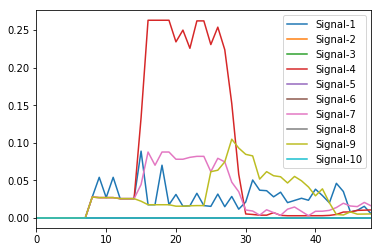

Topics Terms for shellrawlins


Topic Number                    Topic Terms                    
0         1                      mmm, mushrooms, bored, years, cool
1         2       pink, tis, love, office, deal, salad, earlier,...
2         3       spotted, curse, shirt, sun, hun, worth, milk, ...
3         4       toast, raining, wallingford, oi, tired, season...
4         5       field, level, food, comp, people, freezing, ph...
5         6       rotas, money, expect, cuts, yep, sounds, count...
6         7                           shop, work, planned, confused
7         8       facebook, fosters, relaxing, taste, dressed, w...
8         9       ohh, monday, sam, conversation, top, dead, mak...
9        10         starts, bacon, lol, feet, time, luck, partially
10       11       coffee, sit, resetting, showing, face, bbq, re...
11       12       enjoy, topic, takes, fair, potato, started, co...
12       13       great, postman, friday, fb, num, tan, glue, co...
13       14                                            nan, morning
14       15       busy, biased, evening, decided, network, watch...
15       16                                  week, fine, hope, easy
16       17                              sweet, comforts, pay, arse
17       18       wagon, dean, working, cinema, discussion, cros...
18       19       tomato, summer, tanning, command, shopping, fo...
19       20                                         xxx, faces, sat
20       21       clouds, dont, drink, fridge, dinner, ready, co...
21       22       unfollow, garden, lots, winter, twitter, honey...
22       23       bonjella, hows, brave, jobs, happening, rights...
23       24       tattoo, lower, mo, pub, michellerawlins, year,...
24       25                      covered, lovely, yay, matter, wine

Seeded Terms Per Topic for shellrawlins


Topic Number Seed Terms:Count
0   signal_1         bored:14  
1   signal_9          dead:14  
2   signal_4          tired:5  
3   signal_7      confused:14

Topics Probabilties Over Time for SallytheShizzle


Time Period         Signal-1  Signal-2   Signal-3   Signal-4  \
0   22/05/2009 - 03/06/2009     0.0    0.0044053  0.0264317     0.0     
1   28/05/2009 - 05/06/2009     0.0    0.0017036  0.0238501     0.0     
2   28/05/2009 - 06/06/2009     0.0    0.0041152  0.0246914     0.0     
3   28/05/2009 - 07/06/2009     0.0    0.0012438  0.0298507     0.0     
4   28/05/2009 - 07/06/2009     0.0    0.0012438  0.0335821     0.0     
5   28/05/2009 - 07/06/2009     0.0    0.0012438  0.0335821     0.0     
6   28/05/2009 - 07/06/2009     0.0    0.0024876  0.0310945     0.0     
7   30/05/2009 - 07/06/2009     0.0    0.0041096  0.0356164     0.0     
8   30/05/2009 - 07/06/2009     0.0    0.0013699  0.0328767     0.0     
9   31/05/2009 - 07/06/2009     0.0    0.0063492  0.0365079     0.0     
10  01/06/2009 - 14/06/2009     0.0    0.0034965  0.0367133     0.0     
11  02/06/2009 - 15/06/2009     0.0    0.0083472  0.0484140     0.0     
12  03/06/2009 - 16/06/2009     0.0    0.0333890  0.0517529     0.0     
13  05/06/2009 - 17/06/2009     0.0    0.0532787  0.0614754     0.0     
14  05/06/2009 - 18/06/2009     0.0    0.0743945  0.0553633     0.0     
15  06/06/2009 - 19/06/2009     0.0    0.0683333  0.0433333     0.0     
16  07/06/2009 - 20/06/2009     0.0    0.0805243  0.0524345     0.0     
17  14/06/2009 - 21/06/2009     0.0    0.0735294  0.0330882     0.0     
18  14/06/2009 - 22/06/2009     0.0    0.0878136  0.0232975     0.0     
19  14/06/2009 - 22/06/2009     0.0    0.0734767  0.0304659     0.0     
20  14/06/2009 - 24/06/2009     0.0    0.0806175  0.0343053     0.0     
21  14/06/2009 - 25/06/2009     0.0    0.0926829  0.0292683     0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0895742     0.0    0.0352423  0.0425844     0.0     
1      0.0    0.0919932     0.0    0.0459966  0.0357751     0.0     
2      0.0    0.0727023     0.0    0.0480110  0.0274348     0.0     
3      0.0    0.0684080     0.0    0.0435323  0.0335821     0.0     
4      0.0    0.0671642     0.0    0.0447761  0.0273632     0.0     
5      0.0    0.0684080     0.0    0.0360697  0.0335821     0.0     
6      0.0    0.0621891     0.0    0.0422886  0.0298507     0.0     
7      0.0    0.0369863     0.0    0.0383562  0.0315068     0.0     
8      0.0    0.0369863     0.0    0.0315068  0.0273973     0.0     
9      0.0    0.0063492     0.0    0.0365079  0.0238095     0.0     
10     0.0    0.0034965     0.0    0.0559441  0.0192308     0.0     
11     0.0    0.0016694     0.0    0.0417362  0.0150250     0.0     
12     0.0    0.0016694     0.0    0.0500835  0.0100167     0.0     
13     0.0    0.0020492     0.0    0.0471311  0.0061475     0.0     
14     0.0    0.0017301     0.0    0.0484429  0.0051903     0.0     
15     0.0    0.0033333     0.0    0.0416667  0.0200000     0.0     
16     0.0    0.0037453     0.0    0.0355805  0.0187266     0.0     
17     0.0    0.0036765     0.0    0.0349265  0.0459559     0.0     
18     0.0    0.0053763     0.0    0.0340502  0.0340502     0.0     
19     0.0    0.0053763     0.0    0.0376344  0.0376344     0.0     
20     0.0    0.0034305     0.0    0.0360206  0.0428816     0.0     
21     0.0    0.0032520     0.0    0.0373984  0.0439024     0.0

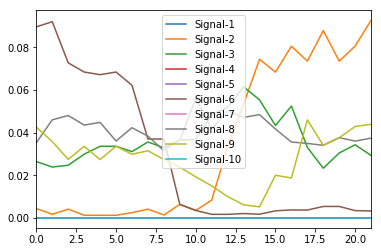

Topics Terms for SallytheShizzle


Topic Number                    Topic Terms                    
0         1       burn, sweet, notice, states, baby, litter, waa...
1         2       reasons, poisoning, elected, blamming, rising,...
2         3       load, buuut, men, yay, remember, people, sleep...
3         4       replied, set, love, cents, number, cd, tonight...
4         5       summer, btw, num, bloodtest, fair, depending, ...
5         6       imaginative, replying, mums, fucking, retarded...
6         7       pop, blink, heard, printer, greece, fine, brb,...
7         8       kind, decided, stories, lol, bring, intro, cal...
8         9       pointing, awesome, pic, kill, hell, cold, tomo...
9        10       wearing, cooking, dont, twitter, bro, enchante...
10       11       iz, ad, lack, go_to_bed, video, sponsor, girlf...
11       12       things, barking, gutts, month, britt, vis, huz...
12       13       heaps, raining, letter, sigh, annoys, tee, xd,...
13       14       guess, angle, lot, yesh, vegemite, youtube, na...
14       15       beeeach, concert, extra, money, hack, tax, fre...
15       16       sound, australia, klutz, family, phone, booo, ...
16       17       tasted, vid, private, sad, honey, single, beds...
17       18       emotion, copper, compare, apple, german, house...
18       19       dad, meanie, visit, yeah, sammie, fail, sexual...
19       20       , enjoy, bait, dance, scared, demi, bled, swin...
20       21       insane, headed, tea, sleep, cds, hate, ep, um,...
21       22       gunshot, forget, maccas, point, mind, scene, b...
22       23       pwwwns, deal, mute, site, chat, find, blocked,...
23       24       ewww, hearing, tey, funny, ksw, yaaay, pay, qu...
24       25       drunk, feel, win, couples, slowed, bias, lifet...

Seeded Terms Per Topic for SallytheShizzle


Topic Number         Seed Terms:Count       
0   signal_9    hell:13, cut:5, kill:10, die:6
1   signal_8           annoying:26, annoyed:18
2   signal_3                         sleepy:12
3   signal_2                    disappointed:9
4   signal_6                   piece_of_shit:7

Topics Probabilties Over Time for 5toSucceed


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   20/04/2009 - 03/05/2009     0.0       0.0    0.0204082     0.0     
1   21/04/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
2   02/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
3   02/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
4   02/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
5   02/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
6   02/05/2009 - 03/05/2009     0.0       0.0    0.0000000     0.0     
7   02/05/2009 - 10/05/2009     0.0       0.0    0.0000000     0.0     
8   02/05/2009 - 11/05/2009     0.0       0.0    0.1666667     0.0     
9   02/05/2009 - 11/05/2009     0.0       0.0    0.1666667     0.0     
10  02/05/2009 - 11/05/2009     0.0       0.0    0.1666667     0.0     
11  02/05/2009 - 11/05/2009     0.0       0.0    0.1666667     0.0     
12  02/05/2009 - 11/05/2009     0.0       0.0    0.1666667     0.0     
13  03/05/2009 - 11/05/2009     0.0       0.0    0.0000000     0.0     
14  10/05/2009 - 17/05/2009     0.0       0.0    0.0000000     0.0     
15  10/05/2009 - 18/05/2009     0.0       0.0    0.0000000     0.0     
16  10/05/2009 - 18/05/2009     0.0       0.0    0.0000000     0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0    0.0000000     0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0    0.0000000     0.0     
19  10/05/2009 - 22/05/2009     0.0       0.0    0.0985915     0.0     
20  10/05/2009 - 22/05/2009     0.0       0.0    0.0985915     0.0     
21  11/05/2009 - 22/05/2009     0.0       0.0    0.0303030     0.0     
22  17/05/2009 - 22/05/2009     0.0       0.0    0.0153846     0.0     
23  17/05/2009 - 22/05/2009     0.0       0.0    0.0153846     0.0     
24  17/05/2009 - 22/05/2009     0.0       0.0    0.0153846     0.0     
25  17/05/2009 - 28/05/2009     0.0       0.0    0.0103093     0.0     
26  17/05/2009 - 29/05/2009     0.0       0.0    0.0150376     0.0     
27  17/05/2009 - 30/05/2009     0.0       0.0    0.0114286     0.0     
28  18/05/2009 - 31/05/2009     0.0       0.0    0.0072202     0.0     
29  22/05/2009 - 01/06/2009     0.0       0.0    0.0064516     0.0     
30  22/05/2009 - 01/06/2009     0.0       0.0    0.0096774     0.0     
31  22/05/2009 - 03/06/2009     0.0       0.0    0.0059347     0.0     
32  22/05/2009 - 04/06/2009     0.0       0.0    0.0114943     0.0     
33  28/05/2009 - 05/06/2009     0.0       0.0    0.0202899     0.0     
34  28/05/2009 - 06/06/2009     0.0       0.0    0.0133333     0.0     
35  28/05/2009 - 07/06/2009     0.0       0.0    0.0116550     0.0     
36  28/05/2009 - 07/06/2009     0.0       0.0    0.0093240     0.0     
37  28/05/2009 - 07/06/2009     0.0       0.0    0.0069930     0.0     
38  28/05/2009 - 07/06/2009     0.0       0.0    0.0093240     0.0     
39  29/05/2009 - 07/06/2009     0.0       0.0    0.0100756     0.0     
40  30/05/2009 - 07/06/2009     0.0       0.0    0.0055402     0.0     
41  31/05/2009 - 07/06/2009     0.0       0.0    0.0031447     0.0     
42  01/06/2009 - 14/06/2009     0.0       0.0    0.0045045     0.0     
43  03/06/2009 - 15/06/2009     0.0       0.0    0.0155440     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0  

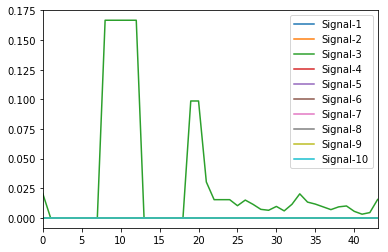

Topics Terms for 5toSucceed


Topic Number                    Topic Terms                    
0         1       funny, hoping, sit, mommy, resist, wiggle, the...
1         2       whopper, avie, sirloin, safe, phil, morning, s...
2         3       , evening, missed, inspired, huh, awake, team,...
3         4       miso, fundraising, twitter, sushi, suggestions...
4         5       planning, realized, cents, nervous, friday, du...
5         6       knowing, awesome, handed, rofllmmfaopmsllollma...
6         7       head, ashamed, enlightening, people, wow, lunc...
7         8       nani, woods, love, nike, dance, dessert, hang,...
8         9       fire, bff, technical, tweet, ur, lil, boogery,...
9        10                                               nite, lol
10       11       confirmation, wa, person, read, ideas, plane, ...
11       12                 good, classic, miles, forgot, umm, glad
12       13            grrr, tough, angel, input, bark, talk, happy
13       14       jet, thx, ya, haha, convo, tonight, rma, rugra...
14       15       dm, mushroom, tempura, days, rest, vacation, l...
15       16       enjoy, neighbors, forget, sunblock, trip, nega...
16       17       song, drive, walk, specials, bad, aiea, hill, ...
17       18       feed, yeah, nan, ness, enjoyed, dinner, cindy,...
18       19                                    fun, num, golf, care
19       20       waikiki, flight, ole, min, doin, teasing, vamp...
20       21       mini, kudos, mom, craziness, matches, hs, ahh,...
21       22       fit, tweeps, feel, secret, leaving, kardiac, g...
22       23       vacay, lovers, night, pic, baseball, guests, c...
23       24       btw, interesting, peeps, yesterday, prob, wife...
24       25       kind, door, room, working, scenes, great, dog,...

Seeded Terms Per Topic for 5toSucceed


Topic Number Seed Terms:Count
0   signal_3       awake:14

Topics Probabilties Over Time for rgoodchild


Time Period         Signal-1   Signal-2   Signal-3  Signal-4   \
0   07/04/2009 - 20/04/2009  0.0186916  0.0186916     0.0    0.0093458   
1   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
2   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
3   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
4   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
5   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
6   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
7   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
8   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
9   18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
10  18/04/2009 - 21/04/2009  0.0136986  0.0136986     0.0    0.0136986   
11  18/04/2009 - 01/05/2009  0.0175439  0.0087719     0.0    0.0087719   
12  19/04/2009 - 02/05/2009  0.0095238  0.0095238     0.0    0.0095238   
13  20/04/2009 - 03/05/2009  0.0100000  0.0100000     0.0    0.0100000   
14  21/04/2009 - 04/05/2009  0.0097087  0.0097087     0.0    0.0097087   
15  01/05/2009 - 04/05/2009  0.0101010  0.0101010     0.0    0.0101010   
16  01/05/2009 - 04/05/2009  0.0101010  0.0101010     0.0    0.0101010   
17  01/05/2009 - 04/05/2009  0.0101010  0.0101010     0.0    0.0101010   
18  01/05/2009 - 04/05/2009  0.0202020  0.0101010     0.0    0.0101010   
19  01/05/2009 - 09/05/2009  0.0317460  0.0079365     0.0    0.0158730   
20  01/05/2009 - 10/05/2009  0.0076923  0.0076923     0.0    0.0076923   
21  01/05/2009 - 10/05/2009  0.0153846  0.0076923     0.0    0.0076923   
22  01/05/2009 - 10/05/2009  0.0307692  0.0076923     0.0    0.0076923   
23  01/05/2009 - 13/05/2009  0.0074074  0.0074074     0.0    0.0074074   
24  01/05/2009 - 14/05/2009  0.0067568  0.0067568     0.0    0.0067568   
25  02/05/2009 - 14/05/2009  0.0186916  0.0093458     0.0    0.0093458   
26  03/05/2009 - 16/05/2009  0.0183486  0.0091743     0.0    0.0091743   
27  04/05/2009 - 17/05/2009  0.0144928  0.0072464     0.0    0.0072464   
28  09/05/2009 - 18/05/2009  0.0075758  0.0075758     0.0    0.0075758   
29  09/05/2009 - 18/05/2009  0.0075758  0.0075758     0.0    0.0075758   
30  09/05/2009 - 18/05/2009  0.0151515  0.0075758     0.0    0.0075758   
31  09/05/2009 - 18/05/2009  0.0151515  0.0151515     0.0    0.0151515   
32  09/05/2009 - 22/05/2009  0.0065789  0.0065789     0.0    0.0065789   
33  10/05/2009 - 22/05/2009  0.0320000  0.0080000     0.0    0.0080000   
34  13/05/2009 - 22/05/2009  0.0165289  0.0082645     0.0    0.0082645   
35  13/05/2009 - 22/05/2009  0.0082645  0.0082645     0.0    0.0082645   
36  13/05/2009 - 26/05/2009  0.0551181  0.0157480     0.0    0.0078740   
37  14/05/2009 - 26/05/2009  0.1157025  0.0165289     0.0    0.0082645   
38  16/05/2009 - 28/05/2009  0.0769231  0.1076923     0.0    0.0076923   
39  16/05/2009 - 29/05/2009  0.1095890  0.1164384     0.0    0.0068493   
40  17/05/2009 - 30/05/2009  0.0935961  0.1231527     0.0    0.0197044   
41  18/05/2009 - 31/05/2009  0.1055556  0.1333333     0.0    0.0333333   
42  22/05/2009 - 01/06/2009  0.1046025  0.1213389     0.0    0.0502092   
43  22/05/2009 - 02/06/2009  0.0853659  0.0853659     0.0    0.0731707   
44  22/05/2009 - 03/06/2009  0.0803571  0.0863095     0.0    0.0863095   
45  22/05/2009 - 03/06/2009  0.0595238  0.0922619     0.0    0.0833333   
46  26/05/2009 - 05/06/2009  0.0712251  0.0883191     0.0    0.0826211   
47  26/05/2009 - 06/06/2009  0.0490196  0.0857843     0.0    0.0882353   
48  26/05/2009 - 07/06/2009  0.0421941  0.0822785     0.0    0.0907173   

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0    0.0280374     0.0    0.0186916     0.0       0.0     
1      0.0    0.0136986     0.0    0.0136986     0.0       0.0     
2      0.0    0.0136986     0.0    0.0136986     0.0       0.0     
3      0.0    0.0136986     0.0    0

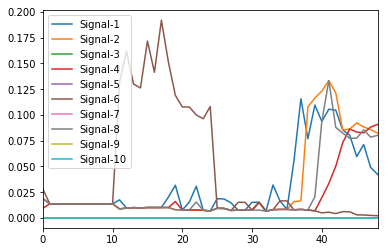

Topics Terms for rgoodchild


Topic Number                    Topic Terms                    
0         1       btw, lack, darrin, spell, meh, tiki, wrong, li...
1         2       people, sign, leads, single, questions, mutual...
2         3       ugh, writer, publicist, squeezing, kid, tuna, ...
3         4       andthen, played, fucking, move, scene, heard, ...
4         5       week, blog, vet, web, susceptible, reschedule,...
5         6       meant, gross, cheese, favourite, angus, hot, f...
6         7       relationships, months, yay, author, meetings, ...
7         8       number, sex, bring, gigs, suck, moan, cate, ne...
8         9                    , thing, mate, pretty, online, toyou
9        10       fashion, delighted, talkd, thankful, find, wee...
10       11       concert, suddenly, footage, num, promise, taiw...
11       12       jsut, idea, socks, talking, sheesh, gold, thin...
12       13       irish, chasy, forget, house, walk, protein, od...
13       14       staying, cereal, absolutely, haircut, sooo, pa...
14       15       stimulous, package, brilliant, tweet, knew, fi...
15       16              kind, good, working, nan, thought, melissa
16       17       ahh, hmmmph, tad, names, owens, mint, trip, ha...
17       18       force, feel, farrier, ink, year, thier, sounds...
18       19       snack, greater, amount, huh, yeah, times, live...
19       20       havne, family, drunk, relate, bloody, mafia, s...
20       21       dad, boy, westlakers, hoping, big, friday, wes...
21       22       acc, perfect, vibrators, mothers, invitaiton, ...
22       23       point, sweet, laptop, logical, remeber, commut...
23       24       goss, toast, repeat, love, apple, sound, st, c...
24       25       pic, star, winter, sitting, universe, night, p...

Seeded Terms Per Topic for rgoodchild


Topic Number Seed Terms:Count
0   signal_1          meh:13   
1   signal_8       nervous:3   
2   signal_2      mourning:7   
3   signal_4         tired:5   
4   signal_6         gross:1

Topics Probabilties Over Time for MandyPandy32


Time Period         Signal-1   Signal-2   Signal-3  Signal-4  \
0   18/04/2009 - 20/04/2009  0.0000000  0.0000000     0.0       0.0     
1   19/04/2009 - 02/05/2009  0.0000000  0.0000000     0.0       0.0     
2   20/04/2009 - 03/05/2009  0.0000000  0.0000000     0.0       0.0     
3   02/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
4   02/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
5   02/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
6   02/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
7   02/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
8   02/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
9   02/05/2009 - 10/05/2009  0.0142857  0.0857143     0.0       0.0     
10  02/05/2009 - 10/05/2009  0.0142857  0.0857143     0.0       0.0     
11  02/05/2009 - 10/05/2009  0.0142857  0.1285714     0.0       0.0     
12  02/05/2009 - 10/05/2009  0.0142857  0.0714286     0.0       0.0     
13  02/05/2009 - 14/05/2009  0.0131579  0.0921053     0.0       0.0     
14  02/05/2009 - 14/05/2009  0.0131579  0.1052632     0.0       0.0     
15  03/05/2009 - 14/05/2009  0.0136986  0.0958904     0.0       0.0     
16  04/05/2009 - 17/05/2009  0.0098039  0.0784314     0.0       0.0     
17  10/05/2009 - 18/05/2009  0.0104712  0.0261780     0.0       0.0     
18  10/05/2009 - 18/05/2009  0.0052356  0.0418848     0.0       0.0     
19  10/05/2009 - 18/05/2009  0.0052356  0.0366492     0.0       0.0     
20  10/05/2009 - 18/05/2009  0.0052356  0.0418848     0.0       0.0     
21  10/05/2009 - 18/05/2009  0.0052356  0.0418848     0.0       0.0     
22  10/05/2009 - 18/05/2009  0.0052356  0.0261780     0.0       0.0     
23  14/05/2009 - 18/05/2009  0.0059524  0.0059524     0.0       0.0     
24  14/05/2009 - 18/05/2009  0.0059524  0.0059524     0.0       0.0     
25  14/05/2009 - 18/05/2009  0.0059524  0.0059524     0.0       0.0     
26  14/05/2009 - 18/05/2009  0.0059524  0.0059524     0.0       0.0     
27  17/05/2009 - 18/05/2009  0.0061728  0.0061728     0.0       0.0     
28  17/05/2009 - 29/05/2009  0.0205128  0.0102564     0.0       0.0     
29  17/05/2009 - 30/05/2009  0.0321543  0.0160772     0.0       0.0     
30  18/05/2009 - 31/05/2009  0.0245399  0.0245399     0.0       0.0     
31  29/05/2009 - 01/06/2009  0.0685921  0.0324910     0.0       0.0     
32  29/05/2009 - 02/06/2009  0.0521472  0.0306748     0.0       0.0     
33  29/05/2009 - 03/06/2009  0.0562130  0.0147929     0.0       0.0     
34  29/05/2009 - 03/06/2009  0.0532544  0.0177515     0.0       0.0     
35  29/05/2009 - 05/06/2009  0.0549133  0.0202312     0.0       0.0     
36  29/05/2009 - 06/06/2009  0.0465116  0.0180879     0.0       0.0     
37  29/05/2009 - 07/06/2009  0.0432570  0.0305344     0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
1      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
2      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
3      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
4      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
5      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
6      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
7      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
8      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
9      0.0    0.0428571     0.0       0.0    0.0285714     0.0     
10     0.0    0.0571429     0.0       0.0    0.0142857     0.0     
11     0.0    0.0571429     0.0       0.0    0.0142857     0.0     
12     0.0    0.0571429     0.0       0.0    0.0285714     0.0     
13     0.0    0.0657895     0.0       0.0    0.0131579     0.0     
14     0.0    0.0394737     0.0       0.0    0.0131579     0.0     
15     0.0    0.0547945     0.0       0.0    0.0273973     0.0     
16   

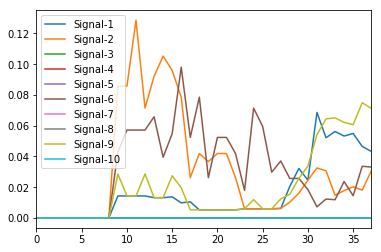

Topics Terms for MandyPandy32


Topic Number                    Topic Terms                    
0         1       glib, knowing, staying, lol, illogical, job, f...
1         2       life, brunt, bloomin, feeling_lonely, glorious...
2         3       congratulatory, slower, great, faint, thankss,...
3         4       supportive, support, birthday, passed, splodge...
4         5       btw, congratulations, jack, birth, baby, check...
5         6                                     food, shame, amazed
6         7       huge, fantastic, cheered, rude, loved, big, na...
7         8          aww, friday, morning, phone, catching, message
8         9       streets, cut, hobbits, longer, feel, sun, hone...
9        10       blue, cheers, favoured, garden, mare, wall, sa...
10       11       enjoy, sort, work, flesh, tweet, stays, sunny,...
11       12       poor, school, font, net, shirt, people, twitte...
12       13       nights, tired, remembered, god, caught, slept,...
13       14       fab, access, votes, tweeting, diversity, missi...
14       15                                             good, pants
15       16       lessons, meant, thankd, rabbit, read, prefer, ...
16       17       family, indoor, sad, celeb, fail, awaits, squi...
17       18       love, eh, cancer, physically, house, number, e...
18       19                                         sounds, charity
19       20       thanking, thinking, phones, time, playing, lat...
20       21       hip, kind, kids, risk, superglue, september, t...
21       22       raised, lots, problem, days, stops, loo, finis...
22       23       revealing, complete, nan, doofus, embarrassed,...
23       24       atmosphere, medication, achy, year, hours, twe...
24       25       manky, par, evening, point, daft, scare, keen,...

Seeded Terms Per Topic for MandyPandy32


Topic Number  Seed Terms:Count
0   signal_1        heartless:10
1   signal_9              hell:2
2   signal_2    feeling_lonely:9
3   signal_6            shame:37

Topics Probabilties Over Time for bryancheung


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   18/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
2   20/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
3   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
4   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
5   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
6   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
7   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
8   02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
9   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
13  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
14  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
15  04/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
16  04/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
23  18/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
24  18/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
31  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
34  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
35  27/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
36  27/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
37  27/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
38  27/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  27/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
40  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
44  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
45  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
47  05/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
48  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
49  06/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
50  07/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
51  15/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
52  15/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
53  15/06/2009 - 20/06/2009     0.0     

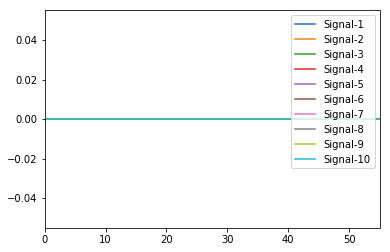

Topics Terms for bryancheung


Topic Number                    Topic Terms                    
0         1       load, web, love, tab, summer, unstable, user, ...
1         2       version, happen, pixelmator, youtube, rank, cr...
2         3                                      time, zombies, sad
3         4       life, space, things, app, separate, isps, hour...
4         5       function, forum, detects, worse, cough, laptop...
5         6       google, room, ahh, testing, bundle, controllin...
6         7            play, shift, finished, game, speed, tutorial
7         8       firing, point, sign, talked, ingmar, story, do...
8         9                               average, charging, faster
9        10       plants, hong, moleskine, ipod, monitors, purch...
10       11       bumped, pay, update, days, wwdc, animation, gb...
11       12       netbarrier, invite, hillarious, mupromo, tweet...
12       13       replied, acc, reading, plans, people, ya, typi...
13       14                                        twitter, awesome
14       15       linux, ublocked, offering, cursebird, paypal, ...
15       16                 happened, picture, work, yeah, internet
16       17       cow, vampire, mistaken, thought, bad, chicken,...
17       18       platinum, case, hoping, extra, connection, phe...
18       19                 info, quit, great, cmon, parallels, nan
19       20                  lunch, rahul, happy, birthday, halfway
20       21                                     read, dm, spymaster
21       22       money, cheat, hoem, years, logo, develop, surp...
22       23                                              free, fast
23       24       designs, slice, alex, bing, spot, installing, ...
24       25            interface, basketball, num, friendfeed, code

Seeded Terms Per Topic for bryancheung


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for pdurham


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   02/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
1   04/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
2   04/05/2009 - 10/05/2009     0.0    0.0000000     0.0       0.0     
3   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
4   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
5   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
6   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
7   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
8   10/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
9   18/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
10  18/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
11  18/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
12  18/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
13  18/05/2009 - 18/05/2009     0.0    0.0000000     0.0       0.0     
14  18/05/2009 - 29/05/2009     0.0    0.0196078     0.0       0.0     
15  18/05/2009 - 30/05/2009     0.0    0.0105263     0.0       0.0     
16  18/05/2009 - 31/05/2009     0.0    0.0076336     0.0       0.0     
17  29/05/2009 - 01/06/2009     0.0    0.0136986     0.0       0.0     
18  29/05/2009 - 02/06/2009     0.0    0.0282486     0.0       0.0     
19  29/05/2009 - 02/06/2009     0.0    0.0056497     0.0       0.0     
20  29/05/2009 - 04/06/2009     0.0    0.0112360     0.0       0.0     
21  29/05/2009 - 05/06/2009     0.0    0.0206186     0.0       0.0     
22  29/05/2009 - 06/06/2009     0.0    0.0330579     0.0       0.0     
23  29/05/2009 - 07/06/2009     0.0    0.0576271     0.0       0.0     
24  29/05/2009 - 07/06/2009     0.0    0.0508475     0.0       0.0     
25  29/05/2009 - 07/06/2009     0.0    0.0576271     0.0       0.0     
26  29/05/2009 - 07/06/2009     0.0    0.0610169     0.0       0.0     
27  29/05/2009 - 07/06/2009     0.0    0.0406780     0.0       0.0     
28  30/05/2009 - 07/06/2009     0.0    0.0622711     0.0       0.0     
29  31/05/2009 - 07/06/2009     0.0    0.0917031     0.0       0.0     
30  01/06/2009 - 07/06/2009     0.0    0.0777202     0.0       0.0     
31  02/06/2009 - 15/06/2009     0.0    0.1025641     0.0       0.0     
32  04/06/2009 - 16/06/2009     0.0    0.0824176     0.0       0.0     
33  04/06/2009 - 17/06/2009     0.0    0.0748663     0.0       0.0     
34  05/06/2009 - 17/06/2009     0.0    0.0698925     0.0       0.0     
35  06/06/2009 - 19/06/2009     0.0    0.0491803     0.0       0.0     
36  07/06/2009 - 19/06/2009     0.0    0.0222222     0.0       0.0     
37  15/06/2009 - 19/06/2009     0.0    0.0121951     0.0       0.0     
38  15/06/2009 - 22/06/2009     0.0    0.0114943     0.0       0.0     
39  15/06/2009 - 23/06/2009     0.0    0.0112360     0.0       0.0     
40  15/06/2009 - 23/06/2009     0.0    0.0112360     0.0       0.0     
41  15/06/2009 - 25/06/2009     0.0    0.0101010     0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0       0.0     
4      0.0       0.0       0.0       0.0       0.0       0.0     
5      0.0       0.0       0.0       0.0       0.0       0.0     
6      0.0       0.0       0.0       0.0       0.0       0.0     
7      0.0       0.0       0.0       0.0       0.0       0.0     
8      0.0       0.0       0.0       0.0       0.0       0.0     
9      0.0       0.0       0.0       0.0       0.0       0.0     
10     0.0       0.0       0.0       0.0       0.0       0.0     
11     0.0       0.0       0.0       0.0       0.0       0.0     
12     0.0       0.0       0.0       0.0       0.0    

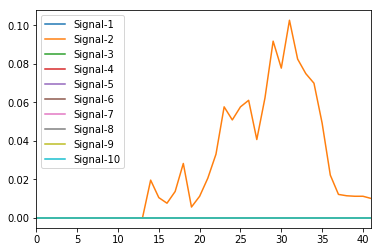

Topics Terms for pdurham


Topic Number                    Topic Terms                    
0         1       draw, figured, reread, hun, constructive, runn...
1         2          set, field, yup, bed, boys, gloomy, hug, nasty
2         3         exciting, frown, lil, tisk, damn, aussie, bored
3         4       prolly, goodness, chicago, require, pic, bacon...
4         5       dad, funny, naughty, monday, dance, fave, kiss...
5         6       lounge, lazy, productive, parade, nicely, resi...
6         7           omg, feel, grandma, yeah, stuff, behave, half
7         8                                bad, phew, twitter, nice
8         9                        cheese, enjoying, yay, woke, num
9        10       kids, deleted, kitty, mac, horny, thing, awww,...
10       11       eh, gay, chocolate, corner, skippy, supportive...
11       12                            ass, sound, redwings, mobile
12       13       outta, thinking, priorities, person, version, ...
13       14       kidnap, laundry, talented, relax, savannah, du...
14       15       jayme, door, laying, good, darn, damnit, slack...
15       16       fried, pretty, muah, accidentally, month, show...
16       17       hide, missed, awesome, mind, bi, nerd, wrong, ...
17       18                                        great, hiya, nan
18       19                    lead, aww, work, walmart, loves, day
19       20       closer, slept, bff, author, leather, smell, dr...
20       21       control, friend, congrats, car, wow, knew, was...
21       22                                 ya, cute, sounds, yummy
22       23                             fun, sucks, love, lol, butt
23       24       beautiful, life, attempt, waiter, money, twitt...
24       25       trainer, web, story, crap, understand, xoxo, g...

Seeded Terms Per Topic for pdurham


Topic Number Seed Terms:Count
0   signal_2       gloomy:14

Topics Probabilties Over Time for roxiijonas


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   02/05/2009 - 14/05/2009     0.0    0.0153846     0.0    0.0153846   
1   03/05/2009 - 14/05/2009     0.0    0.0158730     0.0    0.0158730   
2   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0175439   
3   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0350877   
4   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0175439   
5   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0175439   
6   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0175439   
7   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0350877   
8   10/05/2009 - 14/05/2009     0.0    0.0175439     0.0    0.0175439   
9   14/05/2009 - 14/05/2009     0.0    0.0000000     0.0    0.0000000   
10  14/05/2009 - 14/05/2009     0.0    0.0000000     0.0    0.0000000   
11  14/05/2009 - 14/05/2009     0.0    0.0000000     0.0    0.0000000   
12  14/05/2009 - 14/05/2009     0.0    0.0000000     0.0    0.0000000   
13  29/05/2009 - 29/05/2009     0.0    0.0000000     0.0    0.0000000   
14  29/05/2009 - 30/05/2009     0.0    0.0958904     0.0    0.0136986   
15  29/05/2009 - 31/05/2009     0.0    0.0789474     0.0    0.0087719   
16  29/05/2009 - 01/06/2009     0.0    0.0571429     0.0    0.0047619   
17  29/05/2009 - 02/06/2009     0.0    0.0553191     0.0    0.0042553   
18  29/05/2009 - 03/06/2009     0.0    0.0485830     0.0    0.0080972   
19  29/05/2009 - 03/06/2009     0.0    0.0566802     0.0    0.0040486   
20  29/05/2009 - 05/06/2009     0.0    0.0465116     0.0    0.0038760   
21  29/05/2009 - 06/06/2009     0.0    0.0436242     0.0    0.0033557   
22  29/05/2009 - 06/06/2009     0.0    0.0469799     0.0    0.0033557   
23  29/05/2009 - 06/06/2009     0.0    0.0402685     0.0    0.0067114   
24  29/05/2009 - 06/06/2009     0.0    0.0369128     0.0    0.0067114   
25  29/05/2009 - 06/06/2009     0.0    0.0469799     0.0    0.0100671   
26  29/05/2009 - 06/06/2009     0.0    0.0469799     0.0    0.0067114   
27  30/05/2009 - 06/06/2009     0.0    0.0370370     0.0    0.0033670   
28  31/05/2009 - 06/06/2009     0.0    0.0200000     0.0    0.0080000   
29  01/06/2009 - 14/06/2009     0.0    0.0333333     0.0    0.0666667   
30  02/06/2009 - 15/06/2009     0.0    0.0154639     0.0    0.1185567   
31  03/06/2009 - 16/06/2009     0.0    0.0286885     0.0    0.1270492   
32  05/06/2009 - 17/06/2009     0.0    0.0313725     0.0    0.1294118   
33  05/06/2009 - 18/06/2009     0.0    0.0449438     0.0    0.1273408   
34  06/06/2009 - 19/06/2009     0.0    0.0342205     0.0    0.1368821   
35  14/06/2009 - 20/06/2009     0.0    0.0551471     0.0    0.1286765   
36  14/06/2009 - 21/06/2009     0.0    0.0434783     0.0    0.1304348   
37  14/06/2009 - 21/06/2009     0.0    0.0507246     0.0    0.1159420   
38  14/06/2009 - 23/06/2009     0.0    0.0392857     0.0    0.1071429   
39  14/06/2009 - 23/06/2009     0.0    0.0535714     0.0    0.1178571   
40  14/06/2009 - 25/06/2009     0.0    0.0460526     0.0    0.1217105   

    Signal-5  Signal-6  Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0       0.0       0.0    0.0307692     0.0       0.0     
1      0.0       0.0       0.0    0.0317460     0.0       0.0     
2      0.0       0.0       0.0    0.0526316     0.0       0.0     
3      0.0       0.0       0.0    0.0350877     0.0       0.0     
4      0.0       0.0       0.0    0.0350877     0.0       0.0     
5      0.0       0.0       0.0    0.0350877     0.0       0.0     
6      0.0       0.0       0.0    0.0350877     0.0       0.0     
7      0.0       0.0       0.0    0.0526316     0.0       0.0     
8      0.0       0.0       0.0    0.0350877     0.0       0.0     
9      0.0       0.0       0.0    0.0000000     0.0       0.0     
10     0.0       0.0       0.0    0.0000000     0.0       0.0     
11     0.0       0.0       0.0    0.0000000     0.0       0.0     
12     0.0       0.0       0.0    0.0000000     0.0       0.0     
13  

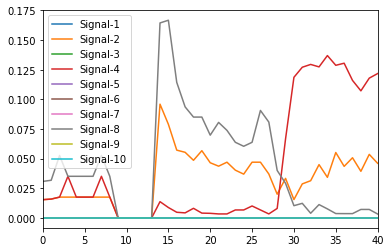

Topics Terms for roxiijonas


Topic Number                    Topic Terms                    
0         1       demi, hugged, promised, aw, reached, spoke, ex...
1         2       dreading, thought, love, urgh, hair, add, ppp,...
2         3                                     website, jeans, fat
3         4       soundcheck, jeez, jimmy, begged, fade, septemb...
4         5       brazil, scary, good, flight, indian, fair, twi...
5         6       break, reading, concert, people, angry, nan, t...
6         7           prepare, chad, paw, hot, london, letter, test
7         8       episode, deal, area, paranoid, knight, age, in...
8         9       arena, night, showing, tweeting, eating, ru, p...
9        10                       june, xxx, watching, jonas, phone
10       11       annoy, rumour, school, jbs, upset, ldn, hours,...
11       12       profile, presale, working, street, brothers, h...
12       13                              peek, grady, lol, skinnier
13       14          week, fault, pic, hey, teams, bad, time, sneak
14       15                                         num, wait, cool
15       16       aristotle, reasons, cd, questions, fail, freud...
16       17       tour, finally, hhaa, potter, kinda, yeah, thur...
17       18       yay, feel, starts, haha, dogs, massive, july, day
18       19       applied, tickets, revised, garden, huge, panca...
19       20       beautiful, stupid, lvatt, trending, omg, affor...
20       21                 headling, nooo, talking, uk, post, hope
21       22       europe, account, room, tuesday, rings, station...
22       23       distractions, monkey, ages, topics, nokia, ffs...
23       24                                november, buy, dont, ooh
24       25       kisses, voice, exam, monday, december, tweet, ...

Seeded Terms Per Topic for roxiijonas


Topic Number           Seed Terms:Count          
0   signal_8    paranoid:9, nervous:14, annoying:28
1   signal_2                            dreading:14
2   signal_4                               tired:32

Topics Probabilties Over Time for tweetpet


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0  17/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
1  18/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
2  19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     

   Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0     0.0       0.0       0.0       0.0       0.0     
1     0.0       0.0       0.0       0.0       0.0     
2     0.0       0.0       0.0       0.0       0.0

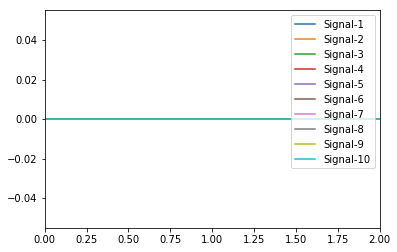

Topics Terms for tweetpet


Topic Number Topic Terms
0       17           type  
1        3          clean  
2        5         hungry  
3       23           feed

Seeded Terms Per Topic for tweetpet


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for SarahSaner


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   07/04/2009 - 20/04/2009  0.0164609     0.0       0.0       0.0     
1   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
2   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
3   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
4   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
5   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
6   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
7   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
8   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
9   19/04/2009 - 20/04/2009  0.0061350     0.0       0.0       0.0     
10  19/04/2009 - 20/04/2009  0.0122699     0.0       0.0       0.0     
11  19/04/2009 - 20/04/2009  0.0122699     0.0       0.0       0.0     
12  19/04/2009 - 02/05/2009  0.0170940     0.0       0.0       0.0     
13  20/04/2009 - 02/05/2009  0.0640000     0.0       0.0       0.0     
14  02/05/2009 - 04/05/2009  0.0621118     0.0       0.0       0.0     
15  02/05/2009 - 04/05/2009  0.0559006     0.0       0.0       0.0     
16  02/05/2009 - 04/05/2009  0.0559006     0.0       0.0       0.0     
17  02/05/2009 - 04/05/2009  0.0559006     0.0       0.0       0.0     
18  02/05/2009 - 04/05/2009  0.0559006     0.0       0.0       0.0     
19  02/05/2009 - 04/05/2009  0.0621118     0.0       0.0       0.0     
20  02/05/2009 - 10/05/2009  0.0101523     0.0       0.0       0.0     
21  02/05/2009 - 10/05/2009  0.0355330     0.0       0.0       0.0     
22  02/05/2009 - 10/05/2009  0.0152284     0.0       0.0       0.0     
23  02/05/2009 - 10/05/2009  0.0101523     0.0       0.0       0.0     
24  02/05/2009 - 14/05/2009  0.0156250     0.0       0.0       0.0     
..                      ...        ...       ...       ...       ...   
37  14/05/2009 - 18/05/2009  0.0258065     0.0       0.0       0.0     
38  17/05/2009 - 18/05/2009  0.0520833     0.0       0.0       0.0     
39  17/05/2009 - 18/05/2009  0.0729167     0.0       0.0       0.0     
40  17/05/2009 - 30/05/2009  0.0454545     0.0       0.0       0.0     
41  18/05/2009 - 30/05/2009  0.0601504     0.0       0.0       0.0     
42  30/05/2009 - 01/06/2009  0.0163934     0.0       0.0       0.0     
43  30/05/2009 - 01/06/2009  0.0081967     0.0       0.0       0.0     
44  30/05/2009 - 03/06/2009  0.0384615     0.0       0.0       0.0     
45  30/05/2009 - 03/06/2009  0.0213675     0.0       0.0       0.0     
46  30/05/2009 - 03/06/2009  0.0384615     0.0       0.0       0.0     
47  30/05/2009 - 06/06/2009  0.0487805     0.0       0.0       0.0     
48  30/05/2009 - 07/06/2009  0.0364742     0.0       0.0       0.0     
49  30/05/2009 - 07/06/2009  0.0303951     0.0       0.0       0.0     
50  30/05/2009 - 07/06/2009  0.0425532     0.0       0.0       0.0     
51  30/05/2009 - 07/06/2009  0.0364742     0.0       0.0       0.0     
52  30/05/2009 - 07/06/2009  0.0395137     0.0       0.0       0.0     
53  30/05/2009 - 07/06/2009  0.0395137     0.0       0.0       0.0     
54  01/06/2009 - 07/06/2009  0.0479705     0.0       0.0       0.0     
55  01/06/2009 - 07/06/2009  0.0405904     0.0       0.0       0.0     
56  03/06/2009 - 07/06/2009  0.0387931     0.0       0.0       0.0     
57  03/06/2009 - 07/06/2009  0.0344828     0.0       0.0       0.0     
58  06/06/2009 - 17/06/2009  0.0322581     0.0       0.0       0.0     
59  06/06/2009 - 18/06/2009  0.0465116     0.0       0.0       0.0     
60  06/06/2009 - 19/06/2009  0.0454545     0.0       0.0       0.0     
61  07/06/2009 - 20/06/2009  0.0459770     0.0       0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     


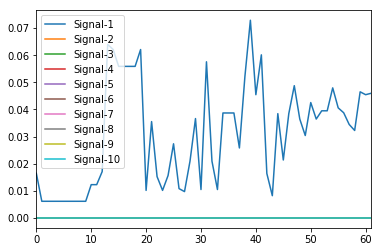

Topics Terms for SarahSaner


Topic Number                    Topic Terms                    
0         1                                    bored, xxx, ha, mwah
1         2                                                  lovely
2         3       enjoy, eh, people, nibble, steaks, bring, sess...
3         4                                                xx, love
4         5       fella, ole, bagpuss, big, mind, speak, person,...
5         6       fantastic, seekers, absolutely, everyday, spir...
6         7       saturday, late, term, heaven, slop, yep, think...
7         8                                         broken, morning
8         9       vinegar, babe, dont, working, debates, tena, p...
9        10       hark, image, move, foul, chat, foiled, hearted...
10       11       control, cute, gosh, shit, nights, jet, tweet,...
11       12       cheese, sob, hoping, tea, tomorrow, knitted, w...
12       13                lucas, rev, noticed, likes, opinion, red
13       14       btw, aha, shot, spoken, win, hoop, brush, dres...
14       15       scan, saute, bloody, meditation, karen, ignore...
15       16       raining, crazy, gold, process, prefer, sad, ch...
16       17       beautiful, weather, stack, letting, matt, hay,...
17       18       yeh, head, joking, presence, cleanse, celebs, ...
18       19       fly, clouds, voice, fabulous, exists, countrie...
19       20       crumpet, twitter, seat, steve, baby, cowbridge...
20       21       motivation, strangeness, vine, private, jennif...
21       22                                                  bright
22       23       week, ladies, pork, rest, feet, woman, plans, ...
23       24       taste, intellectual, alike, follow, girl, clic...
24       25       good, convo, andrew, lol, cal, answer, empy, s...

Seeded Terms Per Topic for SarahSaner


Topic Number Seed Terms:Count
0   signal_1       bored:14

Topics Probabilties Over Time for sharonhayes


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   17/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   18/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
2   19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
3   20/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
4   01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
5   01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
6   01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
7   01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
8   01/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
9   01/05/2009 - 09/05/2009     0.0       0.0       0.0       0.0       0.0     
10  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
13  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
14  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
15  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
16  04/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
17  04/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
18  09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
21  09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
22  09/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
23  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
24  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
32  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
33  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
34  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
35  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
36  28/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
37  28/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
38  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
40  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
41  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
42  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
43  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
44  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
45  01/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
46  05/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
47  05/06/2009 - 14/06/2009     0.0       0.0       0.0       0.0       0.0     
48  05/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0       0.0     
49  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
50  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
51  07/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
52  14/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
53  14/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0       0.0     
54  14/06/2009 - 21/06/2009     0.0     

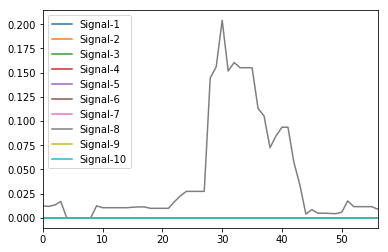

Topics Terms for sharonhayes


Topic Number                    Topic Terms                    
0         1                                           sweetie, hope
1         2       , turned, awoken, carefully, total, trip, funn...
2         3                 twitter, sods, privately, running, time
3         4       respond, upgrade, missed, tabs, joy, bundle, m...
4         5       canada, sister, repeat, grr, people, absolutel...
5         6       ppc, manage, ouch, understood, bummed, thing, ...
6         7                               great, wonderful, weekend
7         8       rt, web, btw, normal, feel, disposal, assistan...
8         9       heavy, sir, intriguing, figured, pray, pout, s...
9        10       website, life, dm, tweetdeck, sleeping, blog, ...
10       11       suspended, thx, yup, tweet, earlier, curve, wa...
11       12                                 aww, follow, good, hear
12       13       week, ahead, deal, jim, spent, steve, pass, me...
13       14       remember, fav, smoother, list, bad, stay, toni...
14       15       hour, chip, enya, rest, link, tunes, hiya, gro...
15       16       elliot, point, humorous, years, air, imagined,...
16       17       tx, things, yeah, anytime, forest, telling, ch...
17       18       adding, responses, works, boxed, sun, buggy, f...
18       19       ladies, scare, congrats, check, top, locally, ...
19       21       beautiful, enjoy, join, song, problems, mayhem...
20       22       katy, love, brain, smiling, rarely, perry, var...
21       23       cookies, work, riot, hon, forgot, thought, bus...
22       24       reggae, feeling, bummer, working, mothers, com...
23       25                                         lots, num, fill

Seeded Terms Per Topic for sharonhayes


Topic Number Seed Terms:Count
0   signal_8      anxious:14

Topics Probabilties Over Time for amysav83


Time Period         Signal-1  Signal-2   Signal-3   Signal-4  \
0   07/04/2009 - 20/04/2009     0.0    0.0746269  0.0298507     0.0     
1   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
2   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
3   18/04/2009 - 21/04/2009     0.0    0.0303030  0.0151515     0.0     
4   18/04/2009 - 21/04/2009     0.0    0.0303030  0.0151515     0.0     
5   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
6   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
7   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
8   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
9   18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
10  18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
11  18/04/2009 - 21/04/2009     0.0    0.0151515  0.0151515     0.0     
12  19/04/2009 - 02/05/2009     0.0    0.0379747  0.0886076     0.0     
13  20/04/2009 - 03/05/2009     0.0    0.0495050  0.2079208     0.0     
14  21/04/2009 - 04/05/2009     0.0    0.0309278  0.2474227     0.0     
15  02/05/2009 - 04/05/2009     0.0    0.0133333  0.3333333     0.0     
16  02/05/2009 - 04/05/2009     0.0    0.0266667  0.3333333     0.0     
17  02/05/2009 - 04/05/2009     0.0    0.0400000  0.3200000     0.0     
18  02/05/2009 - 04/05/2009     0.0    0.0133333  0.3333333     0.0     
19  02/05/2009 - 09/05/2009     0.0    0.0131579  0.3289474     0.0     
20  02/05/2009 - 10/05/2009     0.0    0.0125000  0.3125000     0.0     
21  02/05/2009 - 10/05/2009     0.0    0.0250000  0.3125000     0.0     
22  02/05/2009 - 10/05/2009     0.0    0.0125000  0.3250000     0.0     
23  02/05/2009 - 10/05/2009     0.0    0.0500000  0.3125000     0.0     
24  02/05/2009 - 10/05/2009     0.0    0.0250000  0.3125000     0.0     
..                      ...       ...        ...        ...       ...   
42  22/05/2009 - 01/06/2009     0.0    0.0176471  0.0058824     0.0     
43  22/05/2009 - 02/06/2009     0.0    0.0057143  0.0057143     0.0     
44  22/05/2009 - 02/06/2009     0.0    0.0114286  0.0057143     0.0     
45  22/05/2009 - 02/06/2009     0.0    0.0057143  0.0057143     0.0     
46  29/05/2009 - 02/06/2009     0.0    0.0070423  0.0070423     0.0     
47  29/05/2009 - 06/06/2009     0.0    0.0109890  0.0054945     0.0     
48  29/05/2009 - 07/06/2009     0.0    0.0625000  0.0041667     0.0     
49  29/05/2009 - 07/06/2009     0.0    0.0375000  0.0041667     0.0     
50  29/05/2009 - 07/06/2009     0.0    0.0500000  0.0041667     0.0     
51  29/05/2009 - 07/06/2009     0.0    0.0583333  0.0041667     0.0     
52  29/05/2009 - 07/06/2009     0.0    0.0666667  0.0041667     0.0     
53  30/05/2009 - 07/06/2009     0.0    0.0572687  0.0044053     0.0     
54  31/05/2009 - 07/06/2009     0.0    0.0782123  0.0055866     0.0     
55  01/06/2009 - 07/06/2009     0.0    0.1014493  0.0072464     0.0     
56  02/06/2009 - 15/06/2009     0.0    0.0611111  0.0055556     0.0     
57  06/06/2009 - 16/06/2009     0.0    0.0752688  0.0161290     0.0     
58  06/06/2009 - 17/06/2009     0.0    0.0552764  0.0100503     0.0     
59  06/06/2009 - 18/06/2009     0.0    0.0666667  0.0095238     0.0     
60  06/06/2009 - 19/06/2009     0.0    0.0368664  0.0092166     0.0     
61  07/06/2009 - 20/06/2009     0.0    0.0585106  0.0053191     0.0     
62  15/06/2009 - 20/06/2009     0.0    0.0076923  0.0153846     0.0     
63  15/06/2009 - 20/06/2009     0.0    0.0153846  0.0076923     0.0     
64  15/06/2009 - 20/06/2009     0.0    0.0076923  0.0153846     0.0     
65  15/06/2009 - 20/06/2009     0.0    0.0153846  0.0153846     0.0     
66  15/06/2009 - 25/06/2009     0.0    0.0075188  0.0075188     0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0149254     0.0    0.0746269  0.0298507  0.0149254  
1      0.0    0.0151515     0.0    0.2272727  0.0151515  0.0151515  
2    

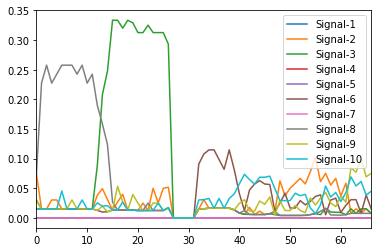

Topics Terms for amysav83


Topic Number                    Topic Terms                    
0         1                    gettin, tired, work, mind, neva, hav
1         2       good, omg, eat, looked, evening, taught, ot, d...
2         3       hearing, wide, gym, wk, fingers, bed, go_to_be...
3         4                                        head, sooo, yeah
4         5       hoping, house, pic, funny, wee, mate, woke, no...
5         6                                        ya, shame, betta
6         7       code, workin, wot, doin, coz, sunny, rain, msn...
7         8       fixed, moment, started, tweetdeck, angry, hey,...
8         9                           aww, night, dead, aawww, hurt
9        10                           hows, pick, goto, rest, pills
10       11       wearing, pull, niiice, eh, scared, pouring, bi...
11       12                            ghost, aaarrgh, weather, wrk
12       13                                                     lol
13       14       quack, edinburgh, play, england, haha, bowl, a...
14       15       week, nxt, missin, anythin, oohh, shorts, nurs...
15       17                                                     num
16       18       ohh, fair, wil, ages, pts, shit, service, fri,...
17       19                                     dont, nite, morning
18       20                wrkin, yeeey, tweet, waaa, leave, laters
19       21                                              wrong, day
20       22       regret, weight, feel, move, thur, tonight, rea...
21       23       cute, claim, hungry, cut, allo, thunder, think...
22       24                           aaww, appreciating, fine, bmw
23       25       resprayed, crap, car, brand, time, upset, ur, ...

Seeded Terms Per Topic for amysav83


Topic Number              Seed Terms:Count            
0    signal_9                            dead:11, hurt:1
1    signal_8                                   angry:14
2    signal_3   awake:14, need_to_sleep:14, go_to_bed:14
3    signal_2                            disappointed:14
4    signal_6                                   shame:14
5   signal_10                                   pills:14

Topics Probabilties Over Time for maynaseric


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   06/04/2009 - 19/04/2009     0.0       0.0       0.0       0.0       0.0     
1   07/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
2   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
3   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
4   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
5   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
6   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
7   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
8   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
9   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
10  18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
11  18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
12  18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
13  19/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
14  20/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
15  21/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
16  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
22  10/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
23  10/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
24  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
25  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
26  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
27  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
28  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
29  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
30  17/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
31  17/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
32  17/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
33  17/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
34  17/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
35  17/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
36  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
37  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
38  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
39  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
40  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
41  22/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
42  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
43  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
44  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0     
3      0.0       0.0       0.0       0.0       0.0     
4 

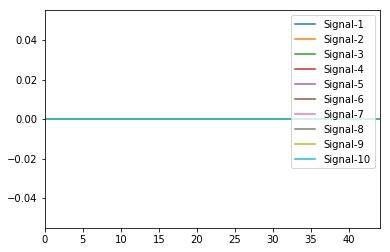

Topics Terms for maynaseric


Topic Number                    Topic Terms                    
0         1                                         btw, dm, loving
1         2       insight, themes, recode, organizing, blog, lay...
2         3       bio, coffee, brawn, mails, taste, brains, milk...
3         4       great, tv, fav, site, hours, np, excellent, tw...
4         5       enjoy, website, fonts, header, thesis, gosh, e...
5         6       insane, concept, deal, rockstar, dino, met, mi...
6         7                 simon, clip, movie, num, college, stuff
7         8                                       sharing, recovery
8         9                                                     lol
9        10       detailed, features, crowd, broz, hving, powerf...
10       11       heater, drmani, energy, weather, respect, awhi...
11       12       heart, outstanding, awesome, fellow, ready, fi...
12       13       love, sianz, interesting, twitter, fb, lah, fr...
13       14                                  llz, seeya, opps, fred
14       15       closes, eyes, busy, eating, log, business, dec...
15       16       cute, is_overworked, vitamins, played, winks, ...
16       17       pamper, wah, bo, haha, send, hmm, pretty, news...
17       18       case, scary, kena, led, personal, top, profit,...
18       19       teleport, feel, tweet, tomorrow, bad, facebook...
19       20       woothemes, photo, abit, recommends, favs, writ...
20       21                 lotsa, utd, hurray, happy, husband, man
21       22       slower, swamped, character, comments, thing, i...
22       23       idea, account, oil, magic, invite, missing, gu...
23       24       , operations, chd, takes, people, liaoz, repre...
24       25       yupz, nadal, win, coming, putfeed, books, logo...

Seeded Terms Per Topic for maynaseric


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for paul_steele


Time Period         Signal-1  Signal-2  Signal-3  Signal-4   \
0   06/04/2009 - 19/04/2009     0.0       0.0       0.0    0.0151515   
1   07/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0156250   
2   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
3   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
4   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
5   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
6   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
7   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
8   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
9   18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
10  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
11  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
12  18/04/2009 - 20/04/2009     0.0       0.0       0.0    0.0222222   
13  19/04/2009 - 02/05/2009     0.0       0.0       0.0    0.0000000   
14  20/04/2009 - 03/05/2009     0.0       0.0       0.0    0.0000000   
15  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.1153846   
16  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0576923   
17  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0576923   
18  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.0961538   
19  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.1153846   
20  02/05/2009 - 04/05/2009     0.0       0.0       0.0    0.1153846   
21  02/05/2009 - 10/05/2009     0.0       0.0       0.0    0.0909091   
22  02/05/2009 - 11/05/2009     0.0       0.0       0.0    0.0555556   
23  02/05/2009 - 11/05/2009     0.0       0.0       0.0    0.0833333   
24  02/05/2009 - 11/05/2009     0.0       0.0       0.0    0.0555556   
25  02/05/2009 - 11/05/2009     0.0       0.0       0.0    0.0555556   
26  02/05/2009 - 11/05/2009     0.0       0.0       0.0    0.0555556   
27  03/05/2009 - 16/05/2009     0.0       0.0       0.0    0.0384615   
28  04/05/2009 - 17/05/2009     0.0       0.0       0.0    0.0131579   
29  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0063291   
30  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0063291   
31  10/05/2009 - 18/05/2009     0.0       0.0       0.0    0.0063291   
32  10/05/2009 - 21/05/2009     0.0       0.0       0.0    0.0061350   
33  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0054348   
34  10/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0054348   
35  11/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0058824   
36  16/05/2009 - 22/05/2009     0.0       0.0       0.0    0.0060976   
37  16/05/2009 - 26/05/2009     0.0       0.0       0.0    0.0050000   
38  16/05/2009 - 26/05/2009     0.0       0.0       0.0    0.0050000   
39  16/05/2009 - 28/05/2009     0.0       0.0       0.0    0.0095694   
40  16/05/2009 - 29/05/2009     0.0       0.0       0.0    0.0149813   
41  17/05/2009 - 30/05/2009     0.0       0.0       0.0    0.0170455   
42  18/05/2009 - 31/05/2009     0.0       0.0       0.0    0.0223464   
43  21/05/2009 - 01/06/2009     0.0       0.0       0.0    0.0358306   
44  21/05/2009 - 02/06/2009     0.0       0.0       0.0    0.0322581   
45  21/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0404040   
46  22/05/2009 - 03/06/2009     0.0       0.0       0.0    0.0306905   
47  26/05/2009 - 05/06/2009     0.0       0.0       0.0    0.0367454   
48  26/05/2009 - 06/06/2009     0.0       0.0       0.0    0.0380711   
49  26/05/2009 - 07/06/2009     0.0       0.0       0.0    0.0371287   

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0       0.0    0.0151515     0.0     
1      0.0       0.0       0.0       0.0    0.0156250     0.0     
2      0.0       0.0       0.0       0.0    0.0222222     0.0     
3      0.0       0.0       0.0       0.0    0.0222222     0.0     
4

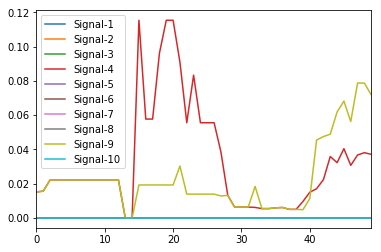

Topics Terms for paul_steele


Topic Number                    Topic Terms                    
0         1                                                     gym
1         2       week, goss, dont, metro, rest, forward, jan, h...
2         3       laters, highest, howdy, support, peeps, leukae...
3         4                     cheers, lovely, work, tired, summer
4         5       sharing, ad, listened, blips, wow, cry, wakey,...
5         6       mood, sweet, workout, charles, sums, chocolate...
6         7       brave, people, muffin, pic, bright, hedge, siz...
7         8                   aha, letters, tidy, lol, lovin, heard
8         9       sound, pike, head, cut, yorks, aug, sending, f...
9        10       album, smiles, prolific, humour, mobile, year,...
10       11       enjoy, shop, love, fresher, t_want_to_do, juli...
11       12       mountain, hiking, wary, pattern, boots, mornin...
12       13                                               beat, nan
13       14       hits, vid, cried, harrowing, beware, watch, ye...
14       15       info, badly, land, art, links, classic, downs,...
15       16                                            great, usual
16       17       beerwalk, dance, kisses, tzaziki, tzatziki, pr...
17       18       eh, wardrobes, middle, peaks, hills, lots, dre...
18       19       moved, ouuta, walk, jump, weather, manchester,...
19       20       int, sooo, mixed, gd, brits, gosh, graft, sarf...
20       21       write, life, busy, set, thread, started, night...
21       22                                folks, aconcagua, mo, ha
22       23       shine, hide, cooler, haha, dome, wwwakey, pigs...
23       24       city, golly, variety, windows, house, times, y...
24       25       raised, mhhh, saturdays, spring, peaceful, tho...

Seeded Terms Per Topic for paul_steele


Topic Number Seed Terms:Count
0   signal_9         cut:10    
1   signal_4        tired:7

Topics Probabilties Over Time for luckygnahhh


Time Period         Signal-1   Signal-2   Signal-3  Signal-4  \
0   18/04/2009 - 18/04/2009  0.0000000  0.0000000     0.0       0.0     
1   02/05/2009 - 02/05/2009  0.0000000  0.0000000     0.0       0.0     
2   02/05/2009 - 03/05/2009  0.2300000  0.0100000     0.0       0.0     
3   02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
4   02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
5   02/05/2009 - 04/05/2009  0.2475248  0.0099010     0.0       0.0     
6   02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
7   02/05/2009 - 04/05/2009  0.2475248  0.0099010     0.0       0.0     
8   02/05/2009 - 04/05/2009  0.2574257  0.0099010     0.0       0.0     
9   02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
10  02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
11  02/05/2009 - 04/05/2009  0.2475248  0.0099010     0.0       0.0     
12  02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
13  02/05/2009 - 04/05/2009  0.2376238  0.0099010     0.0       0.0     
14  02/05/2009 - 04/05/2009  0.2475248  0.0099010     0.0       0.0     
15  03/05/2009 - 04/05/2009  0.2750000  0.0125000     0.0       0.0     
16  04/05/2009 - 04/05/2009  0.0000000  0.0000000     0.0       0.0     
17  22/05/2009 - 22/05/2009  0.0000000  0.0000000     0.0       0.0     
18  22/05/2009 - 22/05/2009  0.0000000  0.0000000     0.0       0.0     
19  22/05/2009 - 22/05/2009  0.0000000  0.0000000     0.0       0.0     
20  22/05/2009 - 22/05/2009  0.0000000  0.0000000     0.0       0.0     
21  22/05/2009 - 26/05/2009  0.0153846  0.0153846     0.0       0.0     
22  22/05/2009 - 26/05/2009  0.0153846  0.0153846     0.0       0.0     
23  22/05/2009 - 28/05/2009  0.0129870  0.0129870     0.0       0.0     
24  22/05/2009 - 29/05/2009  0.0075758  0.0075758     0.0       0.0     
..                      ...        ...        ...       ...       ...   
27  22/05/2009 - 31/05/2009  0.0037037  0.0037037     0.0       0.0     
28  22/05/2009 - 31/05/2009  0.0037037  0.0037037     0.0       0.0     
29  22/05/2009 - 31/05/2009  0.0037037  0.0037037     0.0       0.0     
30  22/05/2009 - 31/05/2009  0.0037037  0.0037037     0.0       0.0     
31  26/05/2009 - 05/06/2009  0.0037313  0.0037313     0.0       0.0     
32  26/05/2009 - 05/06/2009  0.0037313  0.0037313     0.0       0.0     
33  26/05/2009 - 07/06/2009  0.0036364  0.0036364     0.0       0.0     
34  26/05/2009 - 07/06/2009  0.0036364  0.0072727     0.0       0.0     
35  28/05/2009 - 07/06/2009  0.0040486  0.0040486     0.0       0.0     
36  28/05/2009 - 07/06/2009  0.0040486  0.0040486     0.0       0.0     
37  29/05/2009 - 07/06/2009  0.0042553  0.0042553     0.0       0.0     
38  30/05/2009 - 07/06/2009  0.0055556  0.0111111     0.0       0.0     
39  31/05/2009 - 07/06/2009  0.0100000  0.0100000     0.0       0.0     
40  05/06/2009 - 14/06/2009  0.0000000  0.0000000     0.0       0.0     
41  05/06/2009 - 15/06/2009  0.0104167  0.1770833     0.0       0.0     
42  05/06/2009 - 16/06/2009  0.0241935  0.1532258     0.0       0.0     
43  05/06/2009 - 17/06/2009  0.0064516  0.1548387     0.0       0.0     
44  05/06/2009 - 18/06/2009  0.0064103  0.1538462     0.0       0.0     
45  07/06/2009 - 19/06/2009  0.0043860  0.1184211     0.0       0.0     
46  07/06/2009 - 20/06/2009  0.0042017  0.1134454     0.0       0.0     
47  14/06/2009 - 21/06/2009  0.0082305  0.1111111     0.0       0.0     
48  14/06/2009 - 22/06/2009  0.0079051  0.1185771     0.0       0.0     
49  14/06/2009 - 23/06/2009  0.0038168  0.1183206     0.0       0.0     
50  14/06/2009 - 23/06/2009  0.0038168  0.1145038     0.0       0.0     
51  14/06/2009 - 25/06/2009  0.0037594  0.1127820     0.0       0.0     

    Signal-5  Signal-6   Signal-7   Signal-8   Signal-9   Signal-10  
0      0.0    0.0000000  0.0000000  0.0000000  0.0000000     0.0     
1      0.0    0.0000000  0.0000000  0.0000000  0.0000000     0.0     
2 

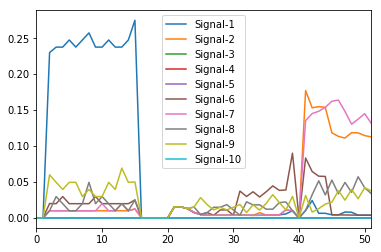

Topics Terms for luckygnahhh


Topic Number                    Topic Terms                    
0         1       befriend, parade, fair, general, talking, fail...
1         2       bawling, broke, cried, fucking, sleep, year, s...
2         3       sweetdaddy, honey, transformers, thinking, fee...
3         4       swim, nooo, love, ramble, lame, mind, hurts, e...
4         5       blind, apple, sweet, sad, gallbladder, nbc, co...
5         6       wands, notice, lol, tonight, video, doubt, wor...
6         7       house, paparazzi, jesus, wrecks, forums, brb, ...
7         8                              angry, damn, voted, issues
8         9                          hell, cursebird, hope, bb, die
9        10       pepper, system, scared, seconds, belle, laptop...
10       11       heart, random, theraflu, wwc, pass, ready, hap...
11       12                         thing, bad, assholes, xd, times
12       13       duh, ass, ugh, people, aww, bed, tomorrow, msn...
13       14       search, nights, willl, chatting, beachhh, room...
14       15       storys, leave, handle, covering, t_sleep, beac...
15       16       depress, good, persay, bother, weekends, ohhh,...
16       17       poor, remember, watching, haha, nanny, kendra,...
17       18                                          num, omg, epic
18       19       scratch, sign, computer, bitch, skype, letting...
19       20                                               win, guiz
20       21       colleges, thankfully, littlemissgnahhh, unfoll...
21       22       lie, fialll, cry, rare, flu, gina, favorite, v...
22       23       head, scare, dies, horror, sooo, hurt, rape, s...
23       24       spelling, picture, fails, srry, tourist, fuq, ...
24       25                                          thought, dying

Seeded Terms Per Topic for luckygnahhh


Topic Number  Seed Terms:Count 
0   signal_9       hell:35, die:7
1   signal_8              angry:5
2   signal_1           boredom:14
3   signal_2           breaking:7
4   signal_7    keep_forgetting:7
5   signal_6             worst:14

Topics Probabilties Over Time for thisgoeshere


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   17/04/2009 - 20/04/2009  0.0100000     0.0       0.0       0.0     
1   18/04/2009 - 20/04/2009  0.0112360     0.0       0.0       0.0     
2   19/04/2009 - 02/05/2009  0.0103093     0.0       0.0       0.0     
3   20/04/2009 - 03/05/2009  0.0128205     0.0       0.0       0.0     
4   02/05/2009 - 03/05/2009  0.0166667     0.0       0.0       0.0     
5   02/05/2009 - 03/05/2009  0.0166667     0.0       0.0       0.0     
6   02/05/2009 - 03/05/2009  0.0166667     0.0       0.0       0.0     
7   02/05/2009 - 03/05/2009  0.0166667     0.0       0.0       0.0     
8   02/05/2009 - 03/05/2009  0.0166667     0.0       0.0       0.0     
9   02/05/2009 - 09/05/2009  0.0161290     0.0       0.0       0.0     
10  02/05/2009 - 10/05/2009  0.0153846     0.0       0.0       0.0     
11  02/05/2009 - 10/05/2009  0.0153846     0.0       0.0       0.0     
12  02/05/2009 - 10/05/2009  0.0153846     0.0       0.0       0.0     
13  02/05/2009 - 10/05/2009  0.0153846     0.0       0.0       0.0     
14  02/05/2009 - 10/05/2009  0.0153846     0.0       0.0       0.0     
15  02/05/2009 - 10/05/2009  0.0153846     0.0       0.0       0.0     
16  03/05/2009 - 16/05/2009  0.0000000     0.0       0.0       0.0     
17  09/05/2009 - 17/05/2009  0.0175439     0.0       0.0       0.0     
18  09/05/2009 - 17/05/2009  0.0175439     0.0       0.0       0.0     
19  09/05/2009 - 17/05/2009  0.0175439     0.0       0.0       0.0     
20  09/05/2009 - 17/05/2009  0.0175439     0.0       0.0       0.0     
21  09/05/2009 - 17/05/2009  0.0175439     0.0       0.0       0.0     
22  09/05/2009 - 22/05/2009  0.0129870     0.0       0.0       0.0     
23  10/05/2009 - 22/05/2009  0.0133333     0.0       0.0       0.0     
24  16/05/2009 - 22/05/2009  0.0138889     0.0       0.0       0.0     
25  16/05/2009 - 22/05/2009  0.0138889     0.0       0.0       0.0     
26  16/05/2009 - 22/05/2009  0.0138889     0.0       0.0       0.0     
27  16/05/2009 - 22/05/2009  0.0138889     0.0       0.0       0.0     
28  16/05/2009 - 22/05/2009  0.0138889     0.0       0.0       0.0     
29  16/05/2009 - 29/05/2009  0.0120482     0.0       0.0       0.0     
30  17/05/2009 - 30/05/2009  0.0121951     0.0       0.0       0.0     
31  22/05/2009 - 31/05/2009  0.0107066     0.0       0.0       0.0     
32  22/05/2009 - 01/06/2009  0.0080160     0.0       0.0       0.0     
33  22/05/2009 - 02/06/2009  0.0116473     0.0       0.0       0.0     
34  22/05/2009 - 03/06/2009  0.0106870     0.0       0.0       0.0     
35  22/05/2009 - 04/06/2009  0.0105740     0.0       0.0       0.0     
36  29/05/2009 - 05/06/2009  0.0530726     0.0       0.0       0.0     
37  29/05/2009 - 06/06/2009  0.0680437     0.0       0.0       0.0     
38  29/05/2009 - 07/06/2009  0.0715835     0.0       0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0100000     0.0       0.0    0.0600000     0.0     
1      0.0    0.0112360     0.0       0.0    0.0561798     0.0     
2      0.0    0.0103093     0.0       0.0    0.0309278     0.0     
3      0.0    0.0128205     0.0       0.0    0.0256410     0.0     
4      0.0    0.0166667     0.0       0.0    0.0166667     0.0     
5      0.0    0.0166667     0.0       0.0    0.0166667     0.0     
6      0.0    0.0166667     0.0       0.0    0.0166667     0.0     
7      0.0    0.0166667     0.0       0.0    0.0166667     0.0     
8      0.0    0.0166667     0.0       0.0    0.0166667     0.0     
9      0.0    0.0161290     0.0       0.0    0.0161290     0.0     
10     0.0    0.0153846     0.0       0.0    0.0153846     0.0     
11     0.0    0.0153846     0.0       0.0    0.0153846     0.0     
12     0.0    0.0153846     0.0       0.0    0.0153846     0.0     
13     0.0    0.0153846     0.0       0.0    0.0153846     0.0     
14     0.0    0.0153846     0.0       0.0    0.0153846     0.0     
15     0.0    0.0153846     0.0       0.

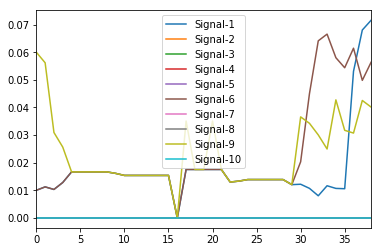

Topics Terms for thisgoeshere


Topic Number                    Topic Terms                    
0         1       naughty, wentz, house, tonight, hating, enjoye...
1         2       beautiful, ass, feel, waggles, crushing, sex, ...
2         3       google, slam, likes, ready, chicken, contests,...
3         4       insane, neverwhere, superimposing, battery, so...
4         5       term, rooftop, working, nut, yesterday, t_care...
5         6       ugh, stump, streets, flavorful, ferrell, dream...
6         7       bell, mind, al, hair, cure, fans, morbid, pret...
7         8       funny, spongebob, themed, idiot, docks, ride, ...
8         9       cute, kind, neil, driving, gay, burger, read, ...
9        10       tired, stealing, pstump, immensely, tendency, ...
10       11       love, pardon, idea, accept, relation, omens, f...
11       12       whoops, pic, sleep, odd, curled, hehe, spendin...
12       13       appeals, concert, beef, prettiest, work, watch...
13       14       illness, angel, clarified, scene, fantasy, hit...
14       15       tmw, sweet, tweet, haha, bed, bring, shirts, n...
15       16       gangly, join, wears, sucky, big, hurley, hey, ...
16       17       lots, erin, start, mothersday, shamed, dreams,...
17       18       summer, giggles, humorous, sad, fail, turkey, ...
18       19       boyfriend, tone, twitter, timbaland, names, cl...
19       20       poor, bfast, television, crosses, central, ban...
20       21       sinking, psyched, oreos, firefox, gummie, lang...
21       22       yay, coming, sucks, days, alive, burymestandin...
22       23       neighborhood, rah, condoning, drooling, tomorr...
23       24       , heart, reminded, smoke, hush, talking, worke...
24       25       expletive, invisible, farther, forgot, fellas,...

Seeded Terms Per Topic for thisgoeshere


Topic Number     Seed Terms:Count   
0   signal_9    hell:2, kill:6, die:12
1   signal_1                   bored:2
2   signal_5                  gangly:1
3   signal_6                   hated:2

Topics Probabilties Over Time for ladybug8320


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   04/05/2009 - 17/05/2009  0.0000000     0.0       0.0    0.0000000   
1   17/05/2009 - 18/05/2009  0.0131579     0.0       0.0    0.0263158   
2   17/05/2009 - 18/05/2009  0.0263158     0.0       0.0    0.0131579   
3   17/05/2009 - 18/05/2009  0.0131579     0.0       0.0    0.0394737   
4   17/05/2009 - 18/05/2009  0.0131579     0.0       0.0    0.0263158   
5   17/05/2009 - 22/05/2009  0.0629371     0.0       0.0    0.0069930   
6   17/05/2009 - 22/05/2009  0.0629371     0.0       0.0    0.0069930   
7   17/05/2009 - 22/05/2009  0.0629371     0.0       0.0    0.0069930   
8   17/05/2009 - 22/05/2009  0.0629371     0.0       0.0    0.0139860   
9   17/05/2009 - 22/05/2009  0.0629371     0.0       0.0    0.0139860   
10  17/05/2009 - 22/05/2009  0.0629371     0.0       0.0    0.0069930   
11  17/05/2009 - 22/05/2009  0.0419580     0.0       0.0    0.0139860   
12  17/05/2009 - 29/05/2009  0.0706522     0.0       0.0    0.0271739   
13  17/05/2009 - 30/05/2009  0.0728155     0.0       0.0    0.0291262   
14  18/05/2009 - 31/05/2009  0.0585938     0.0       0.0    0.0507812   
15  22/05/2009 - 01/06/2009  0.0865052     0.0       0.0    0.0449827   
16  22/05/2009 - 02/06/2009  0.0549133     0.0       0.0    0.0549133   
17  22/05/2009 - 03/06/2009  0.0614973     0.0       0.0    0.0427807   
18  22/05/2009 - 04/06/2009  0.0577428     0.0       0.0    0.0603675   
19  29/05/2009 - 05/06/2009  0.0325444     0.0       0.0    0.0562130   
20  29/05/2009 - 06/06/2009  0.0348837     0.0       0.0    0.0697674   
21  29/05/2009 - 07/06/2009  0.0253807     0.0       0.0    0.0482234   
22  29/05/2009 - 07/06/2009  0.0304569     0.0       0.0    0.0456853   
23  29/05/2009 - 07/06/2009  0.0329949     0.0       0.0    0.0380711   
24  29/05/2009 - 07/06/2009  0.0304569     0.0       0.0    0.0482234   
25  29/05/2009 - 07/06/2009  0.0304569     0.0       0.0    0.0583756   
26  30/05/2009 - 07/06/2009  0.0396601     0.0       0.0    0.0538244   
27  31/05/2009 - 07/06/2009  0.0271903     0.0       0.0    0.0422961   
28  01/06/2009 - 07/06/2009  0.0261194     0.0       0.0    0.0186567   
29  02/06/2009 - 07/06/2009  0.0101523     0.0       0.0    0.0304569   
30  03/06/2009 - 16/06/2009  0.0126582     0.0       0.0    0.0126582   
31  04/06/2009 - 17/06/2009  0.0071942     0.0       0.0    0.0071942   
32  05/06/2009 - 17/06/2009  0.0075758     0.0       0.0    0.0075758   
33  06/06/2009 - 19/06/2009  0.0069930     0.0       0.0    0.0139860   
34  07/06/2009 - 20/06/2009  0.0060976     0.0       0.0    0.0121951   
35  16/06/2009 - 21/06/2009  0.0082645     0.0       0.0    0.0082645   
36  16/06/2009 - 21/06/2009  0.0082645     0.0       0.0    0.0082645   
37  16/06/2009 - 21/06/2009  0.0082645     0.0       0.0    0.0165289   
38  16/06/2009 - 21/06/2009  0.0082645     0.0       0.0    0.0082645   
39  16/06/2009 - 25/06/2009  0.0064103     0.0       0.0    0.0128205   

    Signal-5   Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0   0.0000000     0.0       0.0       0.0    0.0000000     0.0     
1   0.0263158     0.0       0.0       0.0    0.0131579     0.0     
2   0.0131579     0.0       0.0       0.0    0.0263158     0.0     
3   0.0394737     0.0       0.0       0.0    0.0131579     0.0     
4   0.0131579     0.0       0.0       0.0    0.0263158     0.0     
5   0.0139860     0.0       0.0       0.0    0.0419580     0.0     
6   0.0349650     0.0       0.0       0.0    0.0209790     0.0     
7   0.0069930     0.0       0.0       0.0    0.0559441     0.0     
8   0.0069930     0.0       0.0       0.0    0.0489510     0.0     
9   0.0069930     0.0       0.0       0.0    0.0489510     0.0     
10  0.0139860     0.0       0.0       0.0    0.0489510     0.0     
11  0.0069930     0.0       0.0       0.0    0.0559441     0.0     
12  0.0163043     0.0       0.0       0.0    0.0108696     0.0     
13  0.0194175     0.0       0.0       0.0    0.0339806     0.0 

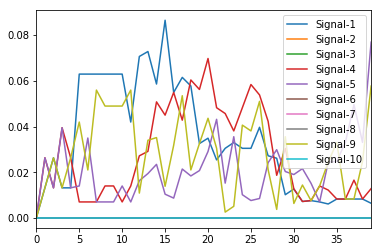

Topics Terms for ladybug8320


Topic Number                    Topic Terms                    
0         1       great, love, boring, lucky, squirrels, moment,...
1         2       load, major, fronts, lemon, turn, laughter, as...
2         3       enjoy, pity, congrats, mind, cheers, stand, bi...
3         4       poor, lazy, style, rule, staying, wiggling, wo...
4         5       wallpaper, weight_loss, morning, num, afternoo...
5         6       heart, hoping, fair, beware, jess, sea, trip, ...
6         7       repair, play, shooting, hunting, sizes, things...
7         8       sis, hardship, friday, choice, water, oasis, d...
8         9                                                    hell
9        10       based, crowd, contacts, food, household, norma...
10       11       katie, outs, tv, joys, tennis, knuckle, pea, s...
11       12       beautiful, drunk, moments, lack, vary, years, ...
12       13       catch, evening, call, attacks, felt, upset, bu...
13       14       picker, honest, check, devil, hospital, mum, l...
14       15       stripped, weather, ready, total, bubbly, stora...
15       16       buy, space, lots, move, birthday, manchester, ...
16       17       sarah, task, develop, longer, district, lil, h...
17       18       trick, win, signal, yesterday, sports, honey, ...
18       19                                         good, day, send
19       20       canal, adding, concert, relaxing, nicely, gav,...
20       21       playtimes, twitter, walk, wardrobe, promise, e...
21       22       photoshop, rays, join, big, ditch, sun, told, ...
22       23       life, kids, couple, start, respite, forward, t...
23       24                   follow, link, rare, commodity, people
24       25       prospect, share, fancy, bloody, planning, impe...

Seeded Terms Per Topic for ladybug8320


Topic Number Seed Terms:Count
0   signal_1         boring:14 
1   signal_9            hell:3 
2   signal_5    weight_loss:19 
3   signal_4           lazy:14

Topics Probabilties Over Time for jennypoynter


Time Period         Signal-1   Signal-2  Signal-3  Signal-4  \
0   14/05/2009 - 22/05/2009  0.0070922     0.0       0.0       0.0     
1   17/05/2009 - 22/05/2009  0.0074074     0.0       0.0       0.0     
2   17/05/2009 - 29/05/2009  0.0105263     0.0       0.0       0.0     
3   17/05/2009 - 30/05/2009  0.0245399     0.0       0.0       0.0     
4   18/05/2009 - 31/05/2009  0.0364238     0.0       0.0       0.0     
5   22/05/2009 - 01/06/2009  0.0436364     0.0       0.0       0.0     
6   22/05/2009 - 02/06/2009  0.0498442     0.0       0.0       0.0     
7   22/05/2009 - 03/06/2009  0.0457143     0.0       0.0       0.0     
8   22/05/2009 - 04/06/2009  0.0393258     0.0       0.0       0.0     
9   29/05/2009 - 05/06/2009  0.0334262     0.0       0.0       0.0     
10  29/05/2009 - 06/06/2009  0.0476190     0.0       0.0       0.0     
11  29/05/2009 - 07/06/2009  0.0482180     0.0       0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0    0.0070922     0.0    0.0070922  0.1702128     0.0     
1      0.0    0.0148148     0.0    0.0148148  0.1777778     0.0     
2      0.0    0.0105263     0.0    0.0157895  0.1263158     0.0     
3      0.0    0.0306748     0.0    0.0429448  0.0858896     0.0     
4      0.0    0.0331126     0.0    0.0463576  0.0596026     0.0     
5      0.0    0.0509091     0.0    0.0618182  0.0036364     0.0     
6      0.0    0.0404984     0.0    0.0467290  0.0093458     0.0     
7      0.0    0.0542857     0.0    0.0428571  0.0057143     0.0     
8      0.0    0.0477528     0.0    0.0477528  0.0084270     0.0     
9      0.0    0.0445682     0.0    0.0473538  0.0055710     0.0     
10     0.0    0.0350877     0.0    0.0426065  0.0050125     0.0     
11     0.0    0.0356394     0.0    0.0377358  0.0041929     0.0

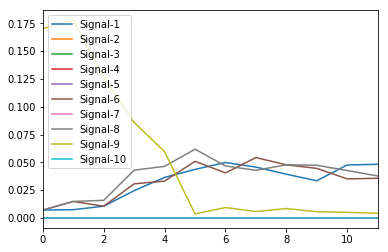

Topics Terms for jennypoynter


Topic Number                    Topic Terms                    
0         1       head, grease, people, straight, sucks, meh, ry...
1         2       pull, admin, mcfly, dude, days, thursday, pers...
2         3       edward, england, teddy, awesome, yn, jennifer,...
3         4       swim, photo, bastard, door, liiive, btw, mwaha...
4         5       tickets, scared, cinema, hannah, movie, fri, m...
5         6       matt, liverpool, cope, minutes, nawww, ted, ms...
6         7       bill, played, drunk, sold, year, looked, lizar...
7         8       taller, simon, frankie, nervous, lmfaooo, chan...
8         9       akward, cute, flavour, wee, funny, tweetdeck, ...
9        10       bb, cry, hilarious, private, stuff, bed, hurts...
10       11       earl, amber, suffragettes, park, upset, wrong,...
11       12       night, aha, ohh, tbh, czech, god, da, xxx, goo...
12       13       wheelchair, good, garden, jurassic, amberlovel...
13       14       week, summer, num, gmtv, curly, magine, tooo, ...
14       15       mini, play, plays, kerry, working, bishy, plec...
15       16       school, balls, yay, exam, big, tuesday, fake, ...
16       17       forever, toy, dont, lmfao, grinch, proper, blo...
17       18       missed, ruin, changed, kill, booo, biggest, ha...
18       19       insane, crying, convincing, hardy, read, phone...
19       20       story, hug, crap, remember, bebo, toys, fav, g...
20       21       essay, ive, tonight, historyyy, crowd, niiight...
21       22       yeaahh, videos, thunderpants, yeah, alive, dru...
22       23       spell, feel, premiere, months, scotland, gigs,...
23       24       huge, watching, food, house, willis, atm, nan,...
24       25       walking, sats, teasiiing, fair, jeff, company,...

Seeded Terms Per Topic for jennypoynter


Topic Number     Seed Terms:Count   
0   signal_9                    hurt:5
1   signal_8    nervous:8, annoying:18
2   signal_1                     meh:7
3   signal_6                   shame:9

Topics Probabilties Over Time for kat_n


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  \
0   03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0     
1   14/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0     
2   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
3   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
4   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
5   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
6   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
7   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
8   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
9   14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
10  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
11  14/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
12  16/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0     
13  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0     
14  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0     
15  18/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0     
16  29/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0     
17  29/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0     
18  29/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0     
19  29/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0     
20  29/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0     
21  29/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0     
22  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
23  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
24  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
25  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
26  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
27  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
28  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
29  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0     
30  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0     
31  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0     
32  04/06/2009 - 17/06/2009     0.0       0.0       0.0       0.0     
33  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0     
34  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0     
35  07/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0     
36  15/06/2009 - 21/06/2009     0.0       0.0       0.0       0.0     
37  15/06/2009 - 22/06/2009     0.0       0.0       0.0       0.0     
38  15/06/2009 - 22/06/2009     0.0       0.0       0.0       0.0     
39  15/06/2009 - 22/06/2009     0.0       0.0       0.0       0.0     
40  15/06/2009 - 25/06/2009     0.0       0.0       0.0       0.0     

    Signal-5   Signal-6   Signal-7  Signal-8   Signal-9  Signal-10  
0   0.0000000  0.0000000     0.0    0.0000000     0.0    0.0000000  
1   0.0430108  0.0107527     0.0    0.0215054     0.0    0.0107527  
2   0.0196078  0.0098039     0.0    0.0098039     0.0    0.0098039  
3   0.0294118  0.0098039     0.0    0.0294118     0.0    0.0098039  
4   0.0588235  0.0196078     0.0    0.0196078     0.0    0.0098039  
5   0.0196078  0.0098039     0.0    0.0098039     0.0    0.0098039  
6   0.0490196  0.0098039     0.0    0.0098039     0.0    0.0196078  
7   0.0588235  0.0098039     0.0    0.0196078     0.0    0.0098039  
8   0.0294118  0.0098039     0.0    0.0098039     0.0    0.0098039  
9   0.0588235  0.0098039     0.0    0.0098039     0.0    0.0098039  
10  0.0784314  0.0098039     0.0    0.0098039     0.0    0.0098039  
11  0.0392157  0.0098039     0.0    0.0294118     0.0    0.0196078  
12  0.0843373  0.0120482     0.0    0.0361446     0.0    0.0240964  
13  0.0277778  0.0092593     0.0    0.0370370     0.0    0.0

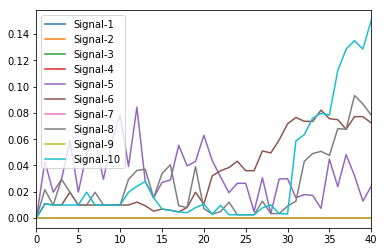

Topics Terms for kat_n


Topic Number                    Topic Terms                    
0         1       ding, mymums, gona, changin, sounds, cheating,...
1         2       tongues, youl, specially, drunk, replies, popn...
2         3               aww, cme, hangovers, slowly, follow, nice
3         4       hows, sneezin, dont, bn, brand, xxx, haha, day...
4         5                                         yeh, tweet, fat
5         6       knackerd, wana, sad, forget, bb, twitter, felt...
6         7       busy, ike, people, pay, mo, ages, ice, nosey, ...
7         8       ass, speakn, yehhh, windy, water, awww, num, r...
8         9        week, loved, tv, hun, frm, brought, stuck, whens
9        10       eh, neglecting, pills, worse, letting, getn, s...
10       11                                       xx, earlier, good
11       12       shrug, wossy, wat, start, wall, docs, forgot, ...
12       13       lookd, played, turned, munchkin, follower, enj...
13       14                    lol, surely, night, chick, bit, hope
14       15       brandians, chasing, wee, ya, win, knew, soo, f...
15       16       hair, mcfly, calling, involve, dong, time, avo...
16       17       yeeh, school, easy, asap, feel, kind, thos, le...
17       18       great, symptons, lost, luckily, bite, brother,...
18       19       theyr, drinkn, thankfully, sweet, wil, tax, dr...
19       20       point, tixs, hit, missed, miightv, club, skint...
20       21       edinburgh, jake, wht, tweetn, boys, grandparen...
21       22                iam, adds, tooo, workd, half, works, sat
22       23       vodka, sign, twin, watched, girl, pete, wkend,...
23       24       poor, jelous, sozzzyyy, crap, yep, shiped, sun...
24       25       toilet, btr, house, kill, times, shit, watchin...

Seeded Terms Per Topic for kat_n


Topic Number  Seed Terms:Count
0   signal_10   meds:5, pills:20
1    signal_5              fat:4
2    signal_8         annoying:9
3    signal_6            worst:9

Topics Probabilties Over Time for TraceyHewins


Time Period         Signal-1   Signal-2  Signal-3   Signal-4  \
0   07/04/2009 - 20/04/2009  0.0107527     0.0    0.0107527     0.0     
1   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
2   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
3   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
4   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
5   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
6   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
7   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
8   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
9   18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
10  18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
11  18/04/2009 - 20/04/2009  0.0135135     0.0    0.0135135     0.0     
12  19/04/2009 - 02/05/2009  0.0117647     0.0    0.0117647     0.0     
13  20/04/2009 - 03/05/2009  0.0101010     0.0    0.0101010     0.0     
14  02/05/2009 - 04/05/2009  0.0089286     0.0    0.0089286     0.0     
15  02/05/2009 - 04/05/2009  0.0178571     0.0    0.0089286     0.0     
16  02/05/2009 - 04/05/2009  0.0089286     0.0    0.0178571     0.0     
17  02/05/2009 - 04/05/2009  0.0089286     0.0    0.0089286     0.0     
18  02/05/2009 - 04/05/2009  0.0089286     0.0    0.0089286     0.0     
19  02/05/2009 - 09/05/2009  0.0176991     0.0    0.0088496     0.0     
20  02/05/2009 - 10/05/2009  0.0063694     0.0    0.0063694     0.0     
21  02/05/2009 - 10/05/2009  0.0191083     0.0    0.0063694     0.0     
22  02/05/2009 - 10/05/2009  0.0318471     0.0    0.0063694     0.0     
23  02/05/2009 - 10/05/2009  0.0254777     0.0    0.0063694     0.0     
24  02/05/2009 - 14/05/2009  0.0054645     0.0    0.0109290     0.0     
25  02/05/2009 - 14/05/2009  0.0054645     0.0    0.0054645     0.0     
26  03/05/2009 - 14/05/2009  0.0251572     0.0    0.0062893     0.0     
27  04/05/2009 - 14/05/2009  0.0236220     0.0    0.0078740     0.0     
28  09/05/2009 - 18/05/2009  0.0247934     0.0    0.0082645     0.0     
29  09/05/2009 - 18/05/2009  0.0082645     0.0    0.0082645     0.0     
30  09/05/2009 - 18/05/2009  0.0082645     0.0    0.0082645     0.0     
31  09/05/2009 - 18/05/2009  0.0247934     0.0    0.0082645     0.0     
32  09/05/2009 - 22/05/2009  0.0149254     0.0    0.0074627     0.0     
33  10/05/2009 - 22/05/2009  0.0375940     0.0    0.0075188     0.0     
34  14/05/2009 - 22/05/2009  0.0112360     0.0    0.0112360     0.0     
35  14/05/2009 - 22/05/2009  0.0224719     0.0    0.0112360     0.0     
36  14/05/2009 - 22/05/2009  0.0337079     0.0    0.0112360     0.0     
37  14/05/2009 - 22/05/2009  0.0112360     0.0    0.0112360     0.0     
38  18/05/2009 - 22/05/2009  0.0158730     0.0    0.0158730     0.0     
39  18/05/2009 - 29/05/2009  0.0754717     0.0    0.0660377     0.0     
40  18/05/2009 - 30/05/2009  0.0581395     0.0    0.1046512     0.0     
41  18/05/2009 - 31/05/2009  0.1016949     0.0    0.0889831     0.0     
42  22/05/2009 - 01/06/2009  0.1343284     0.0    0.0895522     0.0     
43  22/05/2009 - 02/06/2009  0.1274510     0.0    0.0816993     0.0     
44  22/05/2009 - 03/06/2009  0.1218750     0.0    0.0968750     0.0     
45  22/05/2009 - 04/06/2009  0.1415385     0.0    0.0953846     0.0     
46  29/05/2009 - 05/06/2009  0.1277259     0.0    0.0934579     0.0     
47  29/05/2009 - 06/06/2009  0.1256983     0.0    0.0949721     0.0     
48  29/05/2009 - 07/06/2009  0.1270718     0.0    0.0856354     0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0       0.0    0.0537634  0.0107527  
1      0.0       0.0       0.0       0.0    0.0540541  0.0135135  
2      0.0       0.0       0.0       0.0    0.0540541  0.0135135  
3      0.0       0.0       0.0       0.0    0.0405405  0.0135135  
4      0.0       0.0   

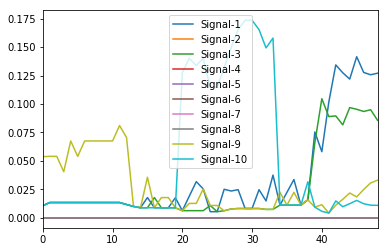

Topics Terms for TraceyHewins


Topic Number                    Topic Terms                    
0         1       meant, days, fever, relaxing, talking, appeare...
1         2                                                 pancake
2         3       crazy, tired, tea, jade, sooo, quiet, edt, cap...
3         4       night, sister, accident, song, friends, role, ...
4         5                         hiya, bye, glad, hope, watching
5         6       naughty, froze, absolutely, snuggle, tom, kitt...
6         7       cute, midnight, weather, crayon, expect, watch...
7         8       cookies, gardening, stranger, deal, things, br...
8         9                      michelle, bit, feeling, dead, good
9        10       working, lots, twitter, sparkly, yeah, meds, h...
10       11       doll, share, girl, tomorrow, funny, tweet, dam...
11       12       weeks, party, busy, omg, service, attend, hon,...
12       13       coffee, wizard, grouse, millionth, great, flir...
13       14       building, floow, bragged, patrol, people, god,...
14       15       dry, grill, set, umbrella, melt, exspecially, ...
15       16       promiised, family, allergy, ready, hanging, vo...
16       17       congratulations, slows, read, pay, gu, frustra...
17       18                                                 morning
18       19       evening, eating, patches, point, chocoalte, ch...
19       20             pic, nan, abdomen, honest, heck, aw, timber
20       21       miserably, secrets, sugar, suddenly, dangerous...
21       22                           chantix, poor, lost, lol, cup
22       23                                              thing, num
23       24       eastern, electricity, dealing, ty, fingers, ni...
24       25                                     , chris, love, time

Seeded Terms Per Topic for TraceyHewins


Topic Number      Seed Terms:Count     
0    signal_9                     dead:13
1    signal_1                    boring:9
2    signal_3   go_back_to_bed:8, awake:8
3   signal_10                      meds:7

Topics Probabilties Over Time for wowlew


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
1  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
2  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
3  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
4  21/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
5  21/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
6  21/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
7  21/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
8  22/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
9  30/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     

   Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0     0.0       0.0       0.0       0.0       0.0     
1     0.0       0.0       0.0       0.0       0.0     
2     0.0       0.0       0.0       0.0       0.0     
3     0.0       0.0       0.0       0.0       0.0     
4     0.0       0.0       0.0       0.0       0.0     
5     0.0       0.0       0.0       0.0       0.0     
6     0.0       0.0       0.0       0.0       0.0     
7     0.0       0.0       0.0       0.0       0.0     
8     0.0       0.0       0.0       0.0       0.0     
9     0.0       0.0       0.0       0.0       0.0

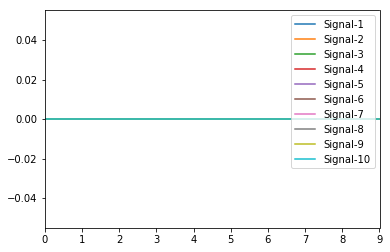

Topics Terms for wowlew


Topic Number     Topic Terms    
0       25                     died
1       19       healing, isvalcore
2       12                 isplayer
3        7                    guild

Seeded Terms Per Topic for wowlew


Empty DataFrame
Columns: [Topic Number, Seed Terms:Count]
Index: []

Topics Probabilties Over Time for StDAY


Time Period         Signal-1   Signal-2   Signal-3   Signal-4   \
0   07/04/2009 - 20/04/2009  0.0526316  0.0131579  0.0263158  0.0394737   
1   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
2   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
3   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
4   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
5   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
6   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
7   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
8   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
9   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
10  18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000  0.0000000   
11  18/04/2009 - 01/05/2009  0.0120482  0.0120482  0.0120482  0.0120482   
12  19/04/2009 - 02/05/2009  0.0104167  0.0104167  0.0104167  0.0104167   
13  20/04/2009 - 03/05/2009  0.0077519  0.0077519  0.0155039  0.0077519   
14  01/05/2009 - 04/05/2009  0.0080000  0.0080000  0.0080000  0.0080000   
15  01/05/2009 - 04/05/2009  0.0080000  0.0080000  0.0080000  0.0080000   
16  01/05/2009 - 04/05/2009  0.0080000  0.0080000  0.0080000  0.0080000   
17  01/05/2009 - 04/05/2009  0.0080000  0.0080000  0.0080000  0.0080000   
18  01/05/2009 - 04/05/2009  0.0160000  0.0080000  0.0080000  0.0080000   
19  01/05/2009 - 09/05/2009  0.0067568  0.0067568  0.0067568  0.0067568   
20  01/05/2009 - 10/05/2009  0.0110497  0.0055249  0.0055249  0.0055249   
21  01/05/2009 - 11/05/2009  0.0105820  0.0052910  0.0052910  0.0052910   
22  01/05/2009 - 11/05/2009  0.0052910  0.0052910  0.0052910  0.0158730   
23  01/05/2009 - 11/05/2009  0.0052910  0.0052910  0.0052910  0.0105820   
24  01/05/2009 - 14/05/2009  0.0096154  0.0048077  0.0048077  0.0048077   
..                      ...        ...        ...        ...        ...   
40  17/05/2009 - 30/05/2009  0.0164835  0.1098901  0.1813187  0.0164835   
41  18/05/2009 - 31/05/2009  0.0233918  0.1111111  0.1871345  0.0058480   
42  22/05/2009 - 01/06/2009  0.0280000  0.0880000  0.1560000  0.0040000   
43  22/05/2009 - 02/06/2009  0.0243902  0.0662021  0.1393728  0.0034843   
44  22/05/2009 - 03/06/2009  0.0406250  0.0718750  0.1156250  0.0062500   
45  22/05/2009 - 03/06/2009  0.0375000  0.0687500  0.1312500  0.0031250   
46  26/05/2009 - 05/06/2009  0.0470914  0.0554017  0.1080332  0.0027701   
47  26/05/2009 - 06/06/2009  0.0466667  0.0422222  0.0822222  0.0244444   
48  26/05/2009 - 07/06/2009  0.0460000  0.0400000  0.0740000  0.0240000   
49  26/05/2009 - 07/06/2009  0.0460000  0.0380000  0.0720000  0.0340000   
50  28/05/2009 - 07/06/2009  0.0460251  0.0062762  0.0774059  0.0397490   
51  28/05/2009 - 07/06/2009  0.0376569  0.0083682  0.0690377  0.0355649   
52  29/05/2009 - 07/06/2009  0.0454545  0.0021645  0.0519481  0.0281385   
53  30/05/2009 - 07/06/2009  0.0526316  0.0022883  0.0297483  0.0343249   
54  31/05/2009 - 07/06/2009  0.0416667  0.0026042  0.0130208  0.0442708   
55  01/06/2009 - 14/06/2009  0.0427807  0.0026738  0.0106952  0.0508021   
56  02/06/2009 - 15/06/2009  0.0635838  0.0028902  0.0028902  0.0578035   
57  03/06/2009 - 16/06/2009  0.0701754  0.0029240  0.0029240  0.0467836   
58  05/06/2009 - 17/06/2009  0.0512129  0.0026954  0.0053908  0.0431267   
59  05/06/2009 - 18/06/2009  0.0564103  0.0051282  0.0051282  0.0256410   
60  06/06/2009 - 19/06/2009  0.0497238  0.0027624  0.0055249  0.0469613   
61  07/06/2009 - 20/06/2009  0.0581395  0.0029070  0.0116279  0.0261628   
62  14/06/2009 - 21/06/2009  0.0650155  0.0030960  0.0123839  0.0185759   
63  14/06/2009 - 22/06/2009  0.0639535  0.0029070  0.0087209  0.0145349   
64  14/06/2009 - 23/06/2009  0.0576923  0.0027473  0.0109890  0.0137363   

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0131579     0.0       0.

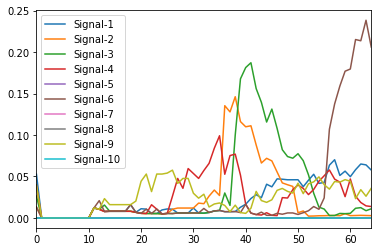

Topics Terms for StDAY


Topic Number                    Topic Terms                    
0         1       hours, tonight, friend, straightening, dont, b...
1         2       number, space, aww, random, episodes, notebook...
2         3       snatches, frustrations, mind, conan, dear, cou...
3         4       lazy, tired, watch, movies, awww, sleep, prett...
4         5       honesty, rambling, manage, forgot, sympathetic...
5         6       cinderella, mess, lyrics, ringtones, days, ful...
6         7       clubhouse, forget, cute, summer, send, singing...
7         8       twitterland, watching, exhausted, yup, awesome...
8         9       feel, die, work, hurt, goodnight, hell, hate, day
9        10       sad, deadline, gum, triple, frequently, curl, ...
10       11       cramp, sam, teenage, arms, lies, computer, art...
11       12       son, casablanca, thankfully, list, teasing, fe...
12       13       limp, dollar, gavin, blink, chomps, battle, so...
13       14       beautiful, notice, sign, talking, freakin, tot...
14       15       meant, break, sheer, sheet, takes, squealed, r...
15       16       saturday, ugh, people, pic, focus, covers, wok...
16       17       , lied, scratch, sleeping, reynolds, george, h...
17       18       aw, developed, updated, chapters, middle, plan...
18       19       switched, ages, ewww, paper, dumb, dammit, fin...
19       20       ganging, rang, themed, go_to_sleep, thesis, fa...
20       21       lie, story, crap, working, mobile, woo, ruined...
21       22                                         hon, good, haha
22       23       yay, song, started, twitter, write, tweet, fun...
23       24                     adding, falling, num, love, cradles
24       25       flash, bastard, finish, humor, pg, register, b...

Seeded Terms Per Topic for StDAY


Topic Number      Seed Terms:Count    
0   signal_9    hell:39, die:14, hurt:14
1   signal_1         bored:1, boredom:14
2   signal_3       insomnia:14, awake:26
3   signal_2                  despair:14
4   signal_4                    tired:46
5   signal_6       gross:2, forgotten:14

Topics Probabilties Over Time for Jayme1988


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   07/04/2009 - 20/04/2009     0.0    0.0434783     0.0    0.0217391   
1   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
2   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
3   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
4   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
5   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
6   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
7   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
8   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
9   19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
10  19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
11  19/04/2009 - 20/04/2009     0.0    0.0000000     0.0    0.0000000   
12  19/04/2009 - 02/05/2009     0.0    0.0222222     0.0    0.0444444   
13  20/04/2009 - 02/05/2009     0.0    0.0000000     0.0    0.0000000   
14  02/05/2009 - 04/05/2009     0.0    0.0000000     0.0    0.0000000   
15  02/05/2009 - 04/05/2009     0.0    0.0000000     0.0    0.0000000   
16  02/05/2009 - 04/05/2009     0.0    0.0000000     0.0    0.0000000   
17  02/05/2009 - 04/05/2009     0.0    0.0000000     0.0    0.0000000   
18  02/05/2009 - 04/05/2009     0.0    0.0000000     0.0    0.0000000   
19  02/05/2009 - 04/05/2009     0.0    0.0000000     0.0    0.0000000   
20  02/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
21  02/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
22  02/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
23  02/05/2009 - 10/05/2009     0.0    0.0000000     0.0    0.0000000   
24  02/05/2009 - 14/05/2009     0.0    0.0172414     0.0    0.0172414   
..                      ...       ...        ...       ...        ...   
42  22/05/2009 - 01/06/2009     0.0    0.0459770     0.0    0.0660920   
43  22/05/2009 - 02/06/2009     0.0    0.0337349     0.0    0.0771084   
44  22/05/2009 - 03/06/2009     0.0    0.0465587     0.0    0.0971660   
45  22/05/2009 - 03/06/2009     0.0    0.0485830     0.0    0.0789474   
46  29/05/2009 - 05/06/2009     0.0    0.0361702     0.0    0.0914894   
47  29/05/2009 - 06/06/2009     0.0    0.0333988     0.0    0.0785855   
48  29/05/2009 - 07/06/2009     0.0    0.0260708     0.0    0.0744879   
49  29/05/2009 - 07/06/2009     0.0    0.0297952     0.0    0.0651769   
50  29/05/2009 - 07/06/2009     0.0    0.0353818     0.0    0.0707635   
51  29/05/2009 - 07/06/2009     0.0    0.0279330     0.0    0.0614525   
52  29/05/2009 - 07/06/2009     0.0    0.0391061     0.0    0.0558659   
53  30/05/2009 - 07/06/2009     0.0    0.0307102     0.0    0.0518234   
54  31/05/2009 - 07/06/2009     0.0    0.0363196     0.0    0.0847458   
55  01/06/2009 - 07/06/2009     0.0    0.0310559     0.0    0.0621118   
56  02/06/2009 - 15/06/2009     0.0    0.0382166     0.0    0.0159236   
57  03/06/2009 - 16/06/2009     0.0    0.0390071     0.0    0.0141844   
58  05/06/2009 - 17/06/2009     0.0    0.0184332     0.0    0.0138249   
59  05/06/2009 - 18/06/2009     0.0    0.0217391     0.0    0.0086957   
60  06/06/2009 - 19/06/2009     0.0    0.0048077     0.0    0.0144231   
61  07/06/2009 - 20/06/2009     0.0    0.0107527     0.0    0.0161290   
62  15/06/2009 - 20/06/2009     0.0    0.0063291     0.0    0.0063291   
63  15/06/2009 - 20/06/2009     0.0    0.0063291     0.0    0.0063291   
64  15/06/2009 - 23/06/2009     0.0    0.0238095     0.0    0.0119048   
65  15/06/2009 - 23/06/2009     0.0    0.0119048     0.0    0.0119048   
66  15/06/2009 - 25/06/2009     0.0    0.0111732     0.0    0.0391061   

    Signal-5  Signal-6  Signal-7  Signal-8   Signal-9   Signal-10  
0      0.0       0.0       0.0    0.0217391  0.0434783     0.0     
1      0.0       0.0       0.0    0.0000000  0.0000000     0.0     
2      0

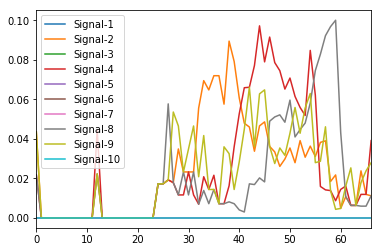

Topics Terms for Jayme1988


Topic Number                    Topic Terms                    
0         2       busy, spam, sweet, breaking, quiz, night, mise...
1         3                                          follow, friday
2         4       info, lazy, hit, weakness, twitter, lol, times...
3         5                                 sleep, eating, day, omg
4         6       , litre, vodka, tasks, beauty, richard, couple...
5         7                                       great, good, song
6         8       liar, insulted, language, people, muffin, unfo...
7         9                           cries, ruined, blocking, hurt
8        10       remembering, fair, energy, sushi, idea, brain,...
9        11                                         ways, work, num
10       12       honored, muah, rest, homosexuality, durham, ma...
11       13       snuggles, sex, goodnight, grrr, customization,...
12       14       relevant, tired, hungy, follower, pass, happin...
13       15       immage, xmen, chat, fail, watched, sounds, gir...
14       16       sweetie, working, started, boss, music, treadm...
15       17       joking, random, mind, comfortable, blip, mediu...
16       18       dedicated, office, sleeping, laugh, tweeted, i...
17       19       shop, shoes, cried, rubbing, obsolete, communi...
18       20       shetland, shoulders, pony, tight, feel, rob, r...
19       21       sort, wobblers, porn, fingers, female, year, m...
20       22       life, origins, hannah, hated, watch, meg, yeah...
21       23       fantastic, sad, letting, promiscuous, told, gr...
22       24       dead, yey, smoking, darlin, rid, waiting, foll...
23       25       beautiful, cute, hehehe, love, saturdays, enjo...

Seeded Terms Per Topic for Jayme1988


Topic Number      Seed Terms:Count     
0   signal_9                      hurt:28
1   signal_8                  annoying:14
2   signal_2    miserable:14, breaking:14
3   signal_4         weakness:14, lazy:14
4   signal_6                      hated:1

Topics Probabilties Over Time for VioletsCRUK


Time Period         Signal-1  Signal-2   Signal-3  Signal-4   \
0   07/04/2009 - 20/04/2009     0.0    0.0217391     0.0    0.0760870   
1   18/04/2009 - 21/04/2009     0.0    0.0079365     0.0    0.0555556   
2   18/04/2009 - 21/04/2009     0.0    0.0158730     0.0    0.0238095   
3   18/04/2009 - 21/04/2009     0.0    0.0158730     0.0    0.0714286   
4   18/04/2009 - 21/04/2009     0.0    0.0238095     0.0    0.0714286   
5   18/04/2009 - 21/04/2009     0.0    0.0158730     0.0    0.1031746   
6   18/04/2009 - 21/04/2009     0.0    0.0158730     0.0    0.0476190   
7   18/04/2009 - 21/04/2009     0.0    0.0317460     0.0    0.0079365   
8   18/04/2009 - 21/04/2009     0.0    0.0158730     0.0    0.0158730   
9   18/04/2009 - 21/04/2009     0.0    0.0079365     0.0    0.0238095   
10  18/04/2009 - 21/04/2009     0.0    0.0079365     0.0    0.0396825   
11  18/04/2009 - 21/04/2009     0.0    0.0079365     0.0    0.0396825   
12  19/04/2009 - 02/05/2009     0.0    0.0362319     0.0    0.1086957   
13  20/04/2009 - 03/05/2009     0.0    0.0151515     0.0    0.1136364   
14  21/04/2009 - 04/05/2009     0.0    0.0211640     0.0    0.0846561   
15  02/05/2009 - 04/05/2009     0.0    0.0709220     0.0    0.0921986   
16  02/05/2009 - 04/05/2009     0.0    0.0425532     0.0    0.0992908   
17  02/05/2009 - 04/05/2009     0.0    0.0567376     0.0    0.0992908   
18  02/05/2009 - 04/05/2009     0.0    0.0638298     0.0    0.0638298   
19  02/05/2009 - 04/05/2009     0.0    0.0354610     0.0    0.0992908   
20  02/05/2009 - 10/05/2009     0.0    0.0352941     0.0    0.0941176   
21  02/05/2009 - 10/05/2009     0.0    0.0352941     0.0    0.1000000   
22  02/05/2009 - 10/05/2009     0.0    0.0470588     0.0    0.0823529   
23  02/05/2009 - 10/05/2009     0.0    0.0352941     0.0    0.0647059   
24  02/05/2009 - 14/05/2009     0.0    0.0526316     0.0    0.0789474   
..                      ...       ...        ...       ...        ...   
37  14/05/2009 - 22/05/2009     0.0    0.0321543     0.0    0.0482315   
38  17/05/2009 - 22/05/2009     0.0    0.0378007     0.0    0.0412371   
39  17/05/2009 - 29/05/2009     0.0    0.0380952     0.0    0.0095238   
40  17/05/2009 - 30/05/2009     0.0    0.0329897     0.0    0.0103093   
41  18/05/2009 - 31/05/2009     0.0    0.0112994     0.0    0.0240113   
42  22/05/2009 - 01/06/2009     0.0    0.0067385     0.0    0.0134771   
43  22/05/2009 - 02/06/2009     0.0    0.0079096     0.0    0.0282486   
44  22/05/2009 - 03/06/2009     0.0    0.0114943     0.0    0.0094044   
45  22/05/2009 - 03/06/2009     0.0    0.0031348     0.0    0.0313480   
46  29/05/2009 - 05/06/2009     0.0    0.0078038     0.0    0.0122631   
47  29/05/2009 - 06/06/2009     0.0    0.0097847     0.0    0.0234834   
48  29/05/2009 - 07/06/2009     0.0    0.0092678     0.0    0.0074143   
49  29/05/2009 - 07/06/2009     0.0    0.0111214     0.0    0.0213160   
50  29/05/2009 - 07/06/2009     0.0    0.0074143     0.0    0.0139018   
51  29/05/2009 - 07/06/2009     0.0    0.0120482     0.0    0.0278035   
52  29/05/2009 - 07/06/2009     0.0    0.0120482     0.0    0.0185357   
53  30/05/2009 - 07/06/2009     0.0    0.0132701     0.0    0.0284360   
54  31/05/2009 - 07/06/2009     0.0    0.0112994     0.0    0.0158192   
55  01/06/2009 - 07/06/2009     0.0    0.0247117     0.0    0.0148270   
56  02/06/2009 - 15/06/2009     0.0    0.0229709     0.0    0.0137825   
57  03/06/2009 - 16/06/2009     0.0    0.0255183     0.0    0.0191388   
58  05/06/2009 - 17/06/2009     0.0    0.0242634     0.0    0.0086655   
59  05/06/2009 - 17/06/2009     0.0    0.0207972     0.0    0.0103986   
60  06/06/2009 - 19/06/2009     0.0    0.0187970     0.0    0.0187970   
61  07/06/2009 - 20/06/2009     0.0    0.0194175     0.0    0.0266990   

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0    0.0869565     0.0    0.0108696     0.0       0.0     
1      0.0    0.0873016     0.0    0.0079365     0.0       0.0     
2      0

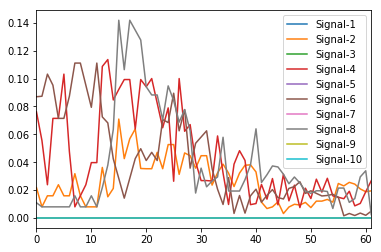

Topics Terms for VioletsCRUK


Topic Number                    Topic Terms                    
0         1       cute, outta, helpin, ffs, ysterday, lycra, tal...
1         2       dreading, good, worse, depressed, crappy_day, ...
2         3       plants, account, opening, brilliant, house, sy...
3         4                                      enjoy, lazy, sneak
4         5       missus, fish, ages, rest, sat, letting, seein,...
5         6       cut, ya, no_one_cares, morning, afternoon, use...
6         7       rating, chillaxin, fair, measily, ann, rachel,...
7         8       great, paranoid, tweet, fight, weather, mouth,...
8         9       meant, coffee, kids, monday, sit, big, sunday,...
9        10       nooo, play, vino, dance, scared, idea, go_to_b...
10       11       comment, gardening, cancer, straw, wank, rando...
11       12       dad, bling, replying, feel, penny, deep, blood...
12       13       stones, ive, mssions, dig, decides, family, pe...
13       14       cheese, irish, bicycle, upstairs, fluffy, shar...
14       15       doolally, cry, jason, gr, render, moth, laptop...
15       16                                                     num
16       17       raining, process, ouch, hair, hyped, sober, ir...
17       18       dean, twitter, bacon, sad, brill, il, chat, gr...
18       19       week, love, working, guys, yip, laugh, forward...
19       20       walking, tone, figure, jokin, taste, text, bar...
20       21       petition, grrr, razzamataz, weight, esp, tv, k...
21       22       equally, tough, inebriated, session, tired, bo...
22       23       loss, staying, woman, lad, sweet, scottishness...
23       24       roger, btw, medication, eh, ploughing, absolut...
24       25       major, hyper, gals, informed, afew, booze, fol...

Seeded Terms Per Topic for VioletsCRUK


Topic Number                  Seed Terms:Count                 
0   signal_8                                          paranoid:14
1   signal_2    crappy_day:14, dreading:14, helpless:14, depre...
2   signal_4                                              lazy:14
3   signal_6                          useless:14, no_one_cares:14

Topics Probabilties Over Time for tsarnick


Time Period         Signal-1  Signal-2  Signal-3   Signal-4  \
0   06/04/2009 - 19/04/2009     0.0       0.0    0.0076923     0.0     
1   07/04/2009 - 20/04/2009     0.0       0.0    0.0074074     0.0     
2   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
3   19/04/2009 - 21/04/2009     0.0       0.0    0.0198020     0.0     
4   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
5   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
6   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
7   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
8   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
9   19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
10  19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
11  19/04/2009 - 21/04/2009     0.0       0.0    0.0099010     0.0     
12  19/04/2009 - 01/05/2009     0.0       0.0    0.0188679     0.0     
13  19/04/2009 - 02/05/2009     0.0       0.0    0.0131579     0.0     
14  20/04/2009 - 03/05/2009     0.0       0.0    0.0182927     0.0     
15  21/04/2009 - 04/05/2009     0.0       0.0    0.0207254     0.0     
16  01/05/2009 - 04/05/2009     0.0       0.0    0.0054054     0.0     
17  01/05/2009 - 04/05/2009     0.0       0.0    0.0108108     0.0     
18  01/05/2009 - 04/05/2009     0.0       0.0    0.0108108     0.0     
19  01/05/2009 - 04/05/2009     0.0       0.0    0.0216216     0.0     
20  01/05/2009 - 09/05/2009     0.0       0.0    0.0105820     0.0     
21  01/05/2009 - 10/05/2009     0.0       0.0    0.0088496     0.0     
22  01/05/2009 - 11/05/2009     0.0       0.0    0.0044053     0.0     
23  01/05/2009 - 11/05/2009     0.0       0.0    0.0044053     0.0     
24  01/05/2009 - 13/05/2009     0.0       0.0    0.0043103     0.0     
25  01/05/2009 - 14/05/2009     0.0       0.0    0.0032258     0.0     
26  02/05/2009 - 14/05/2009     0.0       0.0    0.0131148     0.0     
27  03/05/2009 - 16/05/2009     0.0       0.0    0.0035842     0.0     
28  04/05/2009 - 17/05/2009     0.0       0.0    0.0034014     0.0     
29  09/05/2009 - 18/05/2009     0.0       0.0    0.0038760     0.0     
30  09/05/2009 - 18/05/2009     0.0       0.0    0.0116279     0.0     
31  09/05/2009 - 18/05/2009     0.0       0.0    0.0038760     0.0     
32  09/05/2009 - 18/05/2009     0.0       0.0    0.0077519     0.0     
33  09/05/2009 - 22/05/2009     0.0       0.0    0.0659341     0.0     
34  10/05/2009 - 22/05/2009     0.0       0.0    0.0637119     0.0     
35  11/05/2009 - 22/05/2009     0.0       0.0    0.0802469     0.0     
36  13/05/2009 - 22/05/2009     0.0       0.0    0.0650155     0.0     
37  13/05/2009 - 22/05/2009     0.0       0.0    0.0773994     0.0     
38  14/05/2009 - 22/05/2009     0.0       0.0    0.0786164     0.0     
39  16/05/2009 - 28/05/2009     0.0       0.0    0.1003236     0.0     
40  16/05/2009 - 29/05/2009     0.0       0.0    0.0846154     0.0     
41  17/05/2009 - 30/05/2009     0.0       0.0    0.0814159     0.0     
42  18/05/2009 - 31/05/2009     0.0       0.0    0.0766355     0.0     

    Signal-5  Signal-6   Signal-7  Signal-8   Signal-9  Signal-10  
0      0.0    0.0076923     0.0    0.0307692     0.0       0.0     
1      0.0    0.0074074     0.0    0.0148148     0.0       0.0     
2      0.0    0.0198020     0.0    0.0099010     0.0       0.0     
3      0.0    0.0099010     0.0    0.0198020     0.0       0.0     
4      0.0    0.0099010     0.0    0.0099010     0.0       0.0     
5      0.0    0.0099010     0.0    0.0099010     0.0       0.0     
6      0.0    0.0099010     0.0    0.0099010     0.0       0.0     
7      0.0    0.0099010     0.0    0.0099010     0.0       0.0     
8      0.0    0.0198020     0.0    0.0099010     0.0       0.0     
9      0.0    0.0198020     0.0    0.0099010     0.0       0.0     
10     0.0    0.0198020     0.0    0.0099010     0.0       0.0     
11     0.0    0.0099010 

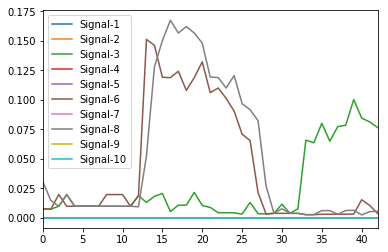

Topics Terms for tsarnick


Topic Number                    Topic Terms                    
0         1       examinations, term, solar, lyrics, vote, fresh...
1         2       sass, rl, work, lucky, inferiority, thought, m...
2         3       pony, photo, scared, violent, follow, tweeted,...
3         4       bling, group, saturdays, clip, frost, donnie, ...
4         5       case, num, joking, auction, tweetdeck, mate, t...
5         6       leave, votes, comfort, australians, wow, honey...
6         7       eh, scene, walk, disappointing, victim, blocke...
7         8       drive, likes, scenie, shit, court, paranoid, i...
8         9       poor, set, adobe, forget, feel, money, month, ...
9        10       great, jobs, bruz, hannah, emo, wednesday, cra...
10       11                                yep, awesome, coke, yeah
11       12                                                 twitter
12       13                                  unstoppable, bit, film
13       14       donkey, deal, fish, confused, changeling, kong...
14       15       horse, ball, purdy, yj, justice, queen, royal,...
15       16                       sweet, sounds, mind, tsar, change
16       17       enjoy, make_me_sad, prediction, ppl, hassle, h...
17       18              week, people, phone, heard, bad, msi, cool
18       19       drunken, golf, drunk, predict, anti, belt, cup...
19       20                                   lady, job, good, haha
20       21       mexican, brisbane, zing, dear, deserve, nan, f...
21       22       heaps, trippin, trending, comments, rampage, f...
22       23       , gnomes, yay, pretty, sit, average, voted, id...
23       24       meant, perfect, wtf, freight, comp, retarded, ...
24       25       sort, kidnapping, working, power, photos, rock...

Seeded Terms Per Topic for tsarnick


Topic Number Seed Terms:Count
0   signal_8      paranoid:2   
1   signal_3         awake:3   
2   signal_6       useless:2

Topics Probabilties Over Time for caldjr


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   07/04/2009 - 20/04/2009     0.0    0.0000000     0.0       0.0     
1   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
2   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
3   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
4   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
5   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
6   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
7   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
8   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
9   20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
10  20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
11  20/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
12  20/04/2009 - 02/05/2009     0.0    0.0114943     0.0       0.0     
13  20/04/2009 - 03/05/2009     0.0    0.0168067     0.0       0.0     
14  21/04/2009 - 04/05/2009     0.0    0.0076923     0.0       0.0     
15  02/05/2009 - 04/05/2009     0.0    0.0238095     0.0       0.0     
16  02/05/2009 - 04/05/2009     0.0    0.0119048     0.0       0.0     
17  02/05/2009 - 04/05/2009     0.0    0.0119048     0.0       0.0     
18  02/05/2009 - 04/05/2009     0.0    0.0119048     0.0       0.0     
19  02/05/2009 - 04/05/2009     0.0    0.0119048     0.0       0.0     
20  02/05/2009 - 04/05/2009     0.0    0.0119048     0.0       0.0     
21  02/05/2009 - 11/05/2009     0.0    0.0106383     0.0       0.0     
22  02/05/2009 - 11/05/2009     0.0    0.0212766     0.0       0.0     
23  02/05/2009 - 11/05/2009     0.0    0.0212766     0.0       0.0     
24  02/05/2009 - 14/05/2009     0.0    0.0094340     0.0       0.0     
..                      ...       ...        ...       ...       ...   
36  14/05/2009 - 22/05/2009     0.0    0.2598425     0.0       0.0     
37  14/05/2009 - 27/05/2009     0.0    0.2686567     0.0       0.0     
38  17/05/2009 - 27/05/2009     0.0    0.2786885     0.0       0.0     
39  17/05/2009 - 29/05/2009     0.0    0.1988950     0.0       0.0     
40  17/05/2009 - 30/05/2009     0.0    0.1181102     0.0       0.0     
41  18/05/2009 - 31/05/2009     0.0    0.0803859     0.0       0.0     
42  22/05/2009 - 01/06/2009     0.0    0.0035587     0.0       0.0     
43  22/05/2009 - 02/06/2009     0.0    0.0027778     0.0       0.0     
44  22/05/2009 - 03/06/2009     0.0    0.0072289     0.0       0.0     
45  22/05/2009 - 03/06/2009     0.0    0.0048193     0.0       0.0     
46  27/05/2009 - 05/06/2009     0.0    0.0050761     0.0       0.0     
47  27/05/2009 - 06/06/2009     0.0    0.0043478     0.0       0.0     
48  27/05/2009 - 07/06/2009     0.0    0.0086022     0.0       0.0     
49  27/05/2009 - 07/06/2009     0.0    0.0043011     0.0       0.0     
50  27/05/2009 - 07/06/2009     0.0    0.0043011     0.0       0.0     
51  29/05/2009 - 07/06/2009     0.0    0.0043668     0.0       0.0     
52  29/05/2009 - 07/06/2009     0.0    0.0043668     0.0       0.0     
53  30/05/2009 - 07/06/2009     0.0    0.0050125     0.0       0.0     
54  31/05/2009 - 07/06/2009     0.0    0.0122699     0.0       0.0     
55  01/06/2009 - 07/06/2009     0.0    0.0077821     0.0       0.0     
56  02/06/2009 - 15/06/2009     0.0    0.0077821     0.0       0.0     
57  03/06/2009 - 16/06/2009     0.0    0.0086207     0.0       0.0     
58  05/06/2009 - 17/06/2009     0.0    0.0053763     0.0       0.0     
59  05/06/2009 - 17/06/2009     0.0    0.0107527     0.0       0.0     
60  06/06/2009 - 19/06/2009     0.0    0.0050000     0.0       0.0     

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0       0.0       0.0       0.0       0.0       0.0     
1      0.0       0.0       0.0       0.0       0.0       0.0     
2      0.0       0.0       0.0       0.0       0.0       0.0     


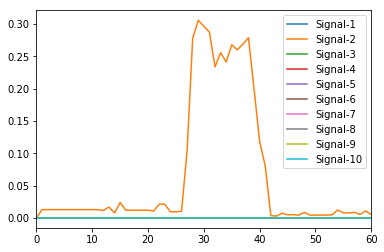

Topics Terms for caldjr


Topic Number                    Topic Terms                    
0         1                                               good, hey
1         2       nigel, presuming, wall, text, rest, talking, u...
2         3       nearest, walks, share, life, pistachios, praye...
3         4       beautiful, paperwork, sickness, confused, wait...
4         5       raining, apple, guessing, wasp, nut, rattling,...
5         6       shop, house, chip, sting, ended, rough, find, ...
6         7       rescue, power, hannah, root, sunburnt, brownin...
7         9                              feel, sunshine, num, happy
8        10       kids, sleaford, wednesday, hot, ho, mentioned,...
9        11                                                     day
10       12       box, work, pain, nan, started, memories, vehic...
11       14       enjoy, edinburgh, peterborough, johnny, area, ...
12       15       eh, tired, pic, stinging, voucher, tomorrow, h...
13       16       sending, stupid, tuesday, safe, sunny, lol, st...
14       17       week, blue, evening, logging, broadband, trave...
15       18       cinema, loch, tonight, itv, behaving, ian, com...
16       20                              isnt, great, waited, stays
17       21       love, regret, family, twitter, tad, fromt, chu...
18       22       sob, fresher, prayers, fish, sushi, encouragin...
19       23       perfect, hour, hospital, flu, feels, heading, ...
20       24                                                     top
21       25                                                 morning

Seeded Terms Per Topic for caldjr


Topic Number Seed Terms:Count
0   signal_2    feeling_sad:14

Topics Probabilties Over Time for janine_j9


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   18/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
1   19/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
2   21/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
3   21/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
4   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
5   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
6   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
7   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
8   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
9   01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  01/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
13  01/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
14  03/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
15  03/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
16  10/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
20  10/05/2009 - 21/05/2009     0.0       0.0       0.0       0.0       0.0     
21  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
23  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
24  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
28  17/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
29  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
30  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
31  21/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
32  21/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
33  21/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
34  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
35  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
36  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
37  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
38  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
40  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
41  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
44  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
45  02/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
46  03/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
47  05/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
48  05/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
49  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
50  07/06/2009 - 20/06/2009     0.0     

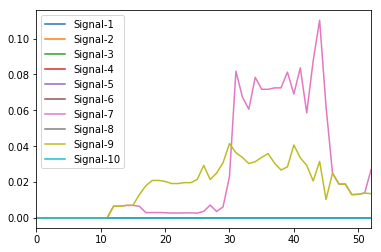

Topics Terms for janine_j9


Topic Number                    Topic Terms                    
0         1       mommy, years, thursday, bunch, passes, immune,...
1         2       talking, scary, freak, summer, alumni, flu, se...
2         3       album, school, good, patient, august, esp, han...
3         4       bye, underwear, buy, cost, cable, fair, pay, f...
4         5       love, yeah, gangster, rising, defending, churc...
5         6       great, finish, lace, videos, leather, singing,...
6         7       graduation, watching, short_attention_span, sa...
7         8       body, poor, language, club, hahahha, meet, called
8         9                sis, death, ryan, sad, hell, reply, hope
9        10       sleeve, michaeljohnsmusic, myspace, suggestion...
10       11       calculus, dates, eating, working, meeting, roc...
11       12                     itunes, heart, single, idol, listen
12       13       cry, grade, money, spanish, feelings, callate,...
13       14       uggh, dont, ai, warning, guess, referring, dri...
14       15       yay, buddy, bb, slept, awww, strawberries, asl...
15       16       comment, recapping, lulz, tonight, books, vide...
16       17       archie, busy, crazy, inxs, juday, crybaby, ntu...
17       18       tv, sooo, thought, num, ahhh, answer, hate, ba...
18       19                                      phone, live, night
19       20       remembering, skating, play, song, mtv, update,...
20       21       , prayers, yesterday, rip, david, turn, adam, ...
21       22                                             lol, friend
22       23       cute, keeping, pat, ive, track, time, haha, an...
23       24                                              johns, mom
24       25       polo, elementary, check, congrats, todai, jam,...

Seeded Terms Per Topic for janine_j9


Topic Number           Seed Terms:Count          
0   signal_9                      hell:28, death:14
1   signal_7    short_attention_span:14, confused:1

Topics Probabilties Over Time for radha_


Time Period         Signal-1   Signal-2  Signal-3  Signal-4   \
0   20/04/2009 - 03/05/2009  0.0394737     0.0       0.0    0.0394737   
1   21/04/2009 - 04/05/2009  0.0679612     0.0       0.0    0.0291262   
2   02/05/2009 - 04/05/2009  0.0222222     0.0       0.0    0.0111111   
3   02/05/2009 - 04/05/2009  0.0111111     0.0       0.0    0.0111111   
4   02/05/2009 - 04/05/2009  0.0111111     0.0       0.0    0.0111111   
5   02/05/2009 - 04/05/2009  0.0111111     0.0       0.0    0.0111111   
6   02/05/2009 - 04/05/2009  0.0444444     0.0       0.0    0.0111111   
7   02/05/2009 - 04/05/2009  0.0222222     0.0       0.0    0.0222222   
8   02/05/2009 - 04/05/2009  0.0111111     0.0       0.0    0.0111111   
9   02/05/2009 - 04/05/2009  0.0111111     0.0       0.0    0.0111111   
10  02/05/2009 - 04/05/2009  0.0111111     0.0       0.0    0.0111111   
11  02/05/2009 - 14/05/2009  0.0263158     0.0       0.0    0.0087719   
12  02/05/2009 - 14/05/2009  0.0087719     0.0       0.0    0.0087719   
13  03/05/2009 - 14/05/2009  0.0185185     0.0       0.0    0.0092593   
14  04/05/2009 - 17/05/2009  0.0107527     0.0       0.0    0.0215054   
15  14/05/2009 - 18/05/2009  0.0288462     0.0       0.0    0.0096154   
16  14/05/2009 - 18/05/2009  0.0096154     0.0       0.0    0.0096154   
17  14/05/2009 - 18/05/2009  0.0480769     0.0       0.0    0.0096154   
18  14/05/2009 - 18/05/2009  0.0096154     0.0       0.0    0.0192308   
19  14/05/2009 - 22/05/2009  0.0071942     0.0       0.0    0.0071942   
20  14/05/2009 - 22/05/2009  0.0071942     0.0       0.0    0.0071942   
21  14/05/2009 - 22/05/2009  0.0287770     0.0       0.0    0.0071942   
22  14/05/2009 - 22/05/2009  0.0287770     0.0       0.0    0.0071942   
23  14/05/2009 - 22/05/2009  0.0143885     0.0       0.0    0.0071942   
24  14/05/2009 - 22/05/2009  0.0071942     0.0       0.0    0.0071942   
25  17/05/2009 - 22/05/2009  0.0086957     0.0       0.0    0.0086957   
26  17/05/2009 - 29/05/2009  0.0078740     0.0       0.0    0.0078740   
27  17/05/2009 - 30/05/2009  0.0072993     0.0       0.0    0.0072993   
28  18/05/2009 - 31/05/2009  0.0187500     0.0       0.0    0.0062500   
29  22/05/2009 - 01/06/2009  0.0514019     0.0       0.0    0.0093458   
30  22/05/2009 - 02/06/2009  0.0354610     0.0       0.0    0.0496454   
31  22/05/2009 - 03/06/2009  0.0163399     0.0       0.0    0.0686275   
32  22/05/2009 - 03/06/2009  0.0261438     0.0       0.0    0.0620915   
33  29/05/2009 - 05/06/2009  0.0237288     0.0       0.0    0.0813559   
34  29/05/2009 - 05/06/2009  0.0237288     0.0       0.0    0.0813559   
35  29/05/2009 - 05/06/2009  0.0203390     0.0       0.0    0.0711864   
36  29/05/2009 - 05/06/2009  0.0203390     0.0       0.0    0.0745763   
37  29/05/2009 - 05/06/2009  0.0338983     0.0       0.0    0.0779661   
38  29/05/2009 - 05/06/2009  0.0101695     0.0       0.0    0.0711864   
39  29/05/2009 - 05/06/2009  0.0135593     0.0       0.0    0.0779661   
40  30/05/2009 - 05/06/2009  0.0212014     0.0       0.0    0.0883392   
41  31/05/2009 - 05/06/2009  0.0366300     0.0       0.0    0.0732601   
42  01/06/2009 - 05/06/2009  0.0401606     0.0       0.0    0.0843373   
43  02/06/2009 - 05/06/2009  0.0141844     0.0       0.0    0.1418440   
44  03/06/2009 - 16/06/2009  0.0796460     0.0       0.0    0.0796460   
45  05/06/2009 - 17/06/2009  0.0754717     0.0       0.0    0.0094340   

    Signal-5  Signal-6   Signal-7   Signal-8  Signal-9  Signal-10  
0      0.0    0.0526316  0.0131579     0.0       0.0       0.0     
1      0.0    0.0679612  0.0097087     0.0       0.0       0.0     
2      0.0    0.0666667  0.0111111     0.0       0.0       0.0     
3      0.0    0.0888889  0.0111111     0.0       0.0       0.0     
4      0.0    0.0444444  0.0444444     0.0       0.0       0.0     
5      0.0    0.0555556  0.0444444     0.0       0.0       0.0     
6      0.0    0.0444444  0.0222222     0.0       0.0       0.0     
7      0.0    0.0666667  0.033333

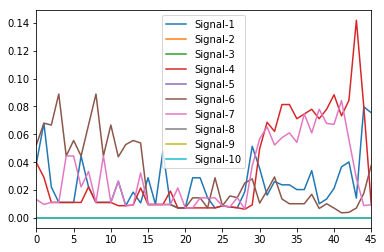

Topics Terms for radha_


Topic Number                    Topic Terms                    
0         1                          boring, half, num, bored, blah
1         2       heavily, yeah, expect, president, balanced, wa...
2         3       hallo, fraandsheep, handle, remember, feel, pi...
3         4       shoud, fever, ohh, pups, did_nothing, relief, ...
4         5                                 haha, work, fave, stuff
5         6                     files, hows, evening, book, useless
6         7       families, read, hp, confused, awwws, making, f...
7         8       writers, images, star, grown, satire, valid, g...
8         9       crowd, talking, gb, parking, vam, late, call, ...
9        10       himym, finish, point, mysore, travel, night, y...
10       11                                    tv, thing, hot, nice
11       12       story, interesting, conked, watch, hey, zimbly...
12       13       funny, btw, ya, doodle, timepass, accept, cost...
13       14       halloo, money, twitter, celebrating, follow, f...
14       15       beautiful, oohh, tea, india, idea, tourofnilgi...
15       16       cute, people, series, episodes, cold, twitpic,...
16       17       perfect, loved, coffee, buy, headed, wake, top...
17       18                                 good, dont, hd, playing
18       19       manikya, barney, floor, dinner, college, seaso...
19       20       tired, month, tonight, throat, pain, grazing, ...
20       21                                                     abt
21       22       pink, explaining, great, thankfully, places, n...
22       23       comment, hahhahah, afraid, compliments, timesp...
23       24       heylooo, life, population, sitting, dangerous,...
24       25       poor, cut, refreshing, rest, doctor, hannah, n...

Seeded Terms Per Topic for radha_


Topic Number   Seed Terms:Count 
0   signal_1    boring:16, bored:2
1   signal_4        did_nothing:14
2   signal_7           confused:14
3   signal_6            useless:14

Topics Probabilties Over Time for endlessblush


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   03/05/2009 - 03/05/2009     0.0    0.0000000     0.0       0.0     
1   17/05/2009 - 17/05/2009     0.0    0.0000000     0.0       0.0     
2   17/05/2009 - 18/05/2009     0.0    0.0196078     0.0       0.0     
3   17/05/2009 - 18/05/2009     0.0    0.0196078     0.0       0.0     
4   17/05/2009 - 18/05/2009     0.0    0.0196078     0.0       0.0     
5   17/05/2009 - 18/05/2009     0.0    0.0196078     0.0       0.0     
6   17/05/2009 - 22/05/2009     0.0    0.0147059     0.0       0.0     
7   17/05/2009 - 22/05/2009     0.0    0.0147059     0.0       0.0     
8   17/05/2009 - 22/05/2009     0.0    0.0147059     0.0       0.0     
9   17/05/2009 - 22/05/2009     0.0    0.0147059     0.0       0.0     
10  17/05/2009 - 22/05/2009     0.0    0.0147059     0.0       0.0     
11  17/05/2009 - 22/05/2009     0.0    0.0147059     0.0       0.0     
12  17/05/2009 - 28/05/2009     0.0    0.0126582     0.0       0.0     
13  17/05/2009 - 29/05/2009     0.0    0.0087719     0.0       0.0     
14  17/05/2009 - 30/05/2009     0.0    0.0052083     0.0       0.0     
15  18/05/2009 - 31/05/2009     0.0    0.0046512     0.0       0.0     
16  22/05/2009 - 01/06/2009     0.0    0.0165289     0.0       0.0     
17  22/05/2009 - 02/06/2009     0.0    0.0112360     0.0       0.0     
18  22/05/2009 - 03/06/2009     0.0    0.0301205     0.0       0.0     
19  22/05/2009 - 03/06/2009     0.0    0.0240964     0.0       0.0     
20  28/05/2009 - 03/06/2009     0.0    0.0253968     0.0       0.0     
21  28/05/2009 - 03/06/2009     0.0    0.0317460     0.0       0.0     
22  28/05/2009 - 07/06/2009     0.0    0.0342679     0.0       0.0     
23  28/05/2009 - 07/06/2009     0.0    0.0467290     0.0       0.0     
24  28/05/2009 - 07/06/2009     0.0    0.0467290     0.0       0.0     
25  28/05/2009 - 07/06/2009     0.0    0.0498442     0.0       0.0     
26  29/05/2009 - 07/06/2009     0.0    0.0483871     0.0       0.0     
27  30/05/2009 - 07/06/2009     0.0    0.0618182     0.0       0.0     
28  31/05/2009 - 07/06/2009     0.0    0.0609137     0.0       0.0     
29  01/06/2009 - 07/06/2009     0.0    0.0887574     0.0       0.0     
30  02/06/2009 - 15/06/2009     0.0    0.0697674     0.0       0.0     
31  03/06/2009 - 16/06/2009     0.0    0.0447154     0.0       0.0     
32  07/06/2009 - 17/06/2009     0.0    0.0505051     0.0       0.0     
33  07/06/2009 - 18/06/2009     0.0    0.0466102     0.0       0.0     
34  07/06/2009 - 19/06/2009     0.0    0.0536398     0.0       0.0     
35  07/06/2009 - 20/06/2009     0.0    0.0524345     0.0       0.0     
36  15/06/2009 - 21/06/2009     0.0    0.0340909     0.0       0.0     
37  15/06/2009 - 21/06/2009     0.0    0.0265152     0.0       0.0     
38  15/06/2009 - 21/06/2009     0.0    0.0378788     0.0       0.0     
39  15/06/2009 - 21/06/2009     0.0    0.0340909     0.0       0.0     
40  15/06/2009 - 25/06/2009     0.0    0.0256410     0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
1      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
2      0.0    0.0392157     0.0       0.0    0.0196078     0.0     
3      0.0    0.0196078     0.0       0.0    0.0196078     0.0     
4      0.0    0.0196078     0.0       0.0    0.0196078     0.0     
5      0.0    0.0392157     0.0       0.0    0.0196078     0.0     
6      0.0    0.0441176     0.0       0.0    0.0147059     0.0     
7      0.0    0.1029412     0.0       0.0    0.0147059     0.0     
8      0.0    0.0294118     0.0       0.0    0.0147059     0.0     
9      0.0    0.0147059     0.0       0.0    0.0147059     0.0     
10     0.0    0.0294118     0.0       0.0    0.0147059     0.0     
11     0.0    0.0147059     0.0       0.0    0.0147059     0.0     
12     0.0    0.0379747     0.0       0.0    0.0253165     0.0     
13     0.0    0.0614035     0.0 

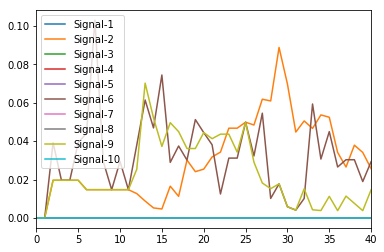

Topics Terms for endlessblush


Topic Number                    Topic Terms                    
0         1                                                 careful
1         2       perfect, bummed, tough, melbourne, thing, boxe...
2         3       nom, mexican, bill, sangria, pigs, delicious, ...
3         4       coeliac, feet, ready, worry, subject, soup, su...
4         5       forever, good, office, dreadmill, thinking, ho...
5         6                           shame, worst, not_good_enough
6         7                                           positive, num
7         8       thomas, blergh, superseeded, monday, interesti...
8         9       tiles, managers, journal, yesterday, lol, ebay...
9        11       restrictions, evening, hoping, dam, caught, ra...
10       12       insane, washcloth, disaster, tuesday, sign, au...
11       13          , yay, dvd, drink, hang, understand, time, day
12       14       major, love, share, asleep, stalker, letters, ...
13       15                                moved, cold, place, days
14       16       set, entendre, stream, feel, proportions, sand...
15       17       hip, goddess, kids, arranged, essentials, unpa...
16       18       ouch, bring, champagne, layers, envy, crap, fl...
17       19       ass, bugger, driving, matter, straw, wow, move...
18       20       lived, remember, homesick, mind, year, june, j...
19       21       week, word, worse, deserve, flucoldthing, yeah...
20       22       cookies, mental, idea, rest, talking, apologie...
21       23       sell, huge, vodka, ftw, domestic, recipes, nan...
22       24       heater, lied, summer, ugg, boots, month, middl...
23       25       scary, btw, safe, family, clock, data, awesome...

Seeded Terms Per Topic for endlessblush


Topic Number             Seed Terms:Count           
0   signal_9                                   dead:14
1   signal_2                 bummed:7, disappointed:14
2   signal_6    shame:17, worst:28, not_good_enough:14

Topics Probabilties Over Time for Kikirowr


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   18/04/2009 - 01/05/2009     0.0       0.0       0.0       0.0       0.0     
1   19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
2   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
3   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
4   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
5   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
6   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
7   01/05/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
8   01/05/2009 - 09/05/2009     0.0       0.0       0.0       0.0       0.0     
9   01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
10  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
11  01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
12  01/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
13  01/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
14  02/05/2009 - 13/05/2009     0.0       0.0       0.0       0.0       0.0     
15  03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
16  09/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
17  09/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
18  09/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
19  09/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
20  09/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
21  09/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
22  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
23  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
24  13/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
31  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
32  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
33  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
34  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
35  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
36  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
37  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
38  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
39  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
40  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
41  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
42  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
43  31/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
44  01/06/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
45  02/06/2009 - 15/06/2009     0.0       0.0       0.0       0.0       0.0     
46  03/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
47  05/06/2009 - 16/06/2009     0.0       0.0       0.0       0.0       0.0     
48  05/06/2009 - 18/06/2009     0.0       0.0       0.0       0.0       0.0     
49  06/06/2009 - 19/06/2009     0.0       0.0       0.0       0.0       0.0     
50  07/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
51  15/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
52  15/06/2009 - 20/06/2009     0.0       0.0       0.0       0.0       0.0     
53  15/06/2009 - 20/06/2009     0.0     

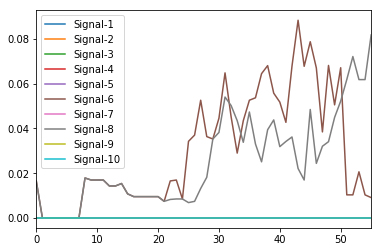

Topics Terms for Kikirowr


Topic Number                    Topic Terms                    
0         1       great, tired, purple, oopsie, frog, choice, um...
1         2       teh, cute, shoulders, buy, neck, cutest, rub, ...
2         3       cramps, kind, figured, bartender, modes, freya...
3         4       tickets, yepyep, problems, app, nan, terrible,...
4         5                                                  creepy
5         6                   lame, ouch, thought, awww, num, worst
6         7       , ball, salads, tekjunkseller, tree, waking, p...
7         8       anxiety, hospitals, cali, priest, fun, hehe, p...
8         9       body, sort, sad, monday, shorts, month, pictur...
9        10                               legs, asked, yeah, people
10       11       heavy, walking, family, moved, year, follow, t...
11       12                      aches, slept, bad, aw, woke, pizza
12       13       ugh, pushes, tuesday, ew, cu, figure, forms, e...
13       14       blizzcon, tests, turned, bcon, huh, race, slee...
14       15       paying, thing, dunno, twitter, attention, hour...
15       16       fringe, tank, missed, watching, assignment, he...
16       17       bagon, neh, lj, tweet, wikipedia, tanked, ches...
17       18       week, good, dps, kibo, aww, text, kitten, meee...
18       19       boy, yogg, full, yay, pains, salad, missing, p...
19       20       guildies, woot, sucks, top, felt, assholes, ho...
20       21       scary, guild, gear, feel, awesome, niiice, min...
21       22       ughugh, idea, sleeping, tonight, tylenol, soun...
22       23       love, hoping, read, site, bed, crappy, asleep,...
23       24       mini, questing, lived, vexas, tooo, curls, tum...
24       25       exciting, raid, longer, dealing, haha, blarg, ...

Seeded Terms Per Topic for Kikirowr


Topic Number Seed Terms:Count
0   signal_8      anxiety:14   
1   signal_6        worst:14

Topics Probabilties Over Time for Dutchrudder


Time Period         Signal-1   Signal-2  Signal-3   Signal-4  \
0   07/04/2009 - 20/04/2009  0.0123457     0.0    0.0123457     0.0     
1   18/04/2009 - 21/04/2009  0.0194175     0.0    0.0097087     0.0     
2   18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
3   18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
4   18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
5   18/04/2009 - 21/04/2009  0.0194175     0.0    0.0097087     0.0     
6   18/04/2009 - 21/04/2009  0.0194175     0.0    0.0097087     0.0     
7   18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
8   18/04/2009 - 21/04/2009  0.0194175     0.0    0.0097087     0.0     
9   18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
10  18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
11  18/04/2009 - 21/04/2009  0.0097087     0.0    0.0097087     0.0     
12  19/04/2009 - 02/05/2009  0.0220588     0.0    0.0294118     0.0     
13  20/04/2009 - 03/05/2009  0.0151515     0.0    0.0151515     0.0     
14  21/04/2009 - 04/05/2009  0.0171429     0.0    0.0228571     0.0     
15  02/05/2009 - 04/05/2009  0.0349650     0.0    0.0349650     0.0     
16  02/05/2009 - 04/05/2009  0.0279720     0.0    0.0209790     0.0     
17  02/05/2009 - 04/05/2009  0.0209790     0.0    0.0349650     0.0     
18  02/05/2009 - 04/05/2009  0.0279720     0.0    0.0279720     0.0     
19  02/05/2009 - 04/05/2009  0.0349650     0.0    0.0209790     0.0     
20  02/05/2009 - 04/05/2009  0.0139860     0.0    0.0279720     0.0     
21  02/05/2009 - 04/05/2009  0.0629371     0.0    0.0279720     0.0     
22  02/05/2009 - 04/05/2009  0.0839161     0.0    0.0349650     0.0     
23  02/05/2009 - 13/05/2009  0.0196078     0.0    0.0261438     0.0     
24  02/05/2009 - 14/05/2009  0.0164835     0.0    0.0219780     0.0     
..                      ...        ...       ...        ...       ...   
42  21/05/2009 - 01/06/2009  0.0121212     0.0    0.1060606     0.0     
43  21/05/2009 - 02/06/2009  0.0027174     0.0    0.1059783     0.0     
44  21/05/2009 - 03/06/2009  0.0023529     0.0    0.0682353     0.0     
45  22/05/2009 - 04/06/2009  0.0046404     0.0    0.0904872     0.0     
46  28/05/2009 - 05/06/2009  0.0055710     0.0    0.0055710     0.0     
47  28/05/2009 - 06/06/2009  0.0041068     0.0    0.0020534     0.0     
48  28/05/2009 - 06/06/2009  0.0082136     0.0    0.0020534     0.0     
49  28/05/2009 - 06/06/2009  0.0020534     0.0    0.0061602     0.0     
50  28/05/2009 - 06/06/2009  0.0102669     0.0    0.0102669     0.0     
51  28/05/2009 - 06/06/2009  0.0061602     0.0    0.0041068     0.0     
52  29/05/2009 - 06/06/2009  0.0042283     0.0    0.0084567     0.0     
53  30/05/2009 - 06/06/2009  0.0075758     0.0    0.0025253     0.0     
54  01/06/2009 - 06/06/2009  0.0054348     0.0    0.0027174     0.0     
55  01/06/2009 - 06/06/2009  0.0163043     0.0    0.0081522     0.0     
56  02/06/2009 - 15/06/2009  0.0125392     0.0    0.0062696     0.0     
57  03/06/2009 - 16/06/2009  0.0157729     0.0    0.0031546     0.0     
58  04/06/2009 - 17/06/2009  0.0072993     0.0    0.0036496     0.0     
59  05/06/2009 - 18/06/2009  0.0038168     0.0    0.0038168     0.0     
60  06/06/2009 - 19/06/2009  0.0042553     0.0    0.0042553     0.0     
61  15/06/2009 - 20/06/2009  0.0075758     0.0    0.0151515     0.0     
62  15/06/2009 - 20/06/2009  0.0227273     0.0    0.0075758     0.0     
63  15/06/2009 - 20/06/2009  0.0151515     0.0    0.0075758     0.0     
64  15/06/2009 - 20/06/2009  0.0151515     0.0    0.0075758     0.0     
65  15/06/2009 - 20/06/2009  0.0075758     0.0    0.0075758     0.0     
66  15/06/2009 - 25/06/2009  0.0140845     0.0    0.0070423     0.0     

    Signal-5   Signal-6  Signal-7   Signal-8  Signal-9   Signal-10  
0   0.0123457     0.0    0.0123457     0.0    0.0123457     0.0     
1   0.0097087     0.0    0.0097087     0.0    0.0097087     0.0     
2   0

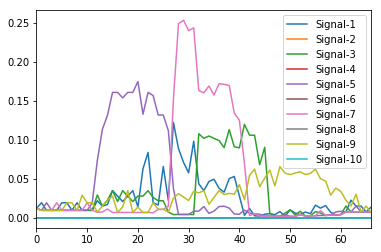

Topics Terms for Dutchrudder


Topic Number                    Topic Terms                    
0         1       gp, pounds, hosting, rain, fuck, person, bend,...
1         2                                                 needles
2         3       body, ass, loaf, inch, kinky, suns, friday, pe...
3         4       week, minge, weeks, bass, fathers, mo, haha, m...
4         5       duty, town, babys, buy, star, power, spill, me...
5         6                                            tatts, train
6         7       tax, sack, drive, eurovision, year, watched, p...
7         8       raining, played, dance, ak, month, bring, wife...
8         9         cut, shatterd, lol, kill, hell, girl, self_harm
9        10       yaay, rang, love, fucking, sweet, twitter, fil...
10       11       wasent, squeezed, crazy, extra, laught, goodti...
11       12       sod, sleepy, dildo, bro, trent, tastes, radio,...
12       13       managed, mental, horn, fakers, teething, ave, ...
13       14       force, lied, classic, fish, tidy, deep, sleep,...
14       15       mums, inlaws, asleep, sounds, nights, csi, wee...
15       16       family, app, rest, spent, supermarket, turning...
16       17       great, staffy, ya, xxx, park, water, turn, xx,...
17       18       demon, cold, hopfully, hermaphrodite, lil, dan...
18       19                                                     num
19       20       cm, phones, walk, lips, names, sea, matey, rou...
20       21       cigs, ad, int, money, grandaughter, turned, se...
21       23       twin, heart, gold, ive, pot, buffy, wolly, bit...
22       24       enjoy, ding, doll, period, steve, bitch, folk,...
23       25       , drink, good, house, knew, bloody, wet, pants...

Seeded Terms Per Topic for Dutchrudder


Topic Number             Seed Terms:Count           
0   signal_1                                  moody:14
1   signal_9    hell:14, cut:14, kill:14, self_harm:14
2   signal_3                                 lie_in:14
3   signal_5                                 twiggy:14
4   signal_7                              disturbed:14

Topics Probabilties Over Time for BrandyWandLover


Time Period         Signal-1   Signal-2   Signal-3  Signal-4   \
0   07/04/2009 - 19/04/2009  0.0303030  0.0303030     0.0    0.0151515   
1   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
2   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
3   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
4   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
5   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
6   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
7   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
8   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
9   18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
10  18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
11  18/04/2009 - 19/04/2009  0.0000000  0.0000000     0.0    0.0000000   
12  19/04/2009 - 02/05/2009  0.0000000  0.0000000     0.0    0.0000000   
13  02/05/2009 - 03/05/2009  0.0188679  0.0188679     0.0    0.0188679   
14  02/05/2009 - 04/05/2009  0.0175439  0.0175439     0.0    0.0175439   
15  02/05/2009 - 04/05/2009  0.0175439  0.0175439     0.0    0.0175439   
16  02/05/2009 - 04/05/2009  0.0175439  0.0175439     0.0    0.0175439   
17  02/05/2009 - 04/05/2009  0.0175439  0.0175439     0.0    0.0175439   
18  02/05/2009 - 04/05/2009  0.0175439  0.0175439     0.0    0.0175439   
19  02/05/2009 - 04/05/2009  0.0175439  0.0175439     0.0    0.0175439   
20  02/05/2009 - 10/05/2009  0.0129870  0.0129870     0.0    0.0129870   
21  02/05/2009 - 11/05/2009  0.0125000  0.0125000     0.0    0.0125000   
22  02/05/2009 - 11/05/2009  0.0125000  0.0125000     0.0    0.0125000   
23  02/05/2009 - 11/05/2009  0.0125000  0.0125000     0.0    0.0125000   
24  02/05/2009 - 14/05/2009  0.0117647  0.0117647     0.0    0.0117647   
..                      ...        ...        ...       ...        ...   
32  10/05/2009 - 22/05/2009  0.0102041  0.0102041     0.0    0.0102041   
33  10/05/2009 - 22/05/2009  0.0204082  0.0102041     0.0    0.0102041   
34  11/05/2009 - 22/05/2009  0.0384615  0.0128205     0.0    0.0128205   
35  14/05/2009 - 22/05/2009  0.0266667  0.0133333     0.0    0.0133333   
36  14/05/2009 - 22/05/2009  0.0133333  0.0133333     0.0    0.0133333   
37  14/05/2009 - 22/05/2009  0.0400000  0.0133333     0.0    0.0266667   
38  17/05/2009 - 22/05/2009  0.0285714  0.0142857     0.0    0.0142857   
39  17/05/2009 - 29/05/2009  0.0086957  0.0086957     0.0    0.0086957   
40  17/05/2009 - 30/05/2009  0.0068966  0.0068966     0.0    0.0068966   
41  18/05/2009 - 31/05/2009  0.0157068  0.0052356     0.0    0.0052356   
42  22/05/2009 - 01/06/2009  0.0516432  0.0046948     0.0    0.0046948   
43  22/05/2009 - 02/06/2009  0.0604982  0.0284698     0.0    0.0035587   
44  22/05/2009 - 03/06/2009  0.0631579  0.0210526     0.0    0.0105263   
45  22/05/2009 - 03/06/2009  0.0561404  0.0245614     0.0    0.0070175   
46  29/05/2009 - 05/06/2009  0.0647249  0.0420712     0.0    0.0258900   
47  29/05/2009 - 06/06/2009  0.0575080  0.0415335     0.0    0.0223642   
48  29/05/2009 - 07/06/2009  0.0357995  0.0477327     0.0    0.0739857   
49  29/05/2009 - 07/06/2009  0.0453461  0.0453461     0.0    0.0859189   
50  29/05/2009 - 07/06/2009  0.0429594  0.0477327     0.0    0.0859189   
51  29/05/2009 - 07/06/2009  0.0525060  0.0525060     0.0    0.0668258   
52  29/05/2009 - 07/06/2009  0.0477327  0.0477327     0.0    0.0668258   
53  30/05/2009 - 07/06/2009  0.0508021  0.0588235     0.0    0.0962567   
54  31/05/2009 - 07/06/2009  0.0494186  0.0610465     0.0    0.1075581   
55  01/06/2009 - 07/06/2009  0.0551724  0.0793103     0.0    0.1103448   
56  02/06/2009 - 15/06/2009  0.0418006  0.0900322     0.0    0.1414791   

    Signal-5  Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0       0.0    0.0151515     0.0     
1      0.0       0.0      

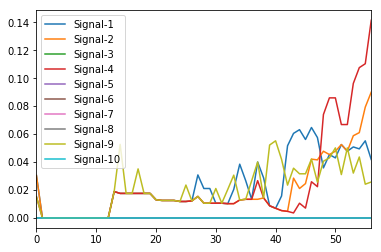

Topics Terms for BrandyWandLover


Topic Number                    Topic Terms                    
0         1       severely, actual, gona, britney, buses, boring...
1         2       town, blog, russell, vid, wudnt, fascist, bh, ...
2         3       ive, altho, tabs, years, texts, talked, yday, ...
3         4       raining, videos, tired, feel, iv, sounds, crap...
4         5       girlies, funny, cheered, attempt, everythng, g...
5         6                         clutching, question, love, dont
6         7       work, yay, wud, dvd, twitter, xxx, accent, isn...
7         8                   follow, favourites, cheesy, lucky, ur
8         9       rays, bothered, num, hell, colchester, biscuit...
9        10       earth, girl, hasnt, msn, sneezing, wen, tight,...
10       11       , hour, restaurant, tweet, comfy, wait, asked,...
11       12       hows, drugged, sympathy, awake, year, london, ...
12       13       replying, plans, family, watching, bitter, wee...
13       14       hammersmith, ladies, dm, sharing, dear, moment...
14       15                username, good, yumm, naked, straws, day
15       16       fulfil, mysti, ul, yea, predicatable, online, ...
16       17       gaining, bf, doggy, checked, ull, fit, lol, gr...
17       18       borrowed, trip, busy, virgin, lots, sold, gett...
18       19       toast, sad, middle, rusty, desperados, bloody,...
19       20       meant, choc, step, met, xx, dropped, bye, exer...
20       21       jojo, forum, rustyrockets, introduce, didnrt, ...
21       22       info, apple, missed, people, sun, hey, crappy,...
22       23        tickets, ol, aww, byee, interrupted, shops, cool
23       24       gtta, brandian, mornin, monday, lie, mess, noo...
24       25       languages, crap, la, dressed, teeny, harder, q...

Seeded Terms Per Topic for BrandyWandLover


Topic Number Seed Terms:Count
0   signal_9          hell:14  
1   signal_1         boring:9  
2   signal_2     suffering:14  
3   signal_4         tired:27

Topics Probabilties Over Time for krist0ph3r


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   07/04/2009 - 19/04/2009     0.0    0.0103093     0.0       0.0     
1   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
2   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
3   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
4   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
5   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
6   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
7   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
8   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
9   19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
10  19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
11  19/04/2009 - 21/04/2009     0.0    0.0128205     0.0       0.0     
12  19/04/2009 - 02/05/2009     0.0    0.0113636     0.0       0.0     
13  21/04/2009 - 03/05/2009     0.0    0.0161290     0.0       0.0     
14  21/04/2009 - 04/05/2009     0.0    0.0142857     0.0       0.0     
15  02/05/2009 - 04/05/2009     0.0    0.0156250     0.0       0.0     
16  02/05/2009 - 04/05/2009     0.0    0.0156250     0.0       0.0     
17  02/05/2009 - 04/05/2009     0.0    0.0156250     0.0       0.0     
18  02/05/2009 - 04/05/2009     0.0    0.0156250     0.0       0.0     
19  02/05/2009 - 09/05/2009     0.0    0.0253165     0.0       0.0     
20  02/05/2009 - 10/05/2009     0.0    0.0086957     0.0       0.0     
21  02/05/2009 - 10/05/2009     0.0    0.0086957     0.0       0.0     
22  02/05/2009 - 10/05/2009     0.0    0.0086957     0.0       0.0     
23  02/05/2009 - 10/05/2009     0.0    0.0173913     0.0       0.0     
24  02/05/2009 - 10/05/2009     0.0    0.0086957     0.0       0.0     
25  02/05/2009 - 10/05/2009     0.0    0.0173913     0.0       0.0     
26  03/05/2009 - 10/05/2009     0.0    0.0095238     0.0       0.0     
27  04/05/2009 - 17/05/2009     0.0    0.0101010     0.0       0.0     
28  09/05/2009 - 18/05/2009     0.0    0.0094340     0.0       0.0     
29  09/05/2009 - 18/05/2009     0.0    0.0094340     0.0       0.0     
30  09/05/2009 - 18/05/2009     0.0    0.0094340     0.0       0.0     
31  09/05/2009 - 18/05/2009     0.0    0.0188679     0.0       0.0     
32  09/05/2009 - 22/05/2009     0.0    0.0061728     0.0       0.0     
33  10/05/2009 - 22/05/2009     0.0    0.0136054     0.0       0.0     
34  17/05/2009 - 22/05/2009     0.0    0.0090090     0.0       0.0     
35  17/05/2009 - 22/05/2009     0.0    0.0090090     0.0       0.0     
36  17/05/2009 - 26/05/2009     0.0    0.0082645     0.0       0.0     
37  17/05/2009 - 26/05/2009     0.0    0.0165289     0.0       0.0     
38  17/05/2009 - 26/05/2009     0.0    0.0082645     0.0       0.0     
39  17/05/2009 - 29/05/2009     0.0    0.0061350     0.0       0.0     
40  17/05/2009 - 30/05/2009     0.0    0.0111732     0.0       0.0     
41  18/05/2009 - 31/05/2009     0.0    0.0474138     0.0       0.0     
42  22/05/2009 - 01/06/2009     0.0    0.0782313     0.0       0.0     
43  22/05/2009 - 02/06/2009     0.0    0.0813648     0.0       0.0     
44  22/05/2009 - 03/06/2009     0.0    0.0937500     0.0       0.0     
45  22/05/2009 - 03/06/2009     0.0    0.0958333     0.0       0.0     
46  26/05/2009 - 03/06/2009     0.0    0.1037736     0.0       0.0     
47  26/05/2009 - 06/06/2009     0.0    0.1118568     0.0       0.0     
48  26/05/2009 - 07/06/2009     0.0    0.1030928     0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0103093     0.0       0.0    0.0206186     0.0     
1      0.0    0.0256410     0.0       0.0    0.0384615     0.0     
2      0.0    0.0256410     0.0       0.0    0.0384615     0.0     
3      0.0    0.0256410     0.0       0.0    0.0256410     0.0     
4      0.0    0.0256410     0.0       0.0    0.0256410     0.0     


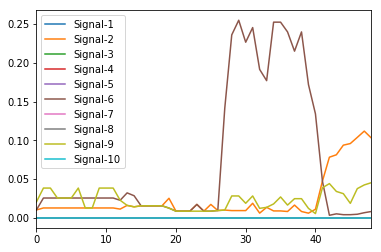

Topics Terms for krist0ph3r


Topic Number                    Topic Terms                    
0         1       genuine, readers, feel, fault, twitter, cellon...
1         2       troublesome, midnight, sign, asleep, bed, year...
2         3       bandra, men, love, takes, rise, road, dating, ...
3         4       mommy, sad, jump, pm, exist, rarely, fine, hmm...
4         5       beautiful, , people, hariyali, chutiya, saturd...
5         6       enforced, manage, battery, wtf, copyright, spi...
6         7       disguise, isnt, sober, subject, pink, funny, s...
7         8       shells, devastated, shore, sea, trains, sells,...
8         9       life, total, suicidal, cry, yeah, imo, mtnl, s...
9        10       guessing, daaru, weather, names, follow, roads...
10       11       immigrating, pop, voucher, tomorrow, speak, vo...
11       12       embarrassing, house, gujju, alive, planning, s...
12       13       cute, connections, num, deadline, human, worry...
13       14       crazy, outta, drunk, hangovers, turned, errors...
14       15       juice, brought, realized, usb, benchmarked, co...
15       16       cmon, scared, knew, naah, years, quart, switch...
16       17       dad, yay, confusion, time, bow, mom, west, min...
17       18       cordial, evolutionary, head, freaked, forgot, ...
18       19       plant, err, unblocked, notches, grief, tweets,...
19       20       sister, lonavla, barely, coast, thankie, panve...
20       21       blogger, hate, management, layout, suburbs, co...
21       22       teenage, fish, veggie, horns, adding, guess, t...
22       23       status, dui, carlberg, heineken, combo, rode, ...
23       24       treating, term, links, beeps, supermooha, trad...
24       25       point, apple, geekspeak, sales, ended, roamed,...

Seeded Terms Per Topic for krist0ph3r


Topic Number      Seed Terms:Count     
0   signal_9                   suicidal:8
1   signal_8                      panic:1
2   signal_2    depressed:8, depression:8
3   signal_6                      ugly:19

Topics Probabilties Over Time for NKANGEL74


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   01/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
1   02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
2   03/05/2009 - 16/05/2009     0.0       0.0       0.0       0.0       0.0     
3   04/05/2009 - 17/05/2009     0.0       0.0       0.0       0.0       0.0     
4   09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
5   09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
6   09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
7   09/05/2009 - 18/05/2009     0.0       0.0       0.0       0.0       0.0     
8   09/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
9   10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
10  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
11  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
12  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
13  16/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
14  16/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
15  16/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
16  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
17  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
18  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
19  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
20  22/05/2009 - 03/06/2009     0.0       0.0       0.0       0.0       0.0     
21  22/05/2009 - 04/06/2009     0.0       0.0       0.0       0.0       0.0     
22  28/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
23  28/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
24  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     

    Signal-6  Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0       0.0       0.0    0.0224719     0.0     
1      0.0       0.0       0.0    0.0243902     0.0     
2      0.0       0.0       0.0    0.0259740     0.0     
3      0.0       0.0       0.0    0.0128205     0.0     
4      0.0       0.0       0.0    0.0126582     0.0     
5      0.0       0.0       0.0    0.0126582     0.0     
6      0.0       0.0       0.0    0.0126582     0.0     
7      0.0       0.0       0.0    0.0126582     0.0     
8      0.0       0.0       0.0    0.0098039     0.0     
9      0.0       0.0       0.0    0.0101010     0.0     
10     0.0       0.0       0.0    0.0109890     0.0     
11     0.0       0.0       0.0    0.0109890     0.0     
12     0.0       0.0       0.0    0.0109890     0.0     
13     0.0       0.0       0.0    0.0109890     0.0     
14     0.0       0.0       0.0    0.0096154     0.0     
15     0.0       0.0       0.0    0.0086957     0.0     
16     0.0       0.0       0.0    0.0071942     0.0     
17     0.0       0.0       0.0    0.0088496     0.0     
18     0.0       0.0       0.0    0.0233645     0.0     
19     0.0       0.0       0.0    0.0211864     0.0     
20     0.0       0.0       0.0    0.0209205     0.0     
21     0.0       0.0       0.0    0.0203252     0.0     
22     0.0       0.0       0.0    0.0278884     0.0     
23     0.0       0.0       0.0    0.0279503     0.0     
24     0.0       0.0       0.0    0.0240385     0.0

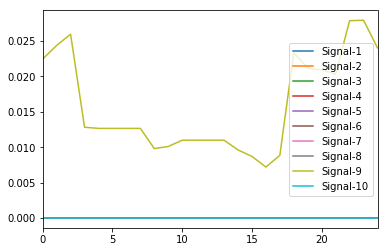

Topics Terms for NKANGEL74


Topic Number                    Topic Terms                    
0         1       enjoy, cute, concert, share, happenin, chat, y...
1         2       tension, good, fave, fish, knight, nah, friday...
2         3       md, checked, complete, year, nooo, june, watch...
3         4       profile, king, sweetie, pic, girls, cafepress,...
4         5              ya, yup, lol, fart, fans, telling, glasses
5         6       feel, top, twitpics, jersey, num, slowly, chan...
6         7       whooohoo, eventually, love, room, slight, doin...
7         8       beautiful, standing, hangin, missed, relax, te...
8         9       week, yay, dying, tmw, asap, photos, camera, f...
9        10       pull, aisle, hot, mind, yeah, yesterday, thoug...
10       11       great, met, cherry, twitter, upset, life, bed,...
11       12       sis, guess, outta, videos, deal, robert, track...
12       13       directed, tweeted, omg, people, hat, print, cu...
13       14       respond, disconnected, chatting, wireimage, te...
14       15       coffee, hehehe, eye, remember, blank, update, ...
15       16       sending, storm, sucks, list, coughin, start, s...
16       17                 yummy, searchin, nan, idea, banks, hate
17       18                          dear, amazing, hey, hope, told
18       19                 looove, hats, phone, ton, night, girlie
19       20       buses, battery, awesome, heard, probs, jesse, ...
20       21       breezing, somethin, btw, constantly, holllaaa,...
21       22       eyes, ugh, pain, coming, dunno, tweet, knew, h...
22       23       ick, insane, woot, work, sweaty, tweets, donni...
23       24               mornin, dont, soreness, pix, credit, burp
24       25       evening, longer, denim, awww, all_nighter, die...

Seeded Terms Per Topic for NKANGEL74


Topic Number Seed Terms:Count
0   signal_9        dying:2

Topics Probabilties Over Time for wendywings


Time Period         Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0   07/04/2009 - 20/04/2009     0.0       0.0       0.0       0.0       0.0     
1   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
2   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
3   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
4   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
5   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
6   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
7   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
8   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
9   18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
10  18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
11  18/04/2009 - 21/04/2009     0.0       0.0       0.0       0.0       0.0     
12  19/04/2009 - 02/05/2009     0.0       0.0       0.0       0.0       0.0     
13  20/04/2009 - 03/05/2009     0.0       0.0       0.0       0.0       0.0     
14  21/04/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
15  02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
16  02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
17  02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
18  02/05/2009 - 04/05/2009     0.0       0.0       0.0       0.0       0.0     
19  02/05/2009 - 09/05/2009     0.0       0.0       0.0       0.0       0.0     
20  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
21  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
22  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
23  02/05/2009 - 10/05/2009     0.0       0.0       0.0       0.0       0.0     
24  02/05/2009 - 14/05/2009     0.0       0.0       0.0       0.0       0.0     
..                      ...       ...       ...       ...       ...       ...   
32  09/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
33  10/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
34  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
35  14/05/2009 - 22/05/2009     0.0       0.0       0.0       0.0       0.0     
36  14/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
37  14/05/2009 - 26/05/2009     0.0       0.0       0.0       0.0       0.0     
38  17/05/2009 - 28/05/2009     0.0       0.0       0.0       0.0       0.0     
39  17/05/2009 - 29/05/2009     0.0       0.0       0.0       0.0       0.0     
40  17/05/2009 - 30/05/2009     0.0       0.0       0.0       0.0       0.0     
41  18/05/2009 - 31/05/2009     0.0       0.0       0.0       0.0       0.0     
42  22/05/2009 - 01/06/2009     0.0       0.0       0.0       0.0       0.0     
43  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
44  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
45  22/05/2009 - 02/06/2009     0.0       0.0       0.0       0.0       0.0     
46  26/05/2009 - 05/06/2009     0.0       0.0       0.0       0.0       0.0     
47  26/05/2009 - 06/06/2009     0.0       0.0       0.0       0.0       0.0     
48  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
49  26/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
50  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
51  28/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
52  29/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
53  30/05/2009 - 07/06/2009     0.0       0.0       0.0       0.0       0.0     
54  31/05/2009 - 07/06/2009     0.0     

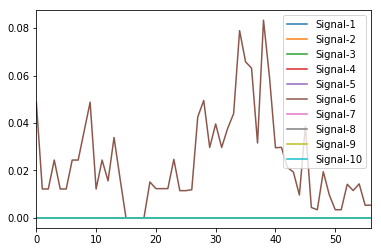

Topics Terms for wendywings


Topic Number                    Topic Terms                    
0         1       hallmark, love, btw, attitude, reeces, kate, r...
1         2       loved, cupcakes, emo, fast, chocolate, boys, f...
2         3       huge, beef, things, aunty, corned, pretty, sla...
3         4       , cup, moved, hotel, mind, young, hugging, ben...
4         5       read, chunk, lol, chillax, doubt, call, oops, ...
5         6                                       wrong, num, worst
6         7       ugh, snakes, slipped, feel, cheap, month, hair...
7         8       queen, ad, auckland, food, epis, backs, remove...
8         9                            zealand, juice, pork, stream
9        10       entire, eye, smith, viaduct, aotearoa, fillet,...
10       11       chew, yard, space, house, stay, numbers, fun, ...
11       12       weeks, updated, kids, pampered, win, ahh, work...
12       13       meant, thought, kind, buy, rugby, success, rec...
13       14                                      good, sooo, easier
14       15       shot, figure, born, goodnight, contract, cabs,...
15       16                  checking, building, mail, missed, year
16       17       reading, start, ingredients, nan, secret, anyt...
17       18       door, coffee, freak, shopping, fantastic, thur...
18       19       saturday, cher, mc, furfriend, oscar, decision...
19       20       pre, cute, raised, golf, people, cover, recipe...
20       21       chinese, sumptuous, hey, legal, tonight, thing...
21       22       party, life, smaller, tweet, spent, butcher, h...
22       23                            filming, time, died, natasha
23       24       toast, web, bathroom, roast, deal, glitch, lew...
24       25       set, picnic, parentng, guilty, drink, girls, t...

Seeded Terms Per Topic for wendywings


Topic Number Seed Terms:Count
0   signal_6       worst:14

Topics Probabilties Over Time for hummingbird604


Time Period         Signal-1   Signal-2   Signal-3   Signal-4  \
0   18/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000     0.0     
1   19/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000     0.0     
2   20/04/2009 - 20/04/2009  0.0000000  0.0000000  0.0000000     0.0     
3   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
4   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
5   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
6   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
7   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
8   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
9   04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
10  04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
11  04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
12  04/05/2009 - 04/05/2009  0.0000000  0.0000000  0.0000000     0.0     
13  04/05/2009 - 14/05/2009  0.0185185  0.0185185  0.0370370     0.0     
14  04/05/2009 - 14/05/2009  0.0370370  0.0185185  0.0185185     0.0     
15  04/05/2009 - 16/05/2009  0.0338983  0.0169492  0.0677966     0.0     
16  04/05/2009 - 17/05/2009  0.0555556  0.0138889  0.0416667     0.0     
17  14/05/2009 - 18/05/2009  0.0449438  0.0112360  0.0898876     0.0     
18  14/05/2009 - 18/05/2009  0.0112360  0.0112360  0.0898876     0.0     
19  14/05/2009 - 18/05/2009  0.0337079  0.0112360  0.0898876     0.0     
20  14/05/2009 - 21/05/2009  0.0434783  0.0108696  0.0760870     0.0     
21  14/05/2009 - 21/05/2009  0.0217391  0.0108696  0.0652174     0.0     
22  14/05/2009 - 21/05/2009  0.0543478  0.0108696  0.0760870     0.0     
23  14/05/2009 - 21/05/2009  0.0326087  0.0108696  0.0869565     0.0     
24  14/05/2009 - 21/05/2009  0.0326087  0.0108696  0.0869565     0.0     
..                      ...        ...        ...        ...       ...   
26  14/05/2009 - 21/05/2009  0.0543478  0.0108696  0.0760870     0.0     
27  16/05/2009 - 21/05/2009  0.0156250  0.0156250  0.0781250     0.0     
28  16/05/2009 - 29/05/2009  0.0163934  0.0491803  0.0573770     0.0     
29  17/05/2009 - 30/05/2009  0.0147059  0.1102941  0.0588235     0.0     
30  18/05/2009 - 31/05/2009  0.0523560  0.1099476  0.0418848     0.0     
31  21/05/2009 - 01/06/2009  0.0165289  0.1115702  0.0041322     0.0     
32  21/05/2009 - 02/06/2009  0.0155642  0.0856031  0.0038911     0.0     
33  21/05/2009 - 03/06/2009  0.0231660  0.1081081  0.0115830     0.0     
34  29/05/2009 - 03/06/2009  0.0195312  0.1015625  0.0039062     0.0     
35  29/05/2009 - 05/06/2009  0.0275229  0.0733945  0.0061162     0.0     
36  29/05/2009 - 06/06/2009  0.0211640  0.0582011  0.0052910     0.0     
37  29/05/2009 - 07/06/2009  0.0138568  0.0600462  0.0138568     0.0     
38  29/05/2009 - 07/06/2009  0.0346420  0.0623557  0.0092379     0.0     
39  29/05/2009 - 07/06/2009  0.0369515  0.0531178  0.0046189     0.0     
40  29/05/2009 - 07/06/2009  0.0161663  0.0646651  0.0115473     0.0     
41  29/05/2009 - 07/06/2009  0.0323326  0.0600462  0.0115473     0.0     
42  30/05/2009 - 07/06/2009  0.0320000  0.0480000  0.0053333     0.0     
43  31/05/2009 - 07/06/2009  0.0224719  0.0365169  0.0112360     0.0     
44  01/06/2009 - 07/06/2009  0.0104167  0.0243056  0.0243056     0.0     
45  02/06/2009 - 15/06/2009  0.0375940  0.0037594  0.0187970     0.0     
46  03/06/2009 - 16/06/2009  0.0500000  0.0035714  0.0250000     0.0     
47  05/06/2009 - 16/06/2009  0.0215827  0.0035971  0.0107914     0.0     
48  05/06/2009 - 16/06/2009  0.0323741  0.0035971  0.0179856     0.0     
49  06/06/2009 - 19/06/2009  0.0321101  0.0045872  0.0321101     0.0     
50  07/06/2009 - 20/06/2009  0.0617978  0.0056180  0.0280899     0.0     

    Signal-5  Signal-6  Signal-7   Signal-8  Signal-9  Signal-10  
0      0.0       0.0    0.0000000     0.0       0.0       0.0     
1      0.0       0.0    0.

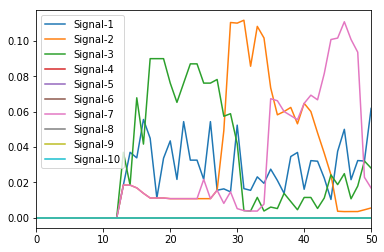

Topics Terms for hummingbird604


Topic Number                    Topic Terms                    
0         1                                    good, num, apathetic
1         2       bully, prepared, twe, considered, tea, laptop,...
2         3         calming, great, love, send, phd, awake, problem
3         4       dino, idea, mentioned, happen, yam, filming, h...
4         5       envious, comadre, people, intoxicatingly, agre...
5         6       technically, heart, keeping, surrounded, episo...
6         7       replied, mexico, communication, talking, follo...
7         8       photo, support, fast, anatomy, waiting, wonder...
8         9                        canada, lynne, nan, thx, morning
9        10       apartment, sapphire, insomniac, tbarcamp, alri...
10       11       google, tweeted, longer, congrats, lots, bed, ...
11       12       cheese, point, scotty, goodness, freeware, fin...
12       13       inserting, spending, review, capabilities, des...
13       14       super, process, bright, names, japan, compadre...
14       15       ass, teleport, bucca, provide, safe, engaging,...
15       16          ft, jeff, tokyo, raj, times, live, sleep, hope
16       17       phil, tuesday, tonight, comments, concentratio...
17       18       received, head, feedback, yesterday, crib, lea...
18       19       enjoy, respond, house, enrolling, dearest, rep...
19       20       articles, play, hour, jt, big, awesome, friday...
20       21       school, reserved, awesomesauceness, talks, sad...
21       22       beautiful, conflicting, bit, lynn, chance, pla...
22       23       woman, afraid, group, telling, freckles, withd...
23       24       , sigh, private, sad, maura, dancer, promised,...
24       25       sort, blog, life, committee, area, solid, gods...

Seeded Terms Per Topic for hummingbird604


Topic Number     Seed Terms:Count    
0   signal_1                apathetic:6
1   signal_3                   awake:14
2   signal_2                  dismal:14
3   signal_7    not_paying_attention:14

Topics Probabilties Over Time for chantellmarie


Time Period         Signal-1   Signal-2  Signal-3   Signal-4   \
0   02/05/2009 - 02/05/2009  0.0000000     0.0    0.0000000  0.0000000   
1   28/05/2009 - 28/05/2009  0.0000000     0.0    0.0000000  0.0000000   
2   28/05/2009 - 29/05/2009  0.0144928     0.0    0.0289855  0.0434783   
3   28/05/2009 - 30/05/2009  0.0423280     0.0    0.0211640  0.0423280   
4   28/05/2009 - 31/05/2009  0.0425532     0.0    0.0212766  0.0602837   
5   28/05/2009 - 01/06/2009  0.0473186     0.0    0.0441640  0.0599369   
6   28/05/2009 - 02/06/2009  0.0507463     0.0    0.0388060  0.0477612   
7   28/05/2009 - 03/06/2009  0.0498534     0.0    0.0381232  0.0381232   
8   28/05/2009 - 04/06/2009  0.0449438     0.0    0.0393258  0.0477528   
9   28/05/2009 - 05/06/2009  0.0501139     0.0    0.0341686  0.0432802   
10  28/05/2009 - 06/06/2009  0.0374753     0.0    0.0295858  0.0315582   
11  28/05/2009 - 07/06/2009  0.0293638     0.0    0.0228385  0.0293638   

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
1      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
2      0.0    0.0144928     0.0       0.0    0.0289855     0.0     
3      0.0    0.0687831     0.0       0.0    0.0476190     0.0     
4      0.0    0.0673759     0.0       0.0    0.0354610     0.0     
5      0.0    0.0630915     0.0       0.0    0.0283912     0.0     
6      0.0    0.0716418     0.0       0.0    0.0388060     0.0     
7      0.0    0.0703812     0.0       0.0    0.0381232     0.0     
8      0.0    0.0646067     0.0       0.0    0.0308989     0.0     
9      0.0    0.0501139     0.0       0.0    0.0296128     0.0     
10     0.0    0.0414201     0.0       0.0    0.0355030     0.0     
11     0.0    0.0473083     0.0       0.0    0.0326264     0.0

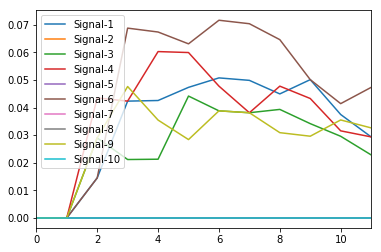

Topics Terms for chantellmarie


Topic Number                    Topic Terms                    
0         1       life, dm, light, pic, florida, work, chest, de...
1         2       omg, michigan, sleepy, hey, gator, wake, crack...
2         3       play, asap, lock, insomnia, jokes, nap, versio...
3         4       hoodrat, randomness, turning, games, love, tir...
4         5       ass, city, fraud, tmobile, vid, lessons, movie...
5         6       respond, picture, haters, eloping, nah, huh, d...
6         7       point, good, district, kendricks, ooo, support...
7         8       sticking, crazy, business, eel, thinking, girl...
8         9       book, prob, yummy, dying, horror, ringtone, hu...
9        10       celly, streets, broke, hostile, la, feel, ring...
10       11       summer, wall, phones, prediction, proven, twin...
11       12       cute, awkward, working, fav, edward, morning, ...
12       13       columbus, heads, gym, laker, tour, joker, eddi...
13       14       party, gville, chapel, elvis, upgrading, perpe...
14       15       realized, center, starting, wow, vacation, ppl...
15       16       cramps, handle, miami, landlocked, favorite, b...
16       17       town, damaged, curly, bel, aww, lol, classmate...
17       18       , portuguese, hire, stomach, missed, power, mi...
18       19       enjoy, keeping, magic, lost, lame, ciao, trave...
19       20       comment, convert, alex, dont, semi, nada, shou...
20       21       putting, week, gainesville, screen, universe, ...
21       22       coach, yay, tv, sucks, sonics, fights, nan, pu...
22       23       favorited, lived, fl, halle, yeah, hours, phon...
23       24       sushi, people, sigh, twitter, leg, spots, choc...
24       25       orlando, affair, kids, listening, figure, soni...

Seeded Terms Per Topic for chantellmarie


Topic Number   Seed Terms:Count  
0   signal_1               bored:16
1   signal_9        dying:9, hurt:8
2   signal_3    insomnia:7, awake:9
3   signal_4                tired:1
4   signal_6                loser:9

Topics Probabilties Over Time for mcraddictal


Time Period         Signal-1   Signal-2   Signal-3   Signal-4  \
0   18/04/2009 - 01/05/2009  0.0000000  0.0000000  0.0000000     0.0     
1   20/04/2009 - 01/05/2009  0.0000000  0.0000000  0.0000000     0.0     
2   20/04/2009 - 03/05/2009  0.0000000  0.0000000  0.0000000     0.0     
3   21/04/2009 - 04/05/2009  0.0158730  0.0158730  0.0158730     0.0     
4   01/05/2009 - 04/05/2009  0.0166667  0.0166667  0.0166667     0.0     
5   01/05/2009 - 04/05/2009  0.0166667  0.0166667  0.0166667     0.0     
6   01/05/2009 - 04/05/2009  0.0166667  0.0166667  0.0166667     0.0     
7   01/05/2009 - 04/05/2009  0.0166667  0.0166667  0.0166667     0.0     
8   01/05/2009 - 09/05/2009  0.0133333  0.0133333  0.0133333     0.0     
9   01/05/2009 - 10/05/2009  0.0090909  0.0090909  0.0090909     0.0     
10  01/05/2009 - 11/05/2009  0.0078125  0.0078125  0.0078125     0.0     
11  01/05/2009 - 11/05/2009  0.0078125  0.0078125  0.0078125     0.0     
12  01/05/2009 - 11/05/2009  0.0078125  0.0156250  0.0078125     0.0     
13  01/05/2009 - 14/05/2009  0.0069444  0.0069444  0.0069444     0.0     
14  03/05/2009 - 14/05/2009  0.0070423  0.0140845  0.0070423     0.0     
15  03/05/2009 - 16/05/2009  0.0069930  0.0209790  0.0069930     0.0     
16  04/05/2009 - 17/05/2009  0.0912863  0.0290456  0.0124481     0.0     
17  09/05/2009 - 18/05/2009  0.1196911  0.0579151  0.0231660     0.0     
18  09/05/2009 - 18/05/2009  0.1042471  0.0579151  0.0193050     0.0     
19  09/05/2009 - 18/05/2009  0.1158301  0.0501931  0.0231660     0.0     
20  09/05/2009 - 21/05/2009  0.1152416  0.0520446  0.0408922     0.0     
21  09/05/2009 - 22/05/2009  0.1126761  0.0492958  0.0387324     0.0     
22  10/05/2009 - 22/05/2009  0.1115242  0.0334572  0.0408922     0.0     
23  11/05/2009 - 22/05/2009  0.1282051  0.0470085  0.0427350     0.0     
24  14/05/2009 - 22/05/2009  0.1435185  0.0462963  0.0416667     0.0     
25  14/05/2009 - 26/05/2009  0.1466667  0.0444444  0.0444444     0.0     
26  14/05/2009 - 26/05/2009  0.1377778  0.0622222  0.0577778     0.0     
27  16/05/2009 - 28/05/2009  0.1454545  0.0409091  0.0590909     0.0     
28  16/05/2009 - 29/05/2009  0.0968858  0.0415225  0.0415225     0.0     
29  17/05/2009 - 30/05/2009  0.0942857  0.0628571  0.0257143     0.0     
30  18/05/2009 - 31/05/2009  0.0142450  0.0370370  0.0427350     0.0     
31  21/05/2009 - 01/06/2009  0.0025126  0.0226131  0.0150754     0.0     
32  21/05/2009 - 02/06/2009  0.0021097  0.0105485  0.0168776     0.0     
33  21/05/2009 - 03/06/2009  0.0021053  0.0168421  0.0210526     0.0     
34  22/05/2009 - 04/06/2009  0.0021186  0.0148305  0.0105932     0.0     
35  26/05/2009 - 05/06/2009  0.0020243  0.0263158  0.0182186     0.0     
36  26/05/2009 - 06/06/2009  0.0016129  0.0177419  0.0225806     0.0     
37  26/05/2009 - 07/06/2009  0.0015699  0.0329670  0.0156986     0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9   Signal-10  
0      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
1      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
2      0.0    0.0000000     0.0       0.0    0.0000000     0.0     
3      0.0    0.0158730     0.0       0.0    0.0952381     0.0     
4      0.0    0.0166667     0.0       0.0    0.0833333     0.0     
5      0.0    0.0166667     0.0       0.0    0.0833333     0.0     
6      0.0    0.0166667     0.0       0.0    0.0500000     0.0     
7      0.0    0.0166667     0.0       0.0    0.0666667     0.0     
8      0.0    0.0133333     0.0       0.0    0.0800000     0.0     
9      0.0    0.0090909     0.0       0.0    0.0636364     0.0     
10     0.0    0.0078125     0.0       0.0    0.0546875     0.0     
11     0.0    0.0156250     0.0       0.0    0.0546875     0.0     
12     0.0    0.0156250     0.0       0.0    0.0468750     0.0     
13     0.0    0.0416667     0.0       0.0    0.0347222     0.0     
14     0.0    0.0352113     0.0       0.0    0.0352113     0.0     
15     0.0    0.0349650     0.0   

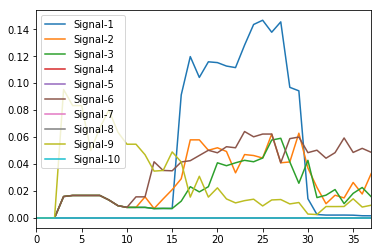

Topics Terms for mcraddictal


Topic Number                    Topic Terms                    
0         1       smoke, keeping, australia, sacrificing, family...
1         2       kind, be_alone, depressed, nan, explain, watch...
2         3       playlist, dm, dont, healthy, go_to_sleep, nail...
3         4       art, muffin, years, happen, anywayz, ima, miss...
4         5       shop, fucking, sleeping_pills, peanut, interes...
5         6       retard, good, force, nooo, movies, feel, cry, ...
6         7       suck, guessing, biology, eh, loveees, forever,...
7         8       fuck, ppl, disc, escape, rappp, winning, eric,...
8         9       listenin, cut, fate, die, lol, hurt, bahahah, ...
9        10       love, start, haha, site, cries, night, goodmor...
10       11                                       awwwe, num, stuff
11       12       hyper, yea, sweet, twitter, lack, idec, travis...
12       13       moan, bored, begging, face, feels, msi, losing...
13       14       btw, outta, givin, wall, rachel, corner, video...
14       15       win, alive, talking, mutt, replies, fine, ian,...
15       16       ugh, wakes, tired, confused, vacation, jess, i...
16       17                                          hah, bye, stay
17       18       great, hun, work, mind, live, fucktard, goodni...
18       19       summer, talked, yay, mm, bus, aiden, indonesia...
19       20       dad, worse, lmfao, walks, zacky, dances, stupi...
20       21       school, slept, break, hear, worry, favorites, ...
21       22       , stalkee, creek, scared, xd, sad, ge, disappe...
22       23       head, washing, sorta, sooo, quiet, answered, t...
23       24       replied, figure, people, house, hair, fattie, ...
24       25       scary, missing, reminding, emo, florida, late,...

Seeded Terms Per Topic for mcraddictal


Topic Number             Seed Terms:Count           
0   signal_9    die:28, hurt:4, kill:14, cut:3, hell:6
1   signal_1                                 boring:14
2   signal_3       awake:11, go_to_sleep:14, sleepy:14
3   signal_2       depressed:14, torment:9, be_alone:2
4   signal_6                      retard:24, give_up:7

Topics Probabilties Over Time for linnetwoods


Time Period         Signal-1  Signal-2   Signal-3  Signal-4  \
0   18/04/2009 - 19/04/2009     0.0    0.0416667     0.0       0.0     
1   19/04/2009 - 02/05/2009     0.0    0.0000000     0.0       0.0     
2   02/05/2009 - 03/05/2009     0.0    0.0156250     0.0       0.0     
3   02/05/2009 - 04/05/2009     0.0    0.0108696     0.0       0.0     
4   02/05/2009 - 04/05/2009     0.0    0.0108696     0.0       0.0     
5   02/05/2009 - 04/05/2009     0.0    0.0217391     0.0       0.0     
6   02/05/2009 - 04/05/2009     0.0    0.0108696     0.0       0.0     
7   02/05/2009 - 04/05/2009     0.0    0.0108696     0.0       0.0     
8   02/05/2009 - 04/05/2009     0.0    0.0217391     0.0       0.0     
9   02/05/2009 - 10/05/2009     0.0    0.0046729     0.0       0.0     
10  02/05/2009 - 10/05/2009     0.0    0.0046729     0.0       0.0     
11  02/05/2009 - 10/05/2009     0.0    0.0046729     0.0       0.0     
12  02/05/2009 - 10/05/2009     0.0    0.0046729     0.0       0.0     
13  02/05/2009 - 14/05/2009     0.0    0.0040486     0.0       0.0     
14  02/05/2009 - 14/05/2009     0.0    0.0040486     0.0       0.0     
15  03/05/2009 - 14/05/2009     0.0    0.0043860     0.0       0.0     
16  04/05/2009 - 17/05/2009     0.0    0.0037736     0.0       0.0     
17  10/05/2009 - 18/05/2009     0.0    0.0038168     0.0       0.0     
18  10/05/2009 - 18/05/2009     0.0    0.0038168     0.0       0.0     
19  10/05/2009 - 18/05/2009     0.0    0.0076336     0.0       0.0     
20  10/05/2009 - 18/05/2009     0.0    0.0038168     0.0       0.0     
21  10/05/2009 - 18/05/2009     0.0    0.0038168     0.0       0.0     
22  10/05/2009 - 18/05/2009     0.0    0.0076336     0.0       0.0     
23  14/05/2009 - 18/05/2009     0.0    0.0142857     0.0       0.0     
24  14/05/2009 - 18/05/2009     0.0    0.0071429     0.0       0.0     
25  14/05/2009 - 18/05/2009     0.0    0.0071429     0.0       0.0     
26  14/05/2009 - 18/05/2009     0.0    0.0071429     0.0       0.0     
27  17/05/2009 - 18/05/2009     0.0    0.0093458     0.0       0.0     
28  17/05/2009 - 29/05/2009     0.0    0.0422535     0.0       0.0     
29  17/05/2009 - 30/05/2009     0.0    0.0520231     0.0       0.0     
30  18/05/2009 - 31/05/2009     0.0    0.0934256     0.0       0.0     
31  29/05/2009 - 01/06/2009     0.0    0.1089918     0.0       0.0     
32  29/05/2009 - 02/06/2009     0.0    0.1063830     0.0       0.0     
33  29/05/2009 - 02/06/2009     0.0    0.1063830     0.0       0.0     
34  29/05/2009 - 04/06/2009     0.0    0.1122715     0.0       0.0     
35  29/05/2009 - 05/06/2009     0.0    0.1124122     0.0       0.0     
36  29/05/2009 - 06/06/2009     0.0    0.0927835     0.0       0.0     
37  29/05/2009 - 07/06/2009     0.0    0.0914286     0.0       0.0     

    Signal-5  Signal-6   Signal-7  Signal-8  Signal-9  Signal-10  
0      0.0    0.1041667     0.0       0.0       0.0       0.0     
1      0.0    0.0000000     0.0       0.0       0.0       0.0     
2      0.0    0.0156250     0.0       0.0       0.0       0.0     
3      0.0    0.0326087     0.0       0.0       0.0       0.0     
4      0.0    0.0217391     0.0       0.0       0.0       0.0     
5      0.0    0.0108696     0.0       0.0       0.0       0.0     
6      0.0    0.0217391     0.0       0.0       0.0       0.0     
7      0.0    0.0217391     0.0       0.0       0.0       0.0     
8      0.0    0.0108696     0.0       0.0       0.0       0.0     
9      0.0    0.0140187     0.0       0.0       0.0       0.0     
10     0.0    0.0093458     0.0       0.0       0.0       0.0     
11     0.0    0.0233645     0.0       0.0       0.0       0.0     
12     0.0    0.0280374     0.0       0.0       0.0       0.0     
13     0.0    0.0080972     0.0       0.0       0.0       0.0     
14     0.0    0.0121457     0.0       0.0       0.0       0.0     
15     0.0    0.0087719     0.0       0.0       0.0       0.0     
16     0.0    0.0264151     0.0       0.0       0.0       0.0

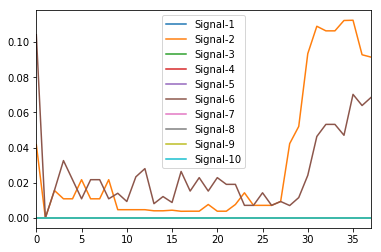

Topics Terms for linnetwoods


Topic Number                    Topic Terms                    
0         1       extra, aww, starts, confection, merci, mass, a...
1         2       heavy, brightly, absolutely, creation, hey, tr...
2         3       great, return, reason, costs, link, spanish, g...
3         4       picked, rest, aw, sharpened, technique, mud, w...
4         5       , confessional, unfollow, life, sense, sugar, ...
5         6       case, gross, full, showing, longer, links, peo...
6         7       toast, coffee, dm, newbie, peach, facility, sw...
7         8                                            aileen, site
8         9       heart, restless, pic, sad, middle, ready, carl...
9        10       fond, checked, missed, rash, mags, sharing, wo...
10       11       slinging, switched, exhausted, lynne, simply, ...
11       12       load, addressing, britains, celebrities, slice...
12       13       school, thing, feel, nah, men, nan, ideas, soe...
13       14       enjoy, antique, anjeebaby, point, brain, goodn...
14       15       deep, thinker, tend, straight, roots, bunch, b...
15       16       twitter, delighted, diet, spent, wait, strange...
16       17       doubtless, meant, guess, set, returning, colle...
17       18       continue, wall, elevator, bless, deserves, num...
18       19                                       search, lol, time
19       20       hooray, remark, graphic, compliments, hoping, ...
20       21       respond, shot, sea, request, recommendation, m...
21       22       eating, remember, oi, wholemeal, quuote, blip,...
22       23       circus, humans, idea, vanished, bring, disrepu...
23       24       mails, namaste, love, flywheel, standards, pop...
24       25       horses, definition, corretness, acclaim, place...

Seeded Terms Per Topic for linnetwoods


Topic Number      Seed Terms:Count     
0   signal_2                  dreadful:10
1   signal_6    shame:14, gross:7, ugly:7

In [18]:
user_depression_outputs = {}

for user in user_sample:
    try:
        user_depression_outputs[user] = detect_depression(user_LDA_outputs[user],user)
    except:
        pass